In [1]:
import math, random

import gym
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd 
import torch.nn.functional as F

from common.layers import NoisyLinear
from common.replay_buffer import ReplayBuffer
import gym_Aircraft

from itertools import count
import time
import itertools
import matplotlib
import matplotlib.pyplot as plt

In [2]:
USE_CUDA = torch.cuda.is_available()
Variable = lambda *args, **kwargs: autograd.Variable(*args, **kwargs).cuda() if USE_CUDA else autograd.Variable(*args, **kwargs)

In [3]:
env_id = "acav-v0"
env = gym.make(env_id)

/home/jupyter-kunwoopark/.local/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [4]:
class RainbowDQN(nn.Module):
    def __init__(self, num_inputs, num_actions, num_atoms, Vmin, Vmax):
        super(RainbowDQN, self).__init__()
        
        self.num_inputs   = num_inputs
        self.num_actions  = num_actions
        self.num_atoms    = num_atoms
        self.Vmin         = Vmin
        self.Vmax         = Vmax
        
        self.linear1 = nn.Linear(num_inputs, 32)
        self.linear2 = nn.Linear(32, 64)
        self.linear3 = nn.Linear(64, 64)
        self.linear4 = nn.Linear(64, 64)
        self.linear5 = nn.Linear(64, 64)
        self.linear6 = nn.Linear(64, 64)
        
        self.noisy_value1 = NoisyLinear(64, 64, use_cuda=USE_CUDA)
        self.noisy_value2 = NoisyLinear(64, self.num_atoms, use_cuda=USE_CUDA)
        
        self.noisy_advantage1 = NoisyLinear(64, 64, use_cuda=USE_CUDA)
        self.noisy_advantage2 = NoisyLinear(64, self.num_atoms * self.num_actions, use_cuda=USE_CUDA)
        
    def forward(self, x):
        batch_size = x.size(0)
        
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        x = F.relu(self.linear3(x))
        x = F.relu(self.linear4(x))
        x = F.relu(self.linear5(x))
        x = F.relu(self.linear6(x))
        
        value = F.relu(self.noisy_value1(x))
        value = self.noisy_value2(value)
        
        advantage = F.relu(self.noisy_advantage1(x))
        advantage = self.noisy_advantage2(advantage)
        
        value     = value.view(batch_size, 1, self.num_atoms)
        advantage = advantage.view(batch_size, self.num_actions, self.num_atoms)
        
        x = value + advantage - advantage.mean(1, keepdim=True)
        x = F.softmax(x.view(-1, self.num_atoms)).view(-1, self.num_actions, self.num_atoms)
        
        return x
        
    def reset_noise(self):
        self.noisy_value1.reset_noise()
        self.noisy_value2.reset_noise()
        self.noisy_advantage1.reset_noise()
        self.noisy_advantage2.reset_noise()
    
    def act(self, state):
        state = Variable(torch.FloatTensor(state).unsqueeze(0), volatile=True)
        dist = self.forward(state).data.cpu()
        dist = dist * torch.linspace(self.Vmin, self.Vmax, self.num_atoms)
        action = dist.sum(2).max(1)[1].numpy()[0]
        return action

In [5]:
num_atoms = 51
Vmin = -10
Vmax = 10

current_model = RainbowDQN(env.observation_space.shape[0], env.action_space.n, num_atoms, Vmin, Vmax)
target_model  = RainbowDQN(env.observation_space.shape[0], env.action_space.n, num_atoms, Vmin, Vmax)

if USE_CUDA:
    current_model = current_model.cuda()
    target_model  = target_model.cuda()
    
optimizer = optim.Adam(current_model.parameters(), 0.001)

replay_buffer = ReplayBuffer(50000)

In [6]:
def update_target(current_model, target_model):
    target_model.load_state_dict(current_model.state_dict())
    
update_target(current_model, target_model)

In [7]:
def projection_distribution(next_state, rewards, dones):
    batch_size  = next_state.size(0)
    
    delta_z = float(Vmax - Vmin) / (num_atoms - 1)
    support = torch.linspace(Vmin, Vmax, num_atoms)
    
    next_dist   = target_model(next_state).data.cpu() * support
    next_action = next_dist.sum(2).max(1)[1]
    next_action = next_action.unsqueeze(1).unsqueeze(1).expand(next_dist.size(0), 1, next_dist.size(2))
    next_dist   = next_dist.gather(1, next_action).squeeze(1)
        
    rewards = rewards.unsqueeze(1).expand_as(next_dist)
    dones   = dones.unsqueeze(1).expand_as(next_dist)
    support = support.unsqueeze(0).expand_as(next_dist)
    
    Tz = rewards + (1 - dones) * 0.99 * support
    Tz = Tz.clamp(min=Vmin, max=Vmax)
    b  = (Tz - Vmin) / delta_z
    l  = b.floor().long()
    u  = b.ceil().long()
        
    offset = torch.linspace(0, (batch_size - 1) * num_atoms, batch_size).long()\
                    .unsqueeze(1).expand(batch_size, num_atoms)

    proj_dist = torch.zeros(next_dist.size())    
    proj_dist.view(-1).index_add_(0, (l + offset).view(-1), (next_dist * (u.float() - b)).view(-1))
    proj_dist.view(-1).index_add_(0, (u + offset).view(-1), (next_dist * (b - l.float())).view(-1))
        
    return proj_dist

In [8]:
def compute_td_loss(batch_size):
    state, action, reward, next_state, done = replay_buffer.sample(batch_size) 

    state      = Variable(torch.FloatTensor(np.float32(state)))
    next_state = Variable(torch.FloatTensor(np.float32(next_state)), volatile=True)
    action     = Variable(torch.LongTensor(action))
    reward     = torch.FloatTensor(reward)
    done       = torch.FloatTensor(np.float32(done))

    proj_dist = projection_distribution(next_state, reward, done)
    
    dist = current_model(state)
    action = action.unsqueeze(1).unsqueeze(1).expand(batch_size, 1, num_atoms)
    dist = dist.gather(1, action).squeeze(1)
    dist.data.clamp_(0.01, 0.99)
    loss = -(Variable(proj_dist) * dist.log()).sum(1)
    loss  = loss.mean()
        
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    current_model.reset_noise()
    target_model.reset_noise()
    
    return loss

In [9]:
num_episodes = 50000
batch_size = 32
gamma=0.99
TARGET_UPDATE=10

losses = []
total_res=[]
reward_list=[]
for i_episode in range(num_episodes):
    total_reward=0
    
    # 환경과 상태 초기화
    res_list=np.zeros(11)
    state = env.reset()

    for t in count():
        # 행동 선택과 수행
        
        action = current_model.act(state)
        
        next_state, reward, done, res = env.step(action)
        
        # 메모리에 변이 저장
        replay_buffer.push(state, action, reward, next_state, done)
        

        # 새로운 상태 관찰
        if not done:
            next_state = next_state
        else:
            next_state = None

        

        # 다음 상태로 이동
        state = next_state

     
        # Data save
        
        cmd_list,r_list,elev_list,azim_list,Pm_list,Pt_list,h_list=res
        Pm_list=Pm_list.tolist()
        Pt_list=Pt_list.tolist()
        merged_data=itertools.chain([cmd_list],[r_list],[elev_list],[azim_list],Pm_list,Pt_list,[h_list])
        merged_data=np.array(list(merged_data))
        res_list=np.vstack([res_list,merged_data])
        
        total_reward+=reward
        
        if done:
            res_list=np.delete(res_list,0,0)
            
            total_res.append(res_list)
            reward_list.append(total_reward)
            
            now = time.localtime()
            print ("%04d/%02d/%02d %02d:%02d:%02d" % (now.tm_year, now.tm_mon, now.tm_mday, now.tm_hour, now.tm_min, now.tm_sec))
            print("episode : {} | final step : {} | total reward : {} | loss : {}".format(i_episode, t, total_reward,loss.item()))
            break
        if len(replay_buffer) > batch_size:
            loss = compute_td_loss(batch_size)
            losses.append(loss.item())
            
        
    #목표 네트워크 업데이트, 모든 웨이트와 바이어스 복사
    if i_episode % TARGET_UPDATE == 0:
        update_target(current_model, target_model)

print('Complete')
env.close()

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  
/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


2020/12/04 15:00:44
episode : 0 | final step : 100 | total reward : -0.8627999999999998 | loss : 1.9677317142486572
2020/12/04 15:00:45
episode : 1 | final step : 100 | total reward : -0.9387999999999999 | loss : 9.442834854125977
2020/12/04 15:00:46
episode : 2 | final step : 100 | total reward : -0.9451999999999998 | loss : 5.74449348449707
2020/12/04 15:00:47
episode : 3 | final step : 100 | total reward : -0.9215999999999998 | loss : 5.894057750701904
2020/12/04 15:00:48
episode : 4 | final step : 100 | total reward : -0.9399999999999997 | loss : 5.321207046508789
2020/12/04 15:00:49
episode : 5 | final step : 100 | total reward : -0.9199999999999999 | loss : 6.259781360626221
2020/12/04 15:00:50
episode : 6 | final step : 100 | total reward : -0.7604 | loss : 17.916038513183594
2020/12/04 15:00:51
episode : 7 | final step : 100 | total reward : -0.8399999999999999 | loss : 5.821502685546875
2020/12/04 15:00:52
episode : 8 | final step : 100 | total reward : -0.7655999999999998 | l

2020/12/04 15:02:02
episode : 79 | final step : 98 | total reward : -1 | loss : 11.648591995239258
2020/12/04 15:02:03
episode : 80 | final step : 98 | total reward : -1 | loss : 11.823795318603516
2020/12/04 15:02:04
episode : 81 | final step : 98 | total reward : -1 | loss : 11.82376766204834
2020/12/04 15:02:05
episode : 82 | final step : 98 | total reward : -1 | loss : 11.57550048828125
2020/12/04 15:02:06
episode : 83 | final step : 100 | total reward : -1 | loss : 11.787616729736328
2020/12/04 15:02:07
episode : 84 | final step : 98 | total reward : -1 | loss : 12.599876403808594
2020/12/04 15:02:08
episode : 85 | final step : 98 | total reward : -1 | loss : 11.4868745803833
2020/12/04 15:02:09
episode : 86 | final step : 98 | total reward : -1 | loss : 13.836893081665039
2020/12/04 15:02:10
episode : 87 | final step : 99 | total reward : -1 | loss : 11.686607360839844
2020/12/04 15:02:11
episode : 88 | final step : 98 | total reward : -1 | loss : 11.570838928222656
2020/12/04 15

2020/12/04 15:03:22
episode : 160 | final step : 99 | total reward : -1 | loss : 12.332001686096191
2020/12/04 15:03:23
episode : 161 | final step : 98 | total reward : -1 | loss : 12.756300926208496
2020/12/04 15:03:24
episode : 162 | final step : 98 | total reward : -1 | loss : 11.728273391723633
2020/12/04 15:03:25
episode : 163 | final step : 98 | total reward : -1 | loss : 12.37328815460205
2020/12/04 15:03:26
episode : 164 | final step : 98 | total reward : -1 | loss : 12.592657089233398
2020/12/04 15:03:26
episode : 165 | final step : 98 | total reward : -1 | loss : 11.454992294311523
2020/12/04 15:03:27
episode : 166 | final step : 98 | total reward : -1 | loss : 12.656427383422852
2020/12/04 15:03:28
episode : 167 | final step : 98 | total reward : -1 | loss : 12.645133972167969
2020/12/04 15:03:29
episode : 168 | final step : 98 | total reward : -1 | loss : 12.79817008972168
2020/12/04 15:03:30
episode : 169 | final step : 98 | total reward : -1 | loss : 11.523202896118164
20

2020/12/04 15:04:39
episode : 240 | final step : 98 | total reward : -1 | loss : 12.700347900390625
2020/12/04 15:04:40
episode : 241 | final step : 99 | total reward : -1 | loss : 12.343212127685547
2020/12/04 15:04:41
episode : 242 | final step : 99 | total reward : -1 | loss : 12.488451957702637
2020/12/04 15:04:42
episode : 243 | final step : 100 | total reward : -0.1432 | loss : 13.511053085327148
2020/12/04 15:04:43
episode : 244 | final step : 100 | total reward : -0.6175999999999997 | loss : 12.49854850769043
2020/12/04 15:04:44
episode : 245 | final step : 99 | total reward : -1 | loss : 12.020806312561035
2020/12/04 15:04:45
episode : 246 | final step : 98 | total reward : -1 | loss : 12.639899253845215
2020/12/04 15:04:46
episode : 247 | final step : 98 | total reward : -1 | loss : 12.566598892211914
2020/12/04 15:04:47
episode : 248 | final step : 99 | total reward : -1 | loss : 12.59752368927002
2020/12/04 15:04:48
episode : 249 | final step : 98 | total reward : -1 | loss

2020/12/04 15:05:58
episode : 321 | final step : 99 | total reward : -1 | loss : 12.727624893188477
2020/12/04 15:05:59
episode : 322 | final step : 98 | total reward : -1 | loss : 12.420462608337402
2020/12/04 15:06:00
episode : 323 | final step : 98 | total reward : -1 | loss : 12.412816047668457
2020/12/04 15:06:01
episode : 324 | final step : 98 | total reward : -1 | loss : 12.835153579711914
2020/12/04 15:06:02
episode : 325 | final step : 100 | total reward : -0.7431999999999999 | loss : 12.026248931884766
2020/12/04 15:06:03
episode : 326 | final step : 98 | total reward : -1 | loss : 11.701565742492676
2020/12/04 15:06:04
episode : 327 | final step : 98 | total reward : -1 | loss : 12.269792556762695
2020/12/04 15:06:05
episode : 328 | final step : 98 | total reward : -1 | loss : 12.19996166229248
2020/12/04 15:06:06
episode : 329 | final step : 98 | total reward : -1 | loss : 12.032682418823242
2020/12/04 15:06:07
episode : 330 | final step : 98 | total reward : -1 | loss : 12

2020/12/04 15:07:16
episode : 401 | final step : 98 | total reward : -1 | loss : 11.922019958496094
2020/12/04 15:07:17
episode : 402 | final step : 98 | total reward : -1 | loss : 12.654111862182617
2020/12/04 15:07:18
episode : 403 | final step : 98 | total reward : -1 | loss : 11.484001159667969
2020/12/04 15:07:19
episode : 404 | final step : 98 | total reward : -1 | loss : 12.148164749145508
2020/12/04 15:07:20
episode : 405 | final step : 98 | total reward : -1 | loss : 12.333096504211426
2020/12/04 15:07:21
episode : 406 | final step : 98 | total reward : -1 | loss : 12.207660675048828
2020/12/04 15:07:21
episode : 407 | final step : 99 | total reward : -1 | loss : 11.458541870117188
2020/12/04 15:07:22
episode : 408 | final step : 98 | total reward : -1 | loss : 11.914190292358398
2020/12/04 15:07:23
episode : 409 | final step : 100 | total reward : -0.20199999999999996 | loss : 12.355602264404297
2020/12/04 15:07:24
episode : 410 | final step : 98 | total reward : -1 | loss : 

2020/12/04 15:08:34
episode : 480 | final step : 98 | total reward : -1 | loss : 11.198545455932617
2020/12/04 15:08:35
episode : 481 | final step : 100 | total reward : -0.8527999999999998 | loss : 11.142217636108398
2020/12/04 15:08:36
episode : 482 | final step : 98 | total reward : -1 | loss : 11.495404243469238
2020/12/04 15:08:37
episode : 483 | final step : 98 | total reward : -1 | loss : 11.574479103088379
2020/12/04 15:08:38
episode : 484 | final step : 98 | total reward : -1 | loss : 10.983134269714355
2020/12/04 15:08:39
episode : 485 | final step : 98 | total reward : -1 | loss : 11.30572509765625
2020/12/04 15:08:40
episode : 486 | final step : 98 | total reward : -1 | loss : 11.016059875488281
2020/12/04 15:08:40
episode : 487 | final step : 98 | total reward : -1 | loss : 9.76562786102295
2020/12/04 15:08:42
episode : 488 | final step : 98 | total reward : -1 | loss : 11.023812294006348
2020/12/04 15:08:43
episode : 489 | final step : 101 | total reward : -0.797199999999

2020/12/04 15:09:53
episode : 561 | final step : 98 | total reward : -1 | loss : 11.522552490234375
2020/12/04 15:09:54
episode : 562 | final step : 98 | total reward : -1 | loss : 10.637731552124023
2020/12/04 15:09:55
episode : 563 | final step : 98 | total reward : -1 | loss : 11.450846672058105
2020/12/04 15:09:56
episode : 564 | final step : 98 | total reward : -1 | loss : 11.448280334472656
2020/12/04 15:09:57
episode : 565 | final step : 98 | total reward : -1 | loss : 10.832406997680664
2020/12/04 15:09:58
episode : 566 | final step : 98 | total reward : -1 | loss : 11.140625
2020/12/04 15:09:59
episode : 567 | final step : 98 | total reward : -1 | loss : 10.582609176635742
2020/12/04 15:10:00
episode : 568 | final step : 100 | total reward : -0.5764 | loss : 10.965018272399902
2020/12/04 15:10:01
episode : 569 | final step : 98 | total reward : -1 | loss : 11.247746467590332
2020/12/04 15:10:02
episode : 570 | final step : 100 | total reward : -0.5363999999999998 | loss : 11.3

2020/12/04 15:11:13
episode : 641 | final step : 98 | total reward : -1 | loss : 11.540356636047363
2020/12/04 15:11:14
episode : 642 | final step : 99 | total reward : -1 | loss : 11.309453964233398
2020/12/04 15:11:15
episode : 643 | final step : 98 | total reward : -1 | loss : 11.30898380279541
2020/12/04 15:11:16
episode : 644 | final step : 100 | total reward : -0.15760000000000018 | loss : 11.522409439086914
2020/12/04 15:11:17
episode : 645 | final step : 98 | total reward : -1 | loss : 11.137114524841309
2020/12/04 15:11:18
episode : 646 | final step : 98 | total reward : -1 | loss : 11.115419387817383
2020/12/04 15:11:18
episode : 647 | final step : 98 | total reward : -1 | loss : 11.160972595214844
2020/12/04 15:11:20
episode : 648 | final step : 98 | total reward : -1 | loss : 11.214859962463379
2020/12/04 15:11:21
episode : 649 | final step : 98 | total reward : -1 | loss : 11.426752090454102
2020/12/04 15:11:22
episode : 650 | final step : 100 | total reward : -0.917999999

2020/12/04 15:12:33
episode : 722 | final step : 98 | total reward : -1 | loss : 10.705018997192383
2020/12/04 15:12:34
episode : 723 | final step : 98 | total reward : -1 | loss : 10.821617126464844
2020/12/04 15:12:35
episode : 724 | final step : 98 | total reward : -1 | loss : 11.230188369750977
2020/12/04 15:12:36
episode : 725 | final step : 99 | total reward : -1 | loss : 10.862314224243164
2020/12/04 15:12:37
episode : 726 | final step : 100 | total reward : -1 | loss : 11.351436614990234
2020/12/04 15:12:38
episode : 727 | final step : 100 | total reward : -1 | loss : 10.277726173400879
2020/12/04 15:12:39
episode : 728 | final step : 98 | total reward : -1 | loss : 10.823615074157715
2020/12/04 15:12:40
episode : 729 | final step : 98 | total reward : -1 | loss : 11.365596771240234
2020/12/04 15:12:41
episode : 730 | final step : 98 | total reward : -1 | loss : 10.986666679382324
2020/12/04 15:12:42
episode : 731 | final step : 100 | total reward : -0.2752000000000001 | loss :

2020/12/04 15:13:53
episode : 803 | final step : 98 | total reward : -1 | loss : 10.935806274414062
2020/12/04 15:13:54
episode : 804 | final step : 99 | total reward : -1 | loss : 10.34958553314209
2020/12/04 15:13:55
episode : 805 | final step : 100 | total reward : -1 | loss : 10.734371185302734
2020/12/04 15:13:56
episode : 806 | final step : 98 | total reward : -1 | loss : 10.463716506958008
2020/12/04 15:13:57
episode : 807 | final step : 99 | total reward : -1 | loss : 10.22718620300293
2020/12/04 15:13:58
episode : 808 | final step : 98 | total reward : -1 | loss : 10.043417930603027
2020/12/04 15:13:59
episode : 809 | final step : 98 | total reward : -1 | loss : 10.465855598449707
2020/12/04 15:14:00
episode : 810 | final step : 98 | total reward : -1 | loss : 10.56319808959961
2020/12/04 15:14:01
episode : 811 | final step : 98 | total reward : -1 | loss : 9.845096588134766
2020/12/04 15:14:02
episode : 812 | final step : 98 | total reward : -1 | loss : 9.99333667755127
2020/

2020/12/04 15:15:12
episode : 884 | final step : 100 | total reward : -1 | loss : 9.450626373291016
2020/12/04 15:15:13
episode : 885 | final step : 98 | total reward : -1 | loss : 9.211332321166992
2020/12/04 15:15:14
episode : 886 | final step : 99 | total reward : -1 | loss : 10.435220718383789
2020/12/04 15:15:15
episode : 887 | final step : 100 | total reward : -1 | loss : 9.468345642089844
2020/12/04 15:15:16
episode : 888 | final step : 98 | total reward : -1 | loss : 10.255439758300781
2020/12/04 15:15:17
episode : 889 | final step : 99 | total reward : -1 | loss : 10.31893253326416
2020/12/04 15:15:18
episode : 890 | final step : 98 | total reward : -1 | loss : 9.633028030395508
2020/12/04 15:15:19
episode : 891 | final step : 98 | total reward : -1 | loss : 9.881335258483887
2020/12/04 15:15:20
episode : 892 | final step : 98 | total reward : -1 | loss : 9.40766429901123
2020/12/04 15:15:21
episode : 893 | final step : 98 | total reward : -1 | loss : 10.0667724609375
2020/12/

2020/12/04 15:16:32
episode : 964 | final step : 98 | total reward : -1 | loss : 10.281673431396484
2020/12/04 15:16:33
episode : 965 | final step : 99 | total reward : -1 | loss : 9.648519515991211
2020/12/04 15:16:34
episode : 966 | final step : 99 | total reward : -1 | loss : 9.964783668518066
2020/12/04 15:16:35
episode : 967 | final step : 98 | total reward : -1 | loss : 10.059955596923828
2020/12/04 15:16:35
episode : 968 | final step : 98 | total reward : -1 | loss : 9.622137069702148
2020/12/04 15:16:36
episode : 969 | final step : 99 | total reward : -1 | loss : 9.497213363647461
2020/12/04 15:16:37
episode : 970 | final step : 98 | total reward : -1 | loss : 9.199207305908203
2020/12/04 15:16:38
episode : 971 | final step : 100 | total reward : -1 | loss : 9.462296485900879
2020/12/04 15:16:39
episode : 972 | final step : 99 | total reward : -1 | loss : 9.825892448425293
2020/12/04 15:16:40
episode : 973 | final step : 100 | total reward : -0.8811999999999995 | loss : 9.20535

2020/12/04 15:17:47
episode : 1044 | final step : 100 | total reward : -0.0748000000000002 | loss : 9.088654518127441
2020/12/04 15:17:48
episode : 1045 | final step : 100 | total reward : -0.28200000000000003 | loss : 10.248697280883789
2020/12/04 15:17:49
episode : 1046 | final step : 98 | total reward : -1 | loss : 9.190101623535156
2020/12/04 15:17:50
episode : 1047 | final step : 98 | total reward : -1 | loss : 9.341230392456055
2020/12/04 15:17:51
episode : 1048 | final step : 98 | total reward : -1 | loss : 9.301290512084961
2020/12/04 15:17:52
episode : 1049 | final step : 100 | total reward : -0.25839999999999974 | loss : 9.478521347045898
2020/12/04 15:17:52
episode : 1050 | final step : 98 | total reward : -1 | loss : 9.784601211547852
2020/12/04 15:17:53
episode : 1051 | final step : 98 | total reward : -1 | loss : 9.188653945922852
2020/12/04 15:17:54
episode : 1052 | final step : 98 | total reward : -1 | loss : 9.560077667236328
2020/12/04 15:17:55
episode : 1053 | final 

2020/12/04 15:19:00
episode : 1122 | final step : 100 | total reward : -0.5016 | loss : 9.551855087280273
2020/12/04 15:19:01
episode : 1123 | final step : 100 | total reward : -0.8543999999999998 | loss : 9.057859420776367
2020/12/04 15:19:02
episode : 1124 | final step : 99 | total reward : -1 | loss : 9.377830505371094
2020/12/04 15:19:03
episode : 1125 | final step : 98 | total reward : -1 | loss : 8.63080883026123
2020/12/04 15:19:04
episode : 1126 | final step : 101 | total reward : -0.4803999999999997 | loss : 9.168279647827148
2020/12/04 15:19:05
episode : 1127 | final step : 98 | total reward : -1 | loss : 9.331600189208984
2020/12/04 15:19:06
episode : 1128 | final step : 99 | total reward : -1 | loss : 9.176149368286133
2020/12/04 15:19:07
episode : 1129 | final step : 98 | total reward : -1 | loss : 9.379459381103516
2020/12/04 15:19:08
episode : 1130 | final step : 98 | total reward : -1 | loss : 9.099560737609863
2020/12/04 15:19:09
episode : 1131 | final step : 100 | tot

2020/12/04 15:20:17
episode : 1199 | final step : 100 | total reward : -0.9087999999999998 | loss : 9.324533462524414
2020/12/04 15:20:18
episode : 1200 | final step : 100 | total reward : -0.6707999999999998 | loss : 8.350110054016113
2020/12/04 15:20:19
episode : 1201 | final step : 98 | total reward : -1 | loss : 8.991724967956543
2020/12/04 15:20:20
episode : 1202 | final step : 101 | total reward : 0.29159999999999997 | loss : 9.430303573608398
2020/12/04 15:20:21
episode : 1203 | final step : 99 | total reward : -1 | loss : 9.151642799377441
2020/12/04 15:20:22
episode : 1204 | final step : 100 | total reward : -0.38160000000000016 | loss : 9.430021286010742
2020/12/04 15:20:23
episode : 1205 | final step : 100 | total reward : -0.7112 | loss : 9.365732192993164
2020/12/04 15:20:24
episode : 1206 | final step : 100 | total reward : -0.7995999999999999 | loss : 8.807657241821289
2020/12/04 15:20:25
episode : 1207 | final step : 100 | total reward : -0.024000000000000243 | loss : 9

2020/12/04 15:21:34
episode : 1276 | final step : 98 | total reward : -1 | loss : 9.398807525634766
2020/12/04 15:21:35
episode : 1277 | final step : 98 | total reward : -1 | loss : 8.945094108581543
2020/12/04 15:21:36
episode : 1278 | final step : 98 | total reward : -1 | loss : 9.671554565429688
2020/12/04 15:21:37
episode : 1279 | final step : 98 | total reward : -1 | loss : 9.020169258117676
2020/12/04 15:21:38
episode : 1280 | final step : 98 | total reward : -1 | loss : 9.578954696655273
2020/12/04 15:21:39
episode : 1281 | final step : 98 | total reward : -1 | loss : 8.267914772033691
2020/12/04 15:21:40
episode : 1282 | final step : 98 | total reward : -1 | loss : 9.571803092956543
2020/12/04 15:21:41
episode : 1283 | final step : 98 | total reward : -1 | loss : 10.276771545410156
2020/12/04 15:21:42
episode : 1284 | final step : 99 | total reward : -1 | loss : 9.168258666992188
2020/12/04 15:21:43
episode : 1285 | final step : 98 | total reward : -1 | loss : 9.617207527160645

2020/12/04 15:22:53
episode : 1355 | final step : 99 | total reward : -1 | loss : 9.461952209472656
2020/12/04 15:22:54
episode : 1356 | final step : 100 | total reward : -0.36960000000000015 | loss : 9.753425598144531
2020/12/04 15:22:55
episode : 1357 | final step : 98 | total reward : -1 | loss : 9.563041687011719
2020/12/04 15:22:56
episode : 1358 | final step : 101 | total reward : -0.4151999999999998 | loss : 9.52541446685791
2020/12/04 15:22:57
episode : 1359 | final step : 98 | total reward : -1 | loss : 9.384547233581543
2020/12/04 15:22:58
episode : 1360 | final step : 98 | total reward : -1 | loss : 8.874135971069336
2020/12/04 15:22:59
episode : 1361 | final step : 98 | total reward : -1 | loss : 9.691823959350586
2020/12/04 15:23:00
episode : 1362 | final step : 98 | total reward : -1 | loss : 9.55093765258789
2020/12/04 15:23:01
episode : 1363 | final step : 98 | total reward : -1 | loss : 9.257711410522461
2020/12/04 15:23:02
episode : 1364 | final step : 100 | total rew

2020/12/04 15:24:11
episode : 1436 | final step : 101 | total reward : -0.8655999999999997 | loss : 9.392682075500488
2020/12/04 15:24:12
episode : 1437 | final step : 98 | total reward : -1 | loss : 10.161300659179688
2020/12/04 15:24:13
episode : 1438 | final step : 100 | total reward : -0.1100000000000001 | loss : 9.920949935913086
2020/12/04 15:24:14
episode : 1439 | final step : 101 | total reward : -0.5004 | loss : 9.569604873657227
2020/12/04 15:24:15
episode : 1440 | final step : 98 | total reward : -1 | loss : 10.18829345703125
2020/12/04 15:24:16
episode : 1441 | final step : 98 | total reward : -1 | loss : 10.176883697509766
2020/12/04 15:24:17
episode : 1442 | final step : 98 | total reward : -1 | loss : 10.555513381958008
2020/12/04 15:24:18
episode : 1443 | final step : 98 | total reward : -1 | loss : 9.489051818847656
2020/12/04 15:24:18
episode : 1444 | final step : 98 | total reward : -1 | loss : 9.609878540039062
2020/12/04 15:24:19
episode : 1445 | final step : 101 |

2020/12/04 15:25:26
episode : 1516 | final step : 98 | total reward : -1 | loss : 9.152876853942871
2020/12/04 15:25:27
episode : 1517 | final step : 100 | total reward : -0.23160000000000003 | loss : 9.588903427124023
2020/12/04 15:25:29
episode : 1518 | final step : 99 | total reward : -1 | loss : 9.765722274780273
2020/12/04 15:25:30
episode : 1519 | final step : 99 | total reward : -1 | loss : 9.742830276489258
2020/12/04 15:25:31
episode : 1520 | final step : 98 | total reward : -1 | loss : 9.505339622497559
2020/12/04 15:25:32
episode : 1521 | final step : 99 | total reward : -1 | loss : 9.392181396484375
2020/12/04 15:25:33
episode : 1522 | final step : 98 | total reward : -1 | loss : 9.395362854003906
2020/12/04 15:25:34
episode : 1523 | final step : 98 | total reward : -1 | loss : 9.283758163452148
2020/12/04 15:25:35
episode : 1524 | final step : 98 | total reward : -1 | loss : 9.22121810913086
2020/12/04 15:25:36
episode : 1525 | final step : 99 | total reward : -1 | loss : 

2020/12/04 15:26:49
episode : 1597 | final step : 98 | total reward : -1 | loss : 9.311945915222168
2020/12/04 15:26:49
episode : 1598 | final step : 98 | total reward : -1 | loss : 8.996770858764648
2020/12/04 15:26:51
episode : 1599 | final step : 98 | total reward : -1 | loss : 9.467711448669434
2020/12/04 15:26:52
episode : 1600 | final step : 98 | total reward : -1 | loss : 9.047894477844238
2020/12/04 15:26:53
episode : 1601 | final step : 98 | total reward : -1 | loss : 9.618366241455078
2020/12/04 15:26:54
episode : 1602 | final step : 98 | total reward : -1 | loss : 9.235002517700195
2020/12/04 15:26:55
episode : 1603 | final step : 98 | total reward : -1 | loss : 9.212020874023438
2020/12/04 15:26:56
episode : 1604 | final step : 98 | total reward : -1 | loss : 9.330709457397461
2020/12/04 15:26:57
episode : 1605 | final step : 98 | total reward : -1 | loss : 9.367316246032715
2020/12/04 15:26:58
episode : 1606 | final step : 99 | total reward : -1 | loss : 9.079691886901855


2020/12/04 15:28:10
episode : 1678 | final step : 98 | total reward : -1 | loss : 8.701908111572266
2020/12/04 15:28:11
episode : 1679 | final step : 98 | total reward : -1 | loss : 8.506739616394043
2020/12/04 15:28:12
episode : 1680 | final step : 98 | total reward : -1 | loss : 8.898080825805664
2020/12/04 15:28:13
episode : 1681 | final step : 98 | total reward : -1 | loss : 8.456114768981934
2020/12/04 15:28:14
episode : 1682 | final step : 98 | total reward : -1 | loss : 9.2667875289917
2020/12/04 15:28:15
episode : 1683 | final step : 101 | total reward : -0.4828000000000001 | loss : 9.286369323730469
2020/12/04 15:28:16
episode : 1684 | final step : 100 | total reward : -0.9411999999999996 | loss : 8.786677360534668
2020/12/04 15:28:17
episode : 1685 | final step : 98 | total reward : -1 | loss : 9.199649810791016
2020/12/04 15:28:18
episode : 1686 | final step : 98 | total reward : -1 | loss : 8.604472160339355
2020/12/04 15:28:20
episode : 1687 | final step : 99 | total rewar

2020/12/04 15:29:33
episode : 1759 | final step : 98 | total reward : -1 | loss : 8.760232925415039
2020/12/04 15:29:34
episode : 1760 | final step : 98 | total reward : -1 | loss : 8.788867950439453
2020/12/04 15:29:35
episode : 1761 | final step : 98 | total reward : -1 | loss : 8.725125312805176
2020/12/04 15:29:36
episode : 1762 | final step : 98 | total reward : -1 | loss : 9.220560073852539
2020/12/04 15:29:37
episode : 1763 | final step : 98 | total reward : -1 | loss : 8.686378479003906
2020/12/04 15:29:38
episode : 1764 | final step : 100 | total reward : -0.4887999999999997 | loss : 8.796512603759766
2020/12/04 15:29:39
episode : 1765 | final step : 98 | total reward : -1 | loss : 8.594104766845703
2020/12/04 15:29:40
episode : 1766 | final step : 98 | total reward : -1 | loss : 9.07933235168457
2020/12/04 15:29:41
episode : 1767 | final step : 98 | total reward : -1 | loss : 9.254772186279297
2020/12/04 15:29:42
episode : 1768 | final step : 98 | total reward : -1 | loss : 9

2020/12/04 15:30:56
episode : 1841 | final step : 98 | total reward : -1 | loss : 8.368736267089844
2020/12/04 15:30:57
episode : 1842 | final step : 98 | total reward : -1 | loss : 8.823755264282227
2020/12/04 15:30:58
episode : 1843 | final step : 98 | total reward : -1 | loss : 8.61976432800293
2020/12/04 15:30:59
episode : 1844 | final step : 99 | total reward : -1 | loss : 8.455135345458984
2020/12/04 15:31:00
episode : 1845 | final step : 98 | total reward : -1 | loss : 8.843149185180664
2020/12/04 15:31:01
episode : 1846 | final step : 99 | total reward : -1 | loss : 8.552119255065918
2020/12/04 15:31:02
episode : 1847 | final step : 98 | total reward : -1 | loss : 8.931951522827148
2020/12/04 15:31:03
episode : 1848 | final step : 98 | total reward : -1 | loss : 8.850615501403809
2020/12/04 15:31:04
episode : 1849 | final step : 99 | total reward : -1 | loss : 8.251945495605469
2020/12/04 15:31:05
episode : 1850 | final step : 98 | total reward : -1 | loss : 9.153349876403809
2

2020/12/04 15:32:16
episode : 1922 | final step : 98 | total reward : -1 | loss : 8.476261138916016
2020/12/04 15:32:17
episode : 1923 | final step : 98 | total reward : -1 | loss : 7.781181335449219
2020/12/04 15:32:18
episode : 1924 | final step : 98 | total reward : -1 | loss : 7.697293281555176
2020/12/04 15:32:18
episode : 1925 | final step : 98 | total reward : -1 | loss : 8.45559024810791
2020/12/04 15:32:19
episode : 1926 | final step : 98 | total reward : -1 | loss : 8.348394393920898
2020/12/04 15:32:20
episode : 1927 | final step : 99 | total reward : -1 | loss : 8.25119400024414
2020/12/04 15:32:21
episode : 1928 | final step : 98 | total reward : -1 | loss : 8.335990905761719
2020/12/04 15:32:22
episode : 1929 | final step : 98 | total reward : -1 | loss : 8.461628913879395
2020/12/04 15:32:23
episode : 1930 | final step : 98 | total reward : -1 | loss : 8.674370765686035
2020/12/04 15:32:24
episode : 1931 | final step : 100 | total reward : -0.4072 | loss : 8.168727874755

2020/12/04 15:33:33
episode : 2003 | final step : 100 | total reward : -1 | loss : 8.261994361877441
2020/12/04 15:33:34
episode : 2004 | final step : 98 | total reward : -1 | loss : 8.298480987548828
2020/12/04 15:33:35
episode : 2005 | final step : 98 | total reward : -1 | loss : 8.113235473632812
2020/12/04 15:33:36
episode : 2006 | final step : 98 | total reward : -1 | loss : 8.100068092346191
2020/12/04 15:33:37
episode : 2007 | final step : 98 | total reward : -1 | loss : 7.934314727783203
2020/12/04 15:33:38
episode : 2008 | final step : 100 | total reward : -0.9543999999999997 | loss : 7.755279064178467
2020/12/04 15:33:39
episode : 2009 | final step : 98 | total reward : -1 | loss : 8.136433601379395
2020/12/04 15:33:40
episode : 2010 | final step : 98 | total reward : -1 | loss : 8.290532112121582
2020/12/04 15:33:41
episode : 2011 | final step : 100 | total reward : -0.534 | loss : 8.213367462158203
2020/12/04 15:33:42
episode : 2012 | final step : 100 | total reward : -0.76

2020/12/04 15:34:52
episode : 2083 | final step : 98 | total reward : -1 | loss : 8.211860656738281
2020/12/04 15:34:53
episode : 2084 | final step : 98 | total reward : -1 | loss : 7.732411861419678
2020/12/04 15:34:54
episode : 2085 | final step : 99 | total reward : -1 | loss : 7.743549346923828
2020/12/04 15:34:55
episode : 2086 | final step : 98 | total reward : -1 | loss : 7.983763217926025
2020/12/04 15:34:56
episode : 2087 | final step : 98 | total reward : -1 | loss : 7.720870018005371
2020/12/04 15:34:57
episode : 2088 | final step : 98 | total reward : -1 | loss : 7.6668853759765625
2020/12/04 15:34:58
episode : 2089 | final step : 98 | total reward : -1 | loss : 7.53028678894043
2020/12/04 15:34:59
episode : 2090 | final step : 98 | total reward : -1 | loss : 7.750944137573242
2020/12/04 15:35:00
episode : 2091 | final step : 100 | total reward : -0.4012 | loss : 7.843647480010986
2020/12/04 15:35:01
episode : 2092 | final step : 98 | total reward : -1 | loss : 7.7972049713

2020/12/04 15:36:07
episode : 2163 | final step : 98 | total reward : -1 | loss : 7.639159679412842
2020/12/04 15:36:08
episode : 2164 | final step : 101 | total reward : -0.7819999999999998 | loss : 8.037017822265625
2020/12/04 15:36:09
episode : 2165 | final step : 98 | total reward : -1 | loss : 7.710923194885254
2020/12/04 15:36:10
episode : 2166 | final step : 100 | total reward : -0.9167999999999994 | loss : 7.081648826599121
2020/12/04 15:36:11
episode : 2167 | final step : 98 | total reward : -1 | loss : 7.641167163848877
2020/12/04 15:36:12
episode : 2168 | final step : 99 | total reward : -1 | loss : 7.140478134155273
2020/12/04 15:36:13
episode : 2169 | final step : 98 | total reward : -1 | loss : 7.7714385986328125
2020/12/04 15:36:14
episode : 2170 | final step : 98 | total reward : -1 | loss : 7.808111190795898
2020/12/04 15:36:15
episode : 2171 | final step : 98 | total reward : -1 | loss : 7.370646953582764
2020/12/04 15:36:17
episode : 2172 | final step : 98 | total re

2020/12/04 15:37:28
episode : 2243 | final step : 100 | total reward : -0.26 | loss : 6.132291316986084
2020/12/04 15:37:29
episode : 2244 | final step : 98 | total reward : -1 | loss : 6.800904750823975
2020/12/04 15:37:30
episode : 2245 | final step : 98 | total reward : -1 | loss : 7.013544082641602
2020/12/04 15:37:31
episode : 2246 | final step : 98 | total reward : -1 | loss : 7.27435827255249
2020/12/04 15:37:32
episode : 2247 | final step : 99 | total reward : -1 | loss : 7.10364294052124
2020/12/04 15:37:33
episode : 2248 | final step : 98 | total reward : -1 | loss : 6.659868240356445
2020/12/04 15:37:34
episode : 2249 | final step : 98 | total reward : -1 | loss : 7.498779296875
2020/12/04 15:37:35
episode : 2250 | final step : 98 | total reward : -1 | loss : 6.953120231628418
2020/12/04 15:37:36
episode : 2251 | final step : 98 | total reward : -1 | loss : 7.330264091491699
2020/12/04 15:37:37
episode : 2252 | final step : 100 | total reward : -1 | loss : 7.078177452087402


2020/12/04 15:38:49
episode : 2324 | final step : 98 | total reward : -1 | loss : 7.075956344604492
2020/12/04 15:38:50
episode : 2325 | final step : 98 | total reward : -1 | loss : 6.928770542144775
2020/12/04 15:38:50
episode : 2326 | final step : 98 | total reward : -1 | loss : 6.347925662994385
2020/12/04 15:38:51
episode : 2327 | final step : 100 | total reward : -0.07360000000000033 | loss : 6.751458644866943
2020/12/04 15:38:52
episode : 2328 | final step : 98 | total reward : -1 | loss : 6.698988914489746
2020/12/04 15:38:53
episode : 2329 | final step : 99 | total reward : -1 | loss : 6.741365909576416
2020/12/04 15:38:54
episode : 2330 | final step : 100 | total reward : -0.06280000000000019 | loss : 6.841332912445068
2020/12/04 15:38:55
episode : 2331 | final step : 98 | total reward : -1 | loss : 6.4103217124938965
2020/12/04 15:38:56
episode : 2332 | final step : 98 | total reward : -1 | loss : 6.191857814788818
2020/12/04 15:38:57
episode : 2333 | final step : 98 | total 

2020/12/04 15:40:05
episode : 2403 | final step : 98 | total reward : -1 | loss : 6.377533435821533
2020/12/04 15:40:07
episode : 2404 | final step : 99 | total reward : -1 | loss : 6.448195457458496
2020/12/04 15:40:08
episode : 2405 | final step : 98 | total reward : -1 | loss : 6.2218852043151855
2020/12/04 15:40:09
episode : 2406 | final step : 100 | total reward : -0.25880000000000014 | loss : 6.572422027587891
2020/12/04 15:40:10
episode : 2407 | final step : 100 | total reward : -0.5303999999999998 | loss : 6.679083824157715
2020/12/04 15:40:11
episode : 2408 | final step : 98 | total reward : -1 | loss : 6.180419921875
2020/12/04 15:40:12
episode : 2409 | final step : 98 | total reward : -1 | loss : 6.4881486892700195
2020/12/04 15:40:13
episode : 2410 | final step : 100 | total reward : -1 | loss : 6.371891498565674
2020/12/04 15:40:14
episode : 2411 | final step : 98 | total reward : -1 | loss : 6.3464250564575195
2020/12/04 15:40:15
episode : 2412 | final step : 100 | total 

2020/12/04 15:41:23
episode : 2481 | final step : 98 | total reward : -1 | loss : 6.128150939941406
2020/12/04 15:41:24
episode : 2482 | final step : 100 | total reward : -0.7420000000000002 | loss : 6.262310028076172
2020/12/04 15:41:25
episode : 2483 | final step : 98 | total reward : -1 | loss : 6.367475509643555
2020/12/04 15:41:26
episode : 2484 | final step : 98 | total reward : -1 | loss : 6.287862777709961
2020/12/04 15:41:27
episode : 2485 | final step : 98 | total reward : -1 | loss : 6.215289115905762
2020/12/04 15:41:28
episode : 2486 | final step : 100 | total reward : -0.8167999999999997 | loss : 6.095856666564941
2020/12/04 15:41:29
episode : 2487 | final step : 100 | total reward : -0.46799999999999997 | loss : 6.544563293457031
2020/12/04 15:41:30
episode : 2488 | final step : 100 | total reward : 0.047599999999999865 | loss : 6.437091827392578
2020/12/04 15:41:31
episode : 2489 | final step : 100 | total reward : 0.2999999999999998 | loss : 6.271007537841797
2020/12/0

2020/12/04 15:42:41
episode : 2559 | final step : 99 | total reward : -1 | loss : 6.294741630554199
2020/12/04 15:42:42
episode : 2560 | final step : 100 | total reward : 0.007199999999999984 | loss : 6.293515682220459
2020/12/04 15:42:43
episode : 2561 | final step : 98 | total reward : -1 | loss : 6.450589179992676
2020/12/04 15:42:44
episode : 2562 | final step : 98 | total reward : -1 | loss : 6.403596878051758
2020/12/04 15:42:45
episode : 2563 | final step : 98 | total reward : -1 | loss : 6.615478992462158
2020/12/04 15:42:46
episode : 2564 | final step : 99 | total reward : -1 | loss : 6.217994689941406
2020/12/04 15:42:47
episode : 2565 | final step : 100 | total reward : 0.027599999999999847 | loss : 6.25311279296875
2020/12/04 15:42:48
episode : 2566 | final step : 98 | total reward : -1 | loss : 6.311075687408447
2020/12/04 15:42:49
episode : 2567 | final step : 98 | total reward : -1 | loss : 6.3747453689575195
2020/12/04 15:42:50
episode : 2568 | final step : 100 | total 

2020/12/04 15:44:00
episode : 2638 | final step : 100 | total reward : 0.35119999999999996 | loss : 6.965178489685059
2020/12/04 15:44:01
episode : 2639 | final step : 98 | total reward : -1 | loss : 6.453615188598633
2020/12/04 15:44:01
episode : 2640 | final step : 98 | total reward : -1 | loss : 6.490028381347656
2020/12/04 15:44:02
episode : 2641 | final step : 98 | total reward : -1 | loss : 6.469636917114258
2020/12/04 15:44:03
episode : 2642 | final step : 101 | total reward : -0.6524000000000001 | loss : 7.103874683380127
2020/12/04 15:44:04
episode : 2643 | final step : 98 | total reward : -1 | loss : 6.386143684387207
2020/12/04 15:44:05
episode : 2644 | final step : 98 | total reward : -1 | loss : 6.579890251159668
2020/12/04 15:44:06
episode : 2645 | final step : 98 | total reward : -1 | loss : 7.098746299743652
2020/12/04 15:44:07
episode : 2646 | final step : 98 | total reward : -1 | loss : 7.671778202056885
2020/12/04 15:44:08
episode : 2647 | final step : 98 | total rew

2020/12/04 15:45:18
episode : 2717 | final step : 100 | total reward : -1.0199999999999996 | loss : 6.924495697021484
2020/12/04 15:45:20
episode : 2718 | final step : 100 | total reward : -1.0199999999999996 | loss : 6.847639083862305
2020/12/04 15:45:21
episode : 2719 | final step : 100 | total reward : -1.0199999999999996 | loss : 6.788163185119629
2020/12/04 15:45:22
episode : 2720 | final step : 101 | total reward : -0.6195999999999997 | loss : 6.721940040588379
2020/12/04 15:45:23
episode : 2721 | final step : 99 | total reward : -1 | loss : 6.664328575134277
2020/12/04 15:45:24
episode : 2722 | final step : 98 | total reward : -1 | loss : 7.03101110458374
2020/12/04 15:45:25
episode : 2723 | final step : 98 | total reward : -1 | loss : 7.014147758483887
2020/12/04 15:45:26
episode : 2724 | final step : 98 | total reward : -1 | loss : 6.650190830230713
2020/12/04 15:45:27
episode : 2725 | final step : 98 | total reward : -1 | loss : 7.065301418304443
2020/12/04 15:45:28
episode :

2020/12/04 15:46:40
episode : 2797 | final step : 98 | total reward : -1 | loss : 7.212164878845215
2020/12/04 15:46:41
episode : 2798 | final step : 98 | total reward : -1 | loss : 7.271627426147461
2020/12/04 15:46:42
episode : 2799 | final step : 98 | total reward : -1 | loss : 7.254907608032227
2020/12/04 15:46:43
episode : 2800 | final step : 98 | total reward : -1 | loss : 6.692888259887695
2020/12/04 15:46:44
episode : 2801 | final step : 98 | total reward : -1 | loss : 7.25797176361084
2020/12/04 15:46:44
episode : 2802 | final step : 98 | total reward : -1 | loss : 7.209895133972168
2020/12/04 15:46:45
episode : 2803 | final step : 98 | total reward : -1 | loss : 7.196091175079346
2020/12/04 15:46:47
episode : 2804 | final step : 100 | total reward : -1 | loss : 6.9403839111328125
2020/12/04 15:46:48
episode : 2805 | final step : 98 | total reward : -1 | loss : 6.844219207763672
2020/12/04 15:46:49
episode : 2806 | final step : 99 | total reward : -1 | loss : 7.202726364135742

2020/12/04 15:48:01
episode : 2877 | final step : 100 | total reward : -0.7771999999999997 | loss : 6.948858261108398
2020/12/04 15:48:02
episode : 2878 | final step : 98 | total reward : -1 | loss : 7.044987678527832
2020/12/04 15:48:03
episode : 2879 | final step : 100 | total reward : -1 | loss : 7.311939716339111
2020/12/04 15:48:04
episode : 2880 | final step : 100 | total reward : -1 | loss : 7.303278923034668
2020/12/04 15:48:04
episode : 2881 | final step : 98 | total reward : -1 | loss : 7.293489456176758
2020/12/04 15:48:05
episode : 2882 | final step : 98 | total reward : -1 | loss : 7.289568901062012
2020/12/04 15:48:06
episode : 2883 | final step : 98 | total reward : -1 | loss : 7.304180145263672
2020/12/04 15:48:07
episode : 2884 | final step : 98 | total reward : -1 | loss : 6.718130111694336
2020/12/04 15:48:08
episode : 2885 | final step : 98 | total reward : -1 | loss : 7.320862293243408
2020/12/04 15:48:09
episode : 2886 | final step : 100 | total reward : -0.902399

2020/12/04 15:49:18
episode : 2958 | final step : 98 | total reward : -1 | loss : 7.821117401123047
2020/12/04 15:49:19
episode : 2959 | final step : 99 | total reward : -1 | loss : 7.330780029296875
2020/12/04 15:49:20
episode : 2960 | final step : 100 | total reward : -0.4972000000000001 | loss : 7.335405349731445
2020/12/04 15:49:21
episode : 2961 | final step : 100 | total reward : -0.8971999999999996 | loss : 6.964749336242676
2020/12/04 15:49:22
episode : 2962 | final step : 99 | total reward : -1 | loss : 7.332470893859863
2020/12/04 15:49:23
episode : 2963 | final step : 98 | total reward : -1 | loss : 7.810186386108398
2020/12/04 15:49:24
episode : 2964 | final step : 98 | total reward : -1 | loss : 7.3388671875
2020/12/04 15:49:25
episode : 2965 | final step : 98 | total reward : -1 | loss : 7.345061302185059
2020/12/04 15:49:26
episode : 2966 | final step : 98 | total reward : -1 | loss : 7.330416679382324
2020/12/04 15:49:27
episode : 2967 | final step : 98 | total reward :

2020/12/04 15:50:38
episode : 3038 | final step : 98 | total reward : -1 | loss : 7.326431751251221
2020/12/04 15:50:39
episode : 3039 | final step : 98 | total reward : -1 | loss : 6.970993995666504
2020/12/04 15:50:40
episode : 3040 | final step : 98 | total reward : -1 | loss : 7.3386921882629395
2020/12/04 15:50:41
episode : 3041 | final step : 100 | total reward : -1 | loss : 7.066837787628174
2020/12/04 15:50:43
episode : 3042 | final step : 98 | total reward : -1 | loss : 7.3272294998168945
2020/12/04 15:50:44
episode : 3043 | final step : 98 | total reward : -1 | loss : 6.572666168212891
2020/12/04 15:50:45
episode : 3044 | final step : 100 | total reward : -0.9667999999999997 | loss : 6.967944622039795
2020/12/04 15:50:46
episode : 3045 | final step : 99 | total reward : -1 | loss : 6.997417449951172
2020/12/04 15:50:47
episode : 3046 | final step : 98 | total reward : -1 | loss : 7.333664417266846
2020/12/04 15:50:48
episode : 3047 | final step : 98 | total reward : -1 | loss

2020/12/04 15:51:57
episode : 3116 | final step : 100 | total reward : -0.5712000000000002 | loss : 7.1855974197387695
2020/12/04 15:51:58
episode : 3117 | final step : 98 | total reward : -1 | loss : 7.350874900817871
2020/12/04 15:51:59
episode : 3118 | final step : 99 | total reward : -1 | loss : 7.240114212036133
2020/12/04 15:52:00
episode : 3119 | final step : 100 | total reward : -0.7871999999999997 | loss : 7.364126205444336
2020/12/04 15:52:01
episode : 3120 | final step : 98 | total reward : -1 | loss : 7.103598594665527
2020/12/04 15:52:02
episode : 3121 | final step : 98 | total reward : -1 | loss : 8.249517440795898
2020/12/04 15:52:03
episode : 3122 | final step : 98 | total reward : -1 | loss : 7.253376007080078
2020/12/04 15:52:04
episode : 3123 | final step : 98 | total reward : -1 | loss : 7.353137493133545
2020/12/04 15:52:05
episode : 3124 | final step : 99 | total reward : -1 | loss : 7.354006767272949
2020/12/04 15:52:06
episode : 3125 | final step : 98 | total re

2020/12/04 15:53:15
episode : 3194 | final step : 98 | total reward : -1 | loss : 7.368385314941406
2020/12/04 15:53:16
episode : 3195 | final step : 98 | total reward : -1 | loss : 7.298407554626465
2020/12/04 15:53:18
episode : 3196 | final step : 98 | total reward : -1 | loss : 6.9863176345825195
2020/12/04 15:53:19
episode : 3197 | final step : 98 | total reward : -1 | loss : 7.3705291748046875
2020/12/04 15:53:20
episode : 3198 | final step : 100 | total reward : -0.6051999999999995 | loss : 7.305185317993164
2020/12/04 15:53:21
episode : 3199 | final step : 98 | total reward : -1 | loss : 7.311831951141357
2020/12/04 15:53:22
episode : 3200 | final step : 98 | total reward : -1 | loss : 7.323718547821045
2020/12/04 15:53:23
episode : 3201 | final step : 98 | total reward : -1 | loss : 6.950926780700684
2020/12/04 15:53:24
episode : 3202 | final step : 98 | total reward : -1 | loss : 6.7226033210754395
2020/12/04 15:53:25
episode : 3203 | final step : 100 | total reward : -0.71519

2020/12/04 15:54:38
episode : 3273 | final step : 98 | total reward : -1 | loss : 7.766458511352539
2020/12/04 15:54:40
episode : 3274 | final step : 98 | total reward : -1 | loss : 7.297830104827881
2020/12/04 15:54:41
episode : 3275 | final step : 99 | total reward : -1 | loss : 7.206686973571777
2020/12/04 15:54:42
episode : 3276 | final step : 98 | total reward : -1 | loss : 7.207716941833496
2020/12/04 15:54:43
episode : 3277 | final step : 98 | total reward : -1 | loss : 7.314403533935547
2020/12/04 15:54:44
episode : 3278 | final step : 99 | total reward : -1 | loss : 7.130916118621826
2020/12/04 15:54:45
episode : 3279 | final step : 98 | total reward : -1 | loss : 7.178920269012451
2020/12/04 15:54:46
episode : 3280 | final step : 100 | total reward : -1 | loss : 7.360593795776367
2020/12/04 15:54:47
episode : 3281 | final step : 98 | total reward : -1 | loss : 7.188093185424805
2020/12/04 15:54:48
episode : 3282 | final step : 98 | total reward : -1 | loss : 6.925331115722656

2020/12/04 15:56:02
episode : 3355 | final step : 98 | total reward : -1 | loss : 7.024639129638672
2020/12/04 15:56:03
episode : 3356 | final step : 99 | total reward : -1 | loss : 7.239823341369629
2020/12/04 15:56:04
episode : 3357 | final step : 98 | total reward : -1 | loss : 7.281420707702637
2020/12/04 15:56:05
episode : 3358 | final step : 99 | total reward : -1 | loss : 6.577704429626465
2020/12/04 15:56:07
episode : 3359 | final step : 98 | total reward : -1 | loss : 7.224582672119141
2020/12/04 15:56:08
episode : 3360 | final step : 98 | total reward : -1 | loss : 6.894735336303711
2020/12/04 15:56:09
episode : 3361 | final step : 100 | total reward : -0.8251999999999997 | loss : 7.207342624664307
2020/12/04 15:56:10
episode : 3362 | final step : 98 | total reward : -1 | loss : 7.229137420654297
2020/12/04 15:56:11
episode : 3363 | final step : 99 | total reward : -1 | loss : 7.301631927490234
2020/12/04 15:56:12
episode : 3364 | final step : 101 | total reward : 0.4508 | lo

2020/12/04 15:57:26
episode : 3436 | final step : 98 | total reward : -1 | loss : 7.294785499572754
2020/12/04 15:57:27
episode : 3437 | final step : 98 | total reward : -1 | loss : 7.015374183654785
2020/12/04 15:57:28
episode : 3438 | final step : 99 | total reward : -1 | loss : 6.894794464111328
2020/12/04 15:57:29
episode : 3439 | final step : 99 | total reward : -1 | loss : 7.301457405090332
2020/12/04 15:57:30
episode : 3440 | final step : 98 | total reward : -1 | loss : 6.946627140045166
2020/12/04 15:57:31
episode : 3441 | final step : 98 | total reward : -1 | loss : 7.268293380737305
2020/12/04 15:57:32
episode : 3442 | final step : 98 | total reward : -1 | loss : 7.306326389312744
2020/12/04 15:57:33
episode : 3443 | final step : 98 | total reward : -1 | loss : 7.200854301452637
2020/12/04 15:57:34
episode : 3444 | final step : 98 | total reward : -1 | loss : 7.561345100402832
2020/12/04 15:57:35
episode : 3445 | final step : 98 | total reward : -1 | loss : 7.2290802001953125

2020/12/04 15:58:48
episode : 3518 | final step : 98 | total reward : -1 | loss : 6.94036340713501
2020/12/04 15:58:49
episode : 3519 | final step : 99 | total reward : -1 | loss : 7.2830023765563965
2020/12/04 15:58:50
episode : 3520 | final step : 98 | total reward : -1 | loss : 7.280688285827637
2020/12/04 15:58:51
episode : 3521 | final step : 98 | total reward : -1 | loss : 7.274648666381836
2020/12/04 15:58:52
episode : 3522 | final step : 100 | total reward : -0.10000000000000009 | loss : 7.287245750427246
2020/12/04 15:58:53
episode : 3523 | final step : 98 | total reward : -1 | loss : 7.299178123474121
2020/12/04 15:58:54
episode : 3524 | final step : 98 | total reward : -1 | loss : 7.248854160308838
2020/12/04 15:58:55
episode : 3525 | final step : 98 | total reward : -1 | loss : 7.280442714691162
2020/12/04 15:58:56
episode : 3526 | final step : 99 | total reward : -1 | loss : 6.937081336975098
2020/12/04 15:58:57
episode : 3527 | final step : 99 | total reward : -1 | loss :

2020/12/04 16:00:10
episode : 3599 | final step : 99 | total reward : -1 | loss : 6.8319196701049805
2020/12/04 16:00:11
episode : 3600 | final step : 98 | total reward : -1 | loss : 7.709268569946289
2020/12/04 16:00:12
episode : 3601 | final step : 98 | total reward : -1 | loss : 7.274724006652832
2020/12/04 16:00:13
episode : 3602 | final step : 98 | total reward : -1 | loss : 7.255308628082275
2020/12/04 16:00:14
episode : 3603 | final step : 98 | total reward : -1 | loss : 6.936880111694336
2020/12/04 16:00:15
episode : 3604 | final step : 98 | total reward : -1 | loss : 7.77132511138916
2020/12/04 16:00:16
episode : 3605 | final step : 98 | total reward : -1 | loss : 7.227134704589844
2020/12/04 16:00:17
episode : 3606 | final step : 98 | total reward : -1 | loss : 7.294846057891846
2020/12/04 16:00:18
episode : 3607 | final step : 98 | total reward : -1 | loss : 6.802717685699463
2020/12/04 16:00:19
episode : 3608 | final step : 100 | total reward : -0.6016000000000001 | loss : 

2020/12/04 16:01:32
episode : 3680 | final step : 98 | total reward : -1 | loss : 7.1451215744018555
2020/12/04 16:01:33
episode : 3681 | final step : 98 | total reward : -1 | loss : 7.029650688171387
2020/12/04 16:01:34
episode : 3682 | final step : 99 | total reward : -1 | loss : 7.211739540100098
2020/12/04 16:01:35
episode : 3683 | final step : 99 | total reward : -1 | loss : 7.253910064697266
2020/12/04 16:01:36
episode : 3684 | final step : 98 | total reward : -1 | loss : 6.580787658691406
2020/12/04 16:01:37
episode : 3685 | final step : 101 | total reward : -0.6671999999999998 | loss : 7.1680731773376465
2020/12/04 16:01:38
episode : 3686 | final step : 98 | total reward : -1 | loss : 7.21037483215332
2020/12/04 16:01:39
episode : 3687 | final step : 98 | total reward : -1 | loss : 7.259535312652588
2020/12/04 16:01:40
episode : 3688 | final step : 98 | total reward : -1 | loss : 7.216137886047363
2020/12/04 16:01:41
episode : 3689 | final step : 98 | total reward : -1 | loss :

2020/12/04 16:02:53
episode : 3762 | final step : 98 | total reward : -1 | loss : 6.898526668548584
2020/12/04 16:02:54
episode : 3763 | final step : 98 | total reward : -1 | loss : 7.269991874694824
2020/12/04 16:02:55
episode : 3764 | final step : 98 | total reward : -1 | loss : 7.255490779876709
2020/12/04 16:02:57
episode : 3765 | final step : 98 | total reward : -1 | loss : 7.252964973449707
2020/12/04 16:02:58
episode : 3766 | final step : 100 | total reward : -0.48360000000000003 | loss : 7.228948593139648
2020/12/04 16:02:59
episode : 3767 | final step : 98 | total reward : -1 | loss : 7.13820743560791
2020/12/04 16:03:00
episode : 3768 | final step : 100 | total reward : -1 | loss : 6.809329509735107
2020/12/04 16:03:01
episode : 3769 | final step : 98 | total reward : -1 | loss : 7.254176616668701
2020/12/04 16:03:02
episode : 3770 | final step : 98 | total reward : -1 | loss : 6.850345134735107
2020/12/04 16:03:03
episode : 3771 | final step : 99 | total reward : -1 | loss :

2020/12/04 16:04:11
episode : 3844 | final step : 99 | total reward : -1 | loss : 7.23240852355957
2020/12/04 16:04:12
episode : 3845 | final step : 99 | total reward : -1 | loss : 7.224491119384766
2020/12/04 16:04:13
episode : 3846 | final step : 98 | total reward : -1 | loss : 7.230216979980469
2020/12/04 16:04:14
episode : 3847 | final step : 99 | total reward : -1 | loss : 7.285723686218262
2020/12/04 16:04:15
episode : 3848 | final step : 98 | total reward : -1 | loss : 7.187264919281006
2020/12/04 16:04:16
episode : 3849 | final step : 99 | total reward : -1 | loss : 7.141718864440918
2020/12/04 16:04:17
episode : 3850 | final step : 98 | total reward : -1 | loss : 7.280285835266113
2020/12/04 16:04:18
episode : 3851 | final step : 100 | total reward : -0.24639999999999995 | loss : 7.048166275024414
2020/12/04 16:04:19
episode : 3852 | final step : 100 | total reward : -0.6699999999999997 | loss : 7.03001594543457
2020/12/04 16:04:20
episode : 3853 | final step : 98 | total rewa

2020/12/04 16:05:30
episode : 3925 | final step : 98 | total reward : -1 | loss : 6.368661403656006
2020/12/04 16:05:31
episode : 3926 | final step : 98 | total reward : -1 | loss : 7.245368957519531
2020/12/04 16:05:32
episode : 3927 | final step : 98 | total reward : -1 | loss : 6.920589447021484
2020/12/04 16:05:33
episode : 3928 | final step : 98 | total reward : -1 | loss : 6.692324638366699
2020/12/04 16:05:34
episode : 3929 | final step : 98 | total reward : -1 | loss : 7.292584419250488
2020/12/04 16:05:35
episode : 3930 | final step : 98 | total reward : -1 | loss : 6.668415069580078
2020/12/04 16:05:36
episode : 3931 | final step : 98 | total reward : -1 | loss : 7.130909442901611
2020/12/04 16:05:37
episode : 3932 | final step : 98 | total reward : -1 | loss : 7.18591833114624
2020/12/04 16:05:38
episode : 3933 | final step : 98 | total reward : -1 | loss : 7.235492706298828
2020/12/04 16:05:38
episode : 3934 | final step : 98 | total reward : -1 | loss : 7.240065574645996
2

2020/12/04 16:06:51
episode : 4007 | final step : 98 | total reward : -1 | loss : 7.253757953643799
2020/12/04 16:06:52
episode : 4008 | final step : 98 | total reward : -1 | loss : 7.2272467613220215
2020/12/04 16:06:53
episode : 4009 | final step : 98 | total reward : -1 | loss : 6.984502792358398
2020/12/04 16:06:54
episode : 4010 | final step : 98 | total reward : -1 | loss : 7.136472702026367
2020/12/04 16:06:55
episode : 4011 | final step : 98 | total reward : -1 | loss : 7.339751243591309
2020/12/04 16:06:56
episode : 4012 | final step : 99 | total reward : -1 | loss : 6.997359275817871
2020/12/04 16:06:57
episode : 4013 | final step : 98 | total reward : -1 | loss : 6.967026233673096
2020/12/04 16:06:58
episode : 4014 | final step : 98 | total reward : -1 | loss : 7.250424385070801
2020/12/04 16:06:59
episode : 4015 | final step : 98 | total reward : -1 | loss : 6.826920986175537
2020/12/04 16:07:00
episode : 4016 | final step : 98 | total reward : -1 | loss : 6.715096950531006

2020/12/04 16:08:13
episode : 4089 | final step : 99 | total reward : -1 | loss : 7.320537567138672
2020/12/04 16:08:14
episode : 4090 | final step : 98 | total reward : -1 | loss : 7.756319046020508
2020/12/04 16:08:15
episode : 4091 | final step : 98 | total reward : -1 | loss : 7.260573387145996
2020/12/04 16:08:16
episode : 4092 | final step : 98 | total reward : -1 | loss : 7.2694902420043945
2020/12/04 16:08:17
episode : 4093 | final step : 98 | total reward : -1 | loss : 7.203331470489502
2020/12/04 16:08:18
episode : 4094 | final step : 98 | total reward : -1 | loss : 7.801116466522217
2020/12/04 16:08:20
episode : 4095 | final step : 99 | total reward : -1 | loss : 7.252725601196289
2020/12/04 16:08:21
episode : 4096 | final step : 98 | total reward : -1 | loss : 7.241916656494141
2020/12/04 16:08:22
episode : 4097 | final step : 98 | total reward : -1 | loss : 7.704150676727295
2020/12/04 16:08:23
episode : 4098 | final step : 101 | total reward : -0.6327999999999998 | loss :

2020/12/04 16:09:34
episode : 4170 | final step : 98 | total reward : -1 | loss : 7.263791084289551
2020/12/04 16:09:35
episode : 4171 | final step : 100 | total reward : -0.19199999999999995 | loss : 7.248414993286133
2020/12/04 16:09:36
episode : 4172 | final step : 98 | total reward : -1 | loss : 7.227598190307617
2020/12/04 16:09:37
episode : 4173 | final step : 98 | total reward : -1 | loss : 7.257311820983887
2020/12/04 16:09:38
episode : 4174 | final step : 99 | total reward : -1 | loss : 6.926222801208496
2020/12/04 16:09:39
episode : 4175 | final step : 98 | total reward : -1 | loss : 7.286447525024414
2020/12/04 16:09:40
episode : 4176 | final step : 98 | total reward : -1 | loss : 6.8924150466918945
2020/12/04 16:09:41
episode : 4177 | final step : 98 | total reward : -1 | loss : 7.294985771179199
2020/12/04 16:09:42
episode : 4178 | final step : 98 | total reward : -1 | loss : 6.868347644805908
2020/12/04 16:09:42
episode : 4179 | final step : 98 | total reward : -1 | loss 

2020/12/04 16:10:54
episode : 4252 | final step : 98 | total reward : -1 | loss : 7.28994607925415
2020/12/04 16:10:55
episode : 4253 | final step : 98 | total reward : -1 | loss : 7.2436747550964355
2020/12/04 16:10:56
episode : 4254 | final step : 98 | total reward : -1 | loss : 7.794337272644043
2020/12/04 16:10:57
episode : 4255 | final step : 98 | total reward : -1 | loss : 7.214076042175293
2020/12/04 16:10:58
episode : 4256 | final step : 98 | total reward : -1 | loss : 7.282315731048584
2020/12/04 16:10:59
episode : 4257 | final step : 98 | total reward : -1 | loss : 7.287768363952637
2020/12/04 16:11:00
episode : 4258 | final step : 98 | total reward : -1 | loss : 7.293176651000977
2020/12/04 16:11:02
episode : 4259 | final step : 98 | total reward : -1 | loss : 7.224418640136719
2020/12/04 16:11:03
episode : 4260 | final step : 98 | total reward : -1 | loss : 7.307331562042236
2020/12/04 16:11:04
episode : 4261 | final step : 98 | total reward : -1 | loss : 7.256648063659668


2020/12/04 16:12:16
episode : 4334 | final step : 98 | total reward : -1 | loss : 6.770747661590576
2020/12/04 16:12:17
episode : 4335 | final step : 98 | total reward : -1 | loss : 7.193323135375977
2020/12/04 16:12:18
episode : 4336 | final step : 98 | total reward : -1 | loss : 7.793625354766846
2020/12/04 16:12:19
episode : 4337 | final step : 98 | total reward : -1 | loss : 7.22489070892334
2020/12/04 16:12:20
episode : 4338 | final step : 98 | total reward : -1 | loss : 8.249144554138184
2020/12/04 16:12:21
episode : 4339 | final step : 98 | total reward : -1 | loss : 6.775391578674316
2020/12/04 16:12:22
episode : 4340 | final step : 98 | total reward : -1 | loss : 7.232515335083008
2020/12/04 16:12:23
episode : 4341 | final step : 98 | total reward : -1 | loss : 7.264368057250977
2020/12/04 16:12:24
episode : 4342 | final step : 99 | total reward : -1 | loss : 7.170337677001953
2020/12/04 16:12:25
episode : 4343 | final step : 98 | total reward : -1 | loss : 6.5556488037109375


2020/12/04 16:13:37
episode : 4415 | final step : 98 | total reward : -1 | loss : 6.909587860107422
2020/12/04 16:13:38
episode : 4416 | final step : 98 | total reward : -1 | loss : 7.174675941467285
2020/12/04 16:13:39
episode : 4417 | final step : 98 | total reward : -1 | loss : 7.230147361755371
2020/12/04 16:13:40
episode : 4418 | final step : 98 | total reward : -1 | loss : 7.5587053298950195
2020/12/04 16:13:41
episode : 4419 | final step : 98 | total reward : -1 | loss : 7.1058783531188965
2020/12/04 16:13:41
episode : 4420 | final step : 98 | total reward : -1 | loss : 6.940210342407227
2020/12/04 16:13:42
episode : 4421 | final step : 98 | total reward : -1 | loss : 7.219873428344727
2020/12/04 16:13:43
episode : 4422 | final step : 98 | total reward : -1 | loss : 7.272963047027588
2020/12/04 16:13:44
episode : 4423 | final step : 98 | total reward : -1 | loss : 7.2335124015808105
2020/12/04 16:13:46
episode : 4424 | final step : 98 | total reward : -1 | loss : 7.2523574829101

2020/12/04 16:14:58
episode : 4497 | final step : 98 | total reward : -1 | loss : 6.992077350616455
2020/12/04 16:14:59
episode : 4498 | final step : 98 | total reward : -1 | loss : 7.784181594848633
2020/12/04 16:15:00
episode : 4499 | final step : 98 | total reward : -1 | loss : 7.182916164398193
2020/12/04 16:15:01
episode : 4500 | final step : 98 | total reward : -1 | loss : 7.380411148071289
2020/12/04 16:15:02
episode : 4501 | final step : 98 | total reward : -1 | loss : 7.318304061889648
2020/12/04 16:15:03
episode : 4502 | final step : 98 | total reward : -1 | loss : 7.039684295654297
2020/12/04 16:15:04
episode : 4503 | final step : 98 | total reward : -1 | loss : 6.9051313400268555
2020/12/04 16:15:05
episode : 4504 | final step : 100 | total reward : -0.46840000000000015 | loss : 6.973489284515381
2020/12/04 16:15:06
episode : 4505 | final step : 100 | total reward : -0.32799999999999985 | loss : 7.066214561462402
2020/12/04 16:15:07
episode : 4506 | final step : 99 | total 

2020/12/04 16:16:21
episode : 4578 | final step : 98 | total reward : -1 | loss : 6.900439739227295
2020/12/04 16:16:22
episode : 4579 | final step : 98 | total reward : -1 | loss : 7.028964519500732
2020/12/04 16:16:23
episode : 4580 | final step : 100 | total reward : -1 | loss : 7.516336441040039
2020/12/04 16:16:24
episode : 4581 | final step : 98 | total reward : -1 | loss : 7.048689365386963
2020/12/04 16:16:25
episode : 4582 | final step : 101 | total reward : -0.7803999999999998 | loss : 6.808446407318115
2020/12/04 16:16:26
episode : 4583 | final step : 98 | total reward : -1 | loss : 6.86881160736084
2020/12/04 16:16:27
episode : 4584 | final step : 99 | total reward : -1 | loss : 6.788686275482178
2020/12/04 16:16:28
episode : 4585 | final step : 99 | total reward : -1 | loss : 6.890970230102539
2020/12/04 16:16:29
episode : 4586 | final step : 98 | total reward : -1 | loss : 7.116518020629883
2020/12/04 16:16:30
episode : 4587 | final step : 99 | total reward : -1 | loss : 

2020/12/04 16:17:43
episode : 4660 | final step : 98 | total reward : -1 | loss : 7.017266273498535
2020/12/04 16:17:44
episode : 4661 | final step : 98 | total reward : -1 | loss : 7.328686714172363
2020/12/04 16:17:46
episode : 4662 | final step : 99 | total reward : -1 | loss : 7.51775598526001
2020/12/04 16:17:47
episode : 4663 | final step : 99 | total reward : -1 | loss : 6.923460006713867
2020/12/04 16:17:48
episode : 4664 | final step : 98 | total reward : -1 | loss : 6.909998416900635
2020/12/04 16:17:49
episode : 4665 | final step : 99 | total reward : -1 | loss : 6.874912738800049
2020/12/04 16:17:50
episode : 4666 | final step : 100 | total reward : -0.4883999999999997 | loss : 7.128244876861572
2020/12/04 16:17:51
episode : 4667 | final step : 100 | total reward : -0.20319999999999983 | loss : 7.556183815002441
2020/12/04 16:17:52
episode : 4668 | final step : 98 | total reward : -1 | loss : 6.860978126525879
2020/12/04 16:17:53
episode : 4669 | final step : 98 | total rew

2020/12/04 16:19:08
episode : 4741 | final step : 98 | total reward : -1 | loss : 7.437507629394531
2020/12/04 16:19:09
episode : 4742 | final step : 98 | total reward : -1 | loss : 6.913113594055176
2020/12/04 16:19:10
episode : 4743 | final step : 99 | total reward : -1 | loss : 7.015469551086426
2020/12/04 16:19:11
episode : 4744 | final step : 98 | total reward : -1 | loss : 6.555999755859375
2020/12/04 16:19:12
episode : 4745 | final step : 98 | total reward : -1 | loss : 7.10086727142334
2020/12/04 16:19:13
episode : 4746 | final step : 101 | total reward : -0.1060000000000001 | loss : 7.043384075164795
2020/12/04 16:19:15
episode : 4747 | final step : 98 | total reward : -1 | loss : 7.184388160705566
2020/12/04 16:19:16
episode : 4748 | final step : 98 | total reward : -1 | loss : 6.818098068237305
2020/12/04 16:19:17
episode : 4749 | final step : 98 | total reward : -1 | loss : 6.800620079040527
2020/12/04 16:19:18
episode : 4750 | final step : 98 | total reward : -1 | loss : 6

2020/12/04 16:20:32
episode : 4823 | final step : 98 | total reward : -1 | loss : 6.773401260375977
2020/12/04 16:20:33
episode : 4824 | final step : 98 | total reward : -1 | loss : 6.718575477600098
2020/12/04 16:20:34
episode : 4825 | final step : 98 | total reward : -1 | loss : 6.824416160583496
2020/12/04 16:20:35
episode : 4826 | final step : 98 | total reward : -1 | loss : 6.491735458374023
2020/12/04 16:20:36
episode : 4827 | final step : 98 | total reward : -1 | loss : 6.62218713760376
2020/12/04 16:20:37
episode : 4828 | final step : 98 | total reward : -1 | loss : 6.497750282287598
2020/12/04 16:20:38
episode : 4829 | final step : 98 | total reward : -1 | loss : 6.526986598968506
2020/12/04 16:20:39
episode : 4830 | final step : 98 | total reward : -1 | loss : 6.934172630310059
2020/12/04 16:20:40
episode : 4831 | final step : 99 | total reward : -1 | loss : 6.536436557769775
2020/12/04 16:20:41
episode : 4832 | final step : 98 | total reward : -1 | loss : 6.550690650939941
2

2020/12/04 16:21:52
episode : 4904 | final step : 98 | total reward : -1 | loss : 6.550201892852783
2020/12/04 16:21:53
episode : 4905 | final step : 99 | total reward : -1 | loss : 6.575223922729492
2020/12/04 16:21:54
episode : 4906 | final step : 100 | total reward : -0.9979999999999998 | loss : 6.534073829650879
2020/12/04 16:21:55
episode : 4907 | final step : 98 | total reward : -1 | loss : 6.801788330078125
2020/12/04 16:21:56
episode : 4908 | final step : 98 | total reward : -1 | loss : 6.4584574699401855
2020/12/04 16:21:57
episode : 4909 | final step : 98 | total reward : -1 | loss : 6.973274230957031
2020/12/04 16:21:58
episode : 4910 | final step : 98 | total reward : -1 | loss : 6.162972927093506
2020/12/04 16:21:59
episode : 4911 | final step : 98 | total reward : -1 | loss : 6.724920272827148
2020/12/04 16:22:00
episode : 4912 | final step : 98 | total reward : -1 | loss : 6.861639022827148
2020/12/04 16:22:01
episode : 4913 | final step : 98 | total reward : -1 | loss :

2020/12/04 16:23:12
episode : 4984 | final step : 98 | total reward : -1 | loss : 6.921217441558838
2020/12/04 16:23:13
episode : 4985 | final step : 98 | total reward : -1 | loss : 6.7323455810546875
2020/12/04 16:23:14
episode : 4986 | final step : 98 | total reward : -1 | loss : 7.092608451843262
2020/12/04 16:23:15
episode : 4987 | final step : 100 | total reward : -0.6632 | loss : 7.252079963684082
2020/12/04 16:23:16
episode : 4988 | final step : 98 | total reward : -1 | loss : 7.0539398193359375
2020/12/04 16:23:17
episode : 4989 | final step : 98 | total reward : -1 | loss : 6.704132080078125
2020/12/04 16:23:18
episode : 4990 | final step : 98 | total reward : -1 | loss : 6.4474334716796875
2020/12/04 16:23:19
episode : 4991 | final step : 98 | total reward : -1 | loss : 6.973345756530762
2020/12/04 16:23:20
episode : 4992 | final step : 98 | total reward : -1 | loss : 6.649529933929443
2020/12/04 16:23:21
episode : 4993 | final step : 98 | total reward : -1 | loss : 6.9529628

2020/12/04 16:24:34
episode : 5064 | final step : 98 | total reward : -1 | loss : 6.717825412750244
2020/12/04 16:24:35
episode : 5065 | final step : 100 | total reward : -0.21920000000000006 | loss : 6.889859676361084
2020/12/04 16:24:36
episode : 5066 | final step : 98 | total reward : -1 | loss : 6.916266441345215
2020/12/04 16:24:37
episode : 5067 | final step : 98 | total reward : -1 | loss : 6.743502616882324
2020/12/04 16:24:38
episode : 5068 | final step : 99 | total reward : -1 | loss : 6.934487342834473
2020/12/04 16:24:39
episode : 5069 | final step : 98 | total reward : -1 | loss : 6.890570163726807
2020/12/04 16:24:41
episode : 5070 | final step : 98 | total reward : -1 | loss : 6.923694610595703
2020/12/04 16:24:42
episode : 5071 | final step : 100 | total reward : -0.8663999999999996 | loss : 6.794680595397949
2020/12/04 16:24:43
episode : 5072 | final step : 98 | total reward : -1 | loss : 6.854699611663818
2020/12/04 16:24:44
episode : 5073 | final step : 98 | total re

2020/12/04 16:25:56
episode : 5144 | final step : 98 | total reward : -1 | loss : 6.651490211486816
2020/12/04 16:25:57
episode : 5145 | final step : 98 | total reward : -1 | loss : 6.746065139770508
2020/12/04 16:25:58
episode : 5146 | final step : 98 | total reward : -1 | loss : 6.402643203735352
2020/12/04 16:25:59
episode : 5147 | final step : 98 | total reward : -1 | loss : 6.655259132385254
2020/12/04 16:26:00
episode : 5148 | final step : 98 | total reward : -1 | loss : 6.554116249084473
2020/12/04 16:26:01
episode : 5149 | final step : 99 | total reward : -1 | loss : 6.815793037414551
2020/12/04 16:26:02
episode : 5150 | final step : 99 | total reward : -1 | loss : 6.1177215576171875
2020/12/04 16:26:03
episode : 5151 | final step : 100 | total reward : -1.0183999999999997 | loss : 6.919034957885742
2020/12/04 16:26:04
episode : 5152 | final step : 98 | total reward : -1 | loss : 6.963339328765869
2020/12/04 16:26:05
episode : 5153 | final step : 98 | total reward : -1 | loss :

2020/12/04 16:27:15
episode : 5225 | final step : 98 | total reward : -1 | loss : 6.396256923675537
2020/12/04 16:27:16
episode : 5226 | final step : 98 | total reward : -1 | loss : 6.790430545806885
2020/12/04 16:27:17
episode : 5227 | final step : 100 | total reward : -0.16720000000000002 | loss : 6.702742576599121
2020/12/04 16:27:18
episode : 5228 | final step : 100 | total reward : -0.6607999999999998 | loss : 6.541390895843506
2020/12/04 16:27:19
episode : 5229 | final step : 98 | total reward : -1 | loss : 6.8166022300720215
2020/12/04 16:27:20
episode : 5230 | final step : 98 | total reward : -1 | loss : 7.080449104309082
2020/12/04 16:27:21
episode : 5231 | final step : 98 | total reward : -1 | loss : 6.4266462326049805
2020/12/04 16:27:22
episode : 5232 | final step : 100 | total reward : -0.69 | loss : 6.722637176513672
2020/12/04 16:27:23
episode : 5233 | final step : 98 | total reward : -1 | loss : 6.760595321655273
2020/12/04 16:27:24
episode : 5234 | final step : 98 | to

2020/12/04 16:28:34
episode : 5305 | final step : 98 | total reward : -1 | loss : 6.754372596740723
2020/12/04 16:28:35
episode : 5306 | final step : 98 | total reward : -1 | loss : 6.691802978515625
2020/12/04 16:28:36
episode : 5307 | final step : 99 | total reward : -1 | loss : 7.2179765701293945
2020/12/04 16:28:37
episode : 5308 | final step : 99 | total reward : -1 | loss : 6.368002414703369
2020/12/04 16:28:38
episode : 5309 | final step : 98 | total reward : -1 | loss : 6.648967266082764
2020/12/04 16:28:39
episode : 5310 | final step : 99 | total reward : -1 | loss : 6.519634246826172
2020/12/04 16:28:40
episode : 5311 | final step : 99 | total reward : -1 | loss : 7.197839736938477
2020/12/04 16:28:41
episode : 5312 | final step : 98 | total reward : -1 | loss : 6.770520210266113
2020/12/04 16:28:42
episode : 5313 | final step : 98 | total reward : -1 | loss : 6.574516773223877
2020/12/04 16:28:43
episode : 5314 | final step : 98 | total reward : -1 | loss : 6.809446334838867

2020/12/04 16:29:52
episode : 5386 | final step : 98 | total reward : -1 | loss : 6.15705680847168
2020/12/04 16:29:53
episode : 5387 | final step : 98 | total reward : -1 | loss : 6.638154983520508
2020/12/04 16:29:54
episode : 5388 | final step : 98 | total reward : -1 | loss : 6.3783369064331055
2020/12/04 16:29:55
episode : 5389 | final step : 100 | total reward : -0.8519999999999996 | loss : 6.646964073181152
2020/12/04 16:29:55
episode : 5390 | final step : 98 | total reward : -1 | loss : 6.658220291137695
2020/12/04 16:29:56
episode : 5391 | final step : 98 | total reward : -1 | loss : 6.737250804901123
2020/12/04 16:29:57
episode : 5392 | final step : 98 | total reward : -1 | loss : 6.5534186363220215
2020/12/04 16:29:58
episode : 5393 | final step : 98 | total reward : -1 | loss : 7.217442035675049
2020/12/04 16:29:59
episode : 5394 | final step : 98 | total reward : -1 | loss : 6.648191928863525
2020/12/04 16:30:00
episode : 5395 | final step : 98 | total reward : -1 | loss :

2020/12/04 16:31:13
episode : 5467 | final step : 98 | total reward : -1 | loss : 5.40130090713501
2020/12/04 16:31:14
episode : 5468 | final step : 98 | total reward : -1 | loss : 6.266871452331543
2020/12/04 16:31:15
episode : 5469 | final step : 99 | total reward : -1 | loss : 6.492469310760498
2020/12/04 16:31:16
episode : 5470 | final step : 100 | total reward : -0.7684 | loss : 6.581210136413574
2020/12/04 16:31:18
episode : 5471 | final step : 98 | total reward : -1 | loss : 7.11953067779541
2020/12/04 16:31:19
episode : 5472 | final step : 99 | total reward : -1 | loss : 7.026572227478027
2020/12/04 16:31:20
episode : 5473 | final step : 98 | total reward : -1 | loss : 7.041820526123047
2020/12/04 16:31:21
episode : 5474 | final step : 99 | total reward : -1 | loss : 6.570362091064453
2020/12/04 16:31:22
episode : 5475 | final step : 99 | total reward : -1 | loss : 6.468401908874512
2020/12/04 16:31:22
episode : 5476 | final step : 98 | total reward : -1 | loss : 6.423916816711

2020/12/04 16:32:35
episode : 5548 | final step : 100 | total reward : -0.3360000000000003 | loss : 6.456876754760742
2020/12/04 16:32:36
episode : 5549 | final step : 100 | total reward : -0.8019999999999998 | loss : 6.501228332519531
2020/12/04 16:32:37
episode : 5550 | final step : 98 | total reward : -1 | loss : 6.644594669342041
2020/12/04 16:32:38
episode : 5551 | final step : 98 | total reward : -1 | loss : 6.405699253082275
2020/12/04 16:32:39
episode : 5552 | final step : 98 | total reward : -1 | loss : 6.610317230224609
2020/12/04 16:32:40
episode : 5553 | final step : 98 | total reward : -1 | loss : 6.5340576171875
2020/12/04 16:32:41
episode : 5554 | final step : 98 | total reward : -1 | loss : 6.7323760986328125
2020/12/04 16:32:42
episode : 5555 | final step : 100 | total reward : -1 | loss : 6.272955417633057
2020/12/04 16:32:43
episode : 5556 | final step : 99 | total reward : -1 | loss : 6.5556864738464355
2020/12/04 16:32:44
episode : 5557 | final step : 98 | total re

2020/12/04 16:33:51
episode : 5628 | final step : 98 | total reward : -1 | loss : 7.226902008056641
2020/12/04 16:33:52
episode : 5629 | final step : 98 | total reward : -1 | loss : 6.532442092895508
2020/12/04 16:33:53
episode : 5630 | final step : 98 | total reward : -1 | loss : 6.439684867858887
2020/12/04 16:33:54
episode : 5631 | final step : 98 | total reward : -1 | loss : 6.6355061531066895
2020/12/04 16:33:55
episode : 5632 | final step : 98 | total reward : -1 | loss : 6.664144039154053
2020/12/04 16:33:56
episode : 5633 | final step : 98 | total reward : -1 | loss : 6.537352561950684
2020/12/04 16:33:57
episode : 5634 | final step : 98 | total reward : -1 | loss : 6.526725769042969
2020/12/04 16:33:58
episode : 5635 | final step : 98 | total reward : -1 | loss : 6.501064300537109
2020/12/04 16:33:59
episode : 5636 | final step : 98 | total reward : -1 | loss : 6.5427374839782715
2020/12/04 16:33:59
episode : 5637 | final step : 98 | total reward : -1 | loss : 7.07325315475463

2020/12/04 16:35:10
episode : 5710 | final step : 98 | total reward : -1 | loss : 6.395746231079102
2020/12/04 16:35:11
episode : 5711 | final step : 100 | total reward : -1 | loss : 6.018362998962402
2020/12/04 16:35:12
episode : 5712 | final step : 98 | total reward : -1 | loss : 6.397572994232178
2020/12/04 16:35:13
episode : 5713 | final step : 98 | total reward : -1 | loss : 6.533169269561768
2020/12/04 16:35:14
episode : 5714 | final step : 98 | total reward : -1 | loss : 5.959989547729492
2020/12/04 16:35:15
episode : 5715 | final step : 98 | total reward : -1 | loss : 6.379763126373291
2020/12/04 16:35:16
episode : 5716 | final step : 98 | total reward : -1 | loss : 6.136666774749756
2020/12/04 16:35:17
episode : 5717 | final step : 98 | total reward : -1 | loss : 6.265071868896484
2020/12/04 16:35:18
episode : 5718 | final step : 98 | total reward : -1 | loss : 6.074481964111328
2020/12/04 16:35:19
episode : 5719 | final step : 98 | total reward : -1 | loss : 6.296048164367676

2020/12/04 16:36:33
episode : 5792 | final step : 98 | total reward : -1 | loss : 6.514334678649902
2020/12/04 16:36:34
episode : 5793 | final step : 98 | total reward : -1 | loss : 6.541079044342041
2020/12/04 16:36:35
episode : 5794 | final step : 98 | total reward : -1 | loss : 6.089023590087891
2020/12/04 16:36:36
episode : 5795 | final step : 98 | total reward : -1 | loss : 6.320146560668945
2020/12/04 16:36:37
episode : 5796 | final step : 98 | total reward : -1 | loss : 6.312928199768066
2020/12/04 16:36:38
episode : 5797 | final step : 98 | total reward : -1 | loss : 5.5270562171936035
2020/12/04 16:36:39
episode : 5798 | final step : 99 | total reward : -1 | loss : 6.308013916015625
2020/12/04 16:36:40
episode : 5799 | final step : 98 | total reward : -1 | loss : 6.469732284545898
2020/12/04 16:36:41
episode : 5800 | final step : 98 | total reward : -1 | loss : 5.924900054931641
2020/12/04 16:36:43
episode : 5801 | final step : 98 | total reward : -1 | loss : 6.501052856445312

2020/12/04 16:37:54
episode : 5874 | final step : 98 | total reward : -1 | loss : 6.366379261016846
2020/12/04 16:37:55
episode : 5875 | final step : 98 | total reward : -1 | loss : 6.5368428230285645
2020/12/04 16:37:56
episode : 5876 | final step : 99 | total reward : -1 | loss : 6.486960411071777
2020/12/04 16:37:57
episode : 5877 | final step : 98 | total reward : -1 | loss : 6.364080429077148
2020/12/04 16:37:58
episode : 5878 | final step : 99 | total reward : -1 | loss : 6.349050045013428
2020/12/04 16:37:59
episode : 5879 | final step : 98 | total reward : -1 | loss : 6.157001495361328
2020/12/04 16:38:00
episode : 5880 | final step : 98 | total reward : -1 | loss : 6.403648853302002
2020/12/04 16:38:01
episode : 5881 | final step : 101 | total reward : -0.5535999999999996 | loss : 6.125728607177734
2020/12/04 16:38:02
episode : 5882 | final step : 99 | total reward : -1 | loss : 6.855477333068848
2020/12/04 16:38:03
episode : 5883 | final step : 98 | total reward : -1 | loss :

2020/12/04 16:39:17
episode : 5955 | final step : 98 | total reward : -1 | loss : 6.851565361022949
2020/12/04 16:39:18
episode : 5956 | final step : 99 | total reward : -1 | loss : 6.445150375366211
2020/12/04 16:39:19
episode : 5957 | final step : 99 | total reward : -1 | loss : 6.2690019607543945
2020/12/04 16:39:20
episode : 5958 | final step : 98 | total reward : -1 | loss : 6.847695827484131
2020/12/04 16:39:21
episode : 5959 | final step : 98 | total reward : -1 | loss : 6.766355037689209
2020/12/04 16:39:22
episode : 5960 | final step : 98 | total reward : -1 | loss : 6.935394287109375
2020/12/04 16:39:23
episode : 5961 | final step : 98 | total reward : -1 | loss : 6.0968122482299805
2020/12/04 16:39:24
episode : 5962 | final step : 98 | total reward : -1 | loss : 6.807147026062012
2020/12/04 16:39:26
episode : 5963 | final step : 98 | total reward : -1 | loss : 6.251786708831787
2020/12/04 16:39:26
episode : 5964 | final step : 98 | total reward : -1 | loss : 6.14354276657104

2020/12/04 16:40:41
episode : 6037 | final step : 98 | total reward : -1 | loss : 6.179577827453613
2020/12/04 16:40:42
episode : 6038 | final step : 98 | total reward : -1 | loss : 6.218372344970703
2020/12/04 16:40:43
episode : 6039 | final step : 98 | total reward : -1 | loss : 6.189246654510498
2020/12/04 16:40:44
episode : 6040 | final step : 98 | total reward : -1 | loss : 6.448596000671387
2020/12/04 16:40:45
episode : 6041 | final step : 98 | total reward : -1 | loss : 6.093753814697266
2020/12/04 16:40:46
episode : 6042 | final step : 98 | total reward : -1 | loss : 6.177010536193848
2020/12/04 16:40:47
episode : 6043 | final step : 98 | total reward : -1 | loss : 6.126301288604736
2020/12/04 16:40:48
episode : 6044 | final step : 98 | total reward : -1 | loss : 6.581597328186035
2020/12/04 16:40:49
episode : 6045 | final step : 98 | total reward : -1 | loss : 6.173677921295166
2020/12/04 16:40:50
episode : 6046 | final step : 98 | total reward : -1 | loss : 6.125161170959473


2020/12/04 16:42:04
episode : 6119 | final step : 98 | total reward : -1 | loss : 6.552180290222168
2020/12/04 16:42:05
episode : 6120 | final step : 98 | total reward : -1 | loss : 6.228444576263428
2020/12/04 16:42:06
episode : 6121 | final step : 99 | total reward : -1 | loss : 6.268423080444336
2020/12/04 16:42:07
episode : 6122 | final step : 98 | total reward : -1 | loss : 6.216679573059082
2020/12/04 16:42:08
episode : 6123 | final step : 98 | total reward : -1 | loss : 6.7747392654418945
2020/12/04 16:42:09
episode : 6124 | final step : 98 | total reward : -1 | loss : 6.255436420440674
2020/12/04 16:42:10
episode : 6125 | final step : 98 | total reward : -1 | loss : 6.273715019226074
2020/12/04 16:42:11
episode : 6126 | final step : 98 | total reward : -1 | loss : 6.320825099945068
2020/12/04 16:42:12
episode : 6127 | final step : 98 | total reward : -1 | loss : 6.26957368850708
2020/12/04 16:42:13
episode : 6128 | final step : 100 | total reward : -0.2784000000000002 | loss : 

2020/12/04 16:43:26
episode : 6200 | final step : 98 | total reward : -1 | loss : 6.102160453796387
2020/12/04 16:43:26
episode : 6201 | final step : 98 | total reward : -1 | loss : 5.959333419799805
2020/12/04 16:43:27
episode : 6202 | final step : 98 | total reward : -1 | loss : 6.292377471923828
2020/12/04 16:43:29
episode : 6203 | final step : 98 | total reward : -1 | loss : 6.305434226989746
2020/12/04 16:43:30
episode : 6204 | final step : 98 | total reward : -1 | loss : 5.958192825317383
2020/12/04 16:43:31
episode : 6205 | final step : 98 | total reward : -1 | loss : 5.947780609130859
2020/12/04 16:43:32
episode : 6206 | final step : 98 | total reward : -1 | loss : 5.948857307434082
2020/12/04 16:43:33
episode : 6207 | final step : 99 | total reward : -1 | loss : 6.3051838874816895
2020/12/04 16:43:34
episode : 6208 | final step : 98 | total reward : -1 | loss : 5.767072677612305
2020/12/04 16:43:35
episode : 6209 | final step : 98 | total reward : -1 | loss : 6.309693813323975

2020/12/04 16:44:45
episode : 6282 | final step : 98 | total reward : -1 | loss : 6.30833625793457
2020/12/04 16:44:46
episode : 6283 | final step : 98 | total reward : -1 | loss : 6.306678771972656
2020/12/04 16:44:47
episode : 6284 | final step : 98 | total reward : -1 | loss : 6.888517379760742
2020/12/04 16:44:48
episode : 6285 | final step : 98 | total reward : -1 | loss : 6.3108720779418945
2020/12/04 16:44:49
episode : 6286 | final step : 98 | total reward : -1 | loss : 6.308464527130127
2020/12/04 16:44:50
episode : 6287 | final step : 98 | total reward : -1 | loss : 6.7815141677856445
2020/12/04 16:44:51
episode : 6288 | final step : 98 | total reward : -1 | loss : 6.310530185699463
2020/12/04 16:44:52
episode : 6289 | final step : 99 | total reward : -1 | loss : 6.306552410125732
2020/12/04 16:44:53
episode : 6290 | final step : 99 | total reward : -1 | loss : 6.307326793670654
2020/12/04 16:44:54
episode : 6291 | final step : 98 | total reward : -1 | loss : 6.429455280303955

2020/12/04 16:46:05
episode : 6364 | final step : 98 | total reward : -1 | loss : 6.2990217208862305
2020/12/04 16:46:06
episode : 6365 | final step : 98 | total reward : -1 | loss : 6.307669639587402
2020/12/04 16:46:07
episode : 6366 | final step : 99 | total reward : -1 | loss : 6.305218696594238
2020/12/04 16:46:09
episode : 6367 | final step : 98 | total reward : -1 | loss : 6.301633834838867
2020/12/04 16:46:10
episode : 6368 | final step : 98 | total reward : -1 | loss : 6.302703857421875
2020/12/04 16:46:11
episode : 6369 | final step : 98 | total reward : -1 | loss : 6.304734230041504
2020/12/04 16:46:12
episode : 6370 | final step : 98 | total reward : -1 | loss : 6.305840969085693
2020/12/04 16:46:13
episode : 6371 | final step : 100 | total reward : -0.2048000000000001 | loss : 6.315469741821289
2020/12/04 16:46:14
episode : 6372 | final step : 98 | total reward : -1 | loss : 6.308744430541992
2020/12/04 16:46:15
episode : 6373 | final step : 98 | total reward : -1 | loss :

2020/12/04 16:47:27
episode : 6446 | final step : 98 | total reward : -1 | loss : 6.306896209716797
2020/12/04 16:47:28
episode : 6447 | final step : 98 | total reward : -1 | loss : 6.305876731872559
2020/12/04 16:47:30
episode : 6448 | final step : 98 | total reward : -1 | loss : 6.307506561279297
2020/12/04 16:47:31
episode : 6449 | final step : 98 | total reward : -1 | loss : 6.302556991577148
2020/12/04 16:47:32
episode : 6450 | final step : 98 | total reward : -1 | loss : 6.307142734527588
2020/12/04 16:47:33
episode : 6451 | final step : 99 | total reward : -1 | loss : 6.3023810386657715
2020/12/04 16:47:34
episode : 6452 | final step : 98 | total reward : -1 | loss : 6.308848857879639
2020/12/04 16:47:35
episode : 6453 | final step : 98 | total reward : -1 | loss : 6.301266193389893
2020/12/04 16:47:36
episode : 6454 | final step : 98 | total reward : -1 | loss : 6.30276346206665
2020/12/04 16:47:37
episode : 6455 | final step : 98 | total reward : -1 | loss : 6.3042731285095215

2020/12/04 16:48:50
episode : 6528 | final step : 98 | total reward : -1 | loss : 6.310424327850342
2020/12/04 16:48:51
episode : 6529 | final step : 98 | total reward : -1 | loss : 5.961302280426025
2020/12/04 16:48:52
episode : 6530 | final step : 98 | total reward : -1 | loss : 5.63526725769043
2020/12/04 16:48:53
episode : 6531 | final step : 98 | total reward : -1 | loss : 6.223411560058594
2020/12/04 16:48:54
episode : 6532 | final step : 98 | total reward : -1 | loss : 6.317615032196045
2020/12/04 16:48:55
episode : 6533 | final step : 98 | total reward : -1 | loss : 6.2371931076049805
2020/12/04 16:48:57
episode : 6534 | final step : 98 | total reward : -1 | loss : 6.30944299697876
2020/12/04 16:48:58
episode : 6535 | final step : 100 | total reward : -1 | loss : 6.303586959838867
2020/12/04 16:48:59
episode : 6536 | final step : 98 | total reward : -1 | loss : 5.9446001052856445
2020/12/04 16:49:00
episode : 6537 | final step : 98 | total reward : -1 | loss : 6.124848365783691

2020/12/04 16:50:15
episode : 6609 | final step : 98 | total reward : -1 | loss : 6.306122303009033
2020/12/04 16:50:16
episode : 6610 | final step : 98 | total reward : -1 | loss : 6.301760673522949
2020/12/04 16:50:17
episode : 6611 | final step : 98 | total reward : -1 | loss : 6.764930725097656
2020/12/04 16:50:18
episode : 6612 | final step : 101 | total reward : -0.5351999999999999 | loss : 6.307190895080566
2020/12/04 16:50:19
episode : 6613 | final step : 98 | total reward : -1 | loss : 6.75904655456543
2020/12/04 16:50:20
episode : 6614 | final step : 98 | total reward : -1 | loss : 6.301639556884766
2020/12/04 16:50:21
episode : 6615 | final step : 98 | total reward : -1 | loss : 7.213460445404053
2020/12/04 16:50:22
episode : 6616 | final step : 98 | total reward : -1 | loss : 6.299572467803955
2020/12/04 16:50:23
episode : 6617 | final step : 98 | total reward : -1 | loss : 6.307568073272705
2020/12/04 16:50:24
episode : 6618 | final step : 98 | total reward : -1 | loss : 6

2020/12/04 16:51:37
episode : 6691 | final step : 98 | total reward : -1 | loss : 6.2996745109558105
2020/12/04 16:51:39
episode : 6692 | final step : 98 | total reward : -1 | loss : 6.301340103149414
2020/12/04 16:51:40
episode : 6693 | final step : 98 | total reward : -1 | loss : 6.2982635498046875
2020/12/04 16:51:40
episode : 6694 | final step : 98 | total reward : -1 | loss : 6.309931755065918
2020/12/04 16:51:41
episode : 6695 | final step : 98 | total reward : -1 | loss : 5.964058876037598
2020/12/04 16:51:42
episode : 6696 | final step : 98 | total reward : -1 | loss : 6.308699131011963
2020/12/04 16:51:44
episode : 6697 | final step : 98 | total reward : -1 | loss : 6.296696662902832
2020/12/04 16:51:45
episode : 6698 | final step : 98 | total reward : -1 | loss : 5.964095592498779
2020/12/04 16:51:46
episode : 6699 | final step : 98 | total reward : -1 | loss : 6.2954511642456055
2020/12/04 16:51:47
episode : 6700 | final step : 98 | total reward : -1 | loss : 5.6449966430664

2020/12/04 16:52:58
episode : 6773 | final step : 99 | total reward : -1 | loss : 6.295333385467529
2020/12/04 16:52:59
episode : 6774 | final step : 99 | total reward : -1 | loss : 5.9967570304870605
2020/12/04 16:53:00
episode : 6775 | final step : 98 | total reward : -1 | loss : 6.303990840911865
2020/12/04 16:53:01
episode : 6776 | final step : 100 | total reward : -0.18240000000000012 | loss : 6.054245948791504
2020/12/04 16:53:02
episode : 6777 | final step : 99 | total reward : -1 | loss : 6.160442352294922
2020/12/04 16:53:03
episode : 6778 | final step : 100 | total reward : -0.9707999999999997 | loss : 6.302705764770508
2020/12/04 16:53:04
episode : 6779 | final step : 98 | total reward : -1 | loss : 6.295932769775391
2020/12/04 16:53:05
episode : 6780 | final step : 98 | total reward : -1 | loss : 6.295162200927734
2020/12/04 16:53:06
episode : 6781 | final step : 98 | total reward : -1 | loss : 6.291617393493652
2020/12/04 16:53:07
episode : 6782 | final step : 100 | total 

2020/12/04 16:54:13
episode : 6848 | final step : 100 | total reward : -1.0199999999999996 | loss : 6.531570911407471
2020/12/04 16:54:14
episode : 6849 | final step : 100 | total reward : -1.0199999999999996 | loss : 6.004032135009766
2020/12/04 16:54:15
episode : 6850 | final step : 100 | total reward : -1.0199999999999996 | loss : 6.327906608581543
2020/12/04 16:54:16
episode : 6851 | final step : 100 | total reward : -1.0199999999999996 | loss : 6.371086120605469
2020/12/04 16:54:17
episode : 6852 | final step : 100 | total reward : -1.0199999999999996 | loss : 6.391810417175293
2020/12/04 16:54:18
episode : 6853 | final step : 100 | total reward : -1.0199999999999996 | loss : 6.347782135009766
2020/12/04 16:54:19
episode : 6854 | final step : 100 | total reward : -0.9011999999999996 | loss : 6.341477870941162
2020/12/04 16:54:20
episode : 6855 | final step : 100 | total reward : -1.0199999999999996 | loss : 6.325469493865967
2020/12/04 16:54:21
episode : 6856 | final step : 100 | 

2020/12/04 16:55:28
episode : 6921 | final step : 98 | total reward : -1 | loss : 6.594583511352539
2020/12/04 16:55:29
episode : 6922 | final step : 100 | total reward : 0.16999999999999982 | loss : 6.595951080322266
2020/12/04 16:55:30
episode : 6923 | final step : 98 | total reward : -1 | loss : 6.58735990524292
2020/12/04 16:55:31
episode : 6924 | final step : 100 | total reward : -0.5175999999999998 | loss : 6.585752487182617
2020/12/04 16:55:32
episode : 6925 | final step : 98 | total reward : -1 | loss : 6.58250093460083
2020/12/04 16:55:33
episode : 6926 | final step : 98 | total reward : -1 | loss : 6.598609924316406
2020/12/04 16:55:35
episode : 6927 | final step : 98 | total reward : -1 | loss : 6.600741386413574
2020/12/04 16:55:36
episode : 6928 | final step : 101 | total reward : -0.10960000000000014 | loss : 6.566563606262207
2020/12/04 16:55:37
episode : 6929 | final step : 98 | total reward : -1 | loss : 6.5892133712768555
2020/12/04 16:55:38
episode : 6930 | final ste

2020/12/04 16:56:50
episode : 7000 | final step : 98 | total reward : -1 | loss : 6.661629676818848
2020/12/04 16:56:51
episode : 7001 | final step : 98 | total reward : -1 | loss : 7.6141462326049805
2020/12/04 16:56:52
episode : 7002 | final step : 99 | total reward : -1 | loss : 6.654364585876465
2020/12/04 16:56:53
episode : 7003 | final step : 98 | total reward : -1 | loss : 6.604610443115234
2020/12/04 16:56:55
episode : 7004 | final step : 98 | total reward : -1 | loss : 6.660740852355957
2020/12/04 16:56:56
episode : 7005 | final step : 98 | total reward : -1 | loss : 6.580132961273193
2020/12/04 16:56:57
episode : 7006 | final step : 98 | total reward : -1 | loss : 6.611087799072266
2020/12/04 16:56:58
episode : 7007 | final step : 98 | total reward : -1 | loss : 6.647880554199219
2020/12/04 16:56:59
episode : 7008 | final step : 98 | total reward : -1 | loss : 7.143037796020508
2020/12/04 16:57:00
episode : 7009 | final step : 98 | total reward : -1 | loss : 7.135049343109131

2020/12/04 16:58:13
episode : 7082 | final step : 98 | total reward : -1 | loss : 7.124180793762207
2020/12/04 16:58:13
episode : 7083 | final step : 98 | total reward : -1 | loss : 6.620894432067871
2020/12/04 16:58:14
episode : 7084 | final step : 98 | total reward : -1 | loss : 6.630110263824463
2020/12/04 16:58:15
episode : 7085 | final step : 98 | total reward : -1 | loss : 6.620905876159668
2020/12/04 16:58:16
episode : 7086 | final step : 98 | total reward : -1 | loss : 6.661501884460449
2020/12/04 16:58:17
episode : 7087 | final step : 98 | total reward : -1 | loss : 6.585063457489014
2020/12/04 16:58:18
episode : 7088 | final step : 99 | total reward : -1 | loss : 7.057351112365723
2020/12/04 16:58:19
episode : 7089 | final step : 98 | total reward : -1 | loss : 6.625791072845459
2020/12/04 16:58:20
episode : 7090 | final step : 98 | total reward : -1 | loss : 7.079545497894287
2020/12/04 16:58:21
episode : 7091 | final step : 98 | total reward : -1 | loss : 6.629247665405273


2020/12/04 16:59:31
episode : 7164 | final step : 99 | total reward : -1 | loss : 6.621694564819336
2020/12/04 16:59:32
episode : 7165 | final step : 98 | total reward : -1 | loss : 7.090450286865234
2020/12/04 16:59:32
episode : 7166 | final step : 101 | total reward : -0.20720000000000005 | loss : 7.069724082946777
2020/12/04 16:59:33
episode : 7167 | final step : 98 | total reward : -1 | loss : 6.617218971252441
2020/12/04 16:59:34
episode : 7168 | final step : 98 | total reward : -1 | loss : 6.622889518737793
2020/12/04 16:59:35
episode : 7169 | final step : 98 | total reward : -1 | loss : 6.602959632873535
2020/12/04 16:59:36
episode : 7170 | final step : 98 | total reward : -1 | loss : 7.0952348709106445
2020/12/04 16:59:37
episode : 7171 | final step : 98 | total reward : -1 | loss : 6.636025905609131
2020/12/04 16:59:38
episode : 7172 | final step : 98 | total reward : -1 | loss : 6.6436381340026855
2020/12/04 16:59:39
episode : 7173 | final step : 98 | total reward : -1 | loss

2020/12/04 17:00:50
episode : 7246 | final step : 98 | total reward : -1 | loss : 6.649863243103027
2020/12/04 17:00:51
episode : 7247 | final step : 98 | total reward : -1 | loss : 7.104416847229004
2020/12/04 17:00:52
episode : 7248 | final step : 98 | total reward : -1 | loss : 6.656733512878418
2020/12/04 17:00:53
episode : 7249 | final step : 98 | total reward : -1 | loss : 6.65775203704834
2020/12/04 17:00:54
episode : 7250 | final step : 98 | total reward : -1 | loss : 6.6548380851745605
2020/12/04 17:00:55
episode : 7251 | final step : 98 | total reward : -1 | loss : 6.678952217102051
2020/12/04 17:00:56
episode : 7252 | final step : 98 | total reward : -1 | loss : 7.120741844177246
2020/12/04 17:00:57
episode : 7253 | final step : 98 | total reward : -1 | loss : 6.6605706214904785
2020/12/04 17:00:58
episode : 7254 | final step : 98 | total reward : -1 | loss : 6.663278579711914
2020/12/04 17:00:59
episode : 7255 | final step : 98 | total reward : -1 | loss : 7.115367889404297

2020/12/04 17:02:08
episode : 7328 | final step : 98 | total reward : -1 | loss : 6.673008918762207
2020/12/04 17:02:09
episode : 7329 | final step : 98 | total reward : -1 | loss : 6.668465614318848
2020/12/04 17:02:10
episode : 7330 | final step : 98 | total reward : -1 | loss : 6.663933753967285
2020/12/04 17:02:11
episode : 7331 | final step : 98 | total reward : -1 | loss : 6.675227642059326
2020/12/04 17:02:11
episode : 7332 | final step : 98 | total reward : -1 | loss : 6.6732378005981445
2020/12/04 17:02:12
episode : 7333 | final step : 98 | total reward : -1 | loss : 6.677066802978516
2020/12/04 17:02:13
episode : 7334 | final step : 98 | total reward : -1 | loss : 6.675724983215332
2020/12/04 17:02:14
episode : 7335 | final step : 98 | total reward : -1 | loss : 6.674042701721191
2020/12/04 17:02:15
episode : 7336 | final step : 98 | total reward : -1 | loss : 6.671772003173828
2020/12/04 17:02:16
episode : 7337 | final step : 98 | total reward : -1 | loss : 6.671226978302002

2020/12/04 17:03:32
episode : 7410 | final step : 98 | total reward : -1 | loss : 6.677641868591309
2020/12/04 17:03:33
episode : 7411 | final step : 98 | total reward : -1 | loss : 6.673986434936523
2020/12/04 17:03:34
episode : 7412 | final step : 98 | total reward : -1 | loss : 7.118380069732666
2020/12/04 17:03:35
episode : 7413 | final step : 98 | total reward : -1 | loss : 6.672813415527344
2020/12/04 17:03:36
episode : 7414 | final step : 98 | total reward : -1 | loss : 6.6718854904174805
2020/12/04 17:03:37
episode : 7415 | final step : 98 | total reward : -1 | loss : 6.674863815307617
2020/12/04 17:03:38
episode : 7416 | final step : 98 | total reward : -1 | loss : 6.6765360832214355
2020/12/04 17:03:39
episode : 7417 | final step : 98 | total reward : -1 | loss : 6.667667865753174
2020/12/04 17:03:40
episode : 7418 | final step : 98 | total reward : -1 | loss : 7.117861747741699
2020/12/04 17:03:41
episode : 7419 | final step : 98 | total reward : -1 | loss : 6.66726350784301

2020/12/04 17:04:56
episode : 7492 | final step : 98 | total reward : -1 | loss : 7.121427536010742
2020/12/04 17:04:57
episode : 7493 | final step : 98 | total reward : -1 | loss : 6.676657199859619
2020/12/04 17:04:58
episode : 7494 | final step : 98 | total reward : -1 | loss : 6.6744279861450195
2020/12/04 17:04:59
episode : 7495 | final step : 98 | total reward : -1 | loss : 7.1283674240112305
2020/12/04 17:05:00
episode : 7496 | final step : 98 | total reward : -1 | loss : 7.572719573974609
2020/12/04 17:05:01
episode : 7497 | final step : 98 | total reward : -1 | loss : 6.6771240234375
2020/12/04 17:05:02
episode : 7498 | final step : 98 | total reward : -1 | loss : 6.679058074951172
2020/12/04 17:05:03
episode : 7499 | final step : 98 | total reward : -1 | loss : 6.679414749145508
2020/12/04 17:05:04
episode : 7500 | final step : 99 | total reward : -1 | loss : 6.683893203735352
2020/12/04 17:05:05
episode : 7501 | final step : 98 | total reward : -1 | loss : 6.674419403076172


2020/12/04 17:06:21
episode : 7574 | final step : 98 | total reward : -1 | loss : 6.6731343269348145
2020/12/04 17:06:22
episode : 7575 | final step : 98 | total reward : -1 | loss : 6.6707916259765625
2020/12/04 17:06:23
episode : 7576 | final step : 98 | total reward : -1 | loss : 6.674786567687988
2020/12/04 17:06:24
episode : 7577 | final step : 98 | total reward : -1 | loss : 7.564394950866699
2020/12/04 17:06:25
episode : 7578 | final step : 98 | total reward : -1 | loss : 6.670586585998535
2020/12/04 17:06:26
episode : 7579 | final step : 98 | total reward : -1 | loss : 6.678335189819336
2020/12/04 17:06:27
episode : 7580 | final step : 98 | total reward : -1 | loss : 7.115720748901367
2020/12/04 17:06:28
episode : 7581 | final step : 98 | total reward : -1 | loss : 7.115604400634766
2020/12/04 17:06:29
episode : 7582 | final step : 98 | total reward : -1 | loss : 6.676619052886963
2020/12/04 17:06:30
episode : 7583 | final step : 98 | total reward : -1 | loss : 6.67067050933837

2020/12/04 17:07:47
episode : 7656 | final step : 98 | total reward : -1 | loss : 6.669983863830566
2020/12/04 17:07:48
episode : 7657 | final step : 98 | total reward : -1 | loss : 7.565520763397217
2020/12/04 17:07:49
episode : 7658 | final step : 98 | total reward : -1 | loss : 7.115145206451416
2020/12/04 17:07:50
episode : 7659 | final step : 98 | total reward : -1 | loss : 6.676784515380859
2020/12/04 17:07:51
episode : 7660 | final step : 98 | total reward : -1 | loss : 6.669632911682129
2020/12/04 17:07:52
episode : 7661 | final step : 98 | total reward : -1 | loss : 7.117595672607422
2020/12/04 17:07:53
episode : 7662 | final step : 98 | total reward : -1 | loss : 6.6696553230285645
2020/12/04 17:07:54
episode : 7663 | final step : 98 | total reward : -1 | loss : 6.669654846191406
2020/12/04 17:07:55
episode : 7664 | final step : 98 | total reward : -1 | loss : 6.66854190826416
2020/12/04 17:07:56
episode : 7665 | final step : 98 | total reward : -1 | loss : 7.11543083190918
2

2020/12/04 17:09:11
episode : 7738 | final step : 98 | total reward : -1 | loss : 6.6717915534973145
2020/12/04 17:09:12
episode : 7739 | final step : 98 | total reward : -1 | loss : 6.670153617858887
2020/12/04 17:09:13
episode : 7740 | final step : 98 | total reward : -1 | loss : 6.675058364868164
2020/12/04 17:09:14
episode : 7741 | final step : 98 | total reward : -1 | loss : 6.6785783767700195
2020/12/04 17:09:15
episode : 7742 | final step : 98 | total reward : -1 | loss : 7.125864505767822
2020/12/04 17:09:16
episode : 7743 | final step : 98 | total reward : -1 | loss : 6.676219940185547
2020/12/04 17:09:17
episode : 7744 | final step : 98 | total reward : -1 | loss : 6.676351547241211
2020/12/04 17:09:18
episode : 7745 | final step : 98 | total reward : -1 | loss : 6.676589012145996
2020/12/04 17:09:19
episode : 7746 | final step : 98 | total reward : -1 | loss : 6.676969051361084
2020/12/04 17:09:20
episode : 7747 | final step : 98 | total reward : -1 | loss : 7.12951755523681

2020/12/04 17:10:37
episode : 7820 | final step : 98 | total reward : -1 | loss : 6.6632184982299805
2020/12/04 17:10:38
episode : 7821 | final step : 98 | total reward : -1 | loss : 6.656303405761719
2020/12/04 17:10:39
episode : 7822 | final step : 98 | total reward : -1 | loss : 6.660486221313477
2020/12/04 17:10:41
episode : 7823 | final step : 98 | total reward : -1 | loss : 6.660978317260742
2020/12/04 17:10:42
episode : 7824 | final step : 98 | total reward : -1 | loss : 6.662213325500488
2020/12/04 17:10:43
episode : 7825 | final step : 98 | total reward : -1 | loss : 7.996823310852051
2020/12/04 17:10:44
episode : 7826 | final step : 98 | total reward : -1 | loss : 6.655447959899902
2020/12/04 17:10:45
episode : 7827 | final step : 98 | total reward : -1 | loss : 6.659702301025391
2020/12/04 17:10:46
episode : 7828 | final step : 98 | total reward : -1 | loss : 7.108217716217041
2020/12/04 17:10:47
episode : 7829 | final step : 98 | total reward : -1 | loss : 6.663057804107666

2020/12/04 17:11:59
episode : 7902 | final step : 98 | total reward : -1 | loss : 6.671793460845947
2020/12/04 17:12:00
episode : 7903 | final step : 98 | total reward : -1 | loss : 6.668154716491699
2020/12/04 17:12:01
episode : 7904 | final step : 98 | total reward : -1 | loss : 6.67181396484375
2020/12/04 17:12:02
episode : 7905 | final step : 98 | total reward : -1 | loss : 6.675286293029785
2020/12/04 17:12:03
episode : 7906 | final step : 98 | total reward : -1 | loss : 6.671010494232178
2020/12/04 17:12:04
episode : 7907 | final step : 98 | total reward : -1 | loss : 7.109529495239258
2020/12/04 17:12:05
episode : 7908 | final step : 98 | total reward : -1 | loss : 6.666515350341797
2020/12/04 17:12:06
episode : 7909 | final step : 98 | total reward : -1 | loss : 6.667654037475586
2020/12/04 17:12:07
episode : 7910 | final step : 98 | total reward : -1 | loss : 6.668778419494629
2020/12/04 17:12:08
episode : 7911 | final step : 98 | total reward : -1 | loss : 6.669708251953125
2

2020/12/04 17:13:22
episode : 7984 | final step : 98 | total reward : -1 | loss : 7.1140899658203125
2020/12/04 17:13:23
episode : 7985 | final step : 98 | total reward : -1 | loss : 6.669347763061523
2020/12/04 17:13:24
episode : 7986 | final step : 98 | total reward : -1 | loss : 6.6699371337890625
2020/12/04 17:13:25
episode : 7987 | final step : 98 | total reward : -1 | loss : 6.671043395996094
2020/12/04 17:13:26
episode : 7988 | final step : 98 | total reward : -1 | loss : 6.668691158294678
2020/12/04 17:13:27
episode : 7989 | final step : 98 | total reward : -1 | loss : 7.111766815185547
2020/12/04 17:13:28
episode : 7990 | final step : 98 | total reward : -1 | loss : 6.669218063354492
2020/12/04 17:13:29
episode : 7991 | final step : 98 | total reward : -1 | loss : 6.675622463226318
2020/12/04 17:13:30
episode : 7992 | final step : 98 | total reward : -1 | loss : 7.560510635375977
2020/12/04 17:13:31
episode : 7993 | final step : 98 | total reward : -1 | loss : 7.12201690673828

2020/12/04 17:14:47
episode : 8066 | final step : 98 | total reward : -1 | loss : 6.674830436706543
2020/12/04 17:14:48
episode : 8067 | final step : 98 | total reward : -1 | loss : 6.673600673675537
2020/12/04 17:14:49
episode : 8068 | final step : 98 | total reward : -1 | loss : 8.01298713684082
2020/12/04 17:14:50
episode : 8069 | final step : 98 | total reward : -1 | loss : 6.673508644104004
2020/12/04 17:14:51
episode : 8070 | final step : 98 | total reward : -1 | loss : 6.6816086769104
2020/12/04 17:14:52
episode : 8071 | final step : 99 | total reward : -1 | loss : 6.68345832824707
2020/12/04 17:14:53
episode : 8072 | final step : 98 | total reward : -1 | loss : 6.680830001831055
2020/12/04 17:14:54
episode : 8073 | final step : 98 | total reward : -1 | loss : 6.681634902954102
2020/12/04 17:14:55
episode : 8074 | final step : 98 | total reward : -1 | loss : 6.685581207275391
2020/12/04 17:14:56
episode : 8075 | final step : 98 | total reward : -1 | loss : 6.680323600769043
2020

2020/12/04 17:16:10
episode : 8148 | final step : 98 | total reward : -1 | loss : 6.68570613861084
2020/12/04 17:16:12
episode : 8149 | final step : 98 | total reward : -1 | loss : 6.687063694000244
2020/12/04 17:16:12
episode : 8150 | final step : 98 | total reward : -1 | loss : 7.128925323486328
2020/12/04 17:16:13
episode : 8151 | final step : 98 | total reward : -1 | loss : 6.682504653930664
2020/12/04 17:16:14
episode : 8152 | final step : 98 | total reward : -1 | loss : 6.679659843444824
2020/12/04 17:16:16
episode : 8153 | final step : 98 | total reward : -1 | loss : 7.125035285949707
2020/12/04 17:16:17
episode : 8154 | final step : 98 | total reward : -1 | loss : 6.680532455444336
2020/12/04 17:16:18
episode : 8155 | final step : 98 | total reward : -1 | loss : 6.68375301361084
2020/12/04 17:16:19
episode : 8156 | final step : 98 | total reward : -1 | loss : 7.12406063079834
2020/12/04 17:16:20
episode : 8157 | final step : 98 | total reward : -1 | loss : 6.685393333435059
202

2020/12/04 17:17:31
episode : 8230 | final step : 98 | total reward : -1 | loss : 6.678030014038086
2020/12/04 17:17:32
episode : 8231 | final step : 98 | total reward : -1 | loss : 6.682324409484863
2020/12/04 17:17:33
episode : 8232 | final step : 98 | total reward : -1 | loss : 6.678228378295898
2020/12/04 17:17:34
episode : 8233 | final step : 98 | total reward : -1 | loss : 6.680075645446777
2020/12/04 17:17:35
episode : 8234 | final step : 98 | total reward : -1 | loss : 6.679245948791504
2020/12/04 17:17:36
episode : 8235 | final step : 98 | total reward : -1 | loss : 6.685083389282227
2020/12/04 17:17:37
episode : 8236 | final step : 98 | total reward : -1 | loss : 7.125372886657715
2020/12/04 17:17:38
episode : 8237 | final step : 98 | total reward : -1 | loss : 6.6766862869262695
2020/12/04 17:17:39
episode : 8238 | final step : 98 | total reward : -1 | loss : 7.122468948364258
2020/12/04 17:17:40
episode : 8239 | final step : 98 | total reward : -1 | loss : 6.682065963745117

2020/12/04 17:18:52
episode : 8312 | final step : 98 | total reward : -1 | loss : 7.1237335205078125
2020/12/04 17:18:53
episode : 8313 | final step : 98 | total reward : -1 | loss : 7.565944671630859
2020/12/04 17:18:54
episode : 8314 | final step : 98 | total reward : -1 | loss : 6.677852630615234
2020/12/04 17:18:55
episode : 8315 | final step : 98 | total reward : -1 | loss : 6.6753387451171875
2020/12/04 17:18:56
episode : 8316 | final step : 98 | total reward : -1 | loss : 6.676971912384033
2020/12/04 17:18:57
episode : 8317 | final step : 98 | total reward : -1 | loss : 6.6788530349731445
2020/12/04 17:18:58
episode : 8318 | final step : 98 | total reward : -1 | loss : 6.677630424499512
2020/12/04 17:18:59
episode : 8319 | final step : 98 | total reward : -1 | loss : 6.674195289611816
2020/12/04 17:19:00
episode : 8320 | final step : 98 | total reward : -1 | loss : 6.678832054138184
2020/12/04 17:19:01
episode : 8321 | final step : 98 | total reward : -1 | loss : 6.6805067062377

2020/12/04 17:20:10
episode : 8394 | final step : 98 | total reward : -1 | loss : 7.120476245880127
2020/12/04 17:20:11
episode : 8395 | final step : 98 | total reward : -1 | loss : 6.677314758300781
2020/12/04 17:20:12
episode : 8396 | final step : 98 | total reward : -1 | loss : 6.672598838806152
2020/12/04 17:20:13
episode : 8397 | final step : 99 | total reward : -1 | loss : 7.11988639831543
2020/12/04 17:20:14
episode : 8398 | final step : 98 | total reward : -1 | loss : 6.663810729980469
2020/12/04 17:20:15
episode : 8399 | final step : 98 | total reward : -1 | loss : 6.673680782318115
2020/12/04 17:20:16
episode : 8400 | final step : 98 | total reward : -1 | loss : 6.674261093139648
2020/12/04 17:20:17
episode : 8401 | final step : 98 | total reward : -1 | loss : 7.1180739402771
2020/12/04 17:20:18
episode : 8402 | final step : 98 | total reward : -1 | loss : 6.673476696014404
2020/12/04 17:20:19
episode : 8403 | final step : 98 | total reward : -1 | loss : 6.676236152648926
202

2020/12/04 17:21:32
episode : 8476 | final step : 98 | total reward : -1 | loss : 6.66947078704834
2020/12/04 17:21:33
episode : 8477 | final step : 98 | total reward : -1 | loss : 6.66940975189209
2020/12/04 17:21:34
episode : 8478 | final step : 98 | total reward : -1 | loss : 6.671906471252441
2020/12/04 17:21:35
episode : 8479 | final step : 98 | total reward : -1 | loss : 7.114131450653076
2020/12/04 17:21:37
episode : 8480 | final step : 98 | total reward : -1 | loss : 6.668931007385254
2020/12/04 17:21:38
episode : 8481 | final step : 98 | total reward : -1 | loss : 6.670018196105957
2020/12/04 17:21:39
episode : 8482 | final step : 98 | total reward : -1 | loss : 6.670218467712402
2020/12/04 17:21:40
episode : 8483 | final step : 98 | total reward : -1 | loss : 7.116091251373291
2020/12/04 17:21:41
episode : 8484 | final step : 98 | total reward : -1 | loss : 7.5594635009765625
2020/12/04 17:21:42
episode : 8485 | final step : 98 | total reward : -1 | loss : 6.6671648025512695


2020/12/04 17:22:57
episode : 8558 | final step : 98 | total reward : -1 | loss : 6.6784772872924805
2020/12/04 17:22:58
episode : 8559 | final step : 98 | total reward : -1 | loss : 7.1202802658081055
2020/12/04 17:22:59
episode : 8560 | final step : 98 | total reward : -1 | loss : 7.11620569229126
2020/12/04 17:23:00
episode : 8561 | final step : 98 | total reward : -1 | loss : 7.119920253753662
2020/12/04 17:23:01
episode : 8562 | final step : 98 | total reward : -1 | loss : 6.669567584991455
2020/12/04 17:23:02
episode : 8563 | final step : 98 | total reward : -1 | loss : 6.674063205718994
2020/12/04 17:23:04
episode : 8564 | final step : 98 | total reward : -1 | loss : 6.675840377807617
2020/12/04 17:23:05
episode : 8565 | final step : 98 | total reward : -1 | loss : 7.117636680603027
2020/12/04 17:23:06
episode : 8566 | final step : 98 | total reward : -1 | loss : 6.6770195960998535
2020/12/04 17:23:07
episode : 8567 | final step : 98 | total reward : -1 | loss : 6.67309617996215

2020/12/04 17:24:21
episode : 8640 | final step : 98 | total reward : -1 | loss : 6.686805725097656
2020/12/04 17:24:22
episode : 8641 | final step : 98 | total reward : -1 | loss : 7.573554992675781
2020/12/04 17:24:23
episode : 8642 | final step : 98 | total reward : -1 | loss : 6.681316375732422
2020/12/04 17:24:24
episode : 8643 | final step : 98 | total reward : -1 | loss : 8.012350082397461
2020/12/04 17:24:25
episode : 8644 | final step : 98 | total reward : -1 | loss : 6.678689479827881
2020/12/04 17:24:26
episode : 8645 | final step : 98 | total reward : -1 | loss : 6.6787824630737305
2020/12/04 17:24:27
episode : 8646 | final step : 98 | total reward : -1 | loss : 6.678931713104248
2020/12/04 17:24:28
episode : 8647 | final step : 98 | total reward : -1 | loss : 6.681532382965088
2020/12/04 17:24:29
episode : 8648 | final step : 98 | total reward : -1 | loss : 6.68045711517334
2020/12/04 17:24:30
episode : 8649 | final step : 98 | total reward : -1 | loss : 7.127153396606445


2020/12/04 17:25:42
episode : 8722 | final step : 98 | total reward : -1 | loss : 6.673921585083008
2020/12/04 17:25:43
episode : 8723 | final step : 98 | total reward : -1 | loss : 6.667221546173096
2020/12/04 17:25:45
episode : 8724 | final step : 98 | total reward : -1 | loss : 6.67553186416626
2020/12/04 17:25:45
episode : 8725 | final step : 98 | total reward : -1 | loss : 6.677200794219971
2020/12/04 17:25:47
episode : 8726 | final step : 98 | total reward : -1 | loss : 6.667369842529297
2020/12/04 17:25:48
episode : 8727 | final step : 98 | total reward : -1 | loss : 6.675765037536621
2020/12/04 17:25:49
episode : 8728 | final step : 98 | total reward : -1 | loss : 6.673895835876465
2020/12/04 17:25:50
episode : 8729 | final step : 98 | total reward : -1 | loss : 7.11806583404541
2020/12/04 17:25:51
episode : 8730 | final step : 98 | total reward : -1 | loss : 7.118378639221191
2020/12/04 17:25:52
episode : 8731 | final step : 98 | total reward : -1 | loss : 6.6746063232421875
2

2020/12/04 17:27:03
episode : 8804 | final step : 98 | total reward : -1 | loss : 6.677419662475586
2020/12/04 17:27:04
episode : 8805 | final step : 98 | total reward : -1 | loss : 6.677602291107178
2020/12/04 17:27:05
episode : 8806 | final step : 98 | total reward : -1 | loss : 6.671535015106201
2020/12/04 17:27:06
episode : 8807 | final step : 98 | total reward : -1 | loss : 7.123959541320801
2020/12/04 17:27:07
episode : 8808 | final step : 98 | total reward : -1 | loss : 6.674665451049805
2020/12/04 17:27:08
episode : 8809 | final step : 98 | total reward : -1 | loss : 6.673838138580322
2020/12/04 17:27:09
episode : 8810 | final step : 98 | total reward : -1 | loss : 6.677131652832031
2020/12/04 17:27:10
episode : 8811 | final step : 98 | total reward : -1 | loss : 6.675122261047363
2020/12/04 17:27:11
episode : 8812 | final step : 98 | total reward : -1 | loss : 7.125439643859863
2020/12/04 17:27:12
episode : 8813 | final step : 98 | total reward : -1 | loss : 7.57198429107666
2

2020/12/04 17:28:23
episode : 8886 | final step : 98 | total reward : -1 | loss : 6.6763105392456055
2020/12/04 17:28:24
episode : 8887 | final step : 98 | total reward : -1 | loss : 6.678050518035889
2020/12/04 17:28:25
episode : 8888 | final step : 98 | total reward : -1 | loss : 6.673065185546875
2020/12/04 17:28:26
episode : 8889 | final step : 98 | total reward : -1 | loss : 6.674968242645264
2020/12/04 17:28:27
episode : 8890 | final step : 98 | total reward : -1 | loss : 6.678119659423828
2020/12/04 17:28:28
episode : 8891 | final step : 98 | total reward : -1 | loss : 6.674411296844482
2020/12/04 17:28:29
episode : 8892 | final step : 98 | total reward : -1 | loss : 6.673311233520508
2020/12/04 17:28:30
episode : 8893 | final step : 98 | total reward : -1 | loss : 6.674517631530762
2020/12/04 17:28:31
episode : 8894 | final step : 98 | total reward : -1 | loss : 7.120633125305176
2020/12/04 17:28:32
episode : 8895 | final step : 98 | total reward : -1 | loss : 6.678268909454346

2020/12/04 17:29:43
episode : 8968 | final step : 98 | total reward : -1 | loss : 7.117331504821777
2020/12/04 17:29:44
episode : 8969 | final step : 98 | total reward : -1 | loss : 6.666494369506836
2020/12/04 17:29:45
episode : 8970 | final step : 98 | total reward : -1 | loss : 6.665597915649414
2020/12/04 17:29:46
episode : 8971 | final step : 98 | total reward : -1 | loss : 6.668569087982178
2020/12/04 17:29:47
episode : 8972 | final step : 98 | total reward : -1 | loss : 6.664880275726318
2020/12/04 17:29:48
episode : 8973 | final step : 98 | total reward : -1 | loss : 6.6671905517578125
2020/12/04 17:29:49
episode : 8974 | final step : 98 | total reward : -1 | loss : 7.107931137084961
2020/12/04 17:29:50
episode : 8975 | final step : 98 | total reward : -1 | loss : 6.665050029754639
2020/12/04 17:29:51
episode : 8976 | final step : 98 | total reward : -1 | loss : 7.112221717834473
2020/12/04 17:29:52
episode : 8977 | final step : 98 | total reward : -1 | loss : 6.669801235198975

2020/12/04 17:31:06
episode : 9050 | final step : 98 | total reward : -1 | loss : 6.669654846191406
2020/12/04 17:31:07
episode : 9051 | final step : 98 | total reward : -1 | loss : 7.121923446655273
2020/12/04 17:31:08
episode : 9052 | final step : 98 | total reward : -1 | loss : 7.119812965393066
2020/12/04 17:31:09
episode : 9053 | final step : 98 | total reward : -1 | loss : 7.121642589569092
2020/12/04 17:31:10
episode : 9054 | final step : 98 | total reward : -1 | loss : 6.673520088195801
2020/12/04 17:31:11
episode : 9055 | final step : 98 | total reward : -1 | loss : 7.112642288208008
2020/12/04 17:31:12
episode : 9056 | final step : 98 | total reward : -1 | loss : 6.669079780578613
2020/12/04 17:31:13
episode : 9057 | final step : 98 | total reward : -1 | loss : 6.6724138259887695
2020/12/04 17:31:14
episode : 9058 | final step : 98 | total reward : -1 | loss : 7.115726470947266
2020/12/04 17:31:16
episode : 9059 | final step : 98 | total reward : -1 | loss : 6.672194480895996

2020/12/04 17:32:26
episode : 9132 | final step : 98 | total reward : -1 | loss : 6.667576313018799
2020/12/04 17:32:27
episode : 9133 | final step : 98 | total reward : -1 | loss : 7.120027542114258
2020/12/04 17:32:28
episode : 9134 | final step : 98 | total reward : -1 | loss : 6.672771453857422
2020/12/04 17:32:29
episode : 9135 | final step : 98 | total reward : -1 | loss : 6.673653602600098
2020/12/04 17:32:30
episode : 9136 | final step : 98 | total reward : -1 | loss : 6.677589416503906
2020/12/04 17:32:32
episode : 9137 | final step : 98 | total reward : -1 | loss : 6.677517890930176
2020/12/04 17:32:33
episode : 9138 | final step : 98 | total reward : -1 | loss : 7.122880458831787
2020/12/04 17:32:34
episode : 9139 | final step : 98 | total reward : -1 | loss : 6.680497169494629
2020/12/04 17:32:35
episode : 9140 | final step : 98 | total reward : -1 | loss : 6.673577308654785
2020/12/04 17:32:36
episode : 9141 | final step : 98 | total reward : -1 | loss : 6.671135902404785


2020/12/04 17:33:49
episode : 9214 | final step : 98 | total reward : -1 | loss : 6.67347526550293
2020/12/04 17:33:50
episode : 9215 | final step : 98 | total reward : -1 | loss : 6.67200231552124
2020/12/04 17:33:51
episode : 9216 | final step : 98 | total reward : -1 | loss : 6.670870780944824
2020/12/04 17:33:52
episode : 9217 | final step : 98 | total reward : -1 | loss : 6.667878150939941
2020/12/04 17:33:53
episode : 9218 | final step : 98 | total reward : -1 | loss : 7.116111755371094
2020/12/04 17:33:54
episode : 9219 | final step : 98 | total reward : -1 | loss : 6.671722412109375
2020/12/04 17:33:55
episode : 9220 | final step : 98 | total reward : -1 | loss : 6.6709747314453125
2020/12/04 17:33:56
episode : 9221 | final step : 98 | total reward : -1 | loss : 7.114282608032227
2020/12/04 17:33:57
episode : 9222 | final step : 98 | total reward : -1 | loss : 6.673934459686279
2020/12/04 17:33:57
episode : 9223 | final step : 98 | total reward : -1 | loss : 6.670872211456299
2

2020/12/04 17:35:10
episode : 9296 | final step : 98 | total reward : -1 | loss : 6.678781509399414
2020/12/04 17:35:11
episode : 9297 | final step : 98 | total reward : -1 | loss : 6.679901123046875
2020/12/04 17:35:12
episode : 9298 | final step : 98 | total reward : -1 | loss : 6.680082321166992
2020/12/04 17:35:13
episode : 9299 | final step : 99 | total reward : -1 | loss : 7.124197959899902
2020/12/04 17:35:14
episode : 9300 | final step : 98 | total reward : -1 | loss : 6.679166793823242
2020/12/04 17:35:16
episode : 9301 | final step : 98 | total reward : -1 | loss : 6.67741584777832
2020/12/04 17:35:17
episode : 9302 | final step : 98 | total reward : -1 | loss : 6.680471420288086
2020/12/04 17:35:18
episode : 9303 | final step : 98 | total reward : -1 | loss : 7.568741798400879
2020/12/04 17:35:19
episode : 9304 | final step : 98 | total reward : -1 | loss : 7.120932579040527
2020/12/04 17:35:20
episode : 9305 | final step : 98 | total reward : -1 | loss : 6.678489685058594
2

2020/12/04 17:36:37
episode : 9378 | final step : 98 | total reward : -1 | loss : 6.670995712280273
2020/12/04 17:36:38
episode : 9379 | final step : 98 | total reward : -1 | loss : 6.676261901855469
2020/12/04 17:36:39
episode : 9380 | final step : 98 | total reward : -1 | loss : 6.678670406341553
2020/12/04 17:36:40
episode : 9381 | final step : 98 | total reward : -1 | loss : 7.121026515960693
2020/12/04 17:36:41
episode : 9382 | final step : 98 | total reward : -1 | loss : 7.120152473449707
2020/12/04 17:36:42
episode : 9383 | final step : 98 | total reward : -1 | loss : 6.6756696701049805
2020/12/04 17:36:42
episode : 9384 | final step : 98 | total reward : -1 | loss : 6.678678512573242
2020/12/04 17:36:43
episode : 9385 | final step : 98 | total reward : -1 | loss : 6.673056602478027
2020/12/04 17:36:45
episode : 9386 | final step : 98 | total reward : -1 | loss : 6.671030044555664
2020/12/04 17:36:46
episode : 9387 | final step : 98 | total reward : -1 | loss : 6.675849437713623

2020/12/04 17:38:00
episode : 9460 | final step : 99 | total reward : -1 | loss : 6.67999267578125
2020/12/04 17:38:01
episode : 9461 | final step : 98 | total reward : -1 | loss : 6.679714679718018
2020/12/04 17:38:02
episode : 9462 | final step : 98 | total reward : -1 | loss : 6.68104362487793
2020/12/04 17:38:03
episode : 9463 | final step : 98 | total reward : -1 | loss : 7.126468658447266
2020/12/04 17:38:04
episode : 9464 | final step : 98 | total reward : -1 | loss : 7.126535892486572
2020/12/04 17:38:05
episode : 9465 | final step : 98 | total reward : -1 | loss : 6.682318210601807
2020/12/04 17:38:06
episode : 9466 | final step : 98 | total reward : -1 | loss : 6.6802215576171875
2020/12/04 17:38:07
episode : 9467 | final step : 98 | total reward : -1 | loss : 6.682445526123047
2020/12/04 17:38:08
episode : 9468 | final step : 98 | total reward : -1 | loss : 6.682195663452148
2020/12/04 17:38:09
episode : 9469 | final step : 98 | total reward : -1 | loss : 6.6797285079956055


2020/12/04 17:39:25
episode : 9542 | final step : 98 | total reward : -1 | loss : 6.68446159362793
2020/12/04 17:39:25
episode : 9543 | final step : 98 | total reward : -1 | loss : 6.688534259796143
2020/12/04 17:39:26
episode : 9544 | final step : 98 | total reward : -1 | loss : 6.6879682540893555
2020/12/04 17:39:27
episode : 9545 | final step : 98 | total reward : -1 | loss : 7.132011413574219
2020/12/04 17:39:28
episode : 9546 | final step : 98 | total reward : -1 | loss : 6.6855902671813965
2020/12/04 17:39:29
episode : 9547 | final step : 98 | total reward : -1 | loss : 6.679937362670898
2020/12/04 17:39:31
episode : 9548 | final step : 98 | total reward : -1 | loss : 6.684872627258301
2020/12/04 17:39:32
episode : 9549 | final step : 98 | total reward : -1 | loss : 6.684802055358887
2020/12/04 17:39:33
episode : 9550 | final step : 98 | total reward : -1 | loss : 7.131474494934082
2020/12/04 17:39:34
episode : 9551 | final step : 98 | total reward : -1 | loss : 6.68731164932251


2020/12/04 17:40:51
episode : 9624 | final step : 98 | total reward : -1 | loss : 6.681942462921143
2020/12/04 17:40:52
episode : 9625 | final step : 98 | total reward : -1 | loss : 6.676402568817139
2020/12/04 17:40:53
episode : 9626 | final step : 98 | total reward : -1 | loss : 6.677528381347656
2020/12/04 17:40:54
episode : 9627 | final step : 98 | total reward : -1 | loss : 6.676074981689453
2020/12/04 17:40:56
episode : 9628 | final step : 98 | total reward : -1 | loss : 7.125885009765625
2020/12/04 17:40:57
episode : 9629 | final step : 98 | total reward : -1 | loss : 7.121438980102539
2020/12/04 17:40:58
episode : 9630 | final step : 98 | total reward : -1 | loss : 6.680529594421387
2020/12/04 17:40:59
episode : 9631 | final step : 98 | total reward : -1 | loss : 6.675827503204346
2020/12/04 17:41:00
episode : 9632 | final step : 98 | total reward : -1 | loss : 6.676909446716309
2020/12/04 17:41:01
episode : 9633 | final step : 98 | total reward : -1 | loss : 7.119514465332031


2020/12/04 17:42:18
episode : 9706 | final step : 98 | total reward : -1 | loss : 6.677666187286377
2020/12/04 17:42:19
episode : 9707 | final step : 98 | total reward : -1 | loss : 6.675951957702637
2020/12/04 17:42:20
episode : 9708 | final step : 98 | total reward : -1 | loss : 7.122125148773193
2020/12/04 17:42:21
episode : 9709 | final step : 98 | total reward : -1 | loss : 6.676922798156738
2020/12/04 17:42:22
episode : 9710 | final step : 98 | total reward : -1 | loss : 6.679271697998047
2020/12/04 17:42:23
episode : 9711 | final step : 98 | total reward : -1 | loss : 6.6750288009643555
2020/12/04 17:42:24
episode : 9712 | final step : 98 | total reward : -1 | loss : 7.1231584548950195
2020/12/04 17:42:25
episode : 9713 | final step : 98 | total reward : -1 | loss : 7.1249237060546875
2020/12/04 17:42:26
episode : 9714 | final step : 98 | total reward : -1 | loss : 6.680004119873047
2020/12/04 17:42:27
episode : 9715 | final step : 98 | total reward : -1 | loss : 6.6791133880615

2020/12/04 17:43:42
episode : 9788 | final step : 98 | total reward : -1 | loss : 6.676342010498047
2020/12/04 17:43:43
episode : 9789 | final step : 98 | total reward : -1 | loss : 6.677713394165039
2020/12/04 17:43:44
episode : 9790 | final step : 98 | total reward : -1 | loss : 6.676639556884766
2020/12/04 17:43:45
episode : 9791 | final step : 98 | total reward : -1 | loss : 6.675835132598877
2020/12/04 17:43:46
episode : 9792 | final step : 98 | total reward : -1 | loss : 6.678662300109863
2020/12/04 17:43:47
episode : 9793 | final step : 98 | total reward : -1 | loss : 7.126101493835449
2020/12/04 17:43:48
episode : 9794 | final step : 98 | total reward : -1 | loss : 7.122577667236328
2020/12/04 17:43:49
episode : 9795 | final step : 98 | total reward : -1 | loss : 7.126704692840576
2020/12/04 17:43:50
episode : 9796 | final step : 98 | total reward : -1 | loss : 7.121002197265625
2020/12/04 17:43:52
episode : 9797 | final step : 98 | total reward : -1 | loss : 7.124213695526123


2020/12/04 17:45:06
episode : 9870 | final step : 98 | total reward : -1 | loss : 6.676151752471924
2020/12/04 17:45:07
episode : 9871 | final step : 98 | total reward : -1 | loss : 7.563347816467285
2020/12/04 17:45:08
episode : 9872 | final step : 98 | total reward : -1 | loss : 6.671209335327148
2020/12/04 17:45:09
episode : 9873 | final step : 98 | total reward : -1 | loss : 6.673943996429443
2020/12/04 17:45:10
episode : 9874 | final step : 98 | total reward : -1 | loss : 6.671072006225586
2020/12/04 17:45:12
episode : 9875 | final step : 98 | total reward : -1 | loss : 7.120445251464844
2020/12/04 17:45:13
episode : 9876 | final step : 98 | total reward : -1 | loss : 7.5618157386779785
2020/12/04 17:45:14
episode : 9877 | final step : 98 | total reward : -1 | loss : 6.673829078674316
2020/12/04 17:45:15
episode : 9878 | final step : 98 | total reward : -1 | loss : 6.670701026916504
2020/12/04 17:45:16
episode : 9879 | final step : 98 | total reward : -1 | loss : 6.673720359802246

2020/12/04 17:46:31
episode : 9952 | final step : 98 | total reward : -1 | loss : 7.114424228668213
2020/12/04 17:46:32
episode : 9953 | final step : 98 | total reward : -1 | loss : 6.67525577545166
2020/12/04 17:46:33
episode : 9954 | final step : 98 | total reward : -1 | loss : 6.670398712158203
2020/12/04 17:46:34
episode : 9955 | final step : 98 | total reward : -1 | loss : 6.674488067626953
2020/12/04 17:46:35
episode : 9956 | final step : 98 | total reward : -1 | loss : 7.115735054016113
2020/12/04 17:46:36
episode : 9957 | final step : 98 | total reward : -1 | loss : 6.670170783996582
2020/12/04 17:46:37
episode : 9958 | final step : 98 | total reward : -1 | loss : 7.119529724121094
2020/12/04 17:46:38
episode : 9959 | final step : 98 | total reward : -1 | loss : 7.118504047393799
2020/12/04 17:46:39
episode : 9960 | final step : 98 | total reward : -1 | loss : 6.668871879577637
2020/12/04 17:46:40
episode : 9961 | final step : 98 | total reward : -1 | loss : 6.667671203613281
2

2020/12/04 17:47:56
episode : 10034 | final step : 98 | total reward : -1 | loss : 7.118348121643066
2020/12/04 17:47:57
episode : 10035 | final step : 98 | total reward : -1 | loss : 7.119643211364746
2020/12/04 17:47:58
episode : 10036 | final step : 98 | total reward : -1 | loss : 6.672045707702637
2020/12/04 17:47:59
episode : 10037 | final step : 98 | total reward : -1 | loss : 6.670815944671631
2020/12/04 17:48:00
episode : 10038 | final step : 98 | total reward : -1 | loss : 6.670857906341553
2020/12/04 17:48:01
episode : 10039 | final step : 98 | total reward : -1 | loss : 7.1190714836120605
2020/12/04 17:48:02
episode : 10040 | final step : 98 | total reward : -1 | loss : 7.119133949279785
2020/12/04 17:48:03
episode : 10041 | final step : 98 | total reward : -1 | loss : 6.675419807434082
2020/12/04 17:48:04
episode : 10042 | final step : 98 | total reward : -1 | loss : 6.675545692443848
2020/12/04 17:48:05
episode : 10043 | final step : 98 | total reward : -1 | loss : 6.67555

2020/12/04 17:49:18
episode : 10116 | final step : 98 | total reward : -1 | loss : 6.678414344787598
2020/12/04 17:49:20
episode : 10117 | final step : 98 | total reward : -1 | loss : 6.67626953125
2020/12/04 17:49:21
episode : 10118 | final step : 98 | total reward : -1 | loss : 6.676842212677002
2020/12/04 17:49:22
episode : 10119 | final step : 98 | total reward : -1 | loss : 6.677249431610107
2020/12/04 17:49:23
episode : 10120 | final step : 98 | total reward : -1 | loss : 6.6780781745910645
2020/12/04 17:49:24
episode : 10121 | final step : 98 | total reward : -1 | loss : 6.682058334350586
2020/12/04 17:49:25
episode : 10122 | final step : 98 | total reward : -1 | loss : 6.678255081176758
2020/12/04 17:49:26
episode : 10123 | final step : 98 | total reward : -1 | loss : 6.6759033203125
2020/12/04 17:49:27
episode : 10124 | final step : 98 | total reward : -1 | loss : 7.118380546569824
2020/12/04 17:49:28
episode : 10125 | final step : 98 | total reward : -1 | loss : 7.57086181640

2020/12/04 17:50:41
episode : 10198 | final step : 98 | total reward : -1 | loss : 7.1195878982543945
2020/12/04 17:50:42
episode : 10199 | final step : 98 | total reward : -1 | loss : 6.6764302253723145
2020/12/04 17:50:43
episode : 10200 | final step : 98 | total reward : -1 | loss : 7.119256973266602
2020/12/04 17:50:44
episode : 10201 | final step : 98 | total reward : -1 | loss : 6.675166606903076
2020/12/04 17:50:45
episode : 10202 | final step : 98 | total reward : -1 | loss : 7.119872570037842
2020/12/04 17:50:46
episode : 10203 | final step : 98 | total reward : -1 | loss : 6.673925399780273
2020/12/04 17:50:46
episode : 10204 | final step : 98 | total reward : -1 | loss : 7.56645393371582
2020/12/04 17:50:47
episode : 10205 | final step : 98 | total reward : -1 | loss : 7.11934757232666
2020/12/04 17:50:48
episode : 10206 | final step : 98 | total reward : -1 | loss : 6.676124572753906
2020/12/04 17:50:49
episode : 10207 | final step : 98 | total reward : -1 | loss : 7.122472

2020/12/04 17:52:02
episode : 10280 | final step : 98 | total reward : -1 | loss : 6.6775994300842285
2020/12/04 17:52:03
episode : 10281 | final step : 98 | total reward : -1 | loss : 6.6751909255981445
2020/12/04 17:52:04
episode : 10282 | final step : 98 | total reward : -1 | loss : 6.674834251403809
2020/12/04 17:52:05
episode : 10283 | final step : 98 | total reward : -1 | loss : 7.1207170486450195
2020/12/04 17:52:06
episode : 10284 | final step : 98 | total reward : -1 | loss : 7.121893882751465
2020/12/04 17:52:07
episode : 10285 | final step : 98 | total reward : -1 | loss : 7.119474411010742
2020/12/04 17:52:08
episode : 10286 | final step : 98 | total reward : -1 | loss : 6.677515506744385
2020/12/04 17:52:09
episode : 10287 | final step : 98 | total reward : -1 | loss : 6.6771769523620605
2020/12/04 17:52:10
episode : 10288 | final step : 98 | total reward : -1 | loss : 6.676377296447754
2020/12/04 17:52:11
episode : 10289 | final step : 98 | total reward : -1 | loss : 6.67

2020/12/04 17:53:26
episode : 10362 | final step : 98 | total reward : -1 | loss : 6.6808247566223145
2020/12/04 17:53:27
episode : 10363 | final step : 98 | total reward : -1 | loss : 7.124781608581543
2020/12/04 17:53:28
episode : 10364 | final step : 98 | total reward : -1 | loss : 6.680815696716309
2020/12/04 17:53:30
episode : 10365 | final step : 98 | total reward : -1 | loss : 6.680647850036621
2020/12/04 17:53:31
episode : 10366 | final step : 98 | total reward : -1 | loss : 6.681069374084473
2020/12/04 17:53:32
episode : 10367 | final step : 98 | total reward : -1 | loss : 7.126555442810059
2020/12/04 17:53:33
episode : 10368 | final step : 98 | total reward : -1 | loss : 6.678474426269531
2020/12/04 17:53:34
episode : 10369 | final step : 98 | total reward : -1 | loss : 6.679479598999023
2020/12/04 17:53:35
episode : 10370 | final step : 98 | total reward : -1 | loss : 6.677206516265869
2020/12/04 17:53:36
episode : 10371 | final step : 98 | total reward : -1 | loss : 7.12534

2020/12/04 17:54:52
episode : 10444 | final step : 98 | total reward : -1 | loss : 6.676706314086914
2020/12/04 17:54:53
episode : 10445 | final step : 99 | total reward : -1 | loss : 6.676267623901367
2020/12/04 17:54:54
episode : 10446 | final step : 98 | total reward : -1 | loss : 6.674729347229004
2020/12/04 17:54:55
episode : 10447 | final step : 98 | total reward : -1 | loss : 6.676717281341553
2020/12/04 17:54:56
episode : 10448 | final step : 98 | total reward : -1 | loss : 7.122122287750244
2020/12/04 17:54:57
episode : 10449 | final step : 98 | total reward : -1 | loss : 6.680004119873047
2020/12/04 17:54:58
episode : 10450 | final step : 98 | total reward : -1 | loss : 7.124306678771973
2020/12/04 17:54:59
episode : 10451 | final step : 98 | total reward : -1 | loss : 6.676211357116699
2020/12/04 17:55:00
episode : 10452 | final step : 98 | total reward : -1 | loss : 6.677720546722412
2020/12/04 17:55:01
episode : 10453 | final step : 98 | total reward : -1 | loss : 6.678075

2020/12/04 17:56:17
episode : 10526 | final step : 98 | total reward : -1 | loss : 6.677739143371582
2020/12/04 17:56:18
episode : 10527 | final step : 98 | total reward : -1 | loss : 6.675655364990234
2020/12/04 17:56:19
episode : 10528 | final step : 98 | total reward : -1 | loss : 6.678934097290039
2020/12/04 17:56:20
episode : 10529 | final step : 98 | total reward : -1 | loss : 6.6765594482421875
2020/12/04 17:56:21
episode : 10530 | final step : 98 | total reward : -1 | loss : 7.123837947845459
2020/12/04 17:56:23
episode : 10531 | final step : 98 | total reward : -1 | loss : 6.6754279136657715
2020/12/04 17:56:24
episode : 10532 | final step : 98 | total reward : -1 | loss : 6.676634788513184
2020/12/04 17:56:25
episode : 10533 | final step : 98 | total reward : -1 | loss : 6.674789905548096
2020/12/04 17:56:26
episode : 10534 | final step : 98 | total reward : -1 | loss : 6.676718711853027
2020/12/04 17:56:27
episode : 10535 | final step : 98 | total reward : -1 | loss : 6.6769

2020/12/04 17:57:41
episode : 10608 | final step : 98 | total reward : -1 | loss : 6.671486854553223
2020/12/04 17:57:42
episode : 10609 | final step : 98 | total reward : -1 | loss : 6.673031806945801
2020/12/04 17:57:43
episode : 10610 | final step : 98 | total reward : -1 | loss : 6.672014236450195
2020/12/04 17:57:44
episode : 10611 | final step : 98 | total reward : -1 | loss : 6.674407482147217
2020/12/04 17:57:45
episode : 10612 | final step : 98 | total reward : -1 | loss : 6.673971652984619
2020/12/04 17:57:46
episode : 10613 | final step : 98 | total reward : -1 | loss : 6.6749725341796875
2020/12/04 17:57:47
episode : 10614 | final step : 98 | total reward : -1 | loss : 6.67822265625
2020/12/04 17:57:48
episode : 10615 | final step : 98 | total reward : -1 | loss : 7.121874809265137
2020/12/04 17:57:49
episode : 10616 | final step : 98 | total reward : -1 | loss : 7.120125770568848
2020/12/04 17:57:49
episode : 10617 | final step : 98 | total reward : -1 | loss : 6.670805931

2020/12/04 17:59:01
episode : 10690 | final step : 98 | total reward : -1 | loss : 7.122344970703125
2020/12/04 17:59:02
episode : 10691 | final step : 98 | total reward : -1 | loss : 7.566548824310303
2020/12/04 17:59:03
episode : 10692 | final step : 98 | total reward : -1 | loss : 6.674863815307617
2020/12/04 17:59:04
episode : 10693 | final step : 98 | total reward : -1 | loss : 6.675200462341309
2020/12/04 17:59:06
episode : 10694 | final step : 98 | total reward : -1 | loss : 6.677021026611328
2020/12/04 17:59:07
episode : 10695 | final step : 98 | total reward : -1 | loss : 6.67366361618042
2020/12/04 17:59:08
episode : 10696 | final step : 98 | total reward : -1 | loss : 6.672968864440918
2020/12/04 17:59:09
episode : 10697 | final step : 98 | total reward : -1 | loss : 6.6748833656311035
2020/12/04 17:59:10
episode : 10698 | final step : 98 | total reward : -1 | loss : 6.67515754699707
2020/12/04 17:59:11
episode : 10699 | final step : 98 | total reward : -1 | loss : 6.6744756

2020/12/04 18:00:30
episode : 10772 | final step : 98 | total reward : -1 | loss : 6.672914505004883
2020/12/04 18:00:31
episode : 10773 | final step : 98 | total reward : -1 | loss : 6.673957824707031
2020/12/04 18:00:32
episode : 10774 | final step : 98 | total reward : -1 | loss : 6.672635078430176
2020/12/04 18:00:33
episode : 10775 | final step : 98 | total reward : -1 | loss : 6.673158168792725
2020/12/04 18:00:34
episode : 10776 | final step : 98 | total reward : -1 | loss : 7.118619441986084
2020/12/04 18:00:35
episode : 10777 | final step : 98 | total reward : -1 | loss : 7.117227077484131
2020/12/04 18:00:36
episode : 10778 | final step : 98 | total reward : -1 | loss : 6.671592712402344
2020/12/04 18:00:37
episode : 10779 | final step : 98 | total reward : -1 | loss : 7.117922782897949
2020/12/04 18:00:38
episode : 10780 | final step : 98 | total reward : -1 | loss : 7.117455959320068
2020/12/04 18:00:39
episode : 10781 | final step : 98 | total reward : -1 | loss : 6.677074

2020/12/04 18:02:01
episode : 10854 | final step : 98 | total reward : -1 | loss : 6.6743059158325195
2020/12/04 18:02:02
episode : 10855 | final step : 98 | total reward : -1 | loss : 7.119243621826172
2020/12/04 18:02:03
episode : 10856 | final step : 98 | total reward : -1 | loss : 6.675295829772949
2020/12/04 18:02:04
episode : 10857 | final step : 98 | total reward : -1 | loss : 6.673736572265625
2020/12/04 18:02:05
episode : 10858 | final step : 98 | total reward : -1 | loss : 6.675032138824463
2020/12/04 18:02:06
episode : 10859 | final step : 98 | total reward : -1 | loss : 6.671887397766113
2020/12/04 18:02:08
episode : 10860 | final step : 98 | total reward : -1 | loss : 7.118584632873535
2020/12/04 18:02:09
episode : 10861 | final step : 98 | total reward : -1 | loss : 7.119009017944336
2020/12/04 18:02:10
episode : 10862 | final step : 98 | total reward : -1 | loss : 6.6741743087768555
2020/12/04 18:02:11
episode : 10863 | final step : 98 | total reward : -1 | loss : 6.6745

2020/12/04 18:03:33
episode : 10936 | final step : 98 | total reward : -1 | loss : 6.674700736999512
2020/12/04 18:03:35
episode : 10937 | final step : 98 | total reward : -1 | loss : 7.120327949523926
2020/12/04 18:03:36
episode : 10938 | final step : 98 | total reward : -1 | loss : 6.675683975219727
2020/12/04 18:03:37
episode : 10939 | final step : 98 | total reward : -1 | loss : 6.674754619598389
2020/12/04 18:03:38
episode : 10940 | final step : 98 | total reward : -1 | loss : 6.674551963806152
2020/12/04 18:03:39
episode : 10941 | final step : 98 | total reward : -1 | loss : 7.120301246643066
2020/12/04 18:03:40
episode : 10942 | final step : 98 | total reward : -1 | loss : 6.675650596618652
2020/12/04 18:03:41
episode : 10943 | final step : 98 | total reward : -1 | loss : 6.674599647521973
2020/12/04 18:03:42
episode : 10944 | final step : 98 | total reward : -1 | loss : 7.566519737243652
2020/12/04 18:03:43
episode : 10945 | final step : 98 | total reward : -1 | loss : 6.674346

2020/12/04 18:05:03
episode : 11018 | final step : 98 | total reward : -1 | loss : 7.12364387512207
2020/12/04 18:05:04
episode : 11019 | final step : 98 | total reward : -1 | loss : 6.679553031921387
2020/12/04 18:05:05
episode : 11020 | final step : 98 | total reward : -1 | loss : 6.680362701416016
2020/12/04 18:05:06
episode : 11021 | final step : 98 | total reward : -1 | loss : 6.678147315979004
2020/12/04 18:05:07
episode : 11022 | final step : 98 | total reward : -1 | loss : 6.6764326095581055
2020/12/04 18:05:08
episode : 11023 | final step : 98 | total reward : -1 | loss : 6.6803059577941895
2020/12/04 18:05:10
episode : 11024 | final step : 98 | total reward : -1 | loss : 6.675334453582764
2020/12/04 18:05:11
episode : 11025 | final step : 98 | total reward : -1 | loss : 7.121979713439941
2020/12/04 18:05:12
episode : 11026 | final step : 98 | total reward : -1 | loss : 6.6755475997924805
2020/12/04 18:05:13
episode : 11027 | final step : 98 | total reward : -1 | loss : 6.6755

2020/12/04 18:06:27
episode : 11100 | final step : 98 | total reward : -1 | loss : 6.678775787353516
2020/12/04 18:06:28
episode : 11101 | final step : 98 | total reward : -1 | loss : 6.677816390991211
2020/12/04 18:06:29
episode : 11102 | final step : 98 | total reward : -1 | loss : 6.674741744995117
2020/12/04 18:06:30
episode : 11103 | final step : 98 | total reward : -1 | loss : 6.677422523498535
2020/12/04 18:06:31
episode : 11104 | final step : 98 | total reward : -1 | loss : 6.675582408905029
2020/12/04 18:06:32
episode : 11105 | final step : 98 | total reward : -1 | loss : 7.1194167137146
2020/12/04 18:06:33
episode : 11106 | final step : 98 | total reward : -1 | loss : 6.674975872039795
2020/12/04 18:06:34
episode : 11107 | final step : 98 | total reward : -1 | loss : 6.673642158508301
2020/12/04 18:06:35
episode : 11108 | final step : 98 | total reward : -1 | loss : 6.6749372482299805
2020/12/04 18:06:36
episode : 11109 | final step : 98 | total reward : -1 | loss : 6.6749629

2020/12/04 18:07:46
episode : 11182 | final step : 98 | total reward : -1 | loss : 6.677038192749023
2020/12/04 18:07:47
episode : 11183 | final step : 98 | total reward : -1 | loss : 6.676975250244141
2020/12/04 18:07:48
episode : 11184 | final step : 98 | total reward : -1 | loss : 6.674142837524414
2020/12/04 18:07:49
episode : 11185 | final step : 98 | total reward : -1 | loss : 6.678515434265137
2020/12/04 18:07:50
episode : 11186 | final step : 98 | total reward : -1 | loss : 6.673403739929199
2020/12/04 18:07:51
episode : 11187 | final step : 98 | total reward : -1 | loss : 6.6751580238342285
2020/12/04 18:07:52
episode : 11188 | final step : 98 | total reward : -1 | loss : 6.676931381225586
2020/12/04 18:07:53
episode : 11189 | final step : 98 | total reward : -1 | loss : 6.675302505493164
2020/12/04 18:07:54
episode : 11190 | final step : 98 | total reward : -1 | loss : 6.677398681640625
2020/12/04 18:07:55
episode : 11191 | final step : 98 | total reward : -1 | loss : 6.67723

2020/12/04 18:09:05
episode : 11264 | final step : 98 | total reward : -1 | loss : 6.680907249450684
2020/12/04 18:09:06
episode : 11265 | final step : 98 | total reward : -1 | loss : 7.568247318267822
2020/12/04 18:09:07
episode : 11266 | final step : 98 | total reward : -1 | loss : 6.6817216873168945
2020/12/04 18:09:08
episode : 11267 | final step : 98 | total reward : -1 | loss : 6.679227828979492
2020/12/04 18:09:09
episode : 11268 | final step : 98 | total reward : -1 | loss : 7.570022106170654
2020/12/04 18:09:10
episode : 11269 | final step : 98 | total reward : -1 | loss : 6.679643630981445
2020/12/04 18:09:10
episode : 11270 | final step : 98 | total reward : -1 | loss : 6.68023157119751
2020/12/04 18:09:11
episode : 11271 | final step : 98 | total reward : -1 | loss : 6.679469108581543
2020/12/04 18:09:13
episode : 11272 | final step : 98 | total reward : -1 | loss : 7.12194299697876
2020/12/04 18:09:14
episode : 11273 | final step : 98 | total reward : -1 | loss : 7.1227102

2020/12/04 18:10:23
episode : 11346 | final step : 98 | total reward : -1 | loss : 6.678461074829102
2020/12/04 18:10:24
episode : 11347 | final step : 98 | total reward : -1 | loss : 6.678025245666504
2020/12/04 18:10:25
episode : 11348 | final step : 98 | total reward : -1 | loss : 6.681255340576172
2020/12/04 18:10:26
episode : 11349 | final step : 98 | total reward : -1 | loss : 6.681617736816406
2020/12/04 18:10:27
episode : 11350 | final step : 98 | total reward : -1 | loss : 6.679137229919434
2020/12/04 18:10:27
episode : 11351 | final step : 98 | total reward : -1 | loss : 6.678073883056641
2020/12/04 18:10:28
episode : 11352 | final step : 98 | total reward : -1 | loss : 7.126374244689941
2020/12/04 18:10:29
episode : 11353 | final step : 98 | total reward : -1 | loss : 7.1236252784729
2020/12/04 18:10:30
episode : 11354 | final step : 98 | total reward : -1 | loss : 7.127005100250244
2020/12/04 18:10:31
episode : 11355 | final step : 98 | total reward : -1 | loss : 6.67942237

2020/12/04 18:11:45
episode : 11428 | final step : 98 | total reward : -1 | loss : 7.123707294464111
2020/12/04 18:11:46
episode : 11429 | final step : 98 | total reward : -1 | loss : 7.5674729347229
2020/12/04 18:11:47
episode : 11430 | final step : 98 | total reward : -1 | loss : 7.122391700744629
2020/12/04 18:11:48
episode : 11431 | final step : 98 | total reward : -1 | loss : 6.672682285308838
2020/12/04 18:11:49
episode : 11432 | final step : 98 | total reward : -1 | loss : 7.124276161193848
2020/12/04 18:11:50
episode : 11433 | final step : 98 | total reward : -1 | loss : 6.677685260772705
2020/12/04 18:11:51
episode : 11434 | final step : 99 | total reward : -1 | loss : 6.6757659912109375
2020/12/04 18:11:52
episode : 11435 | final step : 98 | total reward : -1 | loss : 7.122072219848633
2020/12/04 18:11:53
episode : 11436 | final step : 98 | total reward : -1 | loss : 6.6759419441223145
2020/12/04 18:11:54
episode : 11437 | final step : 98 | total reward : -1 | loss : 6.676941

2020/12/04 18:13:12
episode : 11510 | final step : 98 | total reward : -1 | loss : 6.677240371704102
2020/12/04 18:13:13
episode : 11511 | final step : 98 | total reward : -1 | loss : 7.120894432067871
2020/12/04 18:13:14
episode : 11512 | final step : 98 | total reward : -1 | loss : 7.124514579772949
2020/12/04 18:13:15
episode : 11513 | final step : 98 | total reward : -1 | loss : 6.677197456359863
2020/12/04 18:13:16
episode : 11514 | final step : 98 | total reward : -1 | loss : 7.123248100280762
2020/12/04 18:13:17
episode : 11515 | final step : 98 | total reward : -1 | loss : 6.676909923553467
2020/12/04 18:13:18
episode : 11516 | final step : 98 | total reward : -1 | loss : 6.6768388748168945
2020/12/04 18:13:19
episode : 11517 | final step : 98 | total reward : -1 | loss : 7.1246867179870605
2020/12/04 18:13:20
episode : 11518 | final step : 98 | total reward : -1 | loss : 6.676409721374512
2020/12/04 18:13:21
episode : 11519 | final step : 98 | total reward : -1 | loss : 6.6761

2020/12/04 18:14:36
episode : 11592 | final step : 98 | total reward : -1 | loss : 7.115428924560547
2020/12/04 18:14:37
episode : 11593 | final step : 98 | total reward : -1 | loss : 7.115813255310059
2020/12/04 18:14:38
episode : 11594 | final step : 98 | total reward : -1 | loss : 6.67081356048584
2020/12/04 18:14:39
episode : 11595 | final step : 98 | total reward : -1 | loss : 6.668210029602051
2020/12/04 18:14:40
episode : 11596 | final step : 98 | total reward : -1 | loss : 6.670956611633301
2020/12/04 18:14:41
episode : 11597 | final step : 98 | total reward : -1 | loss : 6.669947624206543
2020/12/04 18:14:42
episode : 11598 | final step : 98 | total reward : -1 | loss : 6.671212673187256
2020/12/04 18:14:43
episode : 11599 | final step : 98 | total reward : -1 | loss : 6.668253421783447
2020/12/04 18:14:44
episode : 11600 | final step : 98 | total reward : -1 | loss : 7.563349723815918
2020/12/04 18:14:45
episode : 11601 | final step : 98 | total reward : -1 | loss : 6.6689414

2020/12/04 18:15:56
episode : 11674 | final step : 98 | total reward : -1 | loss : 6.669856548309326
2020/12/04 18:15:57
episode : 11675 | final step : 98 | total reward : -1 | loss : 7.1165056228637695
2020/12/04 18:15:58
episode : 11676 | final step : 98 | total reward : -1 | loss : 6.671873092651367
2020/12/04 18:15:59
episode : 11677 | final step : 98 | total reward : -1 | loss : 6.670508861541748
2020/12/04 18:16:00
episode : 11678 | final step : 98 | total reward : -1 | loss : 6.67167854309082
2020/12/04 18:16:01
episode : 11679 | final step : 98 | total reward : -1 | loss : 6.670905113220215
2020/12/04 18:16:02
episode : 11680 | final step : 98 | total reward : -1 | loss : 7.11580753326416
2020/12/04 18:16:03
episode : 11681 | final step : 98 | total reward : -1 | loss : 6.668636798858643
2020/12/04 18:16:04
episode : 11682 | final step : 98 | total reward : -1 | loss : 6.673513412475586
2020/12/04 18:16:05
episode : 11683 | final step : 98 | total reward : -1 | loss : 7.5669841

2020/12/04 18:17:20
episode : 11756 | final step : 98 | total reward : -1 | loss : 7.565814971923828
2020/12/04 18:17:21
episode : 11757 | final step : 98 | total reward : -1 | loss : 6.675008773803711
2020/12/04 18:17:22
episode : 11758 | final step : 98 | total reward : -1 | loss : 6.67866849899292
2020/12/04 18:17:23
episode : 11759 | final step : 98 | total reward : -1 | loss : 6.682149887084961
2020/12/04 18:17:24
episode : 11760 | final step : 98 | total reward : -1 | loss : 6.67423152923584
2020/12/04 18:17:25
episode : 11761 | final step : 98 | total reward : -1 | loss : 6.672839641571045
2020/12/04 18:17:26
episode : 11762 | final step : 98 | total reward : -1 | loss : 7.56200647354126
2020/12/04 18:17:27
episode : 11763 | final step : 98 | total reward : -1 | loss : 6.677169322967529
2020/12/04 18:17:28
episode : 11764 | final step : 98 | total reward : -1 | loss : 6.671872138977051
2020/12/04 18:17:29
episode : 11765 | final step : 98 | total reward : -1 | loss : 7.120883941

2020/12/04 18:18:43
episode : 11838 | final step : 98 | total reward : -1 | loss : 6.674632549285889
2020/12/04 18:18:44
episode : 11839 | final step : 98 | total reward : -1 | loss : 6.674257278442383
2020/12/04 18:18:44
episode : 11840 | final step : 98 | total reward : -1 | loss : 6.673669815063477
2020/12/04 18:18:45
episode : 11841 | final step : 98 | total reward : -1 | loss : 7.119792938232422
2020/12/04 18:18:46
episode : 11842 | final step : 98 | total reward : -1 | loss : 7.121817111968994
2020/12/04 18:18:48
episode : 11843 | final step : 98 | total reward : -1 | loss : 7.1170973777771
2020/12/04 18:18:49
episode : 11844 | final step : 98 | total reward : -1 | loss : 6.672145843505859
2020/12/04 18:18:50
episode : 11845 | final step : 98 | total reward : -1 | loss : 6.674775123596191
2020/12/04 18:18:51
episode : 11846 | final step : 98 | total reward : -1 | loss : 7.119625091552734
2020/12/04 18:18:52
episode : 11847 | final step : 98 | total reward : -1 | loss : 7.12040424

2020/12/04 18:20:08
episode : 11920 | final step : 98 | total reward : -1 | loss : 7.567015647888184
2020/12/04 18:20:09
episode : 11921 | final step : 98 | total reward : -1 | loss : 6.675616264343262
2020/12/04 18:20:10
episode : 11922 | final step : 98 | total reward : -1 | loss : 6.678310394287109
2020/12/04 18:20:11
episode : 11923 | final step : 98 | total reward : -1 | loss : 6.677227973937988
2020/12/04 18:20:12
episode : 11924 | final step : 98 | total reward : -1 | loss : 6.678793430328369
2020/12/04 18:20:13
episode : 11925 | final step : 98 | total reward : -1 | loss : 7.122265815734863
2020/12/04 18:20:14
episode : 11926 | final step : 98 | total reward : -1 | loss : 6.676567077636719
2020/12/04 18:20:15
episode : 11927 | final step : 98 | total reward : -1 | loss : 6.678415775299072
2020/12/04 18:20:16
episode : 11928 | final step : 98 | total reward : -1 | loss : 6.678983688354492
2020/12/04 18:20:17
episode : 11929 | final step : 98 | total reward : -1 | loss : 7.122871

2020/12/04 18:21:34
episode : 12002 | final step : 98 | total reward : -1 | loss : 6.678876876831055
2020/12/04 18:21:35
episode : 12003 | final step : 98 | total reward : -1 | loss : 6.679798126220703
2020/12/04 18:21:36
episode : 12004 | final step : 98 | total reward : -1 | loss : 7.567633628845215
2020/12/04 18:21:37
episode : 12005 | final step : 98 | total reward : -1 | loss : 6.67717170715332
2020/12/04 18:21:38
episode : 12006 | final step : 98 | total reward : -1 | loss : 6.679839134216309
2020/12/04 18:21:39
episode : 12007 | final step : 98 | total reward : -1 | loss : 6.674468040466309
2020/12/04 18:21:40
episode : 12008 | final step : 98 | total reward : -1 | loss : 6.680537223815918
2020/12/04 18:21:41
episode : 12009 | final step : 98 | total reward : -1 | loss : 7.122091293334961
2020/12/04 18:21:42
episode : 12010 | final step : 98 | total reward : -1 | loss : 6.681519031524658
2020/12/04 18:21:43
episode : 12011 | final step : 98 | total reward : -1 | loss : 6.6793990

2020/12/04 18:22:57
episode : 12084 | final step : 98 | total reward : -1 | loss : 7.121921539306641
2020/12/04 18:22:58
episode : 12085 | final step : 98 | total reward : -1 | loss : 6.675514221191406
2020/12/04 18:22:59
episode : 12086 | final step : 98 | total reward : -1 | loss : 6.6764373779296875
2020/12/04 18:23:00
episode : 12087 | final step : 98 | total reward : -1 | loss : 6.67896842956543
2020/12/04 18:23:01
episode : 12088 | final step : 98 | total reward : -1 | loss : 6.677018642425537
2020/12/04 18:23:02
episode : 12089 | final step : 98 | total reward : -1 | loss : 7.5664777755737305
2020/12/04 18:23:03
episode : 12090 | final step : 98 | total reward : -1 | loss : 6.677504539489746
2020/12/04 18:23:04
episode : 12091 | final step : 98 | total reward : -1 | loss : 6.676335334777832
2020/12/04 18:23:05
episode : 12092 | final step : 98 | total reward : -1 | loss : 6.676923751831055
2020/12/04 18:23:06
episode : 12093 | final step : 98 | total reward : -1 | loss : 7.12219

2020/12/04 18:24:24
episode : 12166 | final step : 98 | total reward : -1 | loss : 6.673983573913574
2020/12/04 18:24:25
episode : 12167 | final step : 98 | total reward : -1 | loss : 6.671894073486328
2020/12/04 18:24:26
episode : 12168 | final step : 98 | total reward : -1 | loss : 7.562925338745117
2020/12/04 18:24:27
episode : 12169 | final step : 98 | total reward : -1 | loss : 6.671555519104004
2020/12/04 18:24:28
episode : 12170 | final step : 98 | total reward : -1 | loss : 6.671113967895508
2020/12/04 18:24:29
episode : 12171 | final step : 98 | total reward : -1 | loss : 7.115874290466309
2020/12/04 18:24:30
episode : 12172 | final step : 98 | total reward : -1 | loss : 7.11746883392334
2020/12/04 18:24:31
episode : 12173 | final step : 98 | total reward : -1 | loss : 6.670287132263184
2020/12/04 18:24:32
episode : 12174 | final step : 98 | total reward : -1 | loss : 6.672490119934082
2020/12/04 18:24:33
episode : 12175 | final step : 98 | total reward : -1 | loss : 6.6703004

2020/12/04 18:25:49
episode : 12248 | final step : 98 | total reward : -1 | loss : 6.6681671142578125
2020/12/04 18:25:50
episode : 12249 | final step : 98 | total reward : -1 | loss : 6.670905113220215
2020/12/04 18:25:50
episode : 12250 | final step : 98 | total reward : -1 | loss : 6.670088768005371
2020/12/04 18:25:51
episode : 12251 | final step : 98 | total reward : -1 | loss : 7.120265960693359
2020/12/04 18:25:52
episode : 12252 | final step : 98 | total reward : -1 | loss : 7.119699478149414
2020/12/04 18:25:53
episode : 12253 | final step : 98 | total reward : -1 | loss : 6.671781539916992
2020/12/04 18:25:55
episode : 12254 | final step : 98 | total reward : -1 | loss : 6.669566631317139
2020/12/04 18:25:56
episode : 12255 | final step : 98 | total reward : -1 | loss : 6.671623229980469
2020/12/04 18:25:57
episode : 12256 | final step : 98 | total reward : -1 | loss : 6.671052932739258
2020/12/04 18:25:58
episode : 12257 | final step : 98 | total reward : -1 | loss : 6.67139

2020/12/04 18:27:13
episode : 12330 | final step : 98 | total reward : -1 | loss : 6.670477867126465
2020/12/04 18:27:14
episode : 12331 | final step : 98 | total reward : -1 | loss : 6.669546127319336
2020/12/04 18:27:15
episode : 12332 | final step : 98 | total reward : -1 | loss : 6.671298503875732
2020/12/04 18:27:16
episode : 12333 | final step : 98 | total reward : -1 | loss : 6.671104431152344
2020/12/04 18:27:17
episode : 12334 | final step : 98 | total reward : -1 | loss : 7.1139373779296875
2020/12/04 18:27:18
episode : 12335 | final step : 98 | total reward : -1 | loss : 6.670926094055176
2020/12/04 18:27:19
episode : 12336 | final step : 98 | total reward : -1 | loss : 6.669894218444824
2020/12/04 18:27:20
episode : 12337 | final step : 98 | total reward : -1 | loss : 6.668204307556152
2020/12/04 18:27:21
episode : 12338 | final step : 98 | total reward : -1 | loss : 6.668962478637695
2020/12/04 18:27:22
episode : 12339 | final step : 98 | total reward : -1 | loss : 6.66854

2020/12/04 18:28:38
episode : 12412 | final step : 98 | total reward : -1 | loss : 6.671999454498291
2020/12/04 18:28:39
episode : 12413 | final step : 98 | total reward : -1 | loss : 7.117372035980225
2020/12/04 18:28:40
episode : 12414 | final step : 98 | total reward : -1 | loss : 6.671356201171875
2020/12/04 18:28:41
episode : 12415 | final step : 98 | total reward : -1 | loss : 6.671787261962891
2020/12/04 18:28:42
episode : 12416 | final step : 98 | total reward : -1 | loss : 6.671338081359863
2020/12/04 18:28:43
episode : 12417 | final step : 98 | total reward : -1 | loss : 6.669279098510742
2020/12/04 18:28:44
episode : 12418 | final step : 98 | total reward : -1 | loss : 7.117156982421875
2020/12/04 18:28:45
episode : 12419 | final step : 98 | total reward : -1 | loss : 6.671039581298828
2020/12/04 18:28:46
episode : 12420 | final step : 98 | total reward : -1 | loss : 7.116835117340088
2020/12/04 18:28:47
episode : 12421 | final step : 98 | total reward : -1 | loss : 6.671054

2020/12/04 18:30:00
episode : 12494 | final step : 98 | total reward : -1 | loss : 6.676817893981934
2020/12/04 18:30:01
episode : 12495 | final step : 98 | total reward : -1 | loss : 6.679008483886719
2020/12/04 18:30:02
episode : 12496 | final step : 98 | total reward : -1 | loss : 6.681562423706055
2020/12/04 18:30:03
episode : 12497 | final step : 98 | total reward : -1 | loss : 6.680812835693359
2020/12/04 18:30:04
episode : 12498 | final step : 98 | total reward : -1 | loss : 7.5683112144470215
2020/12/04 18:30:05
episode : 12499 | final step : 98 | total reward : -1 | loss : 6.68077278137207
2020/12/04 18:30:06
episode : 12500 | final step : 98 | total reward : -1 | loss : 6.679531097412109
2020/12/04 18:30:07
episode : 12501 | final step : 98 | total reward : -1 | loss : 7.12559700012207
2020/12/04 18:30:08
episode : 12502 | final step : 98 | total reward : -1 | loss : 6.681438446044922
2020/12/04 18:30:09
episode : 12503 | final step : 98 | total reward : -1 | loss : 7.1246891

2020/12/04 18:31:24
episode : 12576 | final step : 98 | total reward : -1 | loss : 6.681764125823975
2020/12/04 18:31:25
episode : 12577 | final step : 98 | total reward : -1 | loss : 6.681445598602295
2020/12/04 18:31:26
episode : 12578 | final step : 98 | total reward : -1 | loss : 6.681323051452637
2020/12/04 18:31:27
episode : 12579 | final step : 98 | total reward : -1 | loss : 6.683422565460205
2020/12/04 18:31:28
episode : 12580 | final step : 98 | total reward : -1 | loss : 6.682636260986328
2020/12/04 18:31:29
episode : 12581 | final step : 98 | total reward : -1 | loss : 6.685163497924805
2020/12/04 18:31:30
episode : 12582 | final step : 98 | total reward : -1 | loss : 6.680550575256348
2020/12/04 18:31:31
episode : 12583 | final step : 98 | total reward : -1 | loss : 6.6870927810668945
2020/12/04 18:31:32
episode : 12584 | final step : 98 | total reward : -1 | loss : 6.683437347412109
2020/12/04 18:31:33
episode : 12585 | final step : 98 | total reward : -1 | loss : 6.68242

2020/12/04 18:32:50
episode : 12658 | final step : 98 | total reward : -1 | loss : 6.679457664489746
2020/12/04 18:32:51
episode : 12659 | final step : 98 | total reward : -1 | loss : 6.683340072631836
2020/12/04 18:32:52
episode : 12660 | final step : 98 | total reward : -1 | loss : 7.126761436462402
2020/12/04 18:32:53
episode : 12661 | final step : 98 | total reward : -1 | loss : 6.681849479675293
2020/12/04 18:32:54
episode : 12662 | final step : 98 | total reward : -1 | loss : 6.683307647705078
2020/12/04 18:32:55
episode : 12663 | final step : 98 | total reward : -1 | loss : 7.126364707946777
2020/12/04 18:32:56
episode : 12664 | final step : 98 | total reward : -1 | loss : 6.682292938232422
2020/12/04 18:32:57
episode : 12665 | final step : 98 | total reward : -1 | loss : 6.682225704193115
2020/12/04 18:32:58
episode : 12666 | final step : 98 | total reward : -1 | loss : 6.68297815322876
2020/12/04 18:32:59
episode : 12667 | final step : 98 | total reward : -1 | loss : 6.6823592

2020/12/04 18:34:15
episode : 12740 | final step : 98 | total reward : -1 | loss : 6.680400848388672
2020/12/04 18:34:16
episode : 12741 | final step : 98 | total reward : -1 | loss : 7.122715473175049
2020/12/04 18:34:17
episode : 12742 | final step : 98 | total reward : -1 | loss : 6.677473068237305
2020/12/04 18:34:18
episode : 12743 | final step : 98 | total reward : -1 | loss : 7.569199562072754
2020/12/04 18:34:19
episode : 12744 | final step : 98 | total reward : -1 | loss : 7.568028450012207
2020/12/04 18:34:20
episode : 12745 | final step : 98 | total reward : -1 | loss : 6.678557395935059
2020/12/04 18:34:21
episode : 12746 | final step : 98 | total reward : -1 | loss : 7.123509407043457
2020/12/04 18:34:22
episode : 12747 | final step : 98 | total reward : -1 | loss : 7.569225788116455
2020/12/04 18:34:23
episode : 12748 | final step : 98 | total reward : -1 | loss : 7.1245927810668945
2020/12/04 18:34:24
episode : 12749 | final step : 98 | total reward : -1 | loss : 6.67797

2020/12/04 18:35:37
episode : 12822 | final step : 98 | total reward : -1 | loss : 6.678440093994141
2020/12/04 18:35:38
episode : 12823 | final step : 98 | total reward : -1 | loss : 6.680005073547363
2020/12/04 18:35:39
episode : 12824 | final step : 98 | total reward : -1 | loss : 6.679064750671387
2020/12/04 18:35:40
episode : 12825 | final step : 98 | total reward : -1 | loss : 6.6781158447265625
2020/12/04 18:35:41
episode : 12826 | final step : 98 | total reward : -1 | loss : 6.679439544677734
2020/12/04 18:35:42
episode : 12827 | final step : 98 | total reward : -1 | loss : 6.677710056304932
2020/12/04 18:35:43
episode : 12828 | final step : 98 | total reward : -1 | loss : 6.677404403686523
2020/12/04 18:35:44
episode : 12829 | final step : 98 | total reward : -1 | loss : 7.126072883605957
2020/12/04 18:35:45
episode : 12830 | final step : 98 | total reward : -1 | loss : 6.677090644836426
2020/12/04 18:35:46
episode : 12831 | final step : 98 | total reward : -1 | loss : 7.57097

2020/12/04 18:37:02
episode : 12904 | final step : 98 | total reward : -1 | loss : 6.679119110107422
2020/12/04 18:37:03
episode : 12905 | final step : 98 | total reward : -1 | loss : 6.678388595581055
2020/12/04 18:37:04
episode : 12906 | final step : 98 | total reward : -1 | loss : 7.123156547546387
2020/12/04 18:37:05
episode : 12907 | final step : 98 | total reward : -1 | loss : 7.123741149902344
2020/12/04 18:37:06
episode : 12908 | final step : 98 | total reward : -1 | loss : 7.123658180236816
2020/12/04 18:37:07
episode : 12909 | final step : 98 | total reward : -1 | loss : 7.121772766113281
2020/12/04 18:37:08
episode : 12910 | final step : 98 | total reward : -1 | loss : 6.679595947265625
2020/12/04 18:37:09
episode : 12911 | final step : 98 | total reward : -1 | loss : 6.677912712097168
2020/12/04 18:37:10
episode : 12912 | final step : 98 | total reward : -1 | loss : 6.676172256469727
2020/12/04 18:37:11
episode : 12913 | final step : 98 | total reward : -1 | loss : 6.680352

2020/12/04 18:38:26
episode : 12986 | final step : 98 | total reward : -1 | loss : 6.6746506690979
2020/12/04 18:38:27
episode : 12987 | final step : 98 | total reward : -1 | loss : 6.674447059631348
2020/12/04 18:38:28
episode : 12988 | final step : 98 | total reward : -1 | loss : 6.675994873046875
2020/12/04 18:38:29
episode : 12989 | final step : 98 | total reward : -1 | loss : 7.1193413734436035
2020/12/04 18:38:30
episode : 12990 | final step : 98 | total reward : -1 | loss : 6.673832893371582
2020/12/04 18:38:31
episode : 12991 | final step : 98 | total reward : -1 | loss : 6.674595355987549
2020/12/04 18:38:32
episode : 12992 | final step : 98 | total reward : -1 | loss : 7.1190385818481445
2020/12/04 18:38:33
episode : 12993 | final step : 98 | total reward : -1 | loss : 7.11870002746582
2020/12/04 18:38:34
episode : 12994 | final step : 98 | total reward : -1 | loss : 6.676296710968018
2020/12/04 18:38:35
episode : 12995 | final step : 98 | total reward : -1 | loss : 7.5671062

2020/12/04 18:39:48
episode : 13068 | final step : 98 | total reward : -1 | loss : 7.1192545890808105
2020/12/04 18:39:49
episode : 13069 | final step : 98 | total reward : -1 | loss : 7.12348747253418
2020/12/04 18:39:50
episode : 13070 | final step : 98 | total reward : -1 | loss : 7.121542930603027
2020/12/04 18:39:51
episode : 13071 | final step : 98 | total reward : -1 | loss : 7.119696617126465
2020/12/04 18:39:52
episode : 13072 | final step : 98 | total reward : -1 | loss : 7.118688583374023
2020/12/04 18:39:53
episode : 13073 | final step : 98 | total reward : -1 | loss : 6.672831058502197
2020/12/04 18:39:54
episode : 13074 | final step : 98 | total reward : -1 | loss : 7.563096523284912
2020/12/04 18:39:55
episode : 13075 | final step : 98 | total reward : -1 | loss : 6.673793792724609
2020/12/04 18:39:56
episode : 13076 | final step : 98 | total reward : -1 | loss : 7.117169380187988
2020/12/04 18:39:57
episode : 13077 | final step : 98 | total reward : -1 | loss : 6.672961

2020/12/04 18:41:10
episode : 13150 | final step : 98 | total reward : -1 | loss : 7.119412422180176
2020/12/04 18:41:11
episode : 13151 | final step : 98 | total reward : -1 | loss : 7.118405342102051
2020/12/04 18:41:12
episode : 13152 | final step : 98 | total reward : -1 | loss : 6.673262596130371
2020/12/04 18:41:13
episode : 13153 | final step : 98 | total reward : -1 | loss : 6.672995567321777
2020/12/04 18:41:14
episode : 13154 | final step : 98 | total reward : -1 | loss : 6.672642230987549
2020/12/04 18:41:15
episode : 13155 | final step : 98 | total reward : -1 | loss : 6.6734747886657715
2020/12/04 18:41:16
episode : 13156 | final step : 98 | total reward : -1 | loss : 6.671204566955566
2020/12/04 18:41:17
episode : 13157 | final step : 98 | total reward : -1 | loss : 6.673072814941406
2020/12/04 18:41:18
episode : 13158 | final step : 98 | total reward : -1 | loss : 6.67422342300415
2020/12/04 18:41:19
episode : 13159 | final step : 98 | total reward : -1 | loss : 7.116517

2020/12/04 18:42:34
episode : 13232 | final step : 98 | total reward : -1 | loss : 6.672046184539795
2020/12/04 18:42:35
episode : 13233 | final step : 98 | total reward : -1 | loss : 6.6757001876831055
2020/12/04 18:42:36
episode : 13234 | final step : 98 | total reward : -1 | loss : 6.6756510734558105
2020/12/04 18:42:37
episode : 13235 | final step : 98 | total reward : -1 | loss : 6.672858238220215
2020/12/04 18:42:38
episode : 13236 | final step : 98 | total reward : -1 | loss : 7.1217780113220215
2020/12/04 18:42:38
episode : 13237 | final step : 98 | total reward : -1 | loss : 6.674051284790039
2020/12/04 18:42:39
episode : 13238 | final step : 98 | total reward : -1 | loss : 7.119152069091797
2020/12/04 18:42:40
episode : 13239 | final step : 98 | total reward : -1 | loss : 7.119685173034668
2020/12/04 18:42:41
episode : 13240 | final step : 98 | total reward : -1 | loss : 7.116853713989258
2020/12/04 18:42:42
episode : 13241 | final step : 98 | total reward : -1 | loss : 6.670

2020/12/04 18:43:54
episode : 13314 | final step : 98 | total reward : -1 | loss : 7.118616104125977
2020/12/04 18:43:55
episode : 13315 | final step : 98 | total reward : -1 | loss : 6.674007892608643
2020/12/04 18:43:56
episode : 13316 | final step : 98 | total reward : -1 | loss : 7.56429386138916
2020/12/04 18:43:57
episode : 13317 | final step : 98 | total reward : -1 | loss : 6.670105457305908
2020/12/04 18:43:58
episode : 13318 | final step : 98 | total reward : -1 | loss : 7.564179420471191
2020/12/04 18:43:59
episode : 13319 | final step : 98 | total reward : -1 | loss : 7.563504695892334
2020/12/04 18:44:00
episode : 13320 | final step : 98 | total reward : -1 | loss : 7.1191840171813965
2020/12/04 18:44:01
episode : 13321 | final step : 98 | total reward : -1 | loss : 6.67442512512207
2020/12/04 18:44:02
episode : 13322 | final step : 98 | total reward : -1 | loss : 7.119760036468506
2020/12/04 18:44:04
episode : 13323 | final step : 98 | total reward : -1 | loss : 7.1203022

2020/12/04 18:45:17
episode : 13396 | final step : 98 | total reward : -1 | loss : 7.126282215118408
2020/12/04 18:45:18
episode : 13397 | final step : 98 | total reward : -1 | loss : 7.122395992279053
2020/12/04 18:45:19
episode : 13398 | final step : 98 | total reward : -1 | loss : 6.680893898010254
2020/12/04 18:45:20
episode : 13399 | final step : 98 | total reward : -1 | loss : 6.6747307777404785
2020/12/04 18:45:21
episode : 13400 | final step : 98 | total reward : -1 | loss : 7.124025344848633
2020/12/04 18:45:23
episode : 13401 | final step : 98 | total reward : -1 | loss : 6.680995464324951
2020/12/04 18:45:24
episode : 13402 | final step : 98 | total reward : -1 | loss : 6.681215286254883
2020/12/04 18:45:25
episode : 13403 | final step : 98 | total reward : -1 | loss : 7.1261186599731445
2020/12/04 18:45:26
episode : 13404 | final step : 98 | total reward : -1 | loss : 6.679976940155029
2020/12/04 18:45:27
episode : 13405 | final step : 98 | total reward : -1 | loss : 6.6809

2020/12/04 18:46:38
episode : 13478 | final step : 98 | total reward : -1 | loss : 6.6772918701171875
2020/12/04 18:46:39
episode : 13479 | final step : 98 | total reward : -1 | loss : 6.676189422607422
2020/12/04 18:46:40
episode : 13480 | final step : 98 | total reward : -1 | loss : 6.676077365875244
2020/12/04 18:46:41
episode : 13481 | final step : 98 | total reward : -1 | loss : 6.677475929260254
2020/12/04 18:46:42
episode : 13482 | final step : 98 | total reward : -1 | loss : 6.6739277839660645
2020/12/04 18:46:43
episode : 13483 | final step : 98 | total reward : -1 | loss : 6.674549102783203
2020/12/04 18:46:44
episode : 13484 | final step : 98 | total reward : -1 | loss : 7.122559547424316
2020/12/04 18:46:45
episode : 13485 | final step : 98 | total reward : -1 | loss : 6.675095558166504
2020/12/04 18:46:46
episode : 13486 | final step : 98 | total reward : -1 | loss : 6.677185535430908
2020/12/04 18:46:47
episode : 13487 | final step : 98 | total reward : -1 | loss : 6.6736

2020/12/04 18:47:59
episode : 13560 | final step : 98 | total reward : -1 | loss : 7.117711067199707
2020/12/04 18:48:00
episode : 13561 | final step : 98 | total reward : -1 | loss : 7.119991302490234
2020/12/04 18:48:01
episode : 13562 | final step : 98 | total reward : -1 | loss : 7.121646881103516
2020/12/04 18:48:02
episode : 13563 | final step : 98 | total reward : -1 | loss : 6.6742048263549805
2020/12/04 18:48:03
episode : 13564 | final step : 98 | total reward : -1 | loss : 6.675087928771973
2020/12/04 18:48:04
episode : 13565 | final step : 98 | total reward : -1 | loss : 6.676031112670898
2020/12/04 18:48:05
episode : 13566 | final step : 98 | total reward : -1 | loss : 6.675149917602539
2020/12/04 18:48:06
episode : 13567 | final step : 98 | total reward : -1 | loss : 6.676159858703613
2020/12/04 18:48:07
episode : 13568 | final step : 98 | total reward : -1 | loss : 6.677273273468018
2020/12/04 18:48:08
episode : 13569 | final step : 98 | total reward : -1 | loss : 7.12121

2020/12/04 18:49:21
episode : 13642 | final step : 98 | total reward : -1 | loss : 6.6771039962768555
2020/12/04 18:49:22
episode : 13643 | final step : 98 | total reward : -1 | loss : 7.567532539367676
2020/12/04 18:49:23
episode : 13644 | final step : 98 | total reward : -1 | loss : 6.679521560668945
2020/12/04 18:49:24
episode : 13645 | final step : 98 | total reward : -1 | loss : 7.12646484375
2020/12/04 18:49:25
episode : 13646 | final step : 98 | total reward : -1 | loss : 6.67818546295166
2020/12/04 18:49:26
episode : 13647 | final step : 98 | total reward : -1 | loss : 6.675758361816406
2020/12/04 18:49:27
episode : 13648 | final step : 98 | total reward : -1 | loss : 6.676476001739502
2020/12/04 18:49:28
episode : 13649 | final step : 98 | total reward : -1 | loss : 6.676529884338379
2020/12/04 18:49:29
episode : 13650 | final step : 98 | total reward : -1 | loss : 6.676249027252197
2020/12/04 18:49:30
episode : 13651 | final step : 98 | total reward : -1 | loss : 6.6764793395

2020/12/04 18:50:45
episode : 13724 | final step : 98 | total reward : -1 | loss : 6.67518424987793
2020/12/04 18:50:46
episode : 13725 | final step : 98 | total reward : -1 | loss : 6.672887325286865
2020/12/04 18:50:47
episode : 13726 | final step : 98 | total reward : -1 | loss : 7.118620872497559
2020/12/04 18:50:48
episode : 13727 | final step : 98 | total reward : -1 | loss : 6.6729888916015625
2020/12/04 18:50:49
episode : 13728 | final step : 98 | total reward : -1 | loss : 6.677465438842773
2020/12/04 18:50:50
episode : 13729 | final step : 98 | total reward : -1 | loss : 6.673771858215332
2020/12/04 18:50:51
episode : 13730 | final step : 98 | total reward : -1 | loss : 6.674323081970215
2020/12/04 18:50:52
episode : 13731 | final step : 98 | total reward : -1 | loss : 6.674736976623535
2020/12/04 18:50:53
episode : 13732 | final step : 98 | total reward : -1 | loss : 7.117143630981445
2020/12/04 18:50:55
episode : 13733 | final step : 98 | total reward : -1 | loss : 6.676110

2020/12/04 18:52:11
episode : 13806 | final step : 98 | total reward : -1 | loss : 6.674670696258545
2020/12/04 18:52:12
episode : 13807 | final step : 98 | total reward : -1 | loss : 6.674273490905762
2020/12/04 18:52:13
episode : 13808 | final step : 98 | total reward : -1 | loss : 7.11897087097168
2020/12/04 18:52:14
episode : 13809 | final step : 98 | total reward : -1 | loss : 6.674391746520996
2020/12/04 18:52:15
episode : 13810 | final step : 98 | total reward : -1 | loss : 7.119612693786621
2020/12/04 18:52:16
episode : 13811 | final step : 98 | total reward : -1 | loss : 6.674951553344727
2020/12/04 18:52:18
episode : 13812 | final step : 98 | total reward : -1 | loss : 7.12259578704834
2020/12/04 18:52:19
episode : 13813 | final step : 98 | total reward : -1 | loss : 7.119525909423828
2020/12/04 18:52:20
episode : 13814 | final step : 98 | total reward : -1 | loss : 6.674676895141602
2020/12/04 18:52:21
episode : 13815 | final step : 98 | total reward : -1 | loss : 7.12090396

2020/12/04 18:53:36
episode : 13888 | final step : 98 | total reward : -1 | loss : 6.679908752441406
2020/12/04 18:53:37
episode : 13889 | final step : 98 | total reward : -1 | loss : 6.673722267150879
2020/12/04 18:53:38
episode : 13890 | final step : 98 | total reward : -1 | loss : 7.119440078735352
2020/12/04 18:53:39
episode : 13891 | final step : 98 | total reward : -1 | loss : 6.675689220428467
2020/12/04 18:53:40
episode : 13892 | final step : 98 | total reward : -1 | loss : 7.121912956237793
2020/12/04 18:53:41
episode : 13893 | final step : 98 | total reward : -1 | loss : 6.6769866943359375
2020/12/04 18:53:43
episode : 13894 | final step : 98 | total reward : -1 | loss : 6.679590225219727
2020/12/04 18:53:43
episode : 13895 | final step : 98 | total reward : -1 | loss : 6.67994499206543
2020/12/04 18:53:44
episode : 13896 | final step : 98 | total reward : -1 | loss : 6.6798200607299805
2020/12/04 18:53:45
episode : 13897 | final step : 98 | total reward : -1 | loss : 6.67780

2020/12/04 18:54:57
episode : 13970 | final step : 98 | total reward : -1 | loss : 6.6768035888671875
2020/12/04 18:54:58
episode : 13971 | final step : 98 | total reward : -1 | loss : 6.674989700317383
2020/12/04 18:54:59
episode : 13972 | final step : 98 | total reward : -1 | loss : 6.677227973937988
2020/12/04 18:55:00
episode : 13973 | final step : 98 | total reward : -1 | loss : 7.120671272277832
2020/12/04 18:55:01
episode : 13974 | final step : 98 | total reward : -1 | loss : 7.566852569580078
2020/12/04 18:55:02
episode : 13975 | final step : 98 | total reward : -1 | loss : 6.676247596740723
2020/12/04 18:55:03
episode : 13976 | final step : 98 | total reward : -1 | loss : 6.676578521728516
2020/12/04 18:55:04
episode : 13977 | final step : 98 | total reward : -1 | loss : 6.67791223526001
2020/12/04 18:55:05
episode : 13978 | final step : 98 | total reward : -1 | loss : 6.675628185272217
2020/12/04 18:55:06
episode : 13979 | final step : 98 | total reward : -1 | loss : 7.565720

2020/12/04 18:56:21
episode : 14052 | final step : 98 | total reward : -1 | loss : 7.120025634765625
2020/12/04 18:56:22
episode : 14053 | final step : 98 | total reward : -1 | loss : 7.120162010192871
2020/12/04 18:56:23
episode : 14054 | final step : 98 | total reward : -1 | loss : 6.677018165588379
2020/12/04 18:56:24
episode : 14055 | final step : 98 | total reward : -1 | loss : 6.6756086349487305
2020/12/04 18:56:25
episode : 14056 | final step : 98 | total reward : -1 | loss : 7.1209211349487305
2020/12/04 18:56:26
episode : 14057 | final step : 98 | total reward : -1 | loss : 6.67637825012207
2020/12/04 18:56:27
episode : 14058 | final step : 98 | total reward : -1 | loss : 6.676647186279297
2020/12/04 18:56:28
episode : 14059 | final step : 98 | total reward : -1 | loss : 6.675015926361084
2020/12/04 18:56:29
episode : 14060 | final step : 98 | total reward : -1 | loss : 6.676312446594238
2020/12/04 18:56:30
episode : 14061 | final step : 98 | total reward : -1 | loss : 6.67670

2020/12/04 18:57:41
episode : 14134 | final step : 98 | total reward : -1 | loss : 6.678056716918945
2020/12/04 18:57:42
episode : 14135 | final step : 98 | total reward : -1 | loss : 6.6800537109375
2020/12/04 18:57:43
episode : 14136 | final step : 98 | total reward : -1 | loss : 6.678853988647461
2020/12/04 18:57:44
episode : 14137 | final step : 98 | total reward : -1 | loss : 6.678039073944092
2020/12/04 18:57:45
episode : 14138 | final step : 98 | total reward : -1 | loss : 6.678009033203125
2020/12/04 18:57:46
episode : 14139 | final step : 98 | total reward : -1 | loss : 7.123157501220703
2020/12/04 18:57:47
episode : 14140 | final step : 98 | total reward : -1 | loss : 7.565677642822266
2020/12/04 18:57:48
episode : 14141 | final step : 98 | total reward : -1 | loss : 6.676758766174316
2020/12/04 18:57:49
episode : 14142 | final step : 98 | total reward : -1 | loss : 6.677643299102783
2020/12/04 18:57:50
episode : 14143 | final step : 98 | total reward : -1 | loss : 7.56970310

2020/12/04 18:59:00
episode : 14216 | final step : 98 | total reward : -1 | loss : 6.679176330566406
2020/12/04 18:59:01
episode : 14217 | final step : 98 | total reward : -1 | loss : 6.680154323577881
2020/12/04 18:59:02
episode : 14218 | final step : 98 | total reward : -1 | loss : 7.569309234619141
2020/12/04 18:59:03
episode : 14219 | final step : 98 | total reward : -1 | loss : 8.012561798095703
2020/12/04 18:59:04
episode : 14220 | final step : 98 | total reward : -1 | loss : 6.679364204406738
2020/12/04 18:59:05
episode : 14221 | final step : 98 | total reward : -1 | loss : 6.677211761474609
2020/12/04 18:59:06
episode : 14222 | final step : 98 | total reward : -1 | loss : 6.678430557250977
2020/12/04 18:59:07
episode : 14223 | final step : 98 | total reward : -1 | loss : 6.679561614990234
2020/12/04 18:59:08
episode : 14224 | final step : 98 | total reward : -1 | loss : 7.569325923919678
2020/12/04 18:59:09
episode : 14225 | final step : 98 | total reward : -1 | loss : 6.677622

2020/12/04 19:00:20
episode : 14298 | final step : 98 | total reward : -1 | loss : 6.6804399490356445
2020/12/04 19:00:21
episode : 14299 | final step : 98 | total reward : -1 | loss : 7.571066856384277
2020/12/04 19:00:22
episode : 14300 | final step : 98 | total reward : -1 | loss : 6.683178901672363
2020/12/04 19:00:23
episode : 14301 | final step : 98 | total reward : -1 | loss : 6.681453227996826
2020/12/04 19:00:24
episode : 14302 | final step : 98 | total reward : -1 | loss : 6.677634239196777
2020/12/04 19:00:25
episode : 14303 | final step : 98 | total reward : -1 | loss : 7.124039649963379
2020/12/04 19:00:25
episode : 14304 | final step : 98 | total reward : -1 | loss : 6.679800510406494
2020/12/04 19:00:26
episode : 14305 | final step : 98 | total reward : -1 | loss : 7.123970031738281
2020/12/04 19:00:27
episode : 14306 | final step : 98 | total reward : -1 | loss : 7.124187469482422
2020/12/04 19:00:28
episode : 14307 | final step : 98 | total reward : -1 | loss : 7.12709

2020/12/04 19:01:39
episode : 14380 | final step : 98 | total reward : -1 | loss : 7.124781608581543
2020/12/04 19:01:40
episode : 14381 | final step : 98 | total reward : -1 | loss : 6.679182052612305
2020/12/04 19:01:41
episode : 14382 | final step : 98 | total reward : -1 | loss : 6.679892539978027
2020/12/04 19:01:42
episode : 14383 | final step : 98 | total reward : -1 | loss : 6.679625511169434
2020/12/04 19:01:43
episode : 14384 | final step : 98 | total reward : -1 | loss : 6.679335117340088
2020/12/04 19:01:44
episode : 14385 | final step : 98 | total reward : -1 | loss : 6.6792402267456055
2020/12/04 19:01:45
episode : 14386 | final step : 98 | total reward : -1 | loss : 6.6788153648376465
2020/12/04 19:01:46
episode : 14387 | final step : 98 | total reward : -1 | loss : 6.680070877075195
2020/12/04 19:01:47
episode : 14388 | final step : 98 | total reward : -1 | loss : 6.678910255432129
2020/12/04 19:01:48
episode : 14389 | final step : 98 | total reward : -1 | loss : 7.1243

2020/12/04 19:03:01
episode : 14462 | final step : 98 | total reward : -1 | loss : 6.679059982299805
2020/12/04 19:03:02
episode : 14463 | final step : 98 | total reward : -1 | loss : 6.678281784057617
2020/12/04 19:03:03
episode : 14464 | final step : 98 | total reward : -1 | loss : 7.567791938781738
2020/12/04 19:03:04
episode : 14465 | final step : 98 | total reward : -1 | loss : 6.677855491638184
2020/12/04 19:03:05
episode : 14466 | final step : 98 | total reward : -1 | loss : 7.126338958740234
2020/12/04 19:03:06
episode : 14467 | final step : 98 | total reward : -1 | loss : 6.680089950561523
2020/12/04 19:03:07
episode : 14468 | final step : 98 | total reward : -1 | loss : 6.679089546203613
2020/12/04 19:03:08
episode : 14469 | final step : 98 | total reward : -1 | loss : 6.680118560791016
2020/12/04 19:03:09
episode : 14470 | final step : 98 | total reward : -1 | loss : 7.123960494995117
2020/12/04 19:03:10
episode : 14471 | final step : 98 | total reward : -1 | loss : 6.678618

2020/12/04 19:04:25
episode : 14544 | final step : 98 | total reward : -1 | loss : 6.676652431488037
2020/12/04 19:04:26
episode : 14545 | final step : 98 | total reward : -1 | loss : 7.11872673034668
2020/12/04 19:04:27
episode : 14546 | final step : 98 | total reward : -1 | loss : 7.567715644836426
2020/12/04 19:04:28
episode : 14547 | final step : 98 | total reward : -1 | loss : 6.67156457901001
2020/12/04 19:04:29
episode : 14548 | final step : 98 | total reward : -1 | loss : 6.6773834228515625
2020/12/04 19:04:30
episode : 14549 | final step : 98 | total reward : -1 | loss : 6.675632476806641
2020/12/04 19:04:32
episode : 14550 | final step : 98 | total reward : -1 | loss : 6.678009033203125
2020/12/04 19:04:33
episode : 14551 | final step : 98 | total reward : -1 | loss : 6.673415184020996
2020/12/04 19:04:34
episode : 14552 | final step : 98 | total reward : -1 | loss : 6.673172950744629
2020/12/04 19:04:35
episode : 14553 | final step : 98 | total reward : -1 | loss : 6.6754407

2020/12/04 19:05:50
episode : 14626 | final step : 98 | total reward : -1 | loss : 7.121301174163818
2020/12/04 19:05:51
episode : 14627 | final step : 98 | total reward : -1 | loss : 6.676823616027832
2020/12/04 19:05:52
episode : 14628 | final step : 98 | total reward : -1 | loss : 7.122509002685547
2020/12/04 19:05:53
episode : 14629 | final step : 98 | total reward : -1 | loss : 6.6763224601745605
2020/12/04 19:05:54
episode : 14630 | final step : 98 | total reward : -1 | loss : 6.675116539001465
2020/12/04 19:05:55
episode : 14631 | final step : 98 | total reward : -1 | loss : 7.119424819946289
2020/12/04 19:05:56
episode : 14632 | final step : 98 | total reward : -1 | loss : 6.676276683807373
2020/12/04 19:05:57
episode : 14633 | final step : 98 | total reward : -1 | loss : 6.6762847900390625
2020/12/04 19:05:58
episode : 14634 | final step : 98 | total reward : -1 | loss : 7.119478225708008
2020/12/04 19:05:59
episode : 14635 | final step : 98 | total reward : -1 | loss : 6.6750

2020/12/04 19:07:12
episode : 14708 | final step : 98 | total reward : -1 | loss : 6.673928260803223
2020/12/04 19:07:14
episode : 14709 | final step : 98 | total reward : -1 | loss : 6.675664901733398
2020/12/04 19:07:15
episode : 14710 | final step : 98 | total reward : -1 | loss : 7.118594646453857
2020/12/04 19:07:16
episode : 14711 | final step : 98 | total reward : -1 | loss : 7.1217522621154785
2020/12/04 19:07:17
episode : 14712 | final step : 98 | total reward : -1 | loss : 7.122770309448242
2020/12/04 19:07:18
episode : 14713 | final step : 98 | total reward : -1 | loss : 6.676544189453125
2020/12/04 19:07:19
episode : 14714 | final step : 98 | total reward : -1 | loss : 6.67573356628418
2020/12/04 19:07:20
episode : 14715 | final step : 98 | total reward : -1 | loss : 6.675046443939209
2020/12/04 19:07:21
episode : 14716 | final step : 98 | total reward : -1 | loss : 6.675252914428711
2020/12/04 19:07:22
episode : 14717 | final step : 98 | total reward : -1 | loss : 6.676653

2020/12/04 19:08:36
episode : 14790 | final step : 98 | total reward : -1 | loss : 6.673269271850586
2020/12/04 19:08:37
episode : 14791 | final step : 98 | total reward : -1 | loss : 7.119034767150879
2020/12/04 19:08:38
episode : 14792 | final step : 98 | total reward : -1 | loss : 6.672675132751465
2020/12/04 19:08:39
episode : 14793 | final step : 98 | total reward : -1 | loss : 6.67397928237915
2020/12/04 19:08:40
episode : 14794 | final step : 98 | total reward : -1 | loss : 7.120998859405518
2020/12/04 19:08:41
episode : 14795 | final step : 98 | total reward : -1 | loss : 6.67193603515625
2020/12/04 19:08:42
episode : 14796 | final step : 98 | total reward : -1 | loss : 7.118489742279053
2020/12/04 19:08:43
episode : 14797 | final step : 98 | total reward : -1 | loss : 7.11682653427124
2020/12/04 19:08:44
episode : 14798 | final step : 98 | total reward : -1 | loss : 6.674308776855469
2020/12/04 19:08:45
episode : 14799 | final step : 98 | total reward : -1 | loss : 6.674692153

2020/12/04 19:09:57
episode : 14872 | final step : 98 | total reward : -1 | loss : 6.674189567565918
2020/12/04 19:09:58
episode : 14873 | final step : 98 | total reward : -1 | loss : 6.675457954406738
2020/12/04 19:10:00
episode : 14874 | final step : 98 | total reward : -1 | loss : 7.121718883514404
2020/12/04 19:10:00
episode : 14875 | final step : 98 | total reward : -1 | loss : 6.674280166625977
2020/12/04 19:10:02
episode : 14876 | final step : 98 | total reward : -1 | loss : 7.120754718780518
2020/12/04 19:10:03
episode : 14877 | final step : 98 | total reward : -1 | loss : 6.677275657653809
2020/12/04 19:10:04
episode : 14878 | final step : 98 | total reward : -1 | loss : 6.676059722900391
2020/12/04 19:10:05
episode : 14879 | final step : 98 | total reward : -1 | loss : 7.121853351593018
2020/12/04 19:10:06
episode : 14880 | final step : 98 | total reward : -1 | loss : 7.12137508392334
2020/12/04 19:10:07
episode : 14881 | final step : 98 | total reward : -1 | loss : 7.1187877

2020/12/04 19:11:24
episode : 14954 | final step : 98 | total reward : -1 | loss : 6.673636436462402
2020/12/04 19:11:25
episode : 14955 | final step : 98 | total reward : -1 | loss : 6.6768364906311035
2020/12/04 19:11:26
episode : 14956 | final step : 98 | total reward : -1 | loss : 6.67617130279541
2020/12/04 19:11:27
episode : 14957 | final step : 98 | total reward : -1 | loss : 6.6732611656188965
2020/12/04 19:11:28
episode : 14958 | final step : 98 | total reward : -1 | loss : 6.672840118408203
2020/12/04 19:11:29
episode : 14959 | final step : 98 | total reward : -1 | loss : 7.117595672607422
2020/12/04 19:11:30
episode : 14960 | final step : 98 | total reward : -1 | loss : 6.672817230224609
2020/12/04 19:11:31
episode : 14961 | final step : 98 | total reward : -1 | loss : 6.674253463745117
2020/12/04 19:11:32
episode : 14962 | final step : 98 | total reward : -1 | loss : 6.675605773925781
2020/12/04 19:11:33
episode : 14963 | final step : 98 | total reward : -1 | loss : 7.11973

2020/12/04 19:12:49
episode : 15035 | final step : 98 | total reward : -1 | loss : 6.672613143920898
2020/12/04 19:12:50
episode : 15036 | final step : 98 | total reward : -1 | loss : 7.1157684326171875
2020/12/04 19:12:50
episode : 15037 | final step : 98 | total reward : -1 | loss : 6.673919677734375
2020/12/04 19:12:51
episode : 15038 | final step : 98 | total reward : -1 | loss : 6.672917366027832
2020/12/04 19:12:52
episode : 15039 | final step : 98 | total reward : -1 | loss : 6.672962188720703
2020/12/04 19:12:53
episode : 15040 | final step : 98 | total reward : -1 | loss : 6.670958518981934
2020/12/04 19:12:54
episode : 15041 | final step : 98 | total reward : -1 | loss : 6.672552108764648
2020/12/04 19:12:55
episode : 15042 | final step : 98 | total reward : -1 | loss : 6.670783042907715
2020/12/04 19:12:56
episode : 15043 | final step : 98 | total reward : -1 | loss : 6.670621871948242
2020/12/04 19:12:57
episode : 15044 | final step : 98 | total reward : -1 | loss : 7.11450

2020/12/04 19:14:07
episode : 15117 | final step : 98 | total reward : -1 | loss : 6.672137260437012
2020/12/04 19:14:08
episode : 15118 | final step : 98 | total reward : -1 | loss : 7.117698669433594
2020/12/04 19:14:09
episode : 15119 | final step : 98 | total reward : -1 | loss : 7.116164207458496
2020/12/04 19:14:10
episode : 15120 | final step : 98 | total reward : -1 | loss : 7.116390228271484
2020/12/04 19:14:11
episode : 15121 | final step : 98 | total reward : -1 | loss : 6.673580169677734
2020/12/04 19:14:12
episode : 15122 | final step : 98 | total reward : -1 | loss : 6.67275333404541
2020/12/04 19:14:13
episode : 15123 | final step : 98 | total reward : -1 | loss : 6.6710968017578125
2020/12/04 19:14:14
episode : 15124 | final step : 98 | total reward : -1 | loss : 6.672660827636719
2020/12/04 19:14:15
episode : 15125 | final step : 98 | total reward : -1 | loss : 6.671886920928955
2020/12/04 19:14:16
episode : 15126 | final step : 98 | total reward : -1 | loss : 7.117846

2020/12/04 19:15:29
episode : 15199 | final step : 98 | total reward : -1 | loss : 7.11809778213501
2020/12/04 19:15:30
episode : 15200 | final step : 98 | total reward : -1 | loss : 6.674328327178955
2020/12/04 19:15:31
episode : 15201 | final step : 98 | total reward : -1 | loss : 7.120208740234375
2020/12/04 19:15:32
episode : 15202 | final step : 98 | total reward : -1 | loss : 6.674036026000977
2020/12/04 19:15:33
episode : 15203 | final step : 98 | total reward : -1 | loss : 6.67481803894043
2020/12/04 19:15:34
episode : 15204 | final step : 98 | total reward : -1 | loss : 6.674971103668213
2020/12/04 19:15:35
episode : 15205 | final step : 98 | total reward : -1 | loss : 7.119396209716797
2020/12/04 19:15:36
episode : 15206 | final step : 98 | total reward : -1 | loss : 6.674890518188477
2020/12/04 19:15:37
episode : 15207 | final step : 98 | total reward : -1 | loss : 6.674040794372559
2020/12/04 19:15:38
episode : 15208 | final step : 98 | total reward : -1 | loss : 6.67411518

2020/12/04 19:16:54
episode : 15281 | final step : 98 | total reward : -1 | loss : 6.676661014556885
2020/12/04 19:16:54
episode : 15282 | final step : 98 | total reward : -1 | loss : 6.679306983947754
2020/12/04 19:16:55
episode : 15283 | final step : 98 | total reward : -1 | loss : 6.676285266876221
2020/12/04 19:16:56
episode : 15284 | final step : 98 | total reward : -1 | loss : 6.678218841552734
2020/12/04 19:16:58
episode : 15285 | final step : 98 | total reward : -1 | loss : 6.675738334655762
2020/12/04 19:16:59
episode : 15286 | final step : 98 | total reward : -1 | loss : 8.011580467224121
2020/12/04 19:17:00
episode : 15287 | final step : 98 | total reward : -1 | loss : 6.679295539855957
2020/12/04 19:17:01
episode : 15288 | final step : 98 | total reward : -1 | loss : 6.6796112060546875
2020/12/04 19:17:02
episode : 15289 | final step : 98 | total reward : -1 | loss : 6.677701473236084
2020/12/04 19:17:03
episode : 15290 | final step : 98 | total reward : -1 | loss : 6.67693

2020/12/04 19:18:18
episode : 15363 | final step : 98 | total reward : -1 | loss : 6.6764326095581055
2020/12/04 19:18:19
episode : 15364 | final step : 98 | total reward : -1 | loss : 7.1215620040893555
2020/12/04 19:18:20
episode : 15365 | final step : 98 | total reward : -1 | loss : 7.124582290649414
2020/12/04 19:18:21
episode : 15366 | final step : 98 | total reward : -1 | loss : 6.677975177764893
2020/12/04 19:18:22
episode : 15367 | final step : 98 | total reward : -1 | loss : 7.122762203216553
2020/12/04 19:18:23
episode : 15368 | final step : 98 | total reward : -1 | loss : 6.677606582641602
2020/12/04 19:18:24
episode : 15369 | final step : 98 | total reward : -1 | loss : 6.678781509399414
2020/12/04 19:18:25
episode : 15370 | final step : 98 | total reward : -1 | loss : 7.122091770172119
2020/12/04 19:18:26
episode : 15371 | final step : 98 | total reward : -1 | loss : 6.6786651611328125
2020/12/04 19:18:27
episode : 15372 | final step : 98 | total reward : -1 | loss : 7.121

2020/12/04 19:19:41
episode : 15445 | final step : 98 | total reward : -1 | loss : 7.119605541229248
2020/12/04 19:19:42
episode : 15446 | final step : 98 | total reward : -1 | loss : 7.123777866363525
2020/12/04 19:19:43
episode : 15447 | final step : 98 | total reward : -1 | loss : 6.6762285232543945
2020/12/04 19:19:44
episode : 15448 | final step : 98 | total reward : -1 | loss : 7.120366096496582
2020/12/04 19:19:45
episode : 15449 | final step : 98 | total reward : -1 | loss : 6.675348281860352
2020/12/04 19:19:46
episode : 15450 | final step : 98 | total reward : -1 | loss : 6.676273345947266
2020/12/04 19:19:47
episode : 15451 | final step : 98 | total reward : -1 | loss : 6.675309658050537
2020/12/04 19:19:48
episode : 15452 | final step : 98 | total reward : -1 | loss : 6.677510738372803
2020/12/04 19:19:49
episode : 15453 | final step : 98 | total reward : -1 | loss : 6.677285194396973
2020/12/04 19:19:50
episode : 15454 | final step : 98 | total reward : -1 | loss : 6.67795

2020/12/04 19:21:07
episode : 15527 | final step : 98 | total reward : -1 | loss : 6.677468299865723
2020/12/04 19:21:08
episode : 15528 | final step : 98 | total reward : -1 | loss : 6.67603063583374
2020/12/04 19:21:09
episode : 15529 | final step : 98 | total reward : -1 | loss : 7.120806694030762
2020/12/04 19:21:10
episode : 15530 | final step : 98 | total reward : -1 | loss : 6.676942825317383
2020/12/04 19:21:11
episode : 15531 | final step : 98 | total reward : -1 | loss : 6.6754279136657715
2020/12/04 19:21:12
episode : 15532 | final step : 98 | total reward : -1 | loss : 6.675925254821777
2020/12/04 19:21:12
episode : 15533 | final step : 98 | total reward : -1 | loss : 7.122447967529297
2020/12/04 19:21:13
episode : 15534 | final step : 98 | total reward : -1 | loss : 6.675136089324951
2020/12/04 19:21:15
episode : 15535 | final step : 98 | total reward : -1 | loss : 6.674476623535156
2020/12/04 19:21:16
episode : 15536 | final step : 98 | total reward : -1 | loss : 6.675868

2020/12/04 19:22:28
episode : 15609 | final step : 98 | total reward : -1 | loss : 6.678166389465332
2020/12/04 19:22:29
episode : 15610 | final step : 98 | total reward : -1 | loss : 6.677350044250488
2020/12/04 19:22:30
episode : 15611 | final step : 98 | total reward : -1 | loss : 7.122289657592773
2020/12/04 19:22:31
episode : 15612 | final step : 98 | total reward : -1 | loss : 7.120583534240723
2020/12/04 19:22:32
episode : 15613 | final step : 98 | total reward : -1 | loss : 6.677665710449219
2020/12/04 19:22:33
episode : 15614 | final step : 98 | total reward : -1 | loss : 7.567569732666016
2020/12/04 19:22:34
episode : 15615 | final step : 98 | total reward : -1 | loss : 6.675885200500488
2020/12/04 19:22:35
episode : 15616 | final step : 98 | total reward : -1 | loss : 6.675870895385742
2020/12/04 19:22:36
episode : 15617 | final step : 98 | total reward : -1 | loss : 6.679323196411133
2020/12/04 19:22:37
episode : 15618 | final step : 98 | total reward : -1 | loss : 6.677649

2020/12/04 19:23:47
episode : 15691 | final step : 98 | total reward : -1 | loss : 6.674598693847656
2020/12/04 19:23:48
episode : 15692 | final step : 98 | total reward : -1 | loss : 7.1238884925842285
2020/12/04 19:23:49
episode : 15693 | final step : 98 | total reward : -1 | loss : 7.566072463989258
2020/12/04 19:23:50
episode : 15694 | final step : 98 | total reward : -1 | loss : 6.6783766746521
2020/12/04 19:23:51
episode : 15695 | final step : 98 | total reward : -1 | loss : 6.676177978515625
2020/12/04 19:23:52
episode : 15696 | final step : 98 | total reward : -1 | loss : 6.6791510581970215
2020/12/04 19:23:53
episode : 15697 | final step : 98 | total reward : -1 | loss : 6.677777290344238
2020/12/04 19:23:54
episode : 15698 | final step : 98 | total reward : -1 | loss : 6.6757001876831055
2020/12/04 19:23:55
episode : 15699 | final step : 98 | total reward : -1 | loss : 6.677835464477539
2020/12/04 19:23:56
episode : 15700 | final step : 98 | total reward : -1 | loss : 7.11930

2020/12/04 19:25:13
episode : 15773 | final step : 98 | total reward : -1 | loss : 6.675085067749023
2020/12/04 19:25:14
episode : 15774 | final step : 98 | total reward : -1 | loss : 6.678011894226074
2020/12/04 19:25:15
episode : 15775 | final step : 98 | total reward : -1 | loss : 7.123109817504883
2020/12/04 19:25:16
episode : 15776 | final step : 98 | total reward : -1 | loss : 7.1204142570495605
2020/12/04 19:25:17
episode : 15777 | final step : 98 | total reward : -1 | loss : 6.678092956542969
2020/12/04 19:25:18
episode : 15778 | final step : 98 | total reward : -1 | loss : 6.679111003875732
2020/12/04 19:25:19
episode : 15779 | final step : 98 | total reward : -1 | loss : 7.121923446655273
2020/12/04 19:25:20
episode : 15780 | final step : 98 | total reward : -1 | loss : 6.679112434387207
2020/12/04 19:25:21
episode : 15781 | final step : 98 | total reward : -1 | loss : 6.677614688873291
2020/12/04 19:25:22
episode : 15782 | final step : 98 | total reward : -1 | loss : 7.12094

2020/12/04 19:26:40
episode : 15855 | final step : 98 | total reward : -1 | loss : 6.6816911697387695
2020/12/04 19:26:41
episode : 15856 | final step : 98 | total reward : -1 | loss : 7.123343467712402
2020/12/04 19:26:42
episode : 15857 | final step : 98 | total reward : -1 | loss : 7.1266584396362305
2020/12/04 19:26:43
episode : 15858 | final step : 98 | total reward : -1 | loss : 6.678670883178711
2020/12/04 19:26:44
episode : 15859 | final step : 98 | total reward : -1 | loss : 6.67887020111084
2020/12/04 19:26:45
episode : 15860 | final step : 98 | total reward : -1 | loss : 6.679225921630859
2020/12/04 19:26:46
episode : 15861 | final step : 98 | total reward : -1 | loss : 6.680721282958984
2020/12/04 19:26:47
episode : 15862 | final step : 98 | total reward : -1 | loss : 6.68023681640625
2020/12/04 19:26:48
episode : 15863 | final step : 98 | total reward : -1 | loss : 6.681478500366211
2020/12/04 19:26:49
episode : 15864 | final step : 98 | total reward : -1 | loss : 6.680364

2020/12/04 19:28:04
episode : 15937 | final step : 98 | total reward : -1 | loss : 6.683585166931152
2020/12/04 19:28:05
episode : 15938 | final step : 98 | total reward : -1 | loss : 6.683021545410156
2020/12/04 19:28:06
episode : 15939 | final step : 98 | total reward : -1 | loss : 6.684230804443359
2020/12/04 19:28:07
episode : 15940 | final step : 98 | total reward : -1 | loss : 7.128732204437256
2020/12/04 19:28:08
episode : 15941 | final step : 98 | total reward : -1 | loss : 6.680689811706543
2020/12/04 19:28:09
episode : 15942 | final step : 98 | total reward : -1 | loss : 6.6822509765625
2020/12/04 19:28:10
episode : 15943 | final step : 98 | total reward : -1 | loss : 7.127546310424805
2020/12/04 19:28:11
episode : 15944 | final step : 98 | total reward : -1 | loss : 6.681565761566162
2020/12/04 19:28:12
episode : 15945 | final step : 98 | total reward : -1 | loss : 7.1266279220581055
2020/12/04 19:28:13
episode : 15946 | final step : 98 | total reward : -1 | loss : 7.1274013

2020/12/04 19:29:26
episode : 16019 | final step : 98 | total reward : -1 | loss : 6.677727699279785
2020/12/04 19:29:27
episode : 16020 | final step : 98 | total reward : -1 | loss : 6.678228378295898
2020/12/04 19:29:28
episode : 16021 | final step : 98 | total reward : -1 | loss : 6.677568435668945
2020/12/04 19:29:29
episode : 16022 | final step : 98 | total reward : -1 | loss : 7.123237609863281
2020/12/04 19:29:30
episode : 16023 | final step : 98 | total reward : -1 | loss : 7.122968673706055
2020/12/04 19:29:31
episode : 16024 | final step : 98 | total reward : -1 | loss : 7.123116493225098
2020/12/04 19:29:32
episode : 16025 | final step : 98 | total reward : -1 | loss : 6.67653751373291
2020/12/04 19:29:33
episode : 16026 | final step : 98 | total reward : -1 | loss : 6.676347732543945
2020/12/04 19:29:34
episode : 16027 | final step : 98 | total reward : -1 | loss : 6.678601264953613
2020/12/04 19:29:35
episode : 16028 | final step : 98 | total reward : -1 | loss : 6.6777153

2020/12/04 19:30:49
episode : 16101 | final step : 98 | total reward : -1 | loss : 7.122250080108643
2020/12/04 19:30:50
episode : 16102 | final step : 98 | total reward : -1 | loss : 7.122334957122803
2020/12/04 19:30:51
episode : 16103 | final step : 98 | total reward : -1 | loss : 6.676639556884766
2020/12/04 19:30:52
episode : 16104 | final step : 98 | total reward : -1 | loss : 6.67588996887207
2020/12/04 19:30:53
episode : 16105 | final step : 98 | total reward : -1 | loss : 7.123458385467529
2020/12/04 19:30:54
episode : 16106 | final step : 98 | total reward : -1 | loss : 7.123147010803223
2020/12/04 19:30:55
episode : 16107 | final step : 98 | total reward : -1 | loss : 6.678679466247559
2020/12/04 19:30:56
episode : 16108 | final step : 98 | total reward : -1 | loss : 7.120879173278809
2020/12/04 19:30:57
episode : 16109 | final step : 98 | total reward : -1 | loss : 6.675617218017578
2020/12/04 19:30:58
episode : 16110 | final step : 98 | total reward : -1 | loss : 6.6771407

2020/12/04 19:32:16
episode : 16183 | final step : 98 | total reward : -1 | loss : 6.6776933670043945
2020/12/04 19:32:17
episode : 16184 | final step : 98 | total reward : -1 | loss : 7.123819828033447
2020/12/04 19:32:18
episode : 16185 | final step : 98 | total reward : -1 | loss : 6.67717981338501
2020/12/04 19:32:19
episode : 16186 | final step : 98 | total reward : -1 | loss : 7.122459411621094
2020/12/04 19:32:20
episode : 16187 | final step : 98 | total reward : -1 | loss : 6.678900718688965
2020/12/04 19:32:21
episode : 16188 | final step : 98 | total reward : -1 | loss : 7.120231628417969
2020/12/04 19:32:22
episode : 16189 | final step : 98 | total reward : -1 | loss : 6.676690101623535
2020/12/04 19:32:23
episode : 16190 | final step : 98 | total reward : -1 | loss : 6.680454254150391
2020/12/04 19:32:24
episode : 16191 | final step : 98 | total reward : -1 | loss : 6.6763505935668945
2020/12/04 19:32:25
episode : 16192 | final step : 98 | total reward : -1 | loss : 6.67547

2020/12/04 19:33:43
episode : 16265 | final step : 98 | total reward : -1 | loss : 7.124672889709473
2020/12/04 19:33:44
episode : 16266 | final step : 98 | total reward : -1 | loss : 6.67680549621582
2020/12/04 19:33:45
episode : 16267 | final step : 98 | total reward : -1 | loss : 6.675837516784668
2020/12/04 19:33:46
episode : 16268 | final step : 98 | total reward : -1 | loss : 6.6759233474731445
2020/12/04 19:33:47
episode : 16269 | final step : 98 | total reward : -1 | loss : 7.121273040771484
2020/12/04 19:33:48
episode : 16270 | final step : 98 | total reward : -1 | loss : 6.678048133850098
2020/12/04 19:33:49
episode : 16271 | final step : 98 | total reward : -1 | loss : 6.67979621887207
2020/12/04 19:33:50
episode : 16272 | final step : 98 | total reward : -1 | loss : 7.124173164367676
2020/12/04 19:33:51
episode : 16273 | final step : 98 | total reward : -1 | loss : 7.123308181762695
2020/12/04 19:33:52
episode : 16274 | final step : 98 | total reward : -1 | loss : 6.6786751

2020/12/04 19:35:12
episode : 16347 | final step : 98 | total reward : -1 | loss : 6.680357933044434
2020/12/04 19:35:13
episode : 16348 | final step : 98 | total reward : -1 | loss : 6.680639266967773
2020/12/04 19:35:14
episode : 16349 | final step : 98 | total reward : -1 | loss : 6.681034088134766
2020/12/04 19:35:15
episode : 16350 | final step : 98 | total reward : -1 | loss : 6.6797685623168945
2020/12/04 19:35:16
episode : 16351 | final step : 98 | total reward : -1 | loss : 6.679210662841797
2020/12/04 19:35:17
episode : 16352 | final step : 98 | total reward : -1 | loss : 6.680248260498047
2020/12/04 19:35:18
episode : 16353 | final step : 98 | total reward : -1 | loss : 7.123764991760254
2020/12/04 19:35:19
episode : 16354 | final step : 98 | total reward : -1 | loss : 6.678586959838867
2020/12/04 19:35:20
episode : 16355 | final step : 98 | total reward : -1 | loss : 6.680276870727539
2020/12/04 19:35:21
episode : 16356 | final step : 98 | total reward : -1 | loss : 6.67853

2020/12/04 19:36:34
episode : 16429 | final step : 98 | total reward : -1 | loss : 7.124354839324951
2020/12/04 19:36:35
episode : 16430 | final step : 98 | total reward : -1 | loss : 7.125794410705566
2020/12/04 19:36:36
episode : 16431 | final step : 98 | total reward : -1 | loss : 7.125759124755859
2020/12/04 19:36:37
episode : 16432 | final step : 98 | total reward : -1 | loss : 6.678369045257568
2020/12/04 19:36:38
episode : 16433 | final step : 98 | total reward : -1 | loss : 7.125537872314453
2020/12/04 19:36:39
episode : 16434 | final step : 98 | total reward : -1 | loss : 7.124919891357422
2020/12/04 19:36:41
episode : 16435 | final step : 98 | total reward : -1 | loss : 6.679986000061035
2020/12/04 19:36:42
episode : 16436 | final step : 98 | total reward : -1 | loss : 6.6816864013671875
2020/12/04 19:36:43
episode : 16437 | final step : 98 | total reward : -1 | loss : 6.682919502258301
2020/12/04 19:36:44
episode : 16438 | final step : 98 | total reward : -1 | loss : 6.68049

2020/12/04 19:37:57
episode : 16511 | final step : 98 | total reward : -1 | loss : 6.679948329925537
2020/12/04 19:37:58
episode : 16512 | final step : 98 | total reward : -1 | loss : 6.678837776184082
2020/12/04 19:37:59
episode : 16513 | final step : 98 | total reward : -1 | loss : 7.124521255493164
2020/12/04 19:38:00
episode : 16514 | final step : 98 | total reward : -1 | loss : 6.679827690124512
2020/12/04 19:38:01
episode : 16515 | final step : 98 | total reward : -1 | loss : 7.123354434967041
2020/12/04 19:38:02
episode : 16516 | final step : 98 | total reward : -1 | loss : 7.124320983886719
2020/12/04 19:38:03
episode : 16517 | final step : 98 | total reward : -1 | loss : 6.681556701660156
2020/12/04 19:38:04
episode : 16518 | final step : 98 | total reward : -1 | loss : 7.126120567321777
2020/12/04 19:38:06
episode : 16519 | final step : 98 | total reward : -1 | loss : 6.679143905639648
2020/12/04 19:38:06
episode : 16520 | final step : 98 | total reward : -1 | loss : 6.682465

2020/12/04 19:39:23
episode : 16593 | final step : 98 | total reward : -1 | loss : 6.6825761795043945
2020/12/04 19:39:24
episode : 16594 | final step : 98 | total reward : -1 | loss : 6.682636737823486
2020/12/04 19:39:25
episode : 16595 | final step : 98 | total reward : -1 | loss : 7.125947952270508
2020/12/04 19:39:26
episode : 16596 | final step : 98 | total reward : -1 | loss : 6.681886672973633
2020/12/04 19:39:27
episode : 16597 | final step : 98 | total reward : -1 | loss : 6.682064056396484
2020/12/04 19:39:28
episode : 16598 | final step : 98 | total reward : -1 | loss : 6.682753086090088
2020/12/04 19:39:29
episode : 16599 | final step : 98 | total reward : -1 | loss : 6.684012413024902
2020/12/04 19:39:30
episode : 16600 | final step : 98 | total reward : -1 | loss : 6.682652473449707
2020/12/04 19:39:31
episode : 16601 | final step : 98 | total reward : -1 | loss : 7.127168655395508
2020/12/04 19:39:33
episode : 16602 | final step : 98 | total reward : -1 | loss : 6.68059

2020/12/04 19:40:49
episode : 16675 | final step : 98 | total reward : -1 | loss : 6.681224346160889
2020/12/04 19:40:51
episode : 16676 | final step : 98 | total reward : -1 | loss : 7.126859664916992
2020/12/04 19:40:52
episode : 16677 | final step : 98 | total reward : -1 | loss : 6.680883407592773
2020/12/04 19:40:53
episode : 16678 | final step : 98 | total reward : -1 | loss : 7.125624179840088
2020/12/04 19:40:54
episode : 16679 | final step : 98 | total reward : -1 | loss : 6.6818389892578125
2020/12/04 19:40:55
episode : 16680 | final step : 98 | total reward : -1 | loss : 6.67910623550415
2020/12/04 19:40:56
episode : 16681 | final step : 98 | total reward : -1 | loss : 6.678768157958984
2020/12/04 19:40:57
episode : 16682 | final step : 98 | total reward : -1 | loss : 6.678561210632324
2020/12/04 19:40:58
episode : 16683 | final step : 98 | total reward : -1 | loss : 6.679791450500488
2020/12/04 19:40:59
episode : 16684 | final step : 98 | total reward : -1 | loss : 6.679237

2020/12/04 19:42:16
episode : 16757 | final step : 98 | total reward : -1 | loss : 7.120614528656006
2020/12/04 19:42:18
episode : 16758 | final step : 98 | total reward : -1 | loss : 7.1201982498168945
2020/12/04 19:42:19
episode : 16759 | final step : 98 | total reward : -1 | loss : 6.674465656280518
2020/12/04 19:42:20
episode : 16760 | final step : 98 | total reward : -1 | loss : 6.6760711669921875
2020/12/04 19:42:20
episode : 16761 | final step : 98 | total reward : -1 | loss : 7.123079299926758
2020/12/04 19:42:21
episode : 16762 | final step : 98 | total reward : -1 | loss : 6.675213813781738
2020/12/04 19:42:23
episode : 16763 | final step : 98 | total reward : -1 | loss : 7.120551109313965
2020/12/04 19:42:23
episode : 16764 | final step : 98 | total reward : -1 | loss : 7.121201515197754
2020/12/04 19:42:24
episode : 16765 | final step : 98 | total reward : -1 | loss : 6.67327880859375
2020/12/04 19:42:25
episode : 16766 | final step : 98 | total reward : -1 | loss : 7.11890

2020/12/04 19:43:39
episode : 16839 | final step : 98 | total reward : -1 | loss : 6.675638675689697
2020/12/04 19:43:40
episode : 16840 | final step : 98 | total reward : -1 | loss : 6.675319194793701
2020/12/04 19:43:41
episode : 16841 | final step : 98 | total reward : -1 | loss : 6.676827430725098
2020/12/04 19:43:42
episode : 16842 | final step : 98 | total reward : -1 | loss : 6.677148818969727
2020/12/04 19:43:43
episode : 16843 | final step : 98 | total reward : -1 | loss : 6.676148414611816
2020/12/04 19:43:44
episode : 16844 | final step : 98 | total reward : -1 | loss : 6.676684379577637
2020/12/04 19:43:45
episode : 16845 | final step : 98 | total reward : -1 | loss : 7.1216888427734375
2020/12/04 19:43:46
episode : 16846 | final step : 98 | total reward : -1 | loss : 6.676474571228027
2020/12/04 19:43:47
episode : 16847 | final step : 98 | total reward : -1 | loss : 6.678009986877441
2020/12/04 19:43:48
episode : 16848 | final step : 98 | total reward : -1 | loss : 6.67503

2020/12/04 19:44:59
episode : 16921 | final step : 98 | total reward : -1 | loss : 7.121273994445801
2020/12/04 19:45:00
episode : 16922 | final step : 98 | total reward : -1 | loss : 7.122196197509766
2020/12/04 19:45:01
episode : 16923 | final step : 98 | total reward : -1 | loss : 7.12156867980957
2020/12/04 19:45:02
episode : 16924 | final step : 98 | total reward : -1 | loss : 6.6792449951171875
2020/12/04 19:45:03
episode : 16925 | final step : 98 | total reward : -1 | loss : 6.677854061126709
2020/12/04 19:45:04
episode : 16926 | final step : 98 | total reward : -1 | loss : 6.677400588989258
2020/12/04 19:45:05
episode : 16927 | final step : 98 | total reward : -1 | loss : 6.679117202758789
2020/12/04 19:45:06
episode : 16928 | final step : 98 | total reward : -1 | loss : 7.123525619506836
2020/12/04 19:45:07
episode : 16929 | final step : 98 | total reward : -1 | loss : 7.121253967285156
2020/12/04 19:45:08
episode : 16930 | final step : 98 | total reward : -1 | loss : 7.121982

2020/12/04 19:46:27
episode : 17003 | final step : 98 | total reward : -1 | loss : 6.680244445800781
2020/12/04 19:46:28
episode : 17004 | final step : 98 | total reward : -1 | loss : 6.679005146026611
2020/12/04 19:46:29
episode : 17005 | final step : 98 | total reward : -1 | loss : 6.677973747253418
2020/12/04 19:46:30
episode : 17006 | final step : 98 | total reward : -1 | loss : 6.681556701660156
2020/12/04 19:46:31
episode : 17007 | final step : 98 | total reward : -1 | loss : 6.678084373474121
2020/12/04 19:46:33
episode : 17008 | final step : 98 | total reward : -1 | loss : 6.678890228271484
2020/12/04 19:46:34
episode : 17009 | final step : 98 | total reward : -1 | loss : 7.5701189041137695
2020/12/04 19:46:35
episode : 17010 | final step : 98 | total reward : -1 | loss : 6.680699348449707
2020/12/04 19:46:36
episode : 17011 | final step : 98 | total reward : -1 | loss : 7.119988918304443
2020/12/04 19:46:37
episode : 17012 | final step : 98 | total reward : -1 | loss : 6.67897

2020/12/04 19:47:53
episode : 17085 | final step : 98 | total reward : -1 | loss : 7.121272087097168
2020/12/04 19:47:54
episode : 17086 | final step : 98 | total reward : -1 | loss : 6.6766204833984375
2020/12/04 19:47:55
episode : 17087 | final step : 98 | total reward : -1 | loss : 7.124068737030029
2020/12/04 19:47:56
episode : 17088 | final step : 98 | total reward : -1 | loss : 6.678400993347168
2020/12/04 19:47:57
episode : 17089 | final step : 98 | total reward : -1 | loss : 6.677046775817871
2020/12/04 19:47:58
episode : 17090 | final step : 98 | total reward : -1 | loss : 7.568701267242432
2020/12/04 19:47:59
episode : 17091 | final step : 98 | total reward : -1 | loss : 6.67901611328125
2020/12/04 19:48:00
episode : 17092 | final step : 98 | total reward : -1 | loss : 6.677791595458984
2020/12/04 19:48:01
episode : 17093 | final step : 98 | total reward : -1 | loss : 6.678273677825928
2020/12/04 19:48:02
episode : 17094 | final step : 98 | total reward : -1 | loss : 6.678987

2020/12/04 19:49:17
episode : 17167 | final step : 98 | total reward : -1 | loss : 7.12225341796875
2020/12/04 19:49:18
episode : 17168 | final step : 98 | total reward : -1 | loss : 7.120779991149902
2020/12/04 19:49:19
episode : 17169 | final step : 98 | total reward : -1 | loss : 7.119606018066406
2020/12/04 19:49:20
episode : 17170 | final step : 98 | total reward : -1 | loss : 6.673643112182617
2020/12/04 19:49:21
episode : 17171 | final step : 98 | total reward : -1 | loss : 6.673162937164307
2020/12/04 19:49:22
episode : 17172 | final step : 98 | total reward : -1 | loss : 7.122127056121826
2020/12/04 19:49:23
episode : 17173 | final step : 98 | total reward : -1 | loss : 6.677919387817383
2020/12/04 19:49:24
episode : 17174 | final step : 98 | total reward : -1 | loss : 6.67481803894043
2020/12/04 19:49:25
episode : 17175 | final step : 98 | total reward : -1 | loss : 6.675574779510498
2020/12/04 19:49:26
episode : 17176 | final step : 98 | total reward : -1 | loss : 6.67542076

2020/12/04 19:50:42
episode : 17249 | final step : 98 | total reward : -1 | loss : 6.674007415771484
2020/12/04 19:50:43
episode : 17250 | final step : 98 | total reward : -1 | loss : 6.672519207000732
2020/12/04 19:50:44
episode : 17251 | final step : 98 | total reward : -1 | loss : 6.675662994384766
2020/12/04 19:50:45
episode : 17252 | final step : 98 | total reward : -1 | loss : 6.674170017242432
2020/12/04 19:50:47
episode : 17253 | final step : 98 | total reward : -1 | loss : 7.120062828063965
2020/12/04 19:50:48
episode : 17254 | final step : 98 | total reward : -1 | loss : 6.6748857498168945
2020/12/04 19:50:49
episode : 17255 | final step : 98 | total reward : -1 | loss : 7.118697166442871
2020/12/04 19:50:50
episode : 17256 | final step : 98 | total reward : -1 | loss : 6.67539644241333
2020/12/04 19:50:51
episode : 17257 | final step : 98 | total reward : -1 | loss : 6.676167964935303
2020/12/04 19:50:52
episode : 17258 | final step : 98 | total reward : -1 | loss : 7.120950

2020/12/04 19:52:08
episode : 17331 | final step : 98 | total reward : -1 | loss : 6.676373481750488
2020/12/04 19:52:09
episode : 17332 | final step : 98 | total reward : -1 | loss : 6.673138618469238
2020/12/04 19:52:10
episode : 17333 | final step : 98 | total reward : -1 | loss : 6.672979354858398
2020/12/04 19:52:12
episode : 17334 | final step : 98 | total reward : -1 | loss : 6.674013614654541
2020/12/04 19:52:13
episode : 17335 | final step : 98 | total reward : -1 | loss : 6.675969123840332
2020/12/04 19:52:14
episode : 17336 | final step : 98 | total reward : -1 | loss : 7.1198225021362305
2020/12/04 19:52:15
episode : 17337 | final step : 98 | total reward : -1 | loss : 7.120281219482422
2020/12/04 19:52:16
episode : 17338 | final step : 98 | total reward : -1 | loss : 7.120586395263672
2020/12/04 19:52:17
episode : 17339 | final step : 98 | total reward : -1 | loss : 7.121298789978027
2020/12/04 19:52:18
episode : 17340 | final step : 98 | total reward : -1 | loss : 7.12117

2020/12/04 19:53:35
episode : 17413 | final step : 98 | total reward : -1 | loss : 6.679329872131348
2020/12/04 19:53:36
episode : 17414 | final step : 98 | total reward : -1 | loss : 6.679715156555176
2020/12/04 19:53:37
episode : 17415 | final step : 98 | total reward : -1 | loss : 6.675496578216553
2020/12/04 19:53:38
episode : 17416 | final step : 98 | total reward : -1 | loss : 6.677691459655762
2020/12/04 19:53:39
episode : 17417 | final step : 98 | total reward : -1 | loss : 6.678139686584473
2020/12/04 19:53:40
episode : 17418 | final step : 98 | total reward : -1 | loss : 6.678191184997559
2020/12/04 19:53:41
episode : 17419 | final step : 98 | total reward : -1 | loss : 6.677483558654785
2020/12/04 19:53:42
episode : 17420 | final step : 98 | total reward : -1 | loss : 6.677061080932617
2020/12/04 19:53:43
episode : 17421 | final step : 98 | total reward : -1 | loss : 6.68217658996582
2020/12/04 19:53:44
episode : 17422 | final step : 98 | total reward : -1 | loss : 6.6807470

2020/12/04 19:55:00
episode : 17495 | final step : 98 | total reward : -1 | loss : 7.122641086578369
2020/12/04 19:55:02
episode : 17496 | final step : 98 | total reward : -1 | loss : 6.678524971008301
2020/12/04 19:55:03
episode : 17497 | final step : 98 | total reward : -1 | loss : 6.676884651184082
2020/12/04 19:55:04
episode : 17498 | final step : 98 | total reward : -1 | loss : 6.677201271057129
2020/12/04 19:55:05
episode : 17499 | final step : 98 | total reward : -1 | loss : 7.123943328857422
2020/12/04 19:55:06
episode : 17500 | final step : 98 | total reward : -1 | loss : 7.122015476226807
2020/12/04 19:55:07
episode : 17501 | final step : 98 | total reward : -1 | loss : 7.121735572814941
2020/12/04 19:55:08
episode : 17502 | final step : 98 | total reward : -1 | loss : 7.123190879821777
2020/12/04 19:55:09
episode : 17503 | final step : 98 | total reward : -1 | loss : 6.676680564880371
2020/12/04 19:55:10
episode : 17504 | final step : 98 | total reward : -1 | loss : 7.121512

2020/12/04 19:56:26
episode : 17577 | final step : 98 | total reward : -1 | loss : 7.122499465942383
2020/12/04 19:56:27
episode : 17578 | final step : 98 | total reward : -1 | loss : 6.677312850952148
2020/12/04 19:56:28
episode : 17579 | final step : 98 | total reward : -1 | loss : 6.677644729614258
2020/12/04 19:56:29
episode : 17580 | final step : 98 | total reward : -1 | loss : 6.677051544189453
2020/12/04 19:56:30
episode : 17581 | final step : 98 | total reward : -1 | loss : 6.6776933670043945
2020/12/04 19:56:31
episode : 17582 | final step : 98 | total reward : -1 | loss : 7.567373275756836
2020/12/04 19:56:32
episode : 17583 | final step : 98 | total reward : -1 | loss : 6.678917407989502
2020/12/04 19:56:33
episode : 17584 | final step : 98 | total reward : -1 | loss : 7.123282432556152
2020/12/04 19:56:34
episode : 17585 | final step : 98 | total reward : -1 | loss : 7.12484073638916
2020/12/04 19:56:35
episode : 17586 | final step : 98 | total reward : -1 | loss : 6.678646

2020/12/04 19:57:51
episode : 17659 | final step : 98 | total reward : -1 | loss : 6.677830696105957
2020/12/04 19:57:52
episode : 17660 | final step : 98 | total reward : -1 | loss : 6.677417278289795
2020/12/04 19:57:53
episode : 17661 | final step : 98 | total reward : -1 | loss : 7.122696399688721
2020/12/04 19:57:54
episode : 17662 | final step : 98 | total reward : -1 | loss : 6.678350448608398
2020/12/04 19:57:55
episode : 17663 | final step : 98 | total reward : -1 | loss : 6.678432941436768
2020/12/04 19:57:56
episode : 17664 | final step : 98 | total reward : -1 | loss : 7.122076988220215
2020/12/04 19:57:57
episode : 17665 | final step : 98 | total reward : -1 | loss : 6.6766157150268555
2020/12/04 19:57:58
episode : 17666 | final step : 98 | total reward : -1 | loss : 7.123589515686035
2020/12/04 19:57:59
episode : 17667 | final step : 98 | total reward : -1 | loss : 6.6786932945251465
2020/12/04 19:58:00
episode : 17668 | final step : 98 | total reward : -1 | loss : 6.6765

2020/12/04 19:59:16
episode : 17741 | final step : 98 | total reward : -1 | loss : 6.676877021789551
2020/12/04 19:59:17
episode : 17742 | final step : 98 | total reward : -1 | loss : 6.676514625549316
2020/12/04 19:59:18
episode : 17743 | final step : 98 | total reward : -1 | loss : 6.676850318908691
2020/12/04 19:59:19
episode : 17744 | final step : 98 | total reward : -1 | loss : 6.677708148956299
2020/12/04 19:59:20
episode : 17745 | final step : 98 | total reward : -1 | loss : 7.1212663650512695
2020/12/04 19:59:21
episode : 17746 | final step : 98 | total reward : -1 | loss : 6.677972793579102
2020/12/04 19:59:22
episode : 17747 | final step : 98 | total reward : -1 | loss : 6.67784309387207
2020/12/04 19:59:23
episode : 17748 | final step : 98 | total reward : -1 | loss : 7.122666835784912
2020/12/04 19:59:24
episode : 17749 | final step : 98 | total reward : -1 | loss : 6.676990509033203
2020/12/04 19:59:25
episode : 17750 | final step : 98 | total reward : -1 | loss : 6.677563

2020/12/04 20:00:42
episode : 17823 | final step : 98 | total reward : -1 | loss : 6.676979064941406
2020/12/04 20:00:43
episode : 17824 | final step : 98 | total reward : -1 | loss : 7.123017311096191
2020/12/04 20:00:44
episode : 17825 | final step : 98 | total reward : -1 | loss : 6.678538799285889
2020/12/04 20:00:45
episode : 17826 | final step : 98 | total reward : -1 | loss : 6.678079128265381
2020/12/04 20:00:46
episode : 17827 | final step : 98 | total reward : -1 | loss : 6.67759370803833
2020/12/04 20:00:47
episode : 17828 | final step : 98 | total reward : -1 | loss : 7.124458312988281
2020/12/04 20:00:48
episode : 17829 | final step : 98 | total reward : -1 | loss : 6.6771440505981445
2020/12/04 20:00:49
episode : 17830 | final step : 98 | total reward : -1 | loss : 6.6775054931640625
2020/12/04 20:00:50
episode : 17831 | final step : 98 | total reward : -1 | loss : 6.677427291870117
2020/12/04 20:00:51
episode : 17832 | final step : 98 | total reward : -1 | loss : 6.67729

2020/12/04 20:02:06
episode : 17905 | final step : 98 | total reward : -1 | loss : 6.677380561828613
2020/12/04 20:02:07
episode : 17906 | final step : 98 | total reward : -1 | loss : 6.677913665771484
2020/12/04 20:02:08
episode : 17907 | final step : 98 | total reward : -1 | loss : 7.568757057189941
2020/12/04 20:02:09
episode : 17908 | final step : 98 | total reward : -1 | loss : 6.677867889404297
2020/12/04 20:02:10
episode : 17909 | final step : 98 | total reward : -1 | loss : 6.677676200866699
2020/12/04 20:02:11
episode : 17910 | final step : 98 | total reward : -1 | loss : 7.122711181640625
2020/12/04 20:02:12
episode : 17911 | final step : 98 | total reward : -1 | loss : 6.6782941818237305
2020/12/04 20:02:13
episode : 17912 | final step : 98 | total reward : -1 | loss : 6.676782608032227
2020/12/04 20:02:14
episode : 17913 | final step : 98 | total reward : -1 | loss : 7.122459411621094
2020/12/04 20:02:15
episode : 17914 | final step : 98 | total reward : -1 | loss : 7.12318

2020/12/04 20:03:32
episode : 17987 | final step : 98 | total reward : -1 | loss : 7.124236106872559
2020/12/04 20:03:33
episode : 17988 | final step : 98 | total reward : -1 | loss : 6.677964210510254
2020/12/04 20:03:34
episode : 17989 | final step : 98 | total reward : -1 | loss : 7.123506546020508
2020/12/04 20:03:35
episode : 17990 | final step : 98 | total reward : -1 | loss : 6.676056861877441
2020/12/04 20:03:36
episode : 17991 | final step : 98 | total reward : -1 | loss : 7.570710182189941
2020/12/04 20:03:37
episode : 17992 | final step : 98 | total reward : -1 | loss : 6.680100440979004
2020/12/04 20:03:38
episode : 17993 | final step : 98 | total reward : -1 | loss : 6.677931785583496
2020/12/04 20:03:39
episode : 17994 | final step : 98 | total reward : -1 | loss : 7.123747825622559
2020/12/04 20:03:40
episode : 17995 | final step : 98 | total reward : -1 | loss : 6.677781105041504
2020/12/04 20:03:41
episode : 17996 | final step : 98 | total reward : -1 | loss : 6.680075

2020/12/04 20:04:57
episode : 18069 | final step : 98 | total reward : -1 | loss : 7.124781608581543
2020/12/04 20:04:58
episode : 18070 | final step : 98 | total reward : -1 | loss : 6.680139541625977
2020/12/04 20:04:59
episode : 18071 | final step : 98 | total reward : -1 | loss : 6.679279327392578
2020/12/04 20:05:00
episode : 18072 | final step : 98 | total reward : -1 | loss : 6.678337097167969
2020/12/04 20:05:01
episode : 18073 | final step : 98 | total reward : -1 | loss : 7.125311851501465
2020/12/04 20:05:01
episode : 18074 | final step : 98 | total reward : -1 | loss : 6.679358005523682
2020/12/04 20:05:02
episode : 18075 | final step : 98 | total reward : -1 | loss : 6.679281234741211
2020/12/04 20:05:04
episode : 18076 | final step : 98 | total reward : -1 | loss : 6.679268836975098
2020/12/04 20:05:05
episode : 18077 | final step : 98 | total reward : -1 | loss : 6.679689884185791
2020/12/04 20:05:06
episode : 18078 | final step : 98 | total reward : -1 | loss : 6.680351

2020/12/04 20:06:24
episode : 18151 | final step : 98 | total reward : -1 | loss : 7.121625900268555
2020/12/04 20:06:26
episode : 18152 | final step : 98 | total reward : -1 | loss : 6.675297737121582
2020/12/04 20:06:27
episode : 18153 | final step : 98 | total reward : -1 | loss : 7.122385025024414
2020/12/04 20:06:28
episode : 18154 | final step : 98 | total reward : -1 | loss : 6.677116870880127
2020/12/04 20:06:29
episode : 18155 | final step : 98 | total reward : -1 | loss : 6.6764421463012695
2020/12/04 20:06:30
episode : 18156 | final step : 98 | total reward : -1 | loss : 7.122858047485352
2020/12/04 20:06:31
episode : 18157 | final step : 98 | total reward : -1 | loss : 6.6764326095581055
2020/12/04 20:06:32
episode : 18158 | final step : 98 | total reward : -1 | loss : 6.674739360809326
2020/12/04 20:06:34
episode : 18159 | final step : 98 | total reward : -1 | loss : 6.676034927368164
2020/12/04 20:06:35
episode : 18160 | final step : 98 | total reward : -1 | loss : 7.1228

2020/12/04 20:07:50
episode : 18233 | final step : 98 | total reward : -1 | loss : 6.67292594909668
2020/12/04 20:07:51
episode : 18234 | final step : 98 | total reward : -1 | loss : 6.674256324768066
2020/12/04 20:07:52
episode : 18235 | final step : 98 | total reward : -1 | loss : 6.677680492401123
2020/12/04 20:07:54
episode : 18236 | final step : 98 | total reward : -1 | loss : 7.123401165008545
2020/12/04 20:07:54
episode : 18237 | final step : 98 | total reward : -1 | loss : 6.678535461425781
2020/12/04 20:07:55
episode : 18238 | final step : 98 | total reward : -1 | loss : 6.675317764282227
2020/12/04 20:07:56
episode : 18239 | final step : 98 | total reward : -1 | loss : 6.678793430328369
2020/12/04 20:07:57
episode : 18240 | final step : 98 | total reward : -1 | loss : 6.674616813659668
2020/12/04 20:07:58
episode : 18241 | final step : 98 | total reward : -1 | loss : 6.675972938537598
2020/12/04 20:07:59
episode : 18242 | final step : 98 | total reward : -1 | loss : 6.6754035

2020/12/04 20:09:16
episode : 18315 | final step : 98 | total reward : -1 | loss : 7.120774269104004
2020/12/04 20:09:17
episode : 18316 | final step : 98 | total reward : -1 | loss : 7.120388507843018
2020/12/04 20:09:18
episode : 18317 | final step : 98 | total reward : -1 | loss : 6.675810813903809
2020/12/04 20:09:19
episode : 18318 | final step : 98 | total reward : -1 | loss : 6.677065372467041
2020/12/04 20:09:20
episode : 18319 | final step : 98 | total reward : -1 | loss : 7.56671142578125
2020/12/04 20:09:21
episode : 18320 | final step : 98 | total reward : -1 | loss : 7.120161056518555
2020/12/04 20:09:22
episode : 18321 | final step : 98 | total reward : -1 | loss : 7.121547698974609
2020/12/04 20:09:23
episode : 18322 | final step : 98 | total reward : -1 | loss : 6.676002502441406
2020/12/04 20:09:24
episode : 18323 | final step : 98 | total reward : -1 | loss : 6.676002025604248
2020/12/04 20:09:25
episode : 18324 | final step : 98 | total reward : -1 | loss : 6.6760625

2020/12/04 20:10:44
episode : 18397 | final step : 98 | total reward : -1 | loss : 6.678806304931641
2020/12/04 20:10:45
episode : 18398 | final step : 98 | total reward : -1 | loss : 6.678975582122803
2020/12/04 20:10:46
episode : 18399 | final step : 98 | total reward : -1 | loss : 7.123597621917725
2020/12/04 20:10:47
episode : 18400 | final step : 98 | total reward : -1 | loss : 6.679152488708496
2020/12/04 20:10:48
episode : 18401 | final step : 98 | total reward : -1 | loss : 6.678714752197266
2020/12/04 20:10:49
episode : 18402 | final step : 98 | total reward : -1 | loss : 6.679438591003418
2020/12/04 20:10:50
episode : 18403 | final step : 98 | total reward : -1 | loss : 7.123300075531006
2020/12/04 20:10:51
episode : 18404 | final step : 98 | total reward : -1 | loss : 7.1232404708862305
2020/12/04 20:10:53
episode : 18405 | final step : 98 | total reward : -1 | loss : 6.679805755615234
2020/12/04 20:10:54
episode : 18406 | final step : 98 | total reward : -1 | loss : 6.67887

2020/12/04 20:12:12
episode : 18479 | final step : 98 | total reward : -1 | loss : 6.680676460266113
2020/12/04 20:12:13
episode : 18480 | final step : 98 | total reward : -1 | loss : 6.67753791809082
2020/12/04 20:12:14
episode : 18481 | final step : 98 | total reward : -1 | loss : 6.680263519287109
2020/12/04 20:12:15
episode : 18482 | final step : 98 | total reward : -1 | loss : 6.678906440734863
2020/12/04 20:12:16
episode : 18483 | final step : 98 | total reward : -1 | loss : 6.680707931518555
2020/12/04 20:12:17
episode : 18484 | final step : 98 | total reward : -1 | loss : 6.6819024085998535
2020/12/04 20:12:18
episode : 18485 | final step : 98 | total reward : -1 | loss : 6.680136680603027
2020/12/04 20:12:19
episode : 18486 | final step : 98 | total reward : -1 | loss : 6.680076599121094
2020/12/04 20:12:20
episode : 18487 | final step : 98 | total reward : -1 | loss : 6.679891109466553
2020/12/04 20:12:21
episode : 18488 | final step : 98 | total reward : -1 | loss : 6.680866

2020/12/04 20:13:37
episode : 18561 | final step : 98 | total reward : -1 | loss : 6.678380012512207
2020/12/04 20:13:38
episode : 18562 | final step : 98 | total reward : -1 | loss : 6.679966926574707
2020/12/04 20:13:40
episode : 18563 | final step : 98 | total reward : -1 | loss : 6.677542686462402
2020/12/04 20:13:41
episode : 18564 | final step : 98 | total reward : -1 | loss : 6.6792144775390625
2020/12/04 20:13:42
episode : 18565 | final step : 98 | total reward : -1 | loss : 6.679335594177246
2020/12/04 20:13:43
episode : 18566 | final step : 98 | total reward : -1 | loss : 6.678330421447754
2020/12/04 20:13:44
episode : 18567 | final step : 98 | total reward : -1 | loss : 7.123692512512207
2020/12/04 20:13:45
episode : 18568 | final step : 98 | total reward : -1 | loss : 6.679634094238281
2020/12/04 20:13:46
episode : 18569 | final step : 98 | total reward : -1 | loss : 6.678760528564453
2020/12/04 20:13:47
episode : 18570 | final step : 98 | total reward : -1 | loss : 6.67811

2020/12/04 20:15:03
episode : 18643 | final step : 98 | total reward : -1 | loss : 6.679203987121582
2020/12/04 20:15:04
episode : 18644 | final step : 98 | total reward : -1 | loss : 6.679691314697266
2020/12/04 20:15:05
episode : 18645 | final step : 98 | total reward : -1 | loss : 6.678631782531738
2020/12/04 20:15:06
episode : 18646 | final step : 98 | total reward : -1 | loss : 6.6785502433776855
2020/12/04 20:15:07
episode : 18647 | final step : 98 | total reward : -1 | loss : 6.678407669067383
2020/12/04 20:15:08
episode : 18648 | final step : 98 | total reward : -1 | loss : 6.679632186889648
2020/12/04 20:15:09
episode : 18649 | final step : 98 | total reward : -1 | loss : 6.678671360015869
2020/12/04 20:15:10
episode : 18650 | final step : 98 | total reward : -1 | loss : 8.013705253601074
2020/12/04 20:15:11
episode : 18651 | final step : 98 | total reward : -1 | loss : 7.56989049911499
2020/12/04 20:15:12
episode : 18652 | final step : 98 | total reward : -1 | loss : 7.124000

2020/12/04 20:16:29
episode : 18725 | final step : 98 | total reward : -1 | loss : 6.675298690795898
2020/12/04 20:16:31
episode : 18726 | final step : 98 | total reward : -1 | loss : 7.120555877685547
2020/12/04 20:16:32
episode : 18727 | final step : 98 | total reward : -1 | loss : 6.6764631271362305
2020/12/04 20:16:33
episode : 18728 | final step : 98 | total reward : -1 | loss : 6.675767421722412
2020/12/04 20:16:34
episode : 18729 | final step : 98 | total reward : -1 | loss : 7.120794296264648
2020/12/04 20:16:35
episode : 18730 | final step : 98 | total reward : -1 | loss : 6.674491882324219
2020/12/04 20:16:36
episode : 18731 | final step : 98 | total reward : -1 | loss : 6.677127838134766
2020/12/04 20:16:37
episode : 18732 | final step : 98 | total reward : -1 | loss : 6.676278591156006
2020/12/04 20:16:38
episode : 18733 | final step : 98 | total reward : -1 | loss : 6.676392555236816
2020/12/04 20:16:39
episode : 18734 | final step : 98 | total reward : -1 | loss : 7.12106

2020/12/04 20:17:56
episode : 18807 | final step : 98 | total reward : -1 | loss : 6.677372455596924
2020/12/04 20:17:57
episode : 18808 | final step : 98 | total reward : -1 | loss : 7.122857093811035
2020/12/04 20:17:58
episode : 18809 | final step : 98 | total reward : -1 | loss : 6.678483009338379
2020/12/04 20:17:59
episode : 18810 | final step : 98 | total reward : -1 | loss : 6.678712844848633
2020/12/04 20:18:00
episode : 18811 | final step : 98 | total reward : -1 | loss : 6.682078838348389
2020/12/04 20:18:01
episode : 18812 | final step : 98 | total reward : -1 | loss : 7.567602157592773
2020/12/04 20:18:02
episode : 18813 | final step : 98 | total reward : -1 | loss : 7.123998641967773
2020/12/04 20:18:03
episode : 18814 | final step : 98 | total reward : -1 | loss : 6.679119110107422
2020/12/04 20:18:04
episode : 18815 | final step : 98 | total reward : -1 | loss : 6.6790547370910645
2020/12/04 20:18:05
episode : 18816 | final step : 98 | total reward : -1 | loss : 7.56719

2020/12/04 20:19:19
episode : 18889 | final step : 98 | total reward : -1 | loss : 6.675836086273193
2020/12/04 20:19:21
episode : 18890 | final step : 98 | total reward : -1 | loss : 6.675235748291016
2020/12/04 20:19:22
episode : 18891 | final step : 98 | total reward : -1 | loss : 6.6780548095703125
2020/12/04 20:19:23
episode : 18892 | final step : 98 | total reward : -1 | loss : 6.676212310791016
2020/12/04 20:19:24
episode : 18893 | final step : 98 | total reward : -1 | loss : 6.676033973693848
2020/12/04 20:19:25
episode : 18894 | final step : 98 | total reward : -1 | loss : 6.678035736083984
2020/12/04 20:19:26
episode : 18895 | final step : 98 | total reward : -1 | loss : 6.6773858070373535
2020/12/04 20:19:27
episode : 18896 | final step : 98 | total reward : -1 | loss : 6.67716646194458
2020/12/04 20:19:29
episode : 18897 | final step : 98 | total reward : -1 | loss : 6.6762590408325195
2020/12/04 20:19:30
episode : 18898 | final step : 98 | total reward : -1 | loss : 6.6770

2020/12/04 20:20:44
episode : 18971 | final step : 98 | total reward : -1 | loss : 7.124042987823486
2020/12/04 20:20:45
episode : 18972 | final step : 98 | total reward : -1 | loss : 6.679408550262451
2020/12/04 20:20:46
episode : 18973 | final step : 98 | total reward : -1 | loss : 7.124370574951172
2020/12/04 20:20:47
episode : 18974 | final step : 98 | total reward : -1 | loss : 6.680201530456543
2020/12/04 20:20:48
episode : 18975 | final step : 98 | total reward : -1 | loss : 6.678485870361328
2020/12/04 20:20:49
episode : 18976 | final step : 98 | total reward : -1 | loss : 6.679355144500732
2020/12/04 20:20:50
episode : 18977 | final step : 98 | total reward : -1 | loss : 6.678180694580078
2020/12/04 20:20:51
episode : 18978 | final step : 98 | total reward : -1 | loss : 6.679928779602051
2020/12/04 20:20:52
episode : 18979 | final step : 98 | total reward : -1 | loss : 6.679507255554199
2020/12/04 20:20:53
episode : 18980 | final step : 98 | total reward : -1 | loss : 7.570002

2020/12/04 20:22:07
episode : 19053 | final step : 98 | total reward : -1 | loss : 7.122701644897461
2020/12/04 20:22:08
episode : 19054 | final step : 98 | total reward : -1 | loss : 6.676063060760498
2020/12/04 20:22:09
episode : 19055 | final step : 98 | total reward : -1 | loss : 6.6777496337890625
2020/12/04 20:22:10
episode : 19056 | final step : 98 | total reward : -1 | loss : 6.676873207092285
2020/12/04 20:22:11
episode : 19057 | final step : 98 | total reward : -1 | loss : 7.122490406036377
2020/12/04 20:22:12
episode : 19058 | final step : 98 | total reward : -1 | loss : 6.676462173461914
2020/12/04 20:22:13
episode : 19059 | final step : 98 | total reward : -1 | loss : 6.676636695861816
2020/12/04 20:22:14
episode : 19060 | final step : 98 | total reward : -1 | loss : 7.1234588623046875
2020/12/04 20:22:15
episode : 19061 | final step : 98 | total reward : -1 | loss : 6.675804138183594
2020/12/04 20:22:16
episode : 19062 | final step : 98 | total reward : -1 | loss : 6.6764

2020/12/04 20:23:32
episode : 19135 | final step : 98 | total reward : -1 | loss : 6.677611351013184
2020/12/04 20:23:33
episode : 19136 | final step : 98 | total reward : -1 | loss : 6.678976535797119
2020/12/04 20:23:34
episode : 19137 | final step : 98 | total reward : -1 | loss : 6.678611755371094
2020/12/04 20:23:35
episode : 19138 | final step : 98 | total reward : -1 | loss : 6.677769184112549
2020/12/04 20:23:36
episode : 19139 | final step : 98 | total reward : -1 | loss : 6.677922248840332
2020/12/04 20:23:37
episode : 19140 | final step : 98 | total reward : -1 | loss : 6.679134368896484
2020/12/04 20:23:38
episode : 19141 | final step : 98 | total reward : -1 | loss : 6.678386688232422
2020/12/04 20:23:39
episode : 19142 | final step : 98 | total reward : -1 | loss : 6.677528381347656
2020/12/04 20:23:41
episode : 19143 | final step : 98 | total reward : -1 | loss : 7.121238708496094
2020/12/04 20:23:42
episode : 19144 | final step : 98 | total reward : -1 | loss : 6.677741

2020/12/04 20:24:56
episode : 19217 | final step : 98 | total reward : -1 | loss : 6.675168991088867
2020/12/04 20:24:58
episode : 19218 | final step : 98 | total reward : -1 | loss : 6.674217224121094
2020/12/04 20:24:59
episode : 19219 | final step : 98 | total reward : -1 | loss : 6.673899173736572
2020/12/04 20:25:00
episode : 19220 | final step : 98 | total reward : -1 | loss : 6.674310684204102
2020/12/04 20:25:01
episode : 19221 | final step : 98 | total reward : -1 | loss : 7.121866226196289
2020/12/04 20:25:02
episode : 19222 | final step : 98 | total reward : -1 | loss : 6.674020290374756
2020/12/04 20:25:03
episode : 19223 | final step : 98 | total reward : -1 | loss : 6.671325206756592
2020/12/04 20:25:04
episode : 19224 | final step : 98 | total reward : -1 | loss : 6.675704002380371
2020/12/04 20:25:05
episode : 19225 | final step : 98 | total reward : -1 | loss : 6.672042369842529
2020/12/04 20:25:06
episode : 19226 | final step : 98 | total reward : -1 | loss : 6.674572

2020/12/04 20:26:15
episode : 19299 | final step : 98 | total reward : -1 | loss : 6.67789363861084
2020/12/04 20:26:16
episode : 19300 | final step : 98 | total reward : -1 | loss : 6.677630424499512
2020/12/04 20:26:17
episode : 19301 | final step : 98 | total reward : -1 | loss : 7.121027946472168
2020/12/04 20:26:18
episode : 19302 | final step : 98 | total reward : -1 | loss : 7.1215643882751465
2020/12/04 20:26:19
episode : 19303 | final step : 98 | total reward : -1 | loss : 7.122600555419922
2020/12/04 20:26:20
episode : 19304 | final step : 98 | total reward : -1 | loss : 6.67831563949585
2020/12/04 20:26:21
episode : 19305 | final step : 98 | total reward : -1 | loss : 6.678252696990967
2020/12/04 20:26:22
episode : 19306 | final step : 98 | total reward : -1 | loss : 6.677572250366211
2020/12/04 20:26:23
episode : 19307 | final step : 98 | total reward : -1 | loss : 6.677424430847168
2020/12/04 20:26:23
episode : 19308 | final step : 98 | total reward : -1 | loss : 6.6763544

2020/12/04 20:27:40
episode : 19381 | final step : 98 | total reward : -1 | loss : 6.679666996002197
2020/12/04 20:27:41
episode : 19382 | final step : 98 | total reward : -1 | loss : 6.680238246917725
2020/12/04 20:27:42
episode : 19383 | final step : 98 | total reward : -1 | loss : 7.123349666595459
2020/12/04 20:27:43
episode : 19384 | final step : 98 | total reward : -1 | loss : 6.678306579589844
2020/12/04 20:27:44
episode : 19385 | final step : 98 | total reward : -1 | loss : 7.1226043701171875
2020/12/04 20:27:45
episode : 19386 | final step : 98 | total reward : -1 | loss : 7.122390270233154
2020/12/04 20:27:47
episode : 19387 | final step : 98 | total reward : -1 | loss : 6.680542945861816
2020/12/04 20:27:48
episode : 19388 | final step : 98 | total reward : -1 | loss : 7.122496604919434
2020/12/04 20:27:49
episode : 19389 | final step : 98 | total reward : -1 | loss : 6.677463531494141
2020/12/04 20:27:50
episode : 19390 | final step : 98 | total reward : -1 | loss : 6.67858

2020/12/04 20:29:05
episode : 19463 | final step : 98 | total reward : -1 | loss : 7.569417953491211
2020/12/04 20:29:06
episode : 19464 | final step : 98 | total reward : -1 | loss : 6.678997993469238
2020/12/04 20:29:07
episode : 19465 | final step : 98 | total reward : -1 | loss : 6.678753852844238
2020/12/04 20:29:08
episode : 19466 | final step : 98 | total reward : -1 | loss : 6.678253173828125
2020/12/04 20:29:09
episode : 19467 | final step : 98 | total reward : -1 | loss : 7.123168468475342
2020/12/04 20:29:10
episode : 19468 | final step : 98 | total reward : -1 | loss : 6.677998065948486
2020/12/04 20:29:11
episode : 19469 | final step : 98 | total reward : -1 | loss : 6.678177833557129
2020/12/04 20:29:12
episode : 19470 | final step : 98 | total reward : -1 | loss : 6.678753852844238
2020/12/04 20:29:13
episode : 19471 | final step : 98 | total reward : -1 | loss : 6.680487632751465
2020/12/04 20:29:14
episode : 19472 | final step : 98 | total reward : -1 | loss : 6.681377

2020/12/04 20:30:30
episode : 19545 | final step : 98 | total reward : -1 | loss : 6.6777472496032715
2020/12/04 20:30:31
episode : 19546 | final step : 98 | total reward : -1 | loss : 6.678361892700195
2020/12/04 20:30:32
episode : 19547 | final step : 98 | total reward : -1 | loss : 6.678803443908691
2020/12/04 20:30:33
episode : 19548 | final step : 98 | total reward : -1 | loss : 7.1237287521362305
2020/12/04 20:30:34
episode : 19549 | final step : 98 | total reward : -1 | loss : 6.6804046630859375
2020/12/04 20:30:35
episode : 19550 | final step : 98 | total reward : -1 | loss : 6.677983283996582
2020/12/04 20:30:36
episode : 19551 | final step : 98 | total reward : -1 | loss : 6.677950859069824
2020/12/04 20:30:37
episode : 19552 | final step : 98 | total reward : -1 | loss : 6.677651882171631
2020/12/04 20:30:38
episode : 19553 | final step : 98 | total reward : -1 | loss : 7.12314510345459
2020/12/04 20:30:39
episode : 19554 | final step : 98 | total reward : -1 | loss : 7.1229

2020/12/04 20:31:56
episode : 19627 | final step : 98 | total reward : -1 | loss : 7.118675231933594
2020/12/04 20:31:57
episode : 19628 | final step : 98 | total reward : -1 | loss : 7.119004249572754
2020/12/04 20:31:58
episode : 19629 | final step : 98 | total reward : -1 | loss : 7.119255065917969
2020/12/04 20:31:59
episode : 19630 | final step : 98 | total reward : -1 | loss : 6.675949573516846
2020/12/04 20:32:00
episode : 19631 | final step : 98 | total reward : -1 | loss : 7.119322299957275
2020/12/04 20:32:01
episode : 19632 | final step : 98 | total reward : -1 | loss : 6.675667762756348
2020/12/04 20:32:02
episode : 19633 | final step : 98 | total reward : -1 | loss : 6.674374580383301
2020/12/04 20:32:03
episode : 19634 | final step : 98 | total reward : -1 | loss : 6.674347877502441
2020/12/04 20:32:04
episode : 19635 | final step : 98 | total reward : -1 | loss : 6.675439834594727
2020/12/04 20:32:05
episode : 19636 | final step : 98 | total reward : -1 | loss : 6.675756

2020/12/04 20:33:21
episode : 19709 | final step : 98 | total reward : -1 | loss : 6.679553031921387
2020/12/04 20:33:22
episode : 19710 | final step : 98 | total reward : -1 | loss : 7.126044750213623
2020/12/04 20:33:23
episode : 19711 | final step : 98 | total reward : -1 | loss : 6.679373741149902
2020/12/04 20:33:24
episode : 19712 | final step : 98 | total reward : -1 | loss : 6.678658485412598
2020/12/04 20:33:25
episode : 19713 | final step : 98 | total reward : -1 | loss : 6.678687572479248
2020/12/04 20:33:26
episode : 19714 | final step : 98 | total reward : -1 | loss : 7.123172283172607
2020/12/04 20:33:28
episode : 19715 | final step : 98 | total reward : -1 | loss : 7.123570442199707
2020/12/04 20:33:29
episode : 19716 | final step : 98 | total reward : -1 | loss : 6.678865432739258
2020/12/04 20:33:30
episode : 19717 | final step : 98 | total reward : -1 | loss : 6.6786603927612305
2020/12/04 20:33:31
episode : 19718 | final step : 98 | total reward : -1 | loss : 6.67790

2020/12/04 20:34:46
episode : 19791 | final step : 98 | total reward : -1 | loss : 6.678998947143555
2020/12/04 20:34:47
episode : 19792 | final step : 98 | total reward : -1 | loss : 6.68052864074707
2020/12/04 20:34:48
episode : 19793 | final step : 98 | total reward : -1 | loss : 6.680237770080566
2020/12/04 20:34:49
episode : 19794 | final step : 98 | total reward : -1 | loss : 6.679114818572998
2020/12/04 20:34:50
episode : 19795 | final step : 98 | total reward : -1 | loss : 6.677952766418457
2020/12/04 20:34:51
episode : 19796 | final step : 98 | total reward : -1 | loss : 6.677599906921387
2020/12/04 20:34:52
episode : 19797 | final step : 98 | total reward : -1 | loss : 6.677093505859375
2020/12/04 20:34:53
episode : 19798 | final step : 98 | total reward : -1 | loss : 6.679116249084473
2020/12/04 20:34:53
episode : 19799 | final step : 98 | total reward : -1 | loss : 7.122200965881348
2020/12/04 20:34:54
episode : 19800 | final step : 98 | total reward : -1 | loss : 7.5683832

2020/12/04 20:36:07
episode : 19873 | final step : 98 | total reward : -1 | loss : 6.678028106689453
2020/12/04 20:36:08
episode : 19874 | final step : 98 | total reward : -1 | loss : 6.678443908691406
2020/12/04 20:36:09
episode : 19875 | final step : 98 | total reward : -1 | loss : 6.6796417236328125
2020/12/04 20:36:10
episode : 19876 | final step : 98 | total reward : -1 | loss : 7.124129772186279
2020/12/04 20:36:11
episode : 19877 | final step : 98 | total reward : -1 | loss : 6.677363872528076
2020/12/04 20:36:12
episode : 19878 | final step : 98 | total reward : -1 | loss : 7.125120639801025
2020/12/04 20:36:12
episode : 19879 | final step : 98 | total reward : -1 | loss : 6.676517486572266
2020/12/04 20:36:13
episode : 19880 | final step : 98 | total reward : -1 | loss : 7.123871803283691
2020/12/04 20:36:14
episode : 19881 | final step : 98 | total reward : -1 | loss : 6.6792097091674805
2020/12/04 20:36:15
episode : 19882 | final step : 98 | total reward : -1 | loss : 6.6785

2020/12/04 20:37:29
episode : 19955 | final step : 98 | total reward : -1 | loss : 6.676823616027832
2020/12/04 20:37:30
episode : 19956 | final step : 98 | total reward : -1 | loss : 6.678345203399658
2020/12/04 20:37:31
episode : 19957 | final step : 98 | total reward : -1 | loss : 6.679660797119141
2020/12/04 20:37:32
episode : 19958 | final step : 98 | total reward : -1 | loss : 6.6786651611328125
2020/12/04 20:37:33
episode : 19959 | final step : 98 | total reward : -1 | loss : 7.125194072723389
2020/12/04 20:37:34
episode : 19960 | final step : 98 | total reward : -1 | loss : 6.678598403930664
2020/12/04 20:37:35
episode : 19961 | final step : 98 | total reward : -1 | loss : 7.1261396408081055
2020/12/04 20:37:36
episode : 19962 | final step : 98 | total reward : -1 | loss : 6.678130149841309
2020/12/04 20:37:37
episode : 19963 | final step : 98 | total reward : -1 | loss : 6.676348686218262
2020/12/04 20:37:38
episode : 19964 | final step : 98 | total reward : -1 | loss : 6.6757

2020/12/04 20:38:53
episode : 20037 | final step : 98 | total reward : -1 | loss : 6.678011894226074
2020/12/04 20:38:54
episode : 20038 | final step : 98 | total reward : -1 | loss : 6.6792802810668945
2020/12/04 20:38:55
episode : 20039 | final step : 98 | total reward : -1 | loss : 7.123589992523193
2020/12/04 20:38:56
episode : 20040 | final step : 98 | total reward : -1 | loss : 6.678274154663086
2020/12/04 20:38:58
episode : 20041 | final step : 98 | total reward : -1 | loss : 6.680129051208496
2020/12/04 20:38:59
episode : 20042 | final step : 98 | total reward : -1 | loss : 6.679935455322266
2020/12/04 20:38:59
episode : 20043 | final step : 98 | total reward : -1 | loss : 6.680086135864258
2020/12/04 20:39:00
episode : 20044 | final step : 98 | total reward : -1 | loss : 6.681288719177246
2020/12/04 20:39:02
episode : 20045 | final step : 98 | total reward : -1 | loss : 6.680166244506836
2020/12/04 20:39:03
episode : 20046 | final step : 98 | total reward : -1 | loss : 6.68071

2020/12/04 20:40:13
episode : 20119 | final step : 98 | total reward : -1 | loss : 6.677285194396973
2020/12/04 20:40:14
episode : 20120 | final step : 98 | total reward : -1 | loss : 7.122241020202637
2020/12/04 20:40:15
episode : 20121 | final step : 98 | total reward : -1 | loss : 7.123265743255615
2020/12/04 20:40:16
episode : 20122 | final step : 98 | total reward : -1 | loss : 7.122738361358643
2020/12/04 20:40:17
episode : 20123 | final step : 98 | total reward : -1 | loss : 6.678402900695801
2020/12/04 20:40:18
episode : 20124 | final step : 98 | total reward : -1 | loss : 6.677276611328125
2020/12/04 20:40:19
episode : 20125 | final step : 98 | total reward : -1 | loss : 6.677475452423096
2020/12/04 20:40:20
episode : 20126 | final step : 98 | total reward : -1 | loss : 6.6771345138549805
2020/12/04 20:40:21
episode : 20127 | final step : 98 | total reward : -1 | loss : 6.677436828613281
2020/12/04 20:40:22
episode : 20128 | final step : 98 | total reward : -1 | loss : 6.67743

2020/12/04 20:41:39
episode : 20201 | final step : 98 | total reward : -1 | loss : 6.680818557739258
2020/12/04 20:41:40
episode : 20202 | final step : 98 | total reward : -1 | loss : 7.123320579528809
2020/12/04 20:41:41
episode : 20203 | final step : 98 | total reward : -1 | loss : 6.682485103607178
2020/12/04 20:41:42
episode : 20204 | final step : 98 | total reward : -1 | loss : 6.6778154373168945
2020/12/04 20:41:43
episode : 20205 | final step : 98 | total reward : -1 | loss : 6.680842399597168
2020/12/04 20:41:44
episode : 20206 | final step : 98 | total reward : -1 | loss : 6.6805219650268555
2020/12/04 20:41:45
episode : 20207 | final step : 98 | total reward : -1 | loss : 6.679121017456055
2020/12/04 20:41:46
episode : 20208 | final step : 98 | total reward : -1 | loss : 6.679701805114746
2020/12/04 20:41:47
episode : 20209 | final step : 98 | total reward : -1 | loss : 6.679078102111816
2020/12/04 20:41:48
episode : 20210 | final step : 98 | total reward : -1 | loss : 7.1227

2020/12/04 20:43:02
episode : 20283 | final step : 98 | total reward : -1 | loss : 6.682828903198242
2020/12/04 20:43:03
episode : 20284 | final step : 98 | total reward : -1 | loss : 6.679599761962891
2020/12/04 20:43:05
episode : 20285 | final step : 98 | total reward : -1 | loss : 6.680706977844238
2020/12/04 20:43:06
episode : 20286 | final step : 98 | total reward : -1 | loss : 6.681970119476318
2020/12/04 20:43:07
episode : 20287 | final step : 98 | total reward : -1 | loss : 6.681057929992676
2020/12/04 20:43:08
episode : 20288 | final step : 98 | total reward : -1 | loss : 7.12730598449707
2020/12/04 20:43:09
episode : 20289 | final step : 98 | total reward : -1 | loss : 6.681743621826172
2020/12/04 20:43:10
episode : 20290 | final step : 98 | total reward : -1 | loss : 7.127147674560547
2020/12/04 20:43:11
episode : 20291 | final step : 98 | total reward : -1 | loss : 7.1246113777160645
2020/12/04 20:43:12
episode : 20292 | final step : 98 | total reward : -1 | loss : 7.124664

2020/12/04 20:44:25
episode : 20365 | final step : 98 | total reward : -1 | loss : 7.120691776275635
2020/12/04 20:44:26
episode : 20366 | final step : 98 | total reward : -1 | loss : 6.674742698669434
2020/12/04 20:44:27
episode : 20367 | final step : 98 | total reward : -1 | loss : 6.675506591796875
2020/12/04 20:44:28
episode : 20368 | final step : 98 | total reward : -1 | loss : 7.122383117675781
2020/12/04 20:44:29
episode : 20369 | final step : 98 | total reward : -1 | loss : 6.676880359649658
2020/12/04 20:44:30
episode : 20370 | final step : 98 | total reward : -1 | loss : 7.12165641784668
2020/12/04 20:44:31
episode : 20371 | final step : 98 | total reward : -1 | loss : 6.676296234130859
2020/12/04 20:44:31
episode : 20372 | final step : 98 | total reward : -1 | loss : 6.673105239868164
2020/12/04 20:44:32
episode : 20373 | final step : 98 | total reward : -1 | loss : 6.675482749938965
2020/12/04 20:44:33
episode : 20374 | final step : 98 | total reward : -1 | loss : 7.1205840

2020/12/04 20:45:47
episode : 20447 | final step : 98 | total reward : -1 | loss : 6.677248001098633
2020/12/04 20:45:48
episode : 20448 | final step : 98 | total reward : -1 | loss : 6.675131797790527
2020/12/04 20:45:49
episode : 20449 | final step : 98 | total reward : -1 | loss : 6.676748752593994
2020/12/04 20:45:50
episode : 20450 | final step : 98 | total reward : -1 | loss : 6.676174163818359
2020/12/04 20:45:51
episode : 20451 | final step : 98 | total reward : -1 | loss : 6.6756510734558105
2020/12/04 20:45:52
episode : 20452 | final step : 98 | total reward : -1 | loss : 6.677034378051758
2020/12/04 20:45:53
episode : 20453 | final step : 98 | total reward : -1 | loss : 6.675836563110352
2020/12/04 20:45:55
episode : 20454 | final step : 98 | total reward : -1 | loss : 6.67713737487793
2020/12/04 20:45:56
episode : 20455 | final step : 98 | total reward : -1 | loss : 7.122849941253662
2020/12/04 20:45:57
episode : 20456 | final step : 98 | total reward : -1 | loss : 6.676959

2020/12/04 20:47:16
episode : 20529 | final step : 98 | total reward : -1 | loss : 6.679540634155273
2020/12/04 20:47:18
episode : 20530 | final step : 98 | total reward : -1 | loss : 6.681636810302734
2020/12/04 20:47:19
episode : 20531 | final step : 98 | total reward : -1 | loss : 6.67971134185791
2020/12/04 20:47:20
episode : 20532 | final step : 98 | total reward : -1 | loss : 7.12316370010376
2020/12/04 20:47:21
episode : 20533 | final step : 98 | total reward : -1 | loss : 6.6796369552612305
2020/12/04 20:47:22
episode : 20534 | final step : 98 | total reward : -1 | loss : 6.679444313049316
2020/12/04 20:47:23
episode : 20535 | final step : 98 | total reward : -1 | loss : 6.679461479187012
2020/12/04 20:47:24
episode : 20536 | final step : 98 | total reward : -1 | loss : 7.123685836791992
2020/12/04 20:47:25
episode : 20537 | final step : 98 | total reward : -1 | loss : 7.568777084350586
2020/12/04 20:47:26
episode : 20538 | final step : 98 | total reward : -1 | loss : 7.1259489

2020/12/04 20:48:44
episode : 20611 | final step : 98 | total reward : -1 | loss : 7.121001243591309
2020/12/04 20:48:45
episode : 20612 | final step : 98 | total reward : -1 | loss : 6.676984786987305
2020/12/04 20:48:45
episode : 20613 | final step : 98 | total reward : -1 | loss : 6.6779279708862305
2020/12/04 20:48:46
episode : 20614 | final step : 98 | total reward : -1 | loss : 6.677456855773926
2020/12/04 20:48:47
episode : 20615 | final step : 98 | total reward : -1 | loss : 6.675754070281982
2020/12/04 20:48:48
episode : 20616 | final step : 98 | total reward : -1 | loss : 6.676193714141846
2020/12/04 20:48:49
episode : 20617 | final step : 98 | total reward : -1 | loss : 6.676961898803711
2020/12/04 20:48:50
episode : 20618 | final step : 98 | total reward : -1 | loss : 6.6764678955078125
2020/12/04 20:48:51
episode : 20619 | final step : 98 | total reward : -1 | loss : 7.122117042541504
2020/12/04 20:48:52
episode : 20620 | final step : 98 | total reward : -1 | loss : 6.6764

2020/12/04 20:50:06
episode : 20693 | final step : 98 | total reward : -1 | loss : 6.677909851074219
2020/12/04 20:50:07
episode : 20694 | final step : 98 | total reward : -1 | loss : 6.676816940307617
2020/12/04 20:50:08
episode : 20695 | final step : 98 | total reward : -1 | loss : 6.679396629333496
2020/12/04 20:50:09
episode : 20696 | final step : 98 | total reward : -1 | loss : 6.677778720855713
2020/12/04 20:50:10
episode : 20697 | final step : 98 | total reward : -1 | loss : 6.678510665893555
2020/12/04 20:50:11
episode : 20698 | final step : 98 | total reward : -1 | loss : 6.678017616271973
2020/12/04 20:50:12
episode : 20699 | final step : 98 | total reward : -1 | loss : 7.122844219207764
2020/12/04 20:50:13
episode : 20700 | final step : 98 | total reward : -1 | loss : 7.121266841888428
2020/12/04 20:50:14
episode : 20701 | final step : 99 | total reward : -1 | loss : 6.676146984100342
2020/12/04 20:50:15
episode : 20702 | final step : 98 | total reward : -1 | loss : 6.677016

2020/12/04 20:51:35
episode : 20775 | final step : 98 | total reward : -1 | loss : 6.6784515380859375
2020/12/04 20:51:36
episode : 20776 | final step : 98 | total reward : -1 | loss : 6.6762895584106445
2020/12/04 20:51:37
episode : 20777 | final step : 98 | total reward : -1 | loss : 7.123711585998535
2020/12/04 20:51:39
episode : 20778 | final step : 98 | total reward : -1 | loss : 7.12250280380249
2020/12/04 20:51:40
episode : 20779 | final step : 98 | total reward : -1 | loss : 6.677523612976074
2020/12/04 20:51:41
episode : 20780 | final step : 98 | total reward : -1 | loss : 6.679292678833008
2020/12/04 20:51:42
episode : 20781 | final step : 98 | total reward : -1 | loss : 7.121959686279297
2020/12/04 20:51:43
episode : 20782 | final step : 98 | total reward : -1 | loss : 6.676885604858398
2020/12/04 20:51:44
episode : 20783 | final step : 98 | total reward : -1 | loss : 7.12087345123291
2020/12/04 20:51:45
episode : 20784 | final step : 98 | total reward : -1 | loss : 6.677368

2020/12/04 20:53:01
episode : 20857 | final step : 98 | total reward : -1 | loss : 6.679524898529053
2020/12/04 20:53:03
episode : 20858 | final step : 98 | total reward : -1 | loss : 7.123513698577881
2020/12/04 20:53:04
episode : 20859 | final step : 98 | total reward : -1 | loss : 7.124405860900879
2020/12/04 20:53:05
episode : 20860 | final step : 98 | total reward : -1 | loss : 6.678126335144043
2020/12/04 20:53:06
episode : 20861 | final step : 98 | total reward : -1 | loss : 7.565676212310791
2020/12/04 20:53:07
episode : 20862 | final step : 98 | total reward : -1 | loss : 6.677762985229492
2020/12/04 20:53:07
episode : 20863 | final step : 98 | total reward : -1 | loss : 6.675518035888672
2020/12/04 20:53:08
episode : 20864 | final step : 98 | total reward : -1 | loss : 7.121755599975586
2020/12/04 20:53:09
episode : 20865 | final step : 98 | total reward : -1 | loss : 6.677146911621094
2020/12/04 20:53:10
episode : 20866 | final step : 98 | total reward : -1 | loss : 7.121446

2020/12/04 20:54:25
episode : 20939 | final step : 98 | total reward : -1 | loss : 6.680668830871582
2020/12/04 20:54:26
episode : 20940 | final step : 98 | total reward : -1 | loss : 6.677411079406738
2020/12/04 20:54:27
episode : 20941 | final step : 98 | total reward : -1 | loss : 6.678945064544678
2020/12/04 20:54:28
episode : 20942 | final step : 98 | total reward : -1 | loss : 6.678882598876953
2020/12/04 20:54:29
episode : 20943 | final step : 98 | total reward : -1 | loss : 6.679716110229492
2020/12/04 20:54:30
episode : 20944 | final step : 98 | total reward : -1 | loss : 6.678055763244629
2020/12/04 20:54:31
episode : 20945 | final step : 98 | total reward : -1 | loss : 7.567862033843994
2020/12/04 20:54:32
episode : 20946 | final step : 98 | total reward : -1 | loss : 6.678483486175537
2020/12/04 20:54:33
episode : 20947 | final step : 98 | total reward : -1 | loss : 6.678715705871582
2020/12/04 20:54:34
episode : 20948 | final step : 98 | total reward : -1 | loss : 7.123467

2020/12/04 20:55:51
episode : 21021 | final step : 98 | total reward : -1 | loss : 7.123085975646973
2020/12/04 20:55:53
episode : 21022 | final step : 98 | total reward : -1 | loss : 6.678668022155762
2020/12/04 20:55:54
episode : 21023 | final step : 98 | total reward : -1 | loss : 7.122527122497559
2020/12/04 20:55:55
episode : 21024 | final step : 98 | total reward : -1 | loss : 6.677548408508301
2020/12/04 20:55:56
episode : 21025 | final step : 98 | total reward : -1 | loss : 6.677844047546387
2020/12/04 20:55:57
episode : 21026 | final step : 98 | total reward : -1 | loss : 6.676572322845459
2020/12/04 20:55:58
episode : 21027 | final step : 98 | total reward : -1 | loss : 6.677729606628418
2020/12/04 20:55:59
episode : 21028 | final step : 98 | total reward : -1 | loss : 6.6767730712890625
2020/12/04 20:56:00
episode : 21029 | final step : 98 | total reward : -1 | loss : 6.676753997802734
2020/12/04 20:56:01
episode : 21030 | final step : 98 | total reward : -1 | loss : 6.67662

2020/12/04 20:57:19
episode : 21103 | final step : 98 | total reward : -1 | loss : 6.676795482635498
2020/12/04 20:57:20
episode : 21104 | final step : 98 | total reward : -1 | loss : 7.123760223388672
2020/12/04 20:57:21
episode : 21105 | final step : 98 | total reward : -1 | loss : 6.677773952484131
2020/12/04 20:57:22
episode : 21106 | final step : 98 | total reward : -1 | loss : 6.67738151550293
2020/12/04 20:57:23
episode : 21107 | final step : 98 | total reward : -1 | loss : 6.6782121658325195
2020/12/04 20:57:24
episode : 21108 | final step : 98 | total reward : -1 | loss : 7.568081855773926
2020/12/04 20:57:25
episode : 21109 | final step : 98 | total reward : -1 | loss : 6.677325248718262
2020/12/04 20:57:26
episode : 21110 | final step : 98 | total reward : -1 | loss : 7.123930931091309
2020/12/04 20:57:27
episode : 21111 | final step : 98 | total reward : -1 | loss : 7.121333122253418
2020/12/04 20:57:28
episode : 21112 | final step : 98 | total reward : -1 | loss : 6.675553

2020/12/04 20:58:44
episode : 21185 | final step : 98 | total reward : -1 | loss : 6.6771345138549805
2020/12/04 20:58:44
episode : 21186 | final step : 98 | total reward : -1 | loss : 6.677906036376953
2020/12/04 20:58:45
episode : 21187 | final step : 98 | total reward : -1 | loss : 6.675971031188965
2020/12/04 20:58:46
episode : 21188 | final step : 98 | total reward : -1 | loss : 7.122513771057129
2020/12/04 20:58:47
episode : 21189 | final step : 98 | total reward : -1 | loss : 6.676966190338135
2020/12/04 20:58:48
episode : 21190 | final step : 98 | total reward : -1 | loss : 6.677716255187988
2020/12/04 20:58:49
episode : 21191 | final step : 98 | total reward : -1 | loss : 7.124885559082031
2020/12/04 20:58:50
episode : 21192 | final step : 98 | total reward : -1 | loss : 7.124744415283203
2020/12/04 20:58:51
episode : 21193 | final step : 98 | total reward : -1 | loss : 6.680610656738281
2020/12/04 20:58:52
episode : 21194 | final step : 98 | total reward : -1 | loss : 7.12288

2020/12/04 21:00:08
episode : 21267 | final step : 98 | total reward : -1 | loss : 6.6787309646606445
2020/12/04 21:00:09
episode : 21268 | final step : 98 | total reward : -1 | loss : 6.680400848388672
2020/12/04 21:00:10
episode : 21269 | final step : 98 | total reward : -1 | loss : 6.681399345397949
2020/12/04 21:00:11
episode : 21270 | final step : 98 | total reward : -1 | loss : 6.67952823638916
2020/12/04 21:00:12
episode : 21271 | final step : 98 | total reward : -1 | loss : 6.6802825927734375
2020/12/04 21:00:13
episode : 21272 | final step : 98 | total reward : -1 | loss : 6.680321216583252
2020/12/04 21:00:14
episode : 21273 | final step : 98 | total reward : -1 | loss : 6.680257320404053
2020/12/04 21:00:16
episode : 21274 | final step : 98 | total reward : -1 | loss : 7.124776363372803
2020/12/04 21:00:17
episode : 21275 | final step : 98 | total reward : -1 | loss : 6.6794233322143555
2020/12/04 21:00:18
episode : 21276 | final step : 98 | total reward : -1 | loss : 6.6790

2020/12/04 21:01:31
episode : 21349 | final step : 98 | total reward : -1 | loss : 7.122345924377441
2020/12/04 21:01:32
episode : 21350 | final step : 98 | total reward : -1 | loss : 6.6764984130859375
2020/12/04 21:01:33
episode : 21351 | final step : 98 | total reward : -1 | loss : 6.677411079406738
2020/12/04 21:01:34
episode : 21352 | final step : 98 | total reward : -1 | loss : 6.679203033447266
2020/12/04 21:01:35
episode : 21353 | final step : 98 | total reward : -1 | loss : 7.567900657653809
2020/12/04 21:01:36
episode : 21354 | final step : 98 | total reward : -1 | loss : 6.676923751831055
2020/12/04 21:01:36
episode : 21355 | final step : 98 | total reward : -1 | loss : 7.123439788818359
2020/12/04 21:01:37
episode : 21356 | final step : 98 | total reward : -1 | loss : 6.676187515258789
2020/12/04 21:01:38
episode : 21357 | final step : 98 | total reward : -1 | loss : 7.121725082397461
2020/12/04 21:01:39
episode : 21358 | final step : 98 | total reward : -1 | loss : 7.12311

2020/12/04 21:02:53
episode : 21431 | final step : 98 | total reward : -1 | loss : 7.120361804962158
2020/12/04 21:02:53
episode : 21432 | final step : 98 | total reward : -1 | loss : 7.121549606323242
2020/12/04 21:02:55
episode : 21433 | final step : 98 | total reward : -1 | loss : 7.122515678405762
2020/12/04 21:02:56
episode : 21434 | final step : 98 | total reward : -1 | loss : 6.676990509033203
2020/12/04 21:02:57
episode : 21435 | final step : 98 | total reward : -1 | loss : 7.121976852416992
2020/12/04 21:02:58
episode : 21436 | final step : 98 | total reward : -1 | loss : 6.676972389221191
2020/12/04 21:02:59
episode : 21437 | final step : 98 | total reward : -1 | loss : 7.566405296325684
2020/12/04 21:03:00
episode : 21438 | final step : 98 | total reward : -1 | loss : 8.012840270996094
2020/12/04 21:03:01
episode : 21439 | final step : 98 | total reward : -1 | loss : 7.121744155883789
2020/12/04 21:03:02
episode : 21440 | final step : 98 | total reward : -1 | loss : 7.121096

2020/12/04 21:04:18
episode : 21513 | final step : 98 | total reward : -1 | loss : 6.677656173706055
2020/12/04 21:04:19
episode : 21514 | final step : 98 | total reward : -1 | loss : 7.125168323516846
2020/12/04 21:04:20
episode : 21515 | final step : 98 | total reward : -1 | loss : 6.680301189422607
2020/12/04 21:04:21
episode : 21516 | final step : 98 | total reward : -1 | loss : 6.679410934448242
2020/12/04 21:04:22
episode : 21517 | final step : 98 | total reward : -1 | loss : 6.679461479187012
2020/12/04 21:04:23
episode : 21518 | final step : 98 | total reward : -1 | loss : 6.67774772644043
2020/12/04 21:04:24
episode : 21519 | final step : 98 | total reward : -1 | loss : 7.123720169067383
2020/12/04 21:04:25
episode : 21520 | final step : 98 | total reward : -1 | loss : 6.680554389953613
2020/12/04 21:04:26
episode : 21521 | final step : 98 | total reward : -1 | loss : 6.676713943481445
2020/12/04 21:04:27
episode : 21522 | final step : 98 | total reward : -1 | loss : 6.6788125

2020/12/04 21:05:39
episode : 21595 | final step : 98 | total reward : -1 | loss : 6.680133819580078
2020/12/04 21:05:40
episode : 21596 | final step : 98 | total reward : -1 | loss : 6.680715560913086
2020/12/04 21:05:41
episode : 21597 | final step : 98 | total reward : -1 | loss : 7.570359230041504
2020/12/04 21:05:42
episode : 21598 | final step : 98 | total reward : -1 | loss : 6.681366443634033
2020/12/04 21:05:43
episode : 21599 | final step : 98 | total reward : -1 | loss : 6.680532455444336
2020/12/04 21:05:44
episode : 21600 | final step : 98 | total reward : -1 | loss : 6.680846214294434
2020/12/04 21:05:46
episode : 21601 | final step : 98 | total reward : -1 | loss : 7.570364952087402
2020/12/04 21:05:47
episode : 21602 | final step : 98 | total reward : -1 | loss : 6.680438041687012
2020/12/04 21:05:48
episode : 21603 | final step : 98 | total reward : -1 | loss : 6.680605888366699
2020/12/04 21:05:49
episode : 21604 | final step : 98 | total reward : -1 | loss : 7.124844

2020/12/04 21:07:08
episode : 21677 | final step : 98 | total reward : -1 | loss : 6.675758361816406
2020/12/04 21:07:09
episode : 21678 | final step : 98 | total reward : -1 | loss : 6.675530910491943
2020/12/04 21:07:10
episode : 21679 | final step : 98 | total reward : -1 | loss : 6.67580509185791
2020/12/04 21:07:11
episode : 21680 | final step : 98 | total reward : -1 | loss : 6.675708293914795
2020/12/04 21:07:12
episode : 21681 | final step : 98 | total reward : -1 | loss : 7.120562553405762
2020/12/04 21:07:13
episode : 21682 | final step : 98 | total reward : -1 | loss : 6.676029205322266
2020/12/04 21:07:14
episode : 21683 | final step : 98 | total reward : -1 | loss : 6.676645278930664
2020/12/04 21:07:15
episode : 21684 | final step : 98 | total reward : -1 | loss : 6.6757965087890625
2020/12/04 21:07:16
episode : 21685 | final step : 98 | total reward : -1 | loss : 7.121106147766113
2020/12/04 21:07:17
episode : 21686 | final step : 98 | total reward : -1 | loss : 6.675117

2020/12/04 21:08:35
episode : 21759 | final step : 98 | total reward : -1 | loss : 6.673458576202393
2020/12/04 21:08:36
episode : 21760 | final step : 98 | total reward : -1 | loss : 6.673069953918457
2020/12/04 21:08:37
episode : 21761 | final step : 98 | total reward : -1 | loss : 6.672914505004883
2020/12/04 21:08:38
episode : 21762 | final step : 98 | total reward : -1 | loss : 7.118564128875732
2020/12/04 21:08:39
episode : 21763 | final step : 98 | total reward : -1 | loss : 6.672698497772217
2020/12/04 21:08:40
episode : 21764 | final step : 98 | total reward : -1 | loss : 6.673828601837158
2020/12/04 21:08:42
episode : 21765 | final step : 98 | total reward : -1 | loss : 6.674983978271484
2020/12/04 21:08:43
episode : 21766 | final step : 98 | total reward : -1 | loss : 6.673150062561035
2020/12/04 21:08:44
episode : 21767 | final step : 98 | total reward : -1 | loss : 6.673233985900879
2020/12/04 21:08:45
episode : 21768 | final step : 98 | total reward : -1 | loss : 7.117993

2020/12/04 21:10:02
episode : 21841 | final step : 98 | total reward : -1 | loss : 6.677048683166504
2020/12/04 21:10:03
episode : 21842 | final step : 98 | total reward : -1 | loss : 6.677700042724609
2020/12/04 21:10:04
episode : 21843 | final step : 98 | total reward : -1 | loss : 6.677485466003418
2020/12/04 21:10:05
episode : 21844 | final step : 98 | total reward : -1 | loss : 6.6770710945129395
2020/12/04 21:10:06
episode : 21845 | final step : 98 | total reward : -1 | loss : 6.678659439086914
2020/12/04 21:10:07
episode : 21846 | final step : 98 | total reward : -1 | loss : 6.677973747253418
2020/12/04 21:10:08
episode : 21847 | final step : 98 | total reward : -1 | loss : 6.6783599853515625
2020/12/04 21:10:09
episode : 21848 | final step : 98 | total reward : -1 | loss : 7.123390197753906
2020/12/04 21:10:10
episode : 21849 | final step : 98 | total reward : -1 | loss : 6.677547454833984
2020/12/04 21:10:11
episode : 21850 | final step : 98 | total reward : -1 | loss : 6.6778

2020/12/04 21:11:26
episode : 21923 | final step : 98 | total reward : -1 | loss : 7.121870994567871
2020/12/04 21:11:27
episode : 21924 | final step : 98 | total reward : -1 | loss : 6.67764139175415
2020/12/04 21:11:29
episode : 21925 | final step : 98 | total reward : -1 | loss : 6.678047180175781
2020/12/04 21:11:30
episode : 21926 | final step : 98 | total reward : -1 | loss : 6.676758766174316
2020/12/04 21:11:31
episode : 21927 | final step : 98 | total reward : -1 | loss : 6.676666736602783
2020/12/04 21:11:32
episode : 21928 | final step : 98 | total reward : -1 | loss : 6.677037239074707
2020/12/04 21:11:33
episode : 21929 | final step : 98 | total reward : -1 | loss : 6.676907539367676
2020/12/04 21:11:34
episode : 21930 | final step : 98 | total reward : -1 | loss : 6.677301406860352
2020/12/04 21:11:35
episode : 21931 | final step : 98 | total reward : -1 | loss : 7.566122531890869
2020/12/04 21:11:36
episode : 21932 | final step : 98 | total reward : -1 | loss : 6.6766180

2020/12/04 21:12:50
episode : 22005 | final step : 98 | total reward : -1 | loss : 7.122786998748779
2020/12/04 21:12:51
episode : 22006 | final step : 98 | total reward : -1 | loss : 6.678042411804199
2020/12/04 21:12:52
episode : 22007 | final step : 98 | total reward : -1 | loss : 7.121528625488281
2020/12/04 21:12:53
episode : 22008 | final step : 98 | total reward : -1 | loss : 6.677766799926758
2020/12/04 21:12:54
episode : 22009 | final step : 98 | total reward : -1 | loss : 6.67769718170166
2020/12/04 21:12:55
episode : 22010 | final step : 98 | total reward : -1 | loss : 7.566344261169434
2020/12/04 21:12:56
episode : 22011 | final step : 98 | total reward : -1 | loss : 7.124034881591797
2020/12/04 21:12:57
episode : 22012 | final step : 98 | total reward : -1 | loss : 7.122341156005859
2020/12/04 21:12:58
episode : 22013 | final step : 98 | total reward : -1 | loss : 6.677805423736572
2020/12/04 21:12:59
episode : 22014 | final step : 98 | total reward : -1 | loss : 6.6769189

2020/12/04 21:14:12
episode : 22087 | final step : 98 | total reward : -1 | loss : 6.6782073974609375
2020/12/04 21:14:13
episode : 22088 | final step : 98 | total reward : -1 | loss : 6.677223205566406
2020/12/04 21:14:14
episode : 22089 | final step : 98 | total reward : -1 | loss : 6.6773576736450195
2020/12/04 21:14:15
episode : 22090 | final step : 98 | total reward : -1 | loss : 6.6774187088012695
2020/12/04 21:14:16
episode : 22091 | final step : 98 | total reward : -1 | loss : 6.677746772766113
2020/12/04 21:14:17
episode : 22092 | final step : 98 | total reward : -1 | loss : 7.122243881225586
2020/12/04 21:14:19
episode : 22093 | final step : 98 | total reward : -1 | loss : 6.675382614135742
2020/12/04 21:14:20
episode : 22094 | final step : 98 | total reward : -1 | loss : 6.677962303161621
2020/12/04 21:14:21
episode : 22095 | final step : 98 | total reward : -1 | loss : 6.677092552185059
2020/12/04 21:14:22
episode : 22096 | final step : 98 | total reward : -1 | loss : 7.122

2020/12/04 21:15:38
episode : 22169 | final step : 98 | total reward : -1 | loss : 6.676230430603027
2020/12/04 21:15:39
episode : 22170 | final step : 98 | total reward : -1 | loss : 6.677183151245117
2020/12/04 21:15:40
episode : 22171 | final step : 98 | total reward : -1 | loss : 7.119683265686035
2020/12/04 21:15:41
episode : 22172 | final step : 98 | total reward : -1 | loss : 7.119951248168945
2020/12/04 21:15:42
episode : 22173 | final step : 98 | total reward : -1 | loss : 6.675528526306152
2020/12/04 21:15:43
episode : 22174 | final step : 98 | total reward : -1 | loss : 6.6753997802734375
2020/12/04 21:15:44
episode : 22175 | final step : 98 | total reward : -1 | loss : 7.12101936340332
2020/12/04 21:15:45
episode : 22176 | final step : 98 | total reward : -1 | loss : 7.1197309494018555
2020/12/04 21:15:46
episode : 22177 | final step : 98 | total reward : -1 | loss : 7.120527267456055
2020/12/04 21:15:47
episode : 22178 | final step : 98 | total reward : -1 | loss : 8.01117

2020/12/04 21:16:58
episode : 22251 | final step : 98 | total reward : -1 | loss : 6.672895431518555
2020/12/04 21:16:59
episode : 22252 | final step : 98 | total reward : -1 | loss : 7.119690895080566
2020/12/04 21:17:00
episode : 22253 | final step : 98 | total reward : -1 | loss : 6.672250747680664
2020/12/04 21:17:01
episode : 22254 | final step : 98 | total reward : -1 | loss : 6.673685073852539
2020/12/04 21:17:02
episode : 22255 | final step : 98 | total reward : -1 | loss : 7.118585586547852
2020/12/04 21:17:03
episode : 22256 | final step : 98 | total reward : -1 | loss : 7.1177825927734375
2020/12/04 21:17:04
episode : 22257 | final step : 98 | total reward : -1 | loss : 6.673553466796875
2020/12/04 21:17:05
episode : 22258 | final step : 98 | total reward : -1 | loss : 7.119256973266602
2020/12/04 21:17:06
episode : 22259 | final step : 98 | total reward : -1 | loss : 6.6741437911987305
2020/12/04 21:17:07
episode : 22260 | final step : 98 | total reward : -1 | loss : 6.6731

2020/12/04 21:18:18
episode : 22333 | final step : 98 | total reward : -1 | loss : 6.675429344177246
2020/12/04 21:18:19
episode : 22334 | final step : 98 | total reward : -1 | loss : 7.120774269104004
2020/12/04 21:18:20
episode : 22335 | final step : 98 | total reward : -1 | loss : 6.674668788909912
2020/12/04 21:18:21
episode : 22336 | final step : 98 | total reward : -1 | loss : 6.675649642944336
2020/12/04 21:18:22
episode : 22337 | final step : 98 | total reward : -1 | loss : 6.675252914428711
2020/12/04 21:18:23
episode : 22338 | final step : 98 | total reward : -1 | loss : 6.675119876861572
2020/12/04 21:18:24
episode : 22339 | final step : 98 | total reward : -1 | loss : 6.675300598144531
2020/12/04 21:18:25
episode : 22340 | final step : 98 | total reward : -1 | loss : 6.67580509185791
2020/12/04 21:18:26
episode : 22341 | final step : 98 | total reward : -1 | loss : 7.120304107666016
2020/12/04 21:18:27
episode : 22342 | final step : 98 | total reward : -1 | loss : 7.1205096

2020/12/04 21:19:39
episode : 22415 | final step : 98 | total reward : -1 | loss : 7.122002601623535
2020/12/04 21:19:40
episode : 22416 | final step : 98 | total reward : -1 | loss : 6.676914215087891
2020/12/04 21:19:41
episode : 22417 | final step : 98 | total reward : -1 | loss : 7.121631622314453
2020/12/04 21:19:42
episode : 22418 | final step : 98 | total reward : -1 | loss : 6.676230430603027
2020/12/04 21:19:43
episode : 22419 | final step : 98 | total reward : -1 | loss : 6.676886558532715
2020/12/04 21:19:44
episode : 22420 | final step : 98 | total reward : -1 | loss : 6.676438331604004
2020/12/04 21:19:45
episode : 22421 | final step : 98 | total reward : -1 | loss : 7.123942852020264
2020/12/04 21:19:46
episode : 22422 | final step : 98 | total reward : -1 | loss : 6.676181793212891
2020/12/04 21:19:47
episode : 22423 | final step : 98 | total reward : -1 | loss : 6.674455642700195
2020/12/04 21:19:48
episode : 22424 | final step : 98 | total reward : -1 | loss : 6.677342

2020/12/04 21:21:06
episode : 22497 | final step : 98 | total reward : -1 | loss : 6.677302360534668
2020/12/04 21:21:07
episode : 22498 | final step : 98 | total reward : -1 | loss : 7.1222734451293945
2020/12/04 21:21:08
episode : 22499 | final step : 98 | total reward : -1 | loss : 7.122608184814453
2020/12/04 21:21:09
episode : 22500 | final step : 98 | total reward : -1 | loss : 6.676913738250732
2020/12/04 21:21:10
episode : 22501 | final step : 98 | total reward : -1 | loss : 7.122337341308594
2020/12/04 21:21:11
episode : 22502 | final step : 98 | total reward : -1 | loss : 7.122487545013428
2020/12/04 21:21:12
episode : 22503 | final step : 98 | total reward : -1 | loss : 6.678485870361328
2020/12/04 21:21:14
episode : 22504 | final step : 98 | total reward : -1 | loss : 6.676855087280273
2020/12/04 21:21:15
episode : 22505 | final step : 98 | total reward : -1 | loss : 6.675385475158691
2020/12/04 21:21:16
episode : 22506 | final step : 98 | total reward : -1 | loss : 6.67690

2020/12/04 21:22:32
episode : 22579 | final step : 98 | total reward : -1 | loss : 7.120171546936035
2020/12/04 21:22:33
episode : 22580 | final step : 98 | total reward : -1 | loss : 6.674833297729492
2020/12/04 21:22:34
episode : 22581 | final step : 98 | total reward : -1 | loss : 6.675487041473389
2020/12/04 21:22:35
episode : 22582 | final step : 98 | total reward : -1 | loss : 7.122488021850586
2020/12/04 21:22:36
episode : 22583 | final step : 98 | total reward : -1 | loss : 6.677638053894043
2020/12/04 21:22:37
episode : 22584 | final step : 98 | total reward : -1 | loss : 6.674851417541504
2020/12/04 21:22:38
episode : 22585 | final step : 98 | total reward : -1 | loss : 6.674192905426025
2020/12/04 21:22:39
episode : 22586 | final step : 98 | total reward : -1 | loss : 6.6775898933410645
2020/12/04 21:22:40
episode : 22587 | final step : 98 | total reward : -1 | loss : 6.674652099609375
2020/12/04 21:22:41
episode : 22588 | final step : 98 | total reward : -1 | loss : 6.67393

2020/12/04 21:23:57
episode : 22661 | final step : 98 | total reward : -1 | loss : 6.6778669357299805
2020/12/04 21:23:58
episode : 22662 | final step : 98 | total reward : -1 | loss : 6.678872108459473
2020/12/04 21:23:59
episode : 22663 | final step : 98 | total reward : -1 | loss : 6.677430629730225
2020/12/04 21:24:00
episode : 22664 | final step : 98 | total reward : -1 | loss : 6.676420211791992
2020/12/04 21:24:02
episode : 22665 | final step : 98 | total reward : -1 | loss : 6.678309440612793
2020/12/04 21:24:03
episode : 22666 | final step : 98 | total reward : -1 | loss : 7.121789932250977
2020/12/04 21:24:04
episode : 22667 | final step : 98 | total reward : -1 | loss : 7.124872207641602
2020/12/04 21:24:05
episode : 22668 | final step : 98 | total reward : -1 | loss : 7.123044013977051
2020/12/04 21:24:06
episode : 22669 | final step : 98 | total reward : -1 | loss : 6.677027702331543
2020/12/04 21:24:07
episode : 22670 | final step : 98 | total reward : -1 | loss : 6.68010

2020/12/04 21:25:25
episode : 22743 | final step : 98 | total reward : -1 | loss : 6.679200172424316
2020/12/04 21:25:26
episode : 22744 | final step : 98 | total reward : -1 | loss : 6.680825710296631
2020/12/04 21:25:27
episode : 22745 | final step : 98 | total reward : -1 | loss : 6.6793317794799805
2020/12/04 21:25:28
episode : 22746 | final step : 98 | total reward : -1 | loss : 7.122695446014404
2020/12/04 21:25:29
episode : 22747 | final step : 98 | total reward : -1 | loss : 7.5693793296813965
2020/12/04 21:25:31
episode : 22748 | final step : 98 | total reward : -1 | loss : 6.680022716522217
2020/12/04 21:25:32
episode : 22749 | final step : 98 | total reward : -1 | loss : 6.677468299865723
2020/12/04 21:25:33
episode : 22750 | final step : 98 | total reward : -1 | loss : 6.67888069152832
2020/12/04 21:25:34
episode : 22751 | final step : 98 | total reward : -1 | loss : 6.677742004394531
2020/12/04 21:25:35
episode : 22752 | final step : 98 | total reward : -1 | loss : 6.67941

2020/12/04 21:26:53
episode : 22825 | final step : 98 | total reward : -1 | loss : 6.680488586425781
2020/12/04 21:26:54
episode : 22826 | final step : 98 | total reward : -1 | loss : 7.1242241859436035
2020/12/04 21:26:55
episode : 22827 | final step : 98 | total reward : -1 | loss : 7.122598648071289
2020/12/04 21:26:56
episode : 22828 | final step : 98 | total reward : -1 | loss : 6.67972993850708
2020/12/04 21:26:57
episode : 22829 | final step : 98 | total reward : -1 | loss : 6.678929328918457
2020/12/04 21:26:58
episode : 22830 | final step : 98 | total reward : -1 | loss : 6.6799163818359375
2020/12/04 21:26:59
episode : 22831 | final step : 98 | total reward : -1 | loss : 7.123955726623535
2020/12/04 21:27:01
episode : 22832 | final step : 98 | total reward : -1 | loss : 7.123020172119141
2020/12/04 21:27:02
episode : 22833 | final step : 98 | total reward : -1 | loss : 8.012605667114258
2020/12/04 21:27:03
episode : 22834 | final step : 98 | total reward : -1 | loss : 6.67827

2020/12/04 21:28:20
episode : 22907 | final step : 98 | total reward : -1 | loss : 6.677961349487305
2020/12/04 21:28:21
episode : 22908 | final step : 98 | total reward : -1 | loss : 6.678280830383301
2020/12/04 21:28:22
episode : 22909 | final step : 98 | total reward : -1 | loss : 6.677211761474609
2020/12/04 21:28:23
episode : 22910 | final step : 98 | total reward : -1 | loss : 6.678322792053223
2020/12/04 21:28:25
episode : 22911 | final step : 98 | total reward : -1 | loss : 6.678000450134277
2020/12/04 21:28:25
episode : 22912 | final step : 98 | total reward : -1 | loss : 7.121890068054199
2020/12/04 21:28:27
episode : 22913 | final step : 98 | total reward : -1 | loss : 6.676645278930664
2020/12/04 21:28:28
episode : 22914 | final step : 98 | total reward : -1 | loss : 6.677807807922363
2020/12/04 21:28:29
episode : 22915 | final step : 98 | total reward : -1 | loss : 6.677106857299805
2020/12/04 21:28:30
episode : 22916 | final step : 98 | total reward : -1 | loss : 6.676549

2020/12/04 21:29:44
episode : 22989 | final step : 98 | total reward : -1 | loss : 6.677048683166504
2020/12/04 21:29:45
episode : 22990 | final step : 98 | total reward : -1 | loss : 6.675680160522461
2020/12/04 21:29:46
episode : 22991 | final step : 98 | total reward : -1 | loss : 6.676568031311035
2020/12/04 21:29:47
episode : 22992 | final step : 98 | total reward : -1 | loss : 6.675408363342285
2020/12/04 21:29:48
episode : 22993 | final step : 98 | total reward : -1 | loss : 6.676102638244629
2020/12/04 21:29:49
episode : 22994 | final step : 98 | total reward : -1 | loss : 6.676791667938232
2020/12/04 21:29:50
episode : 22995 | final step : 98 | total reward : -1 | loss : 7.568571090698242
2020/12/04 21:29:50
episode : 22996 | final step : 98 | total reward : -1 | loss : 6.675420761108398
2020/12/04 21:29:51
episode : 22997 | final step : 98 | total reward : -1 | loss : 6.675990104675293
2020/12/04 21:29:52
episode : 22998 | final step : 98 | total reward : -1 | loss : 6.678204

2020/12/04 21:31:05
episode : 23071 | final step : 98 | total reward : -1 | loss : 6.678862571716309
2020/12/04 21:31:06
episode : 23072 | final step : 98 | total reward : -1 | loss : 8.01583194732666
2020/12/04 21:31:07
episode : 23073 | final step : 98 | total reward : -1 | loss : 6.6795573234558105
2020/12/04 21:31:08
episode : 23074 | final step : 98 | total reward : -1 | loss : 6.680747985839844
2020/12/04 21:31:08
episode : 23075 | final step : 98 | total reward : -1 | loss : 6.68043327331543
2020/12/04 21:31:09
episode : 23076 | final step : 98 | total reward : -1 | loss : 6.680535316467285
2020/12/04 21:31:10
episode : 23077 | final step : 98 | total reward : -1 | loss : 6.680037021636963
2020/12/04 21:31:11
episode : 23078 | final step : 98 | total reward : -1 | loss : 6.680548667907715
2020/12/04 21:31:12
episode : 23079 | final step : 98 | total reward : -1 | loss : 6.680235862731934
2020/12/04 21:31:13
episode : 23080 | final step : 98 | total reward : -1 | loss : 6.6811552

2020/12/04 21:32:26
episode : 23153 | final step : 98 | total reward : -1 | loss : 7.121724605560303
2020/12/04 21:32:27
episode : 23154 | final step : 98 | total reward : -1 | loss : 6.676950454711914
2020/12/04 21:32:28
episode : 23155 | final step : 98 | total reward : -1 | loss : 6.677055358886719
2020/12/04 21:32:29
episode : 23156 | final step : 98 | total reward : -1 | loss : 6.677672386169434
2020/12/04 21:32:30
episode : 23157 | final step : 98 | total reward : -1 | loss : 7.121689796447754
2020/12/04 21:32:31
episode : 23158 | final step : 98 | total reward : -1 | loss : 7.568367958068848
2020/12/04 21:32:32
episode : 23159 | final step : 98 | total reward : -1 | loss : 7.1230788230896
2020/12/04 21:32:33
episode : 23160 | final step : 98 | total reward : -1 | loss : 7.122310638427734
2020/12/04 21:32:34
episode : 23161 | final step : 98 | total reward : -1 | loss : 7.123523235321045
2020/12/04 21:32:35
episode : 23162 | final step : 98 | total reward : -1 | loss : 6.67734050

2020/12/04 21:33:52
episode : 23235 | final step : 98 | total reward : -1 | loss : 6.676145553588867
2020/12/04 21:33:53
episode : 23236 | final step : 98 | total reward : -1 | loss : 7.119124412536621
2020/12/04 21:33:55
episode : 23237 | final step : 98 | total reward : -1 | loss : 6.674970626831055
2020/12/04 21:33:56
episode : 23238 | final step : 98 | total reward : -1 | loss : 7.119849681854248
2020/12/04 21:33:56
episode : 23239 | final step : 98 | total reward : -1 | loss : 7.120383262634277
2020/12/04 21:33:57
episode : 23240 | final step : 98 | total reward : -1 | loss : 7.564624309539795
2020/12/04 21:33:58
episode : 23241 | final step : 98 | total reward : -1 | loss : 6.674942970275879
2020/12/04 21:33:59
episode : 23242 | final step : 98 | total reward : -1 | loss : 6.6739091873168945
2020/12/04 21:34:00
episode : 23243 | final step : 98 | total reward : -1 | loss : 7.120022773742676
2020/12/04 21:34:01
episode : 23244 | final step : 98 | total reward : -1 | loss : 6.67460

2020/12/04 21:35:18
episode : 23317 | final step : 98 | total reward : -1 | loss : 6.675929069519043
2020/12/04 21:35:19
episode : 23318 | final step : 98 | total reward : -1 | loss : 6.676095008850098
2020/12/04 21:35:20
episode : 23319 | final step : 98 | total reward : -1 | loss : 6.675610065460205
2020/12/04 21:35:21
episode : 23320 | final step : 98 | total reward : -1 | loss : 6.676729202270508
2020/12/04 21:35:22
episode : 23321 | final step : 98 | total reward : -1 | loss : 7.1204729080200195
2020/12/04 21:35:23
episode : 23322 | final step : 98 | total reward : -1 | loss : 6.674415588378906
2020/12/04 21:35:24
episode : 23323 | final step : 98 | total reward : -1 | loss : 7.121090888977051
2020/12/04 21:35:25
episode : 23324 | final step : 98 | total reward : -1 | loss : 7.120586395263672
2020/12/04 21:35:26
episode : 23325 | final step : 98 | total reward : -1 | loss : 7.12257719039917
2020/12/04 21:35:27
episode : 23326 | final step : 98 | total reward : -1 | loss : 6.675281

2020/12/04 21:36:41
episode : 23399 | final step : 98 | total reward : -1 | loss : 8.01332950592041
2020/12/04 21:36:42
episode : 23400 | final step : 98 | total reward : -1 | loss : 6.677278518676758
2020/12/04 21:36:43
episode : 23401 | final step : 98 | total reward : -1 | loss : 6.678437232971191
2020/12/04 21:36:45
episode : 23402 | final step : 98 | total reward : -1 | loss : 6.677713394165039
2020/12/04 21:36:46
episode : 23403 | final step : 98 | total reward : -1 | loss : 6.676824569702148
2020/12/04 21:36:47
episode : 23404 | final step : 98 | total reward : -1 | loss : 6.67824649810791
2020/12/04 21:36:48
episode : 23405 | final step : 98 | total reward : -1 | loss : 7.122619152069092
2020/12/04 21:36:49
episode : 23406 | final step : 98 | total reward : -1 | loss : 7.5690813064575195
2020/12/04 21:36:50
episode : 23407 | final step : 98 | total reward : -1 | loss : 6.677009582519531
2020/12/04 21:36:51
episode : 23408 | final step : 98 | total reward : -1 | loss : 7.1243047

2020/12/04 21:38:08
episode : 23481 | final step : 98 | total reward : -1 | loss : 7.568918228149414
2020/12/04 21:38:09
episode : 23482 | final step : 98 | total reward : -1 | loss : 6.676918029785156
2020/12/04 21:38:10
episode : 23483 | final step : 98 | total reward : -1 | loss : 7.120729446411133
2020/12/04 21:38:11
episode : 23484 | final step : 98 | total reward : -1 | loss : 7.122725486755371
2020/12/04 21:38:12
episode : 23485 | final step : 98 | total reward : -1 | loss : 7.12489128112793
2020/12/04 21:38:13
episode : 23486 | final step : 98 | total reward : -1 | loss : 6.676047325134277
2020/12/04 21:38:14
episode : 23487 | final step : 98 | total reward : -1 | loss : 7.123281478881836
2020/12/04 21:38:15
episode : 23488 | final step : 98 | total reward : -1 | loss : 6.679031848907471
2020/12/04 21:38:16
episode : 23489 | final step : 98 | total reward : -1 | loss : 6.6758599281311035
2020/12/04 21:38:17
episode : 23490 | final step : 98 | total reward : -1 | loss : 6.679309

2020/12/04 21:39:34
episode : 23563 | final step : 98 | total reward : -1 | loss : 7.122889518737793
2020/12/04 21:39:35
episode : 23564 | final step : 98 | total reward : -1 | loss : 6.677444934844971
2020/12/04 21:39:36
episode : 23565 | final step : 98 | total reward : -1 | loss : 6.677295684814453
2020/12/04 21:39:37
episode : 23566 | final step : 98 | total reward : -1 | loss : 6.678698539733887
2020/12/04 21:39:38
episode : 23567 | final step : 98 | total reward : -1 | loss : 6.676994323730469
2020/12/04 21:39:39
episode : 23568 | final step : 98 | total reward : -1 | loss : 7.121993541717529
2020/12/04 21:39:40
episode : 23569 | final step : 98 | total reward : -1 | loss : 6.678353309631348
2020/12/04 21:39:41
episode : 23570 | final step : 98 | total reward : -1 | loss : 6.67849063873291
2020/12/04 21:39:42
episode : 23571 | final step : 98 | total reward : -1 | loss : 7.122899055480957
2020/12/04 21:39:43
episode : 23572 | final step : 98 | total reward : -1 | loss : 7.1231050

2020/12/04 21:40:58
episode : 23645 | final step : 98 | total reward : -1 | loss : 6.677009582519531
2020/12/04 21:40:59
episode : 23646 | final step : 98 | total reward : -1 | loss : 6.677270889282227
2020/12/04 21:41:00
episode : 23647 | final step : 98 | total reward : -1 | loss : 6.6775970458984375
2020/12/04 21:41:01
episode : 23648 | final step : 98 | total reward : -1 | loss : 6.676126480102539
2020/12/04 21:41:02
episode : 23649 | final step : 98 | total reward : -1 | loss : 7.121888160705566
2020/12/04 21:41:03
episode : 23650 | final step : 98 | total reward : -1 | loss : 6.67724609375
2020/12/04 21:41:04
episode : 23651 | final step : 98 | total reward : -1 | loss : 7.122075080871582
2020/12/04 21:41:06
episode : 23652 | final step : 98 | total reward : -1 | loss : 6.677217483520508
2020/12/04 21:41:07
episode : 23653 | final step : 98 | total reward : -1 | loss : 6.67714786529541
2020/12/04 21:41:08
episode : 23654 | final step : 98 | total reward : -1 | loss : 7.1216588020

2020/12/04 21:42:22
episode : 23727 | final step : 98 | total reward : -1 | loss : 6.6772356033325195
2020/12/04 21:42:23
episode : 23728 | final step : 98 | total reward : -1 | loss : 6.67684268951416
2020/12/04 21:42:24
episode : 23729 | final step : 98 | total reward : -1 | loss : 6.677095890045166
2020/12/04 21:42:25
episode : 23730 | final step : 98 | total reward : -1 | loss : 6.67657470703125
2020/12/04 21:42:26
episode : 23731 | final step : 98 | total reward : -1 | loss : 7.121801376342773
2020/12/04 21:42:27
episode : 23732 | final step : 98 | total reward : -1 | loss : 6.674120903015137
2020/12/04 21:42:28
episode : 23733 | final step : 98 | total reward : -1 | loss : 6.676363468170166
2020/12/04 21:42:29
episode : 23734 | final step : 98 | total reward : -1 | loss : 6.675116539001465
2020/12/04 21:42:30
episode : 23735 | final step : 98 | total reward : -1 | loss : 7.566201686859131
2020/12/04 21:42:31
episode : 23736 | final step : 98 | total reward : -1 | loss : 7.5654935

2020/12/04 21:43:44
episode : 23809 | final step : 98 | total reward : -1 | loss : 6.674813270568848
2020/12/04 21:43:45
episode : 23810 | final step : 98 | total reward : -1 | loss : 6.672624588012695
2020/12/04 21:43:46
episode : 23811 | final step : 98 | total reward : -1 | loss : 7.121094703674316
2020/12/04 21:43:48
episode : 23812 | final step : 98 | total reward : -1 | loss : 6.673969745635986
2020/12/04 21:43:49
episode : 23813 | final step : 98 | total reward : -1 | loss : 7.119821548461914
2020/12/04 21:43:50
episode : 23814 | final step : 99 | total reward : -1 | loss : 6.672055721282959
2020/12/04 21:43:51
episode : 23815 | final step : 98 | total reward : -1 | loss : 6.671906471252441
2020/12/04 21:43:52
episode : 23816 | final step : 98 | total reward : -1 | loss : 6.674808502197266
2020/12/04 21:43:53
episode : 23817 | final step : 98 | total reward : -1 | loss : 6.673938751220703
2020/12/04 21:43:54
episode : 23818 | final step : 98 | total reward : -1 | loss : 6.672539

2020/12/04 21:45:11
episode : 23891 | final step : 98 | total reward : -1 | loss : 7.1213274002075195
2020/12/04 21:45:12
episode : 23892 | final step : 98 | total reward : -1 | loss : 6.676915645599365
2020/12/04 21:45:13
episode : 23893 | final step : 98 | total reward : -1 | loss : 7.120766639709473
2020/12/04 21:45:14
episode : 23894 | final step : 98 | total reward : -1 | loss : 6.675066947937012
2020/12/04 21:45:15
episode : 23895 | final step : 98 | total reward : -1 | loss : 6.675285339355469
2020/12/04 21:45:16
episode : 23896 | final step : 98 | total reward : -1 | loss : 7.120915412902832
2020/12/04 21:45:17
episode : 23897 | final step : 98 | total reward : -1 | loss : 6.673659324645996
2020/12/04 21:45:18
episode : 23898 | final step : 98 | total reward : -1 | loss : 7.121328353881836
2020/12/04 21:45:19
episode : 23899 | final step : 98 | total reward : -1 | loss : 7.1197614669799805
2020/12/04 21:45:20
episode : 23900 | final step : 99 | total reward : -1 | loss : 6.6765

2020/12/04 21:46:34
episode : 23973 | final step : 98 | total reward : -1 | loss : 6.675562858581543
2020/12/04 21:46:35
episode : 23974 | final step : 98 | total reward : -1 | loss : 6.676628112792969
2020/12/04 21:46:36
episode : 23975 | final step : 98 | total reward : -1 | loss : 6.6743950843811035
2020/12/04 21:46:37
episode : 23976 | final step : 98 | total reward : -1 | loss : 6.676043510437012
2020/12/04 21:46:38
episode : 23977 | final step : 98 | total reward : -1 | loss : 7.564976215362549
2020/12/04 21:46:39
episode : 23978 | final step : 98 | total reward : -1 | loss : 6.675992965698242
2020/12/04 21:46:40
episode : 23979 | final step : 98 | total reward : -1 | loss : 6.675971984863281
2020/12/04 21:46:41
episode : 23980 | final step : 98 | total reward : -1 | loss : 6.675313472747803
2020/12/04 21:46:42
episode : 23981 | final step : 98 | total reward : -1 | loss : 7.1195478439331055
2020/12/04 21:46:43
episode : 23982 | final step : 98 | total reward : -1 | loss : 7.1196

2020/12/04 21:48:00
episode : 24055 | final step : 98 | total reward : -1 | loss : 7.124166965484619
2020/12/04 21:48:01
episode : 24056 | final step : 98 | total reward : -1 | loss : 7.567659378051758
2020/12/04 21:48:02
episode : 24057 | final step : 98 | total reward : -1 | loss : 7.122625350952148
2020/12/04 21:48:03
episode : 24058 | final step : 98 | total reward : -1 | loss : 6.678279876708984
2020/12/04 21:48:04
episode : 24059 | final step : 98 | total reward : -1 | loss : 6.6780290603637695
2020/12/04 21:48:05
episode : 24060 | final step : 98 | total reward : -1 | loss : 6.675229072570801
2020/12/04 21:48:06
episode : 24061 | final step : 98 | total reward : -1 | loss : 6.677410125732422
2020/12/04 21:48:07
episode : 24062 | final step : 98 | total reward : -1 | loss : 7.56660795211792
2020/12/04 21:48:08
episode : 24063 | final step : 98 | total reward : -1 | loss : 7.122094631195068
2020/12/04 21:48:09
episode : 24064 | final step : 98 | total reward : -1 | loss : 6.677901

2020/12/04 21:49:24
episode : 24137 | final step : 98 | total reward : -1 | loss : 6.681309700012207
2020/12/04 21:49:26
episode : 24138 | final step : 98 | total reward : -1 | loss : 7.569512844085693
2020/12/04 21:49:27
episode : 24139 | final step : 98 | total reward : -1 | loss : 6.680131912231445
2020/12/04 21:49:28
episode : 24140 | final step : 98 | total reward : -1 | loss : 7.126128196716309
2020/12/04 21:49:29
episode : 24141 | final step : 98 | total reward : -1 | loss : 7.1240363121032715
2020/12/04 21:49:30
episode : 24142 | final step : 98 | total reward : -1 | loss : 7.1252241134643555
2020/12/04 21:49:31
episode : 24143 | final step : 98 | total reward : -1 | loss : 6.678942680358887
2020/12/04 21:49:32
episode : 24144 | final step : 98 | total reward : -1 | loss : 6.6804046630859375
2020/12/04 21:49:33
episode : 24145 | final step : 98 | total reward : -1 | loss : 6.680696487426758
2020/12/04 21:49:34
episode : 24146 | final step : 98 | total reward : -1 | loss : 6.681

2020/12/04 21:50:54
episode : 24219 | final step : 98 | total reward : -1 | loss : 6.677440643310547
2020/12/04 21:50:55
episode : 24220 | final step : 98 | total reward : -1 | loss : 6.677271842956543
2020/12/04 21:50:56
episode : 24221 | final step : 98 | total reward : -1 | loss : 6.6775336265563965
2020/12/04 21:50:57
episode : 24222 | final step : 98 | total reward : -1 | loss : 7.122264862060547
2020/12/04 21:50:58
episode : 24223 | final step : 98 | total reward : -1 | loss : 6.679040431976318
2020/12/04 21:51:00
episode : 24224 | final step : 98 | total reward : -1 | loss : 6.677738666534424
2020/12/04 21:51:01
episode : 24225 | final step : 98 | total reward : -1 | loss : 6.676685333251953
2020/12/04 21:51:02
episode : 24226 | final step : 98 | total reward : -1 | loss : 7.567279815673828
2020/12/04 21:51:03
episode : 24227 | final step : 98 | total reward : -1 | loss : 6.678047180175781
2020/12/04 21:51:04
episode : 24228 | final step : 98 | total reward : -1 | loss : 6.67701

2020/12/04 21:52:20
episode : 24301 | final step : 98 | total reward : -1 | loss : 6.6771345138549805
2020/12/04 21:52:21
episode : 24302 | final step : 98 | total reward : -1 | loss : 7.569657325744629
2020/12/04 21:52:22
episode : 24303 | final step : 98 | total reward : -1 | loss : 6.676017761230469
2020/12/04 21:52:23
episode : 24304 | final step : 98 | total reward : -1 | loss : 6.677867889404297
2020/12/04 21:52:24
episode : 24305 | final step : 98 | total reward : -1 | loss : 6.678936958312988
2020/12/04 21:52:25
episode : 24306 | final step : 98 | total reward : -1 | loss : 7.124743461608887
2020/12/04 21:52:26
episode : 24307 | final step : 98 | total reward : -1 | loss : 6.678890228271484
2020/12/04 21:52:27
episode : 24308 | final step : 98 | total reward : -1 | loss : 6.677618026733398
2020/12/04 21:52:28
episode : 24309 | final step : 98 | total reward : -1 | loss : 6.679070472717285
2020/12/04 21:52:29
episode : 24310 | final step : 98 | total reward : -1 | loss : 7.12341

2020/12/04 21:53:47
episode : 24383 | final step : 98 | total reward : -1 | loss : 6.676446914672852
2020/12/04 21:53:47
episode : 24384 | final step : 98 | total reward : -1 | loss : 6.676923751831055
2020/12/04 21:53:49
episode : 24385 | final step : 98 | total reward : -1 | loss : 7.120857238769531
2020/12/04 21:53:50
episode : 24386 | final step : 98 | total reward : -1 | loss : 6.675163269042969
2020/12/04 21:53:51
episode : 24387 | final step : 98 | total reward : -1 | loss : 7.566713333129883
2020/12/04 21:53:52
episode : 24388 | final step : 98 | total reward : -1 | loss : 6.677472114562988
2020/12/04 21:53:53
episode : 24389 | final step : 98 | total reward : -1 | loss : 6.677623271942139
2020/12/04 21:53:54
episode : 24390 | final step : 98 | total reward : -1 | loss : 6.678528785705566
2020/12/04 21:53:55
episode : 24391 | final step : 98 | total reward : -1 | loss : 6.677170753479004
2020/12/04 21:53:56
episode : 24392 | final step : 98 | total reward : -1 | loss : 6.677954

2020/12/04 21:55:10
episode : 24465 | final step : 98 | total reward : -1 | loss : 6.678033351898193
2020/12/04 21:55:12
episode : 24466 | final step : 98 | total reward : -1 | loss : 7.122880935668945
2020/12/04 21:55:13
episode : 24467 | final step : 98 | total reward : -1 | loss : 6.677857398986816
2020/12/04 21:55:14
episode : 24468 | final step : 98 | total reward : -1 | loss : 6.6771931648254395
2020/12/04 21:55:15
episode : 24469 | final step : 98 | total reward : -1 | loss : 7.122566223144531
2020/12/04 21:55:16
episode : 24470 | final step : 98 | total reward : -1 | loss : 6.677589416503906
2020/12/04 21:55:17
episode : 24471 | final step : 98 | total reward : -1 | loss : 6.677480697631836
2020/12/04 21:55:18
episode : 24472 | final step : 98 | total reward : -1 | loss : 7.122655391693115
2020/12/04 21:55:19
episode : 24473 | final step : 98 | total reward : -1 | loss : 6.676589488983154
2020/12/04 21:55:20
episode : 24474 | final step : 98 | total reward : -1 | loss : 6.67775

2020/12/04 21:56:36
episode : 24547 | final step : 98 | total reward : -1 | loss : 7.11821985244751
2020/12/04 21:56:37
episode : 24548 | final step : 98 | total reward : -1 | loss : 6.675637722015381
2020/12/04 21:56:38
episode : 24549 | final step : 98 | total reward : -1 | loss : 7.565206050872803
2020/12/04 21:56:39
episode : 24550 | final step : 98 | total reward : -1 | loss : 7.563199043273926
2020/12/04 21:56:41
episode : 24551 | final step : 98 | total reward : -1 | loss : 6.674673080444336
2020/12/04 21:56:42
episode : 24552 | final step : 98 | total reward : -1 | loss : 6.675154685974121
2020/12/04 21:56:43
episode : 24553 | final step : 98 | total reward : -1 | loss : 7.11978816986084
2020/12/04 21:56:44
episode : 24554 | final step : 98 | total reward : -1 | loss : 6.67471981048584
2020/12/04 21:56:45
episode : 24555 | final step : 98 | total reward : -1 | loss : 6.67434024810791
2020/12/04 21:56:46
episode : 24556 | final step : 98 | total reward : -1 | loss : 6.6743121147

2020/12/04 21:58:02
episode : 24629 | final step : 98 | total reward : -1 | loss : 7.122942924499512
2020/12/04 21:58:04
episode : 24630 | final step : 98 | total reward : -1 | loss : 6.677672386169434
2020/12/04 21:58:05
episode : 24631 | final step : 98 | total reward : -1 | loss : 6.674837589263916
2020/12/04 21:58:06
episode : 24632 | final step : 98 | total reward : -1 | loss : 6.675927639007568
2020/12/04 21:58:07
episode : 24633 | final step : 98 | total reward : -1 | loss : 6.675880432128906
2020/12/04 21:58:08
episode : 24634 | final step : 98 | total reward : -1 | loss : 6.677533149719238
2020/12/04 21:58:09
episode : 24635 | final step : 98 | total reward : -1 | loss : 6.674745082855225
2020/12/04 21:58:11
episode : 24636 | final step : 98 | total reward : -1 | loss : 7.119512557983398
2020/12/04 21:58:12
episode : 24637 | final step : 98 | total reward : -1 | loss : 6.67632532119751
2020/12/04 21:58:13
episode : 24638 | final step : 98 | total reward : -1 | loss : 6.6758565

2020/12/04 21:59:29
episode : 24711 | final step : 98 | total reward : -1 | loss : 7.12449836730957
2020/12/04 21:59:30
episode : 24712 | final step : 98 | total reward : -1 | loss : 6.676828861236572
2020/12/04 21:59:31
episode : 24713 | final step : 98 | total reward : -1 | loss : 7.122757911682129
2020/12/04 21:59:32
episode : 24714 | final step : 98 | total reward : -1 | loss : 7.123143672943115
2020/12/04 21:59:33
episode : 24715 | final step : 98 | total reward : -1 | loss : 7.122974395751953
2020/12/04 21:59:35
episode : 24716 | final step : 98 | total reward : -1 | loss : 7.123082637786865
2020/12/04 21:59:36
episode : 24717 | final step : 98 | total reward : -1 | loss : 6.678371906280518
2020/12/04 21:59:37
episode : 24718 | final step : 98 | total reward : -1 | loss : 6.677289962768555
2020/12/04 21:59:38
episode : 24719 | final step : 98 | total reward : -1 | loss : 6.677572250366211
2020/12/04 21:59:39
episode : 24720 | final step : 98 | total reward : -1 | loss : 6.6777563

2020/12/04 22:00:55
episode : 24793 | final step : 98 | total reward : -1 | loss : 6.676766395568848
2020/12/04 22:00:56
episode : 24794 | final step : 98 | total reward : -1 | loss : 6.676820755004883
2020/12/04 22:00:57
episode : 24795 | final step : 98 | total reward : -1 | loss : 6.6768903732299805
2020/12/04 22:00:58
episode : 24796 | final step : 98 | total reward : -1 | loss : 6.677455902099609
2020/12/04 22:00:59
episode : 24797 | final step : 98 | total reward : -1 | loss : 6.677109718322754
2020/12/04 22:01:00
episode : 24798 | final step : 98 | total reward : -1 | loss : 7.121659755706787
2020/12/04 22:01:01
episode : 24799 | final step : 98 | total reward : -1 | loss : 7.121438980102539
2020/12/04 22:01:02
episode : 24800 | final step : 98 | total reward : -1 | loss : 6.67702579498291
2020/12/04 22:01:03
episode : 24801 | final step : 98 | total reward : -1 | loss : 7.121231555938721
2020/12/04 22:01:04
episode : 24802 | final step : 98 | total reward : -1 | loss : 6.676125

2020/12/04 22:02:21
episode : 24875 | final step : 98 | total reward : -1 | loss : 7.123894691467285
2020/12/04 22:02:22
episode : 24876 | final step : 98 | total reward : -1 | loss : 6.678343296051025
2020/12/04 22:02:23
episode : 24877 | final step : 98 | total reward : -1 | loss : 6.679183006286621
2020/12/04 22:02:24
episode : 24878 | final step : 98 | total reward : -1 | loss : 6.678441047668457
2020/12/04 22:02:25
episode : 24879 | final step : 98 | total reward : -1 | loss : 6.678583145141602
2020/12/04 22:02:26
episode : 24880 | final step : 98 | total reward : -1 | loss : 6.6789631843566895
2020/12/04 22:02:27
episode : 24881 | final step : 98 | total reward : -1 | loss : 6.677896499633789
2020/12/04 22:02:28
episode : 24882 | final step : 98 | total reward : -1 | loss : 6.678204536437988
2020/12/04 22:02:29
episode : 24883 | final step : 98 | total reward : -1 | loss : 7.123377799987793
2020/12/04 22:02:30
episode : 24884 | final step : 98 | total reward : -1 | loss : 6.67957

2020/12/04 22:03:48
episode : 24957 | final step : 98 | total reward : -1 | loss : 6.677332878112793
2020/12/04 22:03:49
episode : 24958 | final step : 98 | total reward : -1 | loss : 7.122880935668945
2020/12/04 22:03:50
episode : 24959 | final step : 98 | total reward : -1 | loss : 6.677691459655762
2020/12/04 22:03:51
episode : 24960 | final step : 98 | total reward : -1 | loss : 6.677480697631836
2020/12/04 22:03:52
episode : 24961 | final step : 98 | total reward : -1 | loss : 7.122109413146973
2020/12/04 22:03:53
episode : 24962 | final step : 98 | total reward : -1 | loss : 6.679268836975098
2020/12/04 22:03:54
episode : 24963 | final step : 98 | total reward : -1 | loss : 7.123260021209717
2020/12/04 22:03:55
episode : 24964 | final step : 98 | total reward : -1 | loss : 6.677560806274414
2020/12/04 22:03:56
episode : 24965 | final step : 98 | total reward : -1 | loss : 6.67875862121582
2020/12/04 22:03:57
episode : 24966 | final step : 98 | total reward : -1 | loss : 6.6762347

2020/12/04 22:05:13
episode : 25039 | final step : 98 | total reward : -1 | loss : 7.124512672424316
2020/12/04 22:05:14
episode : 25040 | final step : 98 | total reward : -1 | loss : 7.121459484100342
2020/12/04 22:05:15
episode : 25041 | final step : 98 | total reward : -1 | loss : 6.676988124847412
2020/12/04 22:05:16
episode : 25042 | final step : 98 | total reward : -1 | loss : 7.568568229675293
2020/12/04 22:05:17
episode : 25043 | final step : 98 | total reward : -1 | loss : 6.678760528564453
2020/12/04 22:05:19
episode : 25044 | final step : 98 | total reward : -1 | loss : 6.680973052978516
2020/12/04 22:05:20
episode : 25045 | final step : 98 | total reward : -1 | loss : 7.567921161651611
2020/12/04 22:05:21
episode : 25046 | final step : 98 | total reward : -1 | loss : 7.124285697937012
2020/12/04 22:05:22
episode : 25047 | final step : 98 | total reward : -1 | loss : 6.6795973777771
2020/12/04 22:05:23
episode : 25048 | final step : 98 | total reward : -1 | loss : 7.12252330

2020/12/04 22:06:40
episode : 25120 | final step : 98 | total reward : -1 | loss : 6.676928997039795
2020/12/04 22:06:42
episode : 25121 | final step : 98 | total reward : -1 | loss : 6.678393363952637
2020/12/04 22:06:43
episode : 25122 | final step : 98 | total reward : -1 | loss : 6.6784515380859375
2020/12/04 22:06:44
episode : 25123 | final step : 98 | total reward : -1 | loss : 7.122385501861572
2020/12/04 22:06:45
episode : 25124 | final step : 98 | total reward : -1 | loss : 7.124631881713867
2020/12/04 22:06:46
episode : 25125 | final step : 98 | total reward : -1 | loss : 6.677995681762695
2020/12/04 22:06:47
episode : 25126 | final step : 98 | total reward : -1 | loss : 6.677483558654785
2020/12/04 22:06:48
episode : 25127 | final step : 98 | total reward : -1 | loss : 7.122988224029541
2020/12/04 22:06:49
episode : 25128 | final step : 98 | total reward : -1 | loss : 7.1228790283203125
2020/12/04 22:06:51
episode : 25129 | final step : 98 | total reward : -1 | loss : 7.1218

2020/12/04 22:08:08
episode : 25202 | final step : 98 | total reward : -1 | loss : 7.122158050537109
2020/12/04 22:08:09
episode : 25203 | final step : 98 | total reward : -1 | loss : 7.1209611892700195
2020/12/04 22:08:10
episode : 25204 | final step : 98 | total reward : -1 | loss : 6.675869464874268
2020/12/04 22:08:11
episode : 25205 | final step : 98 | total reward : -1 | loss : 6.676047325134277
2020/12/04 22:08:12
episode : 25206 | final step : 98 | total reward : -1 | loss : 6.675779819488525
2020/12/04 22:08:13
episode : 25207 | final step : 98 | total reward : -1 | loss : 6.676949977874756
2020/12/04 22:08:15
episode : 25208 | final step : 98 | total reward : -1 | loss : 6.679069519042969
2020/12/04 22:08:16
episode : 25209 | final step : 98 | total reward : -1 | loss : 6.676965236663818
2020/12/04 22:08:17
episode : 25210 | final step : 98 | total reward : -1 | loss : 6.676345348358154
2020/12/04 22:08:18
episode : 25211 | final step : 98 | total reward : -1 | loss : 7.12189

2020/12/04 22:09:30
episode : 25284 | final step : 98 | total reward : -1 | loss : 6.676814079284668
2020/12/04 22:09:31
episode : 25285 | final step : 98 | total reward : -1 | loss : 6.678030967712402
2020/12/04 22:09:32
episode : 25286 | final step : 98 | total reward : -1 | loss : 6.679265975952148
2020/12/04 22:09:33
episode : 25287 | final step : 98 | total reward : -1 | loss : 6.679407119750977
2020/12/04 22:09:34
episode : 25288 | final step : 98 | total reward : -1 | loss : 6.679189682006836
2020/12/04 22:09:35
episode : 25289 | final step : 98 | total reward : -1 | loss : 6.679225921630859
2020/12/04 22:09:36
episode : 25290 | final step : 98 | total reward : -1 | loss : 6.678321838378906
2020/12/04 22:09:37
episode : 25291 | final step : 98 | total reward : -1 | loss : 6.67796516418457
2020/12/04 22:09:38
episode : 25292 | final step : 98 | total reward : -1 | loss : 8.011058807373047
2020/12/04 22:09:39
episode : 25293 | final step : 98 | total reward : -1 | loss : 7.5664157

2020/12/04 22:10:51
episode : 25366 | final step : 98 | total reward : -1 | loss : 6.677895545959473
2020/12/04 22:10:52
episode : 25367 | final step : 98 | total reward : -1 | loss : 6.679101943969727
2020/12/04 22:10:53
episode : 25368 | final step : 98 | total reward : -1 | loss : 6.6776814460754395
2020/12/04 22:10:54
episode : 25369 | final step : 98 | total reward : -1 | loss : 6.6773681640625
2020/12/04 22:10:55
episode : 25370 | final step : 98 | total reward : -1 | loss : 6.6793107986450195
2020/12/04 22:10:56
episode : 25371 | final step : 98 | total reward : -1 | loss : 7.123342990875244
2020/12/04 22:10:57
episode : 25372 | final step : 98 | total reward : -1 | loss : 6.677643775939941
2020/12/04 22:10:58
episode : 25373 | final step : 98 | total reward : -1 | loss : 6.679122447967529
2020/12/04 22:10:59
episode : 25374 | final step : 98 | total reward : -1 | loss : 6.677883148193359
2020/12/04 22:11:00
episode : 25375 | final step : 98 | total reward : -1 | loss : 6.679137

2020/12/04 22:12:14
episode : 25448 | final step : 98 | total reward : -1 | loss : 6.674070358276367
2020/12/04 22:12:15
episode : 25449 | final step : 98 | total reward : -1 | loss : 6.673797607421875
2020/12/04 22:12:15
episode : 25450 | final step : 98 | total reward : -1 | loss : 6.674348831176758
2020/12/04 22:12:16
episode : 25451 | final step : 98 | total reward : -1 | loss : 7.119324207305908
2020/12/04 22:12:17
episode : 25452 | final step : 98 | total reward : -1 | loss : 6.673971652984619
2020/12/04 22:12:18
episode : 25453 | final step : 98 | total reward : -1 | loss : 6.674389839172363
2020/12/04 22:12:19
episode : 25454 | final step : 98 | total reward : -1 | loss : 6.672628402709961
2020/12/04 22:12:20
episode : 25455 | final step : 98 | total reward : -1 | loss : 6.672730922698975
2020/12/04 22:12:22
episode : 25456 | final step : 98 | total reward : -1 | loss : 6.673214912414551
2020/12/04 22:12:23
episode : 25457 | final step : 98 | total reward : -1 | loss : 7.116825

2020/12/04 22:13:39
episode : 25530 | final step : 98 | total reward : -1 | loss : 7.117243766784668
2020/12/04 22:13:40
episode : 25531 | final step : 98 | total reward : -1 | loss : 6.671385765075684
2020/12/04 22:13:41
episode : 25532 | final step : 98 | total reward : -1 | loss : 6.673763275146484
2020/12/04 22:13:42
episode : 25533 | final step : 98 | total reward : -1 | loss : 6.672320365905762
2020/12/04 22:13:43
episode : 25534 | final step : 98 | total reward : -1 | loss : 7.1171722412109375
2020/12/04 22:13:44
episode : 25535 | final step : 98 | total reward : -1 | loss : 6.671727180480957
2020/12/04 22:13:46
episode : 25536 | final step : 98 | total reward : -1 | loss : 6.671871185302734
2020/12/04 22:13:47
episode : 25537 | final step : 98 | total reward : -1 | loss : 7.117064476013184
2020/12/04 22:13:48
episode : 25538 | final step : 98 | total reward : -1 | loss : 6.671928405761719
2020/12/04 22:13:49
episode : 25539 | final step : 98 | total reward : -1 | loss : 6.67103

2020/12/04 22:15:03
episode : 25612 | final step : 98 | total reward : -1 | loss : 6.673871994018555
2020/12/04 22:15:04
episode : 25613 | final step : 98 | total reward : -1 | loss : 6.672769069671631
2020/12/04 22:15:05
episode : 25614 | final step : 98 | total reward : -1 | loss : 6.673553466796875
2020/12/04 22:15:06
episode : 25615 | final step : 98 | total reward : -1 | loss : 6.673996925354004
2020/12/04 22:15:07
episode : 25616 | final step : 98 | total reward : -1 | loss : 6.674163818359375
2020/12/04 22:15:08
episode : 25617 | final step : 98 | total reward : -1 | loss : 6.672504901885986
2020/12/04 22:15:09
episode : 25618 | final step : 98 | total reward : -1 | loss : 6.674180030822754
2020/12/04 22:15:10
episode : 25619 | final step : 98 | total reward : -1 | loss : 6.673619270324707
2020/12/04 22:15:11
episode : 25620 | final step : 98 | total reward : -1 | loss : 7.119354248046875
2020/12/04 22:15:12
episode : 25621 | final step : 98 | total reward : -1 | loss : 7.565273

2020/12/04 22:16:31
episode : 25694 | final step : 98 | total reward : -1 | loss : 6.676977157592773
2020/12/04 22:16:32
episode : 25695 | final step : 98 | total reward : -1 | loss : 6.675307273864746
2020/12/04 22:16:33
episode : 25696 | final step : 98 | total reward : -1 | loss : 6.676769256591797
2020/12/04 22:16:34
episode : 25697 | final step : 98 | total reward : -1 | loss : 6.675901412963867
2020/12/04 22:16:35
episode : 25698 | final step : 98 | total reward : -1 | loss : 6.674741744995117
2020/12/04 22:16:36
episode : 25699 | final step : 98 | total reward : -1 | loss : 6.676237106323242
2020/12/04 22:16:37
episode : 25700 | final step : 98 | total reward : -1 | loss : 6.675698280334473
2020/12/04 22:16:38
episode : 25701 | final step : 98 | total reward : -1 | loss : 6.676789283752441
2020/12/04 22:16:39
episode : 25702 | final step : 98 | total reward : -1 | loss : 6.677535057067871
2020/12/04 22:16:40
episode : 25703 | final step : 98 | total reward : -1 | loss : 6.677873

2020/12/04 22:17:57
episode : 25776 | final step : 98 | total reward : -1 | loss : 6.677158832550049
2020/12/04 22:17:58
episode : 25777 | final step : 98 | total reward : -1 | loss : 6.676065444946289
2020/12/04 22:17:59
episode : 25778 | final step : 98 | total reward : -1 | loss : 6.677118301391602
2020/12/04 22:18:00
episode : 25779 | final step : 98 | total reward : -1 | loss : 6.675928115844727
2020/12/04 22:18:01
episode : 25780 | final step : 98 | total reward : -1 | loss : 6.679983139038086
2020/12/04 22:18:02
episode : 25781 | final step : 98 | total reward : -1 | loss : 6.676438808441162
2020/12/04 22:18:03
episode : 25782 | final step : 98 | total reward : -1 | loss : 7.122012615203857
2020/12/04 22:18:04
episode : 25783 | final step : 98 | total reward : -1 | loss : 7.12379264831543
2020/12/04 22:18:05
episode : 25784 | final step : 98 | total reward : -1 | loss : 7.122605800628662
2020/12/04 22:18:06
episode : 25785 | final step : 98 | total reward : -1 | loss : 6.6768856

2020/12/04 22:19:23
episode : 25858 | final step : 98 | total reward : -1 | loss : 6.676249980926514
2020/12/04 22:19:24
episode : 25859 | final step : 98 | total reward : -1 | loss : 6.676215648651123
2020/12/04 22:19:25
episode : 25860 | final step : 98 | total reward : -1 | loss : 7.568349838256836
2020/12/04 22:19:27
episode : 25861 | final step : 98 | total reward : -1 | loss : 6.6766157150268555
2020/12/04 22:19:28
episode : 25862 | final step : 98 | total reward : -1 | loss : 6.6774582862854
2020/12/04 22:19:29
episode : 25863 | final step : 98 | total reward : -1 | loss : 7.122404098510742
2020/12/04 22:19:30
episode : 25864 | final step : 98 | total reward : -1 | loss : 7.12253999710083
2020/12/04 22:19:31
episode : 25865 | final step : 98 | total reward : -1 | loss : 6.676876068115234
2020/12/04 22:19:32
episode : 25866 | final step : 98 | total reward : -1 | loss : 7.122034072875977
2020/12/04 22:19:33
episode : 25867 | final step : 98 | total reward : -1 | loss : 6.67670726

2020/12/04 22:20:49
episode : 25940 | final step : 98 | total reward : -1 | loss : 6.676219940185547
2020/12/04 22:20:50
episode : 25941 | final step : 98 | total reward : -1 | loss : 6.676921844482422
2020/12/04 22:20:51
episode : 25942 | final step : 98 | total reward : -1 | loss : 6.678149223327637
2020/12/04 22:20:53
episode : 25943 | final step : 98 | total reward : -1 | loss : 7.121889114379883
2020/12/04 22:20:54
episode : 25944 | final step : 98 | total reward : -1 | loss : 6.677858352661133
2020/12/04 22:20:55
episode : 25945 | final step : 98 | total reward : -1 | loss : 6.677184104919434
2020/12/04 22:20:56
episode : 25946 | final step : 98 | total reward : -1 | loss : 7.12246036529541
2020/12/04 22:20:57
episode : 25947 | final step : 98 | total reward : -1 | loss : 6.678525447845459
2020/12/04 22:20:59
episode : 25948 | final step : 98 | total reward : -1 | loss : 6.678028106689453
2020/12/04 22:21:00
episode : 25949 | final step : 98 | total reward : -1 | loss : 6.6786603

2020/12/04 22:22:15
episode : 26022 | final step : 98 | total reward : -1 | loss : 6.680269718170166
2020/12/04 22:22:16
episode : 26023 | final step : 98 | total reward : -1 | loss : 7.125453948974609
2020/12/04 22:22:17
episode : 26024 | final step : 98 | total reward : -1 | loss : 6.679327011108398
2020/12/04 22:22:18
episode : 26025 | final step : 98 | total reward : -1 | loss : 6.679224967956543
2020/12/04 22:22:19
episode : 26026 | final step : 98 | total reward : -1 | loss : 6.679718971252441
2020/12/04 22:22:20
episode : 26027 | final step : 98 | total reward : -1 | loss : 6.6783552169799805
2020/12/04 22:22:21
episode : 26028 | final step : 98 | total reward : -1 | loss : 7.123658180236816
2020/12/04 22:22:22
episode : 26029 | final step : 98 | total reward : -1 | loss : 6.68067741394043
2020/12/04 22:22:23
episode : 26030 | final step : 98 | total reward : -1 | loss : 6.679777145385742
2020/12/04 22:22:24
episode : 26031 | final step : 98 | total reward : -1 | loss : 6.679951

2020/12/04 22:23:37
episode : 26104 | final step : 98 | total reward : -1 | loss : 6.6775407791137695
2020/12/04 22:23:38
episode : 26105 | final step : 98 | total reward : -1 | loss : 7.5689802169799805
2020/12/04 22:23:39
episode : 26106 | final step : 98 | total reward : -1 | loss : 6.678882598876953
2020/12/04 22:23:40
episode : 26107 | final step : 98 | total reward : -1 | loss : 6.678380012512207
2020/12/04 22:23:41
episode : 26108 | final step : 98 | total reward : -1 | loss : 6.679158687591553
2020/12/04 22:23:42
episode : 26109 | final step : 98 | total reward : -1 | loss : 6.6792311668396
2020/12/04 22:23:43
episode : 26110 | final step : 98 | total reward : -1 | loss : 6.677970886230469
2020/12/04 22:23:44
episode : 26111 | final step : 98 | total reward : -1 | loss : 6.67875862121582
2020/12/04 22:23:45
episode : 26112 | final step : 98 | total reward : -1 | loss : 6.678537368774414
2020/12/04 22:23:46
episode : 26113 | final step : 98 | total reward : -1 | loss : 7.1237430

2020/12/04 22:24:59
episode : 26186 | final step : 98 | total reward : -1 | loss : 7.1213297843933105
2020/12/04 22:25:00
episode : 26187 | final step : 98 | total reward : -1 | loss : 6.6771745681762695
2020/12/04 22:25:01
episode : 26188 | final step : 98 | total reward : -1 | loss : 7.566850662231445
2020/12/04 22:25:02
episode : 26189 | final step : 98 | total reward : -1 | loss : 7.121042251586914
2020/12/04 22:25:03
episode : 26190 | final step : 98 | total reward : -1 | loss : 7.121091365814209
2020/12/04 22:25:04
episode : 26191 | final step : 98 | total reward : -1 | loss : 6.676548480987549
2020/12/04 22:25:05
episode : 26192 | final step : 98 | total reward : -1 | loss : 6.675135612487793
2020/12/04 22:25:06
episode : 26193 | final step : 98 | total reward : -1 | loss : 6.6748151779174805
2020/12/04 22:25:07
episode : 26194 | final step : 98 | total reward : -1 | loss : 7.1197052001953125
2020/12/04 22:25:08
episode : 26195 | final step : 98 | total reward : -1 | loss : 6.67

2020/12/04 22:26:22
episode : 26268 | final step : 98 | total reward : -1 | loss : 6.678152084350586
2020/12/04 22:26:23
episode : 26269 | final step : 98 | total reward : -1 | loss : 6.678042888641357
2020/12/04 22:26:24
episode : 26270 | final step : 98 | total reward : -1 | loss : 6.677687168121338
2020/12/04 22:26:25
episode : 26271 | final step : 98 | total reward : -1 | loss : 6.678677558898926
2020/12/04 22:26:26
episode : 26272 | final step : 98 | total reward : -1 | loss : 6.680362701416016
2020/12/04 22:26:28
episode : 26273 | final step : 98 | total reward : -1 | loss : 6.678679466247559
2020/12/04 22:26:29
episode : 26274 | final step : 98 | total reward : -1 | loss : 6.678213596343994
2020/12/04 22:26:30
episode : 26275 | final step : 98 | total reward : -1 | loss : 6.677558898925781
2020/12/04 22:26:31
episode : 26276 | final step : 98 | total reward : -1 | loss : 6.678529739379883
2020/12/04 22:26:32
episode : 26277 | final step : 98 | total reward : -1 | loss : 6.679579

2020/12/04 22:27:43
episode : 26350 | final step : 98 | total reward : -1 | loss : 6.676138877868652
2020/12/04 22:27:45
episode : 26351 | final step : 98 | total reward : -1 | loss : 6.6782708168029785
2020/12/04 22:27:46
episode : 26352 | final step : 98 | total reward : -1 | loss : 6.67851448059082
2020/12/04 22:27:47
episode : 26353 | final step : 98 | total reward : -1 | loss : 7.1225175857543945
2020/12/04 22:27:48
episode : 26354 | final step : 98 | total reward : -1 | loss : 6.678420066833496
2020/12/04 22:27:49
episode : 26355 | final step : 98 | total reward : -1 | loss : 6.6774702072143555
2020/12/04 22:27:50
episode : 26356 | final step : 98 | total reward : -1 | loss : 6.677265167236328
2020/12/04 22:27:51
episode : 26357 | final step : 98 | total reward : -1 | loss : 6.676932334899902
2020/12/04 22:27:51
episode : 26358 | final step : 98 | total reward : -1 | loss : 6.6782331466674805
2020/12/04 22:27:52
episode : 26359 | final step : 98 | total reward : -1 | loss : 6.678

2020/12/04 22:29:06
episode : 26432 | final step : 98 | total reward : -1 | loss : 6.673739433288574
2020/12/04 22:29:07
episode : 26433 | final step : 98 | total reward : -1 | loss : 6.675845146179199
2020/12/04 22:29:08
episode : 26434 | final step : 98 | total reward : -1 | loss : 6.676576614379883
2020/12/04 22:29:09
episode : 26435 | final step : 98 | total reward : -1 | loss : 6.67501974105835
2020/12/04 22:29:10
episode : 26436 | final step : 98 | total reward : -1 | loss : 6.674215316772461
2020/12/04 22:29:11
episode : 26437 | final step : 98 | total reward : -1 | loss : 6.673005104064941
2020/12/04 22:29:12
episode : 26438 | final step : 98 | total reward : -1 | loss : 6.676845073699951
2020/12/04 22:29:13
episode : 26439 | final step : 98 | total reward : -1 | loss : 6.675954818725586
2020/12/04 22:29:14
episode : 26440 | final step : 98 | total reward : -1 | loss : 6.673510551452637
2020/12/04 22:29:15
episode : 26441 | final step : 98 | total reward : -1 | loss : 6.6756391

2020/12/04 22:30:29
episode : 26514 | final step : 98 | total reward : -1 | loss : 6.678684234619141
2020/12/04 22:30:30
episode : 26515 | final step : 98 | total reward : -1 | loss : 7.123904228210449
2020/12/04 22:30:31
episode : 26516 | final step : 98 | total reward : -1 | loss : 7.1225738525390625
2020/12/04 22:30:32
episode : 26517 | final step : 98 | total reward : -1 | loss : 6.6776652336120605
2020/12/04 22:30:33
episode : 26518 | final step : 98 | total reward : -1 | loss : 6.679108619689941
2020/12/04 22:30:34
episode : 26519 | final step : 98 | total reward : -1 | loss : 6.677119255065918
2020/12/04 22:30:35
episode : 26520 | final step : 98 | total reward : -1 | loss : 7.1223907470703125
2020/12/04 22:30:36
episode : 26521 | final step : 98 | total reward : -1 | loss : 6.678004264831543
2020/12/04 22:30:37
episode : 26522 | final step : 98 | total reward : -1 | loss : 6.6771650314331055
2020/12/04 22:30:38
episode : 26523 | final step : 98 | total reward : -1 | loss : 7.12

2020/12/04 22:31:51
episode : 26596 | final step : 98 | total reward : -1 | loss : 6.677734375
2020/12/04 22:31:52
episode : 26597 | final step : 98 | total reward : -1 | loss : 6.675902843475342
2020/12/04 22:31:53
episode : 26598 | final step : 98 | total reward : -1 | loss : 6.677335739135742
2020/12/04 22:31:54
episode : 26599 | final step : 98 | total reward : -1 | loss : 6.675976753234863
2020/12/04 22:31:55
episode : 26600 | final step : 98 | total reward : -1 | loss : 7.123218059539795
2020/12/04 22:31:56
episode : 26601 | final step : 98 | total reward : -1 | loss : 6.6781768798828125
2020/12/04 22:31:57
episode : 26602 | final step : 98 | total reward : -1 | loss : 6.680009841918945
2020/12/04 22:31:58
episode : 26603 | final step : 98 | total reward : -1 | loss : 6.677740573883057
2020/12/04 22:31:59
episode : 26604 | final step : 98 | total reward : -1 | loss : 7.123830318450928
2020/12/04 22:32:00
episode : 26605 | final step : 98 | total reward : -1 | loss : 6.67594242095

2020/12/04 22:33:13
episode : 26678 | final step : 98 | total reward : -1 | loss : 6.675696849822998
2020/12/04 22:33:14
episode : 26679 | final step : 98 | total reward : -1 | loss : 7.121233940124512
2020/12/04 22:33:15
episode : 26680 | final step : 98 | total reward : -1 | loss : 6.672573089599609
2020/12/04 22:33:16
episode : 26681 | final step : 98 | total reward : -1 | loss : 6.674635887145996
2020/12/04 22:33:17
episode : 26682 | final step : 98 | total reward : -1 | loss : 6.674273490905762
2020/12/04 22:33:18
episode : 26683 | final step : 98 | total reward : -1 | loss : 6.674708366394043
2020/12/04 22:33:19
episode : 26684 | final step : 98 | total reward : -1 | loss : 6.67635440826416
2020/12/04 22:33:19
episode : 26685 | final step : 98 | total reward : -1 | loss : 6.673166275024414
2020/12/04 22:33:20
episode : 26686 | final step : 98 | total reward : -1 | loss : 6.674343109130859
2020/12/04 22:33:21
episode : 26687 | final step : 98 | total reward : -1 | loss : 6.6748352

2020/12/04 22:34:36
episode : 26760 | final step : 98 | total reward : -1 | loss : 7.121860504150391
2020/12/04 22:34:37
episode : 26761 | final step : 98 | total reward : -1 | loss : 6.676190376281738
2020/12/04 22:34:38
episode : 26762 | final step : 98 | total reward : -1 | loss : 6.675851821899414
2020/12/04 22:34:39
episode : 26763 | final step : 98 | total reward : -1 | loss : 6.675599098205566
2020/12/04 22:34:40
episode : 26764 | final step : 98 | total reward : -1 | loss : 6.675385475158691
2020/12/04 22:34:41
episode : 26765 | final step : 98 | total reward : -1 | loss : 7.1221466064453125
2020/12/04 22:34:42
episode : 26766 | final step : 98 | total reward : -1 | loss : 6.675787925720215
2020/12/04 22:34:43
episode : 26767 | final step : 98 | total reward : -1 | loss : 6.676005840301514
2020/12/04 22:34:44
episode : 26768 | final step : 98 | total reward : -1 | loss : 7.121831893920898
2020/12/04 22:34:45
episode : 26769 | final step : 98 | total reward : -1 | loss : 7.12043

2020/12/04 22:36:02
episode : 26842 | final step : 98 | total reward : -1 | loss : 7.120632648468018
2020/12/04 22:36:03
episode : 26843 | final step : 98 | total reward : -1 | loss : 6.675354957580566
2020/12/04 22:36:04
episode : 26844 | final step : 98 | total reward : -1 | loss : 6.674427032470703
2020/12/04 22:36:05
episode : 26845 | final step : 98 | total reward : -1 | loss : 7.120445728302002
2020/12/04 22:36:06
episode : 26846 | final step : 98 | total reward : -1 | loss : 7.11992073059082
2020/12/04 22:36:07
episode : 26847 | final step : 98 | total reward : -1 | loss : 6.6760969161987305
2020/12/04 22:36:08
episode : 26848 | final step : 98 | total reward : -1 | loss : 7.119974613189697
2020/12/04 22:36:09
episode : 26849 | final step : 98 | total reward : -1 | loss : 6.6740217208862305
2020/12/04 22:36:10
episode : 26850 | final step : 98 | total reward : -1 | loss : 6.675328254699707
2020/12/04 22:36:11
episode : 26851 | final step : 98 | total reward : -1 | loss : 6.67207

2020/12/04 22:37:28
episode : 26924 | final step : 98 | total reward : -1 | loss : 6.67471981048584
2020/12/04 22:37:29
episode : 26925 | final step : 98 | total reward : -1 | loss : 6.674618721008301
2020/12/04 22:37:31
episode : 26926 | final step : 98 | total reward : -1 | loss : 7.564651966094971
2020/12/04 22:37:32
episode : 26927 | final step : 98 | total reward : -1 | loss : 6.67501163482666
2020/12/04 22:37:33
episode : 26928 | final step : 98 | total reward : -1 | loss : 6.674281120300293
2020/12/04 22:37:34
episode : 26929 | final step : 98 | total reward : -1 | loss : 6.675016403198242
2020/12/04 22:37:35
episode : 26930 | final step : 98 | total reward : -1 | loss : 7.1208295822143555
2020/12/04 22:37:36
episode : 26931 | final step : 98 | total reward : -1 | loss : 6.675561904907227
2020/12/04 22:37:37
episode : 26932 | final step : 98 | total reward : -1 | loss : 6.674136161804199
2020/12/04 22:37:39
episode : 26933 | final step : 98 | total reward : -1 | loss : 7.1206045

2020/12/04 22:38:54
episode : 27006 | final step : 98 | total reward : -1 | loss : 7.120351791381836
2020/12/04 22:38:55
episode : 27007 | final step : 98 | total reward : -1 | loss : 6.675024032592773
2020/12/04 22:38:56
episode : 27008 | final step : 98 | total reward : -1 | loss : 6.673794746398926
2020/12/04 22:38:57
episode : 27009 | final step : 98 | total reward : -1 | loss : 7.565413951873779
2020/12/04 22:38:58
episode : 27010 | final step : 98 | total reward : -1 | loss : 6.675765514373779
2020/12/04 22:38:59
episode : 27011 | final step : 98 | total reward : -1 | loss : 6.677957534790039
2020/12/04 22:39:01
episode : 27012 | final step : 98 | total reward : -1 | loss : 6.677411079406738
2020/12/04 22:39:02
episode : 27013 | final step : 98 | total reward : -1 | loss : 6.67747163772583
2020/12/04 22:39:03
episode : 27014 | final step : 98 | total reward : -1 | loss : 7.121795654296875
2020/12/04 22:39:04
episode : 27015 | final step : 98 | total reward : -1 | loss : 7.1237177

2020/12/04 22:40:20
episode : 27088 | final step : 98 | total reward : -1 | loss : 6.679259300231934
2020/12/04 22:40:22
episode : 27089 | final step : 98 | total reward : -1 | loss : 7.125014305114746
2020/12/04 22:40:23
episode : 27090 | final step : 98 | total reward : -1 | loss : 6.679404258728027
2020/12/04 22:40:24
episode : 27091 | final step : 98 | total reward : -1 | loss : 6.678762435913086
2020/12/04 22:40:25
episode : 27092 | final step : 98 | total reward : -1 | loss : 6.6779656410217285
2020/12/04 22:40:26
episode : 27093 | final step : 98 | total reward : -1 | loss : 7.122894287109375
2020/12/04 22:40:27
episode : 27094 | final step : 98 | total reward : -1 | loss : 7.5690507888793945
2020/12/04 22:40:28
episode : 27095 | final step : 98 | total reward : -1 | loss : 6.679225921630859
2020/12/04 22:40:29
episode : 27096 | final step : 98 | total reward : -1 | loss : 6.677389144897461
2020/12/04 22:40:30
episode : 27097 | final step : 98 | total reward : -1 | loss : 7.1239

2020/12/04 22:41:45
episode : 27170 | final step : 98 | total reward : -1 | loss : 6.67582893371582
2020/12/04 22:41:46
episode : 27171 | final step : 98 | total reward : -1 | loss : 6.675301551818848
2020/12/04 22:41:47
episode : 27172 | final step : 98 | total reward : -1 | loss : 6.67568302154541
2020/12/04 22:41:48
episode : 27173 | final step : 99 | total reward : -1 | loss : 7.122366428375244
2020/12/04 22:41:49
episode : 27174 | final step : 98 | total reward : -1 | loss : 7.122073173522949
2020/12/04 22:41:50
episode : 27175 | final step : 98 | total reward : -1 | loss : 6.6769256591796875
2020/12/04 22:41:51
episode : 27176 | final step : 98 | total reward : -1 | loss : 6.676758766174316
2020/12/04 22:41:52
episode : 27177 | final step : 98 | total reward : -1 | loss : 7.122170925140381
2020/12/04 22:41:53
episode : 27178 | final step : 98 | total reward : -1 | loss : 6.677188873291016
2020/12/04 22:41:54
episode : 27179 | final step : 98 | total reward : -1 | loss : 6.6760482

2020/12/04 22:43:06
episode : 27252 | final step : 98 | total reward : -1 | loss : 7.568066120147705
2020/12/04 22:43:07
episode : 27253 | final step : 98 | total reward : -1 | loss : 7.121398448944092
2020/12/04 22:43:08
episode : 27254 | final step : 98 | total reward : -1 | loss : 6.6756815910339355
2020/12/04 22:43:09
episode : 27255 | final step : 98 | total reward : -1 | loss : 7.122554779052734
2020/12/04 22:43:10
episode : 27256 | final step : 98 | total reward : -1 | loss : 7.123016834259033
2020/12/04 22:43:11
episode : 27257 | final step : 98 | total reward : -1 | loss : 6.676605224609375
2020/12/04 22:43:12
episode : 27258 | final step : 98 | total reward : -1 | loss : 6.676388263702393
2020/12/04 22:43:13
episode : 27259 | final step : 98 | total reward : -1 | loss : 6.675575256347656
2020/12/04 22:43:14
episode : 27260 | final step : 98 | total reward : -1 | loss : 6.675596237182617
2020/12/04 22:43:15
episode : 27261 | final step : 98 | total reward : -1 | loss : 7.12258

2020/12/04 22:44:32
episode : 27334 | final step : 98 | total reward : -1 | loss : 7.122244834899902
2020/12/04 22:44:33
episode : 27335 | final step : 98 | total reward : -1 | loss : 6.676998615264893
2020/12/04 22:44:34
episode : 27336 | final step : 98 | total reward : -1 | loss : 6.675488471984863
2020/12/04 22:44:35
episode : 27337 | final step : 98 | total reward : -1 | loss : 6.677878379821777
2020/12/04 22:44:36
episode : 27338 | final step : 98 | total reward : -1 | loss : 6.6764068603515625
2020/12/04 22:44:37
episode : 27339 | final step : 98 | total reward : -1 | loss : 7.121216297149658
2020/12/04 22:44:38
episode : 27340 | final step : 98 | total reward : -1 | loss : 6.676499366760254
2020/12/04 22:44:39
episode : 27341 | final step : 98 | total reward : -1 | loss : 7.121217727661133
2020/12/04 22:44:40
episode : 27342 | final step : 98 | total reward : -1 | loss : 6.676794052124023
2020/12/04 22:44:42
episode : 27343 | final step : 98 | total reward : -1 | loss : 6.67652

2020/12/04 22:45:58
episode : 27416 | final step : 98 | total reward : -1 | loss : 6.671517372131348
2020/12/04 22:45:59
episode : 27417 | final step : 98 | total reward : -1 | loss : 6.671106338500977
2020/12/04 22:46:00
episode : 27418 | final step : 98 | total reward : -1 | loss : 6.671869277954102
2020/12/04 22:46:01
episode : 27419 | final step : 98 | total reward : -1 | loss : 7.11678409576416
2020/12/04 22:46:02
episode : 27420 | final step : 98 | total reward : -1 | loss : 6.671717643737793
2020/12/04 22:46:03
episode : 27421 | final step : 98 | total reward : -1 | loss : 6.671710014343262
2020/12/04 22:46:04
episode : 27422 | final step : 98 | total reward : -1 | loss : 6.673002243041992
2020/12/04 22:46:05
episode : 27423 | final step : 98 | total reward : -1 | loss : 6.6712541580200195
2020/12/04 22:46:06
episode : 27424 | final step : 98 | total reward : -1 | loss : 6.6729631423950195
2020/12/04 22:46:07
episode : 27425 | final step : 98 | total reward : -1 | loss : 6.67221

2020/12/04 22:47:24
episode : 27498 | final step : 98 | total reward : -1 | loss : 6.676477432250977
2020/12/04 22:47:25
episode : 27499 | final step : 98 | total reward : -1 | loss : 7.122725963592529
2020/12/04 22:47:26
episode : 27500 | final step : 98 | total reward : -1 | loss : 6.676496505737305
2020/12/04 22:47:27
episode : 27501 | final step : 98 | total reward : -1 | loss : 6.675200462341309
2020/12/04 22:47:28
episode : 27502 | final step : 98 | total reward : -1 | loss : 6.6765055656433105
2020/12/04 22:47:29
episode : 27503 | final step : 98 | total reward : -1 | loss : 6.675777912139893
2020/12/04 22:47:30
episode : 27504 | final step : 98 | total reward : -1 | loss : 6.677197456359863
2020/12/04 22:47:31
episode : 27505 | final step : 98 | total reward : -1 | loss : 6.677306175231934
2020/12/04 22:47:32
episode : 27506 | final step : 98 | total reward : -1 | loss : 6.676487922668457
2020/12/04 22:47:33
episode : 27507 | final step : 98 | total reward : -1 | loss : 6.67644

2020/12/04 22:48:50
episode : 27580 | final step : 98 | total reward : -1 | loss : 6.678042411804199
2020/12/04 22:48:51
episode : 27581 | final step : 98 | total reward : -1 | loss : 6.675008773803711
2020/12/04 22:48:52
episode : 27582 | final step : 98 | total reward : -1 | loss : 6.677920341491699
2020/12/04 22:48:53
episode : 27583 | final step : 98 | total reward : -1 | loss : 7.570119380950928
2020/12/04 22:48:54
episode : 27584 | final step : 98 | total reward : -1 | loss : 6.677320957183838
2020/12/04 22:48:55
episode : 27585 | final step : 98 | total reward : -1 | loss : 7.123618125915527
2020/12/04 22:48:56
episode : 27586 | final step : 98 | total reward : -1 | loss : 6.679235458374023
2020/12/04 22:48:57
episode : 27587 | final step : 98 | total reward : -1 | loss : 6.678281784057617
2020/12/04 22:48:59
episode : 27588 | final step : 98 | total reward : -1 | loss : 6.677619934082031
2020/12/04 22:49:00
episode : 27589 | final step : 98 | total reward : -1 | loss : 7.120389

2020/12/04 22:50:15
episode : 27662 | final step : 98 | total reward : -1 | loss : 6.67781925201416
2020/12/04 22:50:16
episode : 27663 | final step : 98 | total reward : -1 | loss : 6.677082061767578
2020/12/04 22:50:17
episode : 27664 | final step : 98 | total reward : -1 | loss : 6.677799701690674
2020/12/04 22:50:18
episode : 27665 | final step : 98 | total reward : -1 | loss : 6.677356719970703
2020/12/04 22:50:19
episode : 27666 | final step : 98 | total reward : -1 | loss : 6.6771087646484375
2020/12/04 22:50:20
episode : 27667 | final step : 98 | total reward : -1 | loss : 6.677105903625488
2020/12/04 22:50:21
episode : 27668 | final step : 98 | total reward : -1 | loss : 6.677029609680176
2020/12/04 22:50:22
episode : 27669 | final step : 98 | total reward : -1 | loss : 6.6777873039245605
2020/12/04 22:50:23
episode : 27670 | final step : 98 | total reward : -1 | loss : 7.567765235900879
2020/12/04 22:50:24
episode : 27671 | final step : 98 | total reward : -1 | loss : 6.67638

2020/12/04 22:51:39
episode : 27744 | final step : 98 | total reward : -1 | loss : 6.675784111022949
2020/12/04 22:51:40
episode : 27745 | final step : 98 | total reward : -1 | loss : 6.677331924438477
2020/12/04 22:51:41
episode : 27746 | final step : 98 | total reward : -1 | loss : 6.676219940185547
2020/12/04 22:51:42
episode : 27747 | final step : 98 | total reward : -1 | loss : 6.676290512084961
2020/12/04 22:51:43
episode : 27748 | final step : 98 | total reward : -1 | loss : 6.677487373352051
2020/12/04 22:51:44
episode : 27749 | final step : 98 | total reward : -1 | loss : 6.677556037902832
2020/12/04 22:51:45
episode : 27750 | final step : 98 | total reward : -1 | loss : 7.122544765472412
2020/12/04 22:51:47
episode : 27751 | final step : 98 | total reward : -1 | loss : 6.679216384887695
2020/12/04 22:51:48
episode : 27752 | final step : 98 | total reward : -1 | loss : 6.67910623550415
2020/12/04 22:51:49
episode : 27753 | final step : 98 | total reward : -1 | loss : 7.5682511

2020/12/04 22:53:03
episode : 27826 | final step : 98 | total reward : -1 | loss : 6.676344394683838
2020/12/04 22:53:04
episode : 27827 | final step : 98 | total reward : -1 | loss : 6.675446510314941
2020/12/04 22:53:06
episode : 27828 | final step : 98 | total reward : -1 | loss : 6.673316478729248
2020/12/04 22:53:07
episode : 27829 | final step : 98 | total reward : -1 | loss : 6.673293590545654
2020/12/04 22:53:08
episode : 27830 | final step : 98 | total reward : -1 | loss : 6.6741790771484375
2020/12/04 22:53:09
episode : 27831 | final step : 98 | total reward : -1 | loss : 6.674070358276367
2020/12/04 22:53:10
episode : 27832 | final step : 98 | total reward : -1 | loss : 6.672476768493652
2020/12/04 22:53:10
episode : 27833 | final step : 98 | total reward : -1 | loss : 6.674361705780029
2020/12/04 22:53:11
episode : 27834 | final step : 98 | total reward : -1 | loss : 8.4546480178833
2020/12/04 22:53:13
episode : 27835 | final step : 98 | total reward : -1 | loss : 7.1194839

2020/12/04 22:54:30
episode : 27908 | final step : 98 | total reward : -1 | loss : 6.675081253051758
2020/12/04 22:54:31
episode : 27909 | final step : 98 | total reward : -1 | loss : 7.121024131774902
2020/12/04 22:54:32
episode : 27910 | final step : 98 | total reward : -1 | loss : 6.674781799316406
2020/12/04 22:54:34
episode : 27911 | final step : 98 | total reward : -1 | loss : 6.675898551940918
2020/12/04 22:54:35
episode : 27912 | final step : 98 | total reward : -1 | loss : 6.673398971557617
2020/12/04 22:54:36
episode : 27913 | final step : 98 | total reward : -1 | loss : 6.675711631774902
2020/12/04 22:54:37
episode : 27914 | final step : 98 | total reward : -1 | loss : 6.674595832824707
2020/12/04 22:54:38
episode : 27915 | final step : 98 | total reward : -1 | loss : 6.674832344055176
2020/12/04 22:54:39
episode : 27916 | final step : 98 | total reward : -1 | loss : 6.674115180969238
2020/12/04 22:54:40
episode : 27917 | final step : 98 | total reward : -1 | loss : 6.674200

2020/12/04 22:55:56
episode : 27990 | final step : 98 | total reward : -1 | loss : 6.675451278686523
2020/12/04 22:55:57
episode : 27991 | final step : 98 | total reward : -1 | loss : 7.566373825073242
2020/12/04 22:55:58
episode : 27992 | final step : 98 | total reward : -1 | loss : 6.6757917404174805
2020/12/04 22:55:59
episode : 27993 | final step : 98 | total reward : -1 | loss : 7.119041442871094
2020/12/04 22:56:00
episode : 27994 | final step : 98 | total reward : -1 | loss : 6.67318868637085
2020/12/04 22:56:01
episode : 27995 | final step : 98 | total reward : -1 | loss : 6.67387580871582
2020/12/04 22:56:02
episode : 27996 | final step : 98 | total reward : -1 | loss : 6.676609039306641
2020/12/04 22:56:03
episode : 27997 | final step : 98 | total reward : -1 | loss : 6.675280570983887
2020/12/04 22:56:04
episode : 27998 | final step : 98 | total reward : -1 | loss : 6.676491737365723
2020/12/04 22:56:05
episode : 27999 | final step : 98 | total reward : -1 | loss : 6.6746015

2020/12/04 22:57:21
episode : 28072 | final step : 98 | total reward : -1 | loss : 6.673470497131348
2020/12/04 22:57:22
episode : 28073 | final step : 98 | total reward : -1 | loss : 6.672824859619141
2020/12/04 22:57:23
episode : 28074 | final step : 98 | total reward : -1 | loss : 6.673248291015625
2020/12/04 22:57:24
episode : 28075 | final step : 98 | total reward : -1 | loss : 6.672158241271973
2020/12/04 22:57:25
episode : 28076 | final step : 98 | total reward : -1 | loss : 6.673138618469238
2020/12/04 22:57:26
episode : 28077 | final step : 98 | total reward : -1 | loss : 6.672916412353516
2020/12/04 22:57:27
episode : 28078 | final step : 98 | total reward : -1 | loss : 6.672487258911133
2020/12/04 22:57:28
episode : 28079 | final step : 98 | total reward : -1 | loss : 7.118589878082275
2020/12/04 22:57:29
episode : 28080 | final step : 98 | total reward : -1 | loss : 6.67277717590332
2020/12/04 22:57:30
episode : 28081 | final step : 98 | total reward : -1 | loss : 6.6734900

2020/12/04 22:58:45
episode : 28154 | final step : 98 | total reward : -1 | loss : 7.121215343475342
2020/12/04 22:58:46
episode : 28155 | final step : 98 | total reward : -1 | loss : 7.12125301361084
2020/12/04 22:58:47
episode : 28156 | final step : 98 | total reward : -1 | loss : 6.676965713500977
2020/12/04 22:58:48
episode : 28157 | final step : 98 | total reward : -1 | loss : 7.124250411987305
2020/12/04 22:58:49
episode : 28158 | final step : 98 | total reward : -1 | loss : 6.677595138549805
2020/12/04 22:58:49
episode : 28159 | final step : 98 | total reward : -1 | loss : 7.12230920791626
2020/12/04 22:58:50
episode : 28160 | final step : 98 | total reward : -1 | loss : 7.124350547790527
2020/12/04 22:58:51
episode : 28161 | final step : 98 | total reward : -1 | loss : 6.678441047668457
2020/12/04 22:58:52
episode : 28162 | final step : 98 | total reward : -1 | loss : 6.678138732910156
2020/12/04 22:58:53
episode : 28163 | final step : 98 | total reward : -1 | loss : 6.67808055

2020/12/04 23:00:08
episode : 28236 | final step : 98 | total reward : -1 | loss : 6.67988920211792
2020/12/04 23:00:09
episode : 28237 | final step : 98 | total reward : -1 | loss : 7.122988700866699
2020/12/04 23:00:10
episode : 28238 | final step : 98 | total reward : -1 | loss : 6.679807662963867
2020/12/04 23:00:11
episode : 28239 | final step : 98 | total reward : -1 | loss : 7.12486457824707
2020/12/04 23:00:12
episode : 28240 | final step : 98 | total reward : -1 | loss : 6.678933143615723
2020/12/04 23:00:13
episode : 28241 | final step : 98 | total reward : -1 | loss : 7.569133758544922
2020/12/04 23:00:14
episode : 28242 | final step : 98 | total reward : -1 | loss : 7.124048709869385
2020/12/04 23:00:15
episode : 28243 | final step : 98 | total reward : -1 | loss : 7.124346733093262
2020/12/04 23:00:16
episode : 28244 | final step : 98 | total reward : -1 | loss : 6.679974555969238
2020/12/04 23:00:18
episode : 28245 | final step : 98 | total reward : -1 | loss : 6.67957592

2020/12/04 23:01:32
episode : 28318 | final step : 98 | total reward : -1 | loss : 7.56532621383667
2020/12/04 23:01:33
episode : 28319 | final step : 98 | total reward : -1 | loss : 6.674171447753906
2020/12/04 23:01:34
episode : 28320 | final step : 98 | total reward : -1 | loss : 6.674971103668213
2020/12/04 23:01:35
episode : 28321 | final step : 98 | total reward : -1 | loss : 6.673931121826172
2020/12/04 23:01:36
episode : 28322 | final step : 98 | total reward : -1 | loss : 6.672418594360352
2020/12/04 23:01:37
episode : 28323 | final step : 98 | total reward : -1 | loss : 6.675433158874512
2020/12/04 23:01:38
episode : 28324 | final step : 98 | total reward : -1 | loss : 6.674674987792969
2020/12/04 23:01:39
episode : 28325 | final step : 98 | total reward : -1 | loss : 7.118273735046387
2020/12/04 23:01:40
episode : 28326 | final step : 98 | total reward : -1 | loss : 6.674492359161377
2020/12/04 23:01:41
episode : 28327 | final step : 98 | total reward : -1 | loss : 7.1201686

2020/12/04 23:02:52
episode : 28400 | final step : 98 | total reward : -1 | loss : 6.673395156860352
2020/12/04 23:02:53
episode : 28401 | final step : 98 | total reward : -1 | loss : 6.672973155975342
2020/12/04 23:02:54
episode : 28402 | final step : 98 | total reward : -1 | loss : 6.670288562774658
2020/12/04 23:02:55
episode : 28403 | final step : 98 | total reward : -1 | loss : 6.670994281768799
2020/12/04 23:02:56
episode : 28404 | final step : 98 | total reward : -1 | loss : 7.116044521331787
2020/12/04 23:02:57
episode : 28405 | final step : 98 | total reward : -1 | loss : 6.6717987060546875
2020/12/04 23:02:58
episode : 28406 | final step : 98 | total reward : -1 | loss : 6.670287609100342
2020/12/04 23:03:00
episode : 28407 | final step : 98 | total reward : -1 | loss : 6.6717987060546875
2020/12/04 23:03:01
episode : 28408 | final step : 98 | total reward : -1 | loss : 7.11544132232666
2020/12/04 23:03:02
episode : 28409 | final step : 98 | total reward : -1 | loss : 7.11648

2020/12/04 23:04:17
episode : 28482 | final step : 98 | total reward : -1 | loss : 6.672492980957031
2020/12/04 23:04:18
episode : 28483 | final step : 98 | total reward : -1 | loss : 6.672232151031494
2020/12/04 23:04:19
episode : 28484 | final step : 98 | total reward : -1 | loss : 6.671597480773926
2020/12/04 23:04:20
episode : 28485 | final step : 98 | total reward : -1 | loss : 7.562163352966309
2020/12/04 23:04:21
episode : 28486 | final step : 98 | total reward : -1 | loss : 6.673121452331543
2020/12/04 23:04:23
episode : 28487 | final step : 98 | total reward : -1 | loss : 6.67296838760376
2020/12/04 23:04:24
episode : 28488 | final step : 98 | total reward : -1 | loss : 6.671875953674316
2020/12/04 23:04:25
episode : 28489 | final step : 98 | total reward : -1 | loss : 7.118022918701172
2020/12/04 23:04:26
episode : 28490 | final step : 98 | total reward : -1 | loss : 7.118196487426758
2020/12/04 23:04:26
episode : 28491 | final step : 98 | total reward : -1 | loss : 6.6721878

2020/12/04 23:05:39
episode : 28564 | final step : 98 | total reward : -1 | loss : 6.675302505493164
2020/12/04 23:05:40
episode : 28565 | final step : 98 | total reward : -1 | loss : 6.6748881340026855
2020/12/04 23:05:41
episode : 28566 | final step : 98 | total reward : -1 | loss : 6.67533016204834
2020/12/04 23:05:42
episode : 28567 | final step : 98 | total reward : -1 | loss : 6.674948692321777
2020/12/04 23:05:43
episode : 28568 | final step : 98 | total reward : -1 | loss : 6.67450475692749
2020/12/04 23:05:44
episode : 28569 | final step : 98 | total reward : -1 | loss : 6.676346778869629
2020/12/04 23:05:45
episode : 28570 | final step : 98 | total reward : -1 | loss : 7.119665145874023
2020/12/04 23:05:46
episode : 28571 | final step : 98 | total reward : -1 | loss : 7.120257377624512
2020/12/04 23:05:47
episode : 28572 | final step : 98 | total reward : -1 | loss : 7.120838165283203
2020/12/04 23:05:48
episode : 28573 | final step : 98 | total reward : -1 | loss : 6.6754627

2020/12/04 23:07:01
episode : 28646 | final step : 98 | total reward : -1 | loss : 6.676731109619141
2020/12/04 23:07:02
episode : 28647 | final step : 98 | total reward : -1 | loss : 6.675458908081055
2020/12/04 23:07:03
episode : 28648 | final step : 98 | total reward : -1 | loss : 6.6762166023254395
2020/12/04 23:07:04
episode : 28649 | final step : 98 | total reward : -1 | loss : 6.675901412963867
2020/12/04 23:07:05
episode : 28650 | final step : 98 | total reward : -1 | loss : 6.6754841804504395
2020/12/04 23:07:06
episode : 28651 | final step : 98 | total reward : -1 | loss : 6.676836967468262
2020/12/04 23:07:07
episode : 28652 | final step : 98 | total reward : -1 | loss : 7.121518611907959
2020/12/04 23:07:08
episode : 28653 | final step : 98 | total reward : -1 | loss : 6.675727844238281
2020/12/04 23:07:10
episode : 28654 | final step : 98 | total reward : -1 | loss : 6.677158355712891
2020/12/04 23:07:11
episode : 28655 | final step : 98 | total reward : -1 | loss : 6.6758

2020/12/04 23:08:26
episode : 28728 | final step : 98 | total reward : -1 | loss : 7.121713161468506
2020/12/04 23:08:27
episode : 28729 | final step : 98 | total reward : -1 | loss : 6.677214622497559
2020/12/04 23:08:28
episode : 28730 | final step : 98 | total reward : -1 | loss : 6.676601409912109
2020/12/04 23:08:29
episode : 28731 | final step : 98 | total reward : -1 | loss : 7.122605323791504
2020/12/04 23:08:30
episode : 28732 | final step : 98 | total reward : -1 | loss : 6.6777520179748535
2020/12/04 23:08:31
episode : 28733 | final step : 98 | total reward : -1 | loss : 6.678199768066406
2020/12/04 23:08:32
episode : 28734 | final step : 98 | total reward : -1 | loss : 6.675937652587891
2020/12/04 23:08:33
episode : 28735 | final step : 98 | total reward : -1 | loss : 6.67803955078125
2020/12/04 23:08:34
episode : 28736 | final step : 98 | total reward : -1 | loss : 6.6767473220825195
2020/12/04 23:08:35
episode : 28737 | final step : 98 | total reward : -1 | loss : 6.67815

2020/12/04 23:09:50
episode : 28810 | final step : 98 | total reward : -1 | loss : 7.121053218841553
2020/12/04 23:09:51
episode : 28811 | final step : 98 | total reward : -1 | loss : 6.677356719970703
2020/12/04 23:09:52
episode : 28812 | final step : 98 | total reward : -1 | loss : 6.676778793334961
2020/12/04 23:09:53
episode : 28813 | final step : 98 | total reward : -1 | loss : 6.676504135131836
2020/12/04 23:09:53
episode : 28814 | final step : 98 | total reward : -1 | loss : 7.121943950653076
2020/12/04 23:09:54
episode : 28815 | final step : 98 | total reward : -1 | loss : 6.677596092224121
2020/12/04 23:09:55
episode : 28816 | final step : 98 | total reward : -1 | loss : 7.123185157775879
2020/12/04 23:09:56
episode : 28817 | final step : 98 | total reward : -1 | loss : 7.122439861297607
2020/12/04 23:09:57
episode : 28818 | final step : 98 | total reward : -1 | loss : 7.567094802856445
2020/12/04 23:09:58
episode : 28819 | final step : 98 | total reward : -1 | loss : 6.676698

2020/12/04 23:11:14
episode : 28892 | final step : 98 | total reward : -1 | loss : 6.673745632171631
2020/12/04 23:11:15
episode : 28893 | final step : 98 | total reward : -1 | loss : 7.118007659912109
2020/12/04 23:11:16
episode : 28894 | final step : 98 | total reward : -1 | loss : 6.673446178436279
2020/12/04 23:11:17
episode : 28895 | final step : 98 | total reward : -1 | loss : 6.673478603363037
2020/12/04 23:11:18
episode : 28896 | final step : 98 | total reward : -1 | loss : 6.673604488372803
2020/12/04 23:11:19
episode : 28897 | final step : 98 | total reward : -1 | loss : 7.119656562805176
2020/12/04 23:11:20
episode : 28898 | final step : 98 | total reward : -1 | loss : 7.120048522949219
2020/12/04 23:11:21
episode : 28899 | final step : 98 | total reward : -1 | loss : 7.118435859680176
2020/12/04 23:11:22
episode : 28900 | final step : 98 | total reward : -1 | loss : 7.118013381958008
2020/12/04 23:11:23
episode : 28901 | final step : 98 | total reward : -1 | loss : 6.673287

2020/12/04 23:12:38
episode : 28974 | final step : 98 | total reward : -1 | loss : 7.119582176208496
2020/12/04 23:12:39
episode : 28975 | final step : 98 | total reward : -1 | loss : 6.676116943359375
2020/12/04 23:12:40
episode : 28976 | final step : 98 | total reward : -1 | loss : 7.120893478393555
2020/12/04 23:12:41
episode : 28977 | final step : 98 | total reward : -1 | loss : 6.675710678100586
2020/12/04 23:12:42
episode : 28978 | final step : 98 | total reward : -1 | loss : 6.675866603851318
2020/12/04 23:12:43
episode : 28979 | final step : 98 | total reward : -1 | loss : 6.676865577697754
2020/12/04 23:12:44
episode : 28980 | final step : 98 | total reward : -1 | loss : 7.11992073059082
2020/12/04 23:12:45
episode : 28981 | final step : 98 | total reward : -1 | loss : 6.677055358886719
2020/12/04 23:12:46
episode : 28982 | final step : 98 | total reward : -1 | loss : 6.675787925720215
2020/12/04 23:12:47
episode : 28983 | final step : 98 | total reward : -1 | loss : 7.1215772

2020/12/04 23:14:03
episode : 29056 | final step : 98 | total reward : -1 | loss : 7.123861312866211
2020/12/04 23:14:04
episode : 29057 | final step : 98 | total reward : -1 | loss : 6.67928409576416
2020/12/04 23:14:05
episode : 29058 | final step : 98 | total reward : -1 | loss : 7.568625450134277
2020/12/04 23:14:06
episode : 29059 | final step : 98 | total reward : -1 | loss : 6.678656578063965
2020/12/04 23:14:07
episode : 29060 | final step : 98 | total reward : -1 | loss : 7.123180389404297
2020/12/04 23:14:08
episode : 29061 | final step : 98 | total reward : -1 | loss : 6.678222179412842
2020/12/04 23:14:09
episode : 29062 | final step : 98 | total reward : -1 | loss : 6.679357051849365
2020/12/04 23:14:10
episode : 29063 | final step : 98 | total reward : -1 | loss : 6.678627967834473
2020/12/04 23:14:11
episode : 29064 | final step : 98 | total reward : -1 | loss : 6.6793413162231445
2020/12/04 23:14:12
episode : 29065 | final step : 98 | total reward : -1 | loss : 6.676852

2020/12/04 23:15:28
episode : 29138 | final step : 98 | total reward : -1 | loss : 7.5659284591674805
2020/12/04 23:15:28
episode : 29139 | final step : 98 | total reward : -1 | loss : 6.676947593688965
2020/12/04 23:15:29
episode : 29140 | final step : 98 | total reward : -1 | loss : 6.676052570343018
2020/12/04 23:15:30
episode : 29141 | final step : 98 | total reward : -1 | loss : 7.122712135314941
2020/12/04 23:15:31
episode : 29142 | final step : 98 | total reward : -1 | loss : 6.674300193786621
2020/12/04 23:15:32
episode : 29143 | final step : 98 | total reward : -1 | loss : 6.675005912780762
2020/12/04 23:15:33
episode : 29144 | final step : 98 | total reward : -1 | loss : 6.675461769104004
2020/12/04 23:15:34
episode : 29145 | final step : 98 | total reward : -1 | loss : 6.673815727233887
2020/12/04 23:15:35
episode : 29146 | final step : 98 | total reward : -1 | loss : 7.120328903198242
2020/12/04 23:15:36
episode : 29147 | final step : 98 | total reward : -1 | loss : 6.67496

2020/12/04 23:16:49
episode : 29220 | final step : 98 | total reward : -1 | loss : 6.678135871887207
2020/12/04 23:16:50
episode : 29221 | final step : 98 | total reward : -1 | loss : 6.678860664367676
2020/12/04 23:16:51
episode : 29222 | final step : 98 | total reward : -1 | loss : 6.67841911315918
2020/12/04 23:16:52
episode : 29223 | final step : 98 | total reward : -1 | loss : 6.679189682006836
2020/12/04 23:16:53
episode : 29224 | final step : 98 | total reward : -1 | loss : 7.569393634796143
2020/12/04 23:16:54
episode : 29225 | final step : 98 | total reward : -1 | loss : 7.124147891998291
2020/12/04 23:16:55
episode : 29226 | final step : 98 | total reward : -1 | loss : 6.679041862487793
2020/12/04 23:16:56
episode : 29227 | final step : 98 | total reward : -1 | loss : 7.124033451080322
2020/12/04 23:16:57
episode : 29228 | final step : 98 | total reward : -1 | loss : 6.678950786590576
2020/12/04 23:16:58
episode : 29229 | final step : 98 | total reward : -1 | loss : 6.6783008

2020/12/04 23:18:14
episode : 29302 | final step : 98 | total reward : -1 | loss : 6.677966594696045
2020/12/04 23:18:15
episode : 29303 | final step : 98 | total reward : -1 | loss : 6.678036212921143
2020/12/04 23:18:16
episode : 29304 | final step : 98 | total reward : -1 | loss : 7.122541427612305
2020/12/04 23:18:17
episode : 29305 | final step : 98 | total reward : -1 | loss : 6.678072929382324
2020/12/04 23:18:18
episode : 29306 | final step : 98 | total reward : -1 | loss : 6.677593231201172
2020/12/04 23:18:19
episode : 29307 | final step : 98 | total reward : -1 | loss : 7.121986389160156
2020/12/04 23:18:20
episode : 29308 | final step : 98 | total reward : -1 | loss : 7.1227569580078125
2020/12/04 23:18:21
episode : 29309 | final step : 98 | total reward : -1 | loss : 7.123847007751465
2020/12/04 23:18:22
episode : 29310 | final step : 98 | total reward : -1 | loss : 6.678300857543945
2020/12/04 23:18:24
episode : 29311 | final step : 98 | total reward : -1 | loss : 6.67846

2020/12/04 23:19:40
episode : 29384 | final step : 98 | total reward : -1 | loss : 6.682271957397461
2020/12/04 23:19:41
episode : 29385 | final step : 98 | total reward : -1 | loss : 6.682010650634766
2020/12/04 23:19:42
episode : 29386 | final step : 98 | total reward : -1 | loss : 7.570876598358154
2020/12/04 23:19:43
episode : 29387 | final step : 98 | total reward : -1 | loss : 6.680257320404053
2020/12/04 23:19:44
episode : 29388 | final step : 98 | total reward : -1 | loss : 7.571567058563232
2020/12/04 23:19:45
episode : 29389 | final step : 98 | total reward : -1 | loss : 6.680893898010254
2020/12/04 23:19:46
episode : 29390 | final step : 98 | total reward : -1 | loss : 6.683238983154297
2020/12/04 23:19:47
episode : 29391 | final step : 98 | total reward : -1 | loss : 6.683520793914795
2020/12/04 23:19:48
episode : 29392 | final step : 98 | total reward : -1 | loss : 6.68348503112793
2020/12/04 23:19:49
episode : 29393 | final step : 98 | total reward : -1 | loss : 6.6816968

2020/12/04 23:21:06
episode : 29466 | final step : 98 | total reward : -1 | loss : 6.677189350128174
2020/12/04 23:21:07
episode : 29467 | final step : 98 | total reward : -1 | loss : 6.677518844604492
2020/12/04 23:21:08
episode : 29468 | final step : 98 | total reward : -1 | loss : 6.677150726318359
2020/12/04 23:21:09
episode : 29469 | final step : 98 | total reward : -1 | loss : 6.677358627319336
2020/12/04 23:21:10
episode : 29470 | final step : 98 | total reward : -1 | loss : 7.121355056762695
2020/12/04 23:21:11
episode : 29471 | final step : 98 | total reward : -1 | loss : 6.677632808685303
2020/12/04 23:21:12
episode : 29472 | final step : 98 | total reward : -1 | loss : 6.676800727844238
2020/12/04 23:21:13
episode : 29473 | final step : 98 | total reward : -1 | loss : 6.678792953491211
2020/12/04 23:21:15
episode : 29474 | final step : 98 | total reward : -1 | loss : 6.678550720214844
2020/12/04 23:21:16
episode : 29475 | final step : 98 | total reward : -1 | loss : 6.678806

2020/12/04 23:22:33
episode : 29548 | final step : 98 | total reward : -1 | loss : 6.671922206878662
2020/12/04 23:22:34
episode : 29549 | final step : 98 | total reward : -1 | loss : 6.673849105834961
2020/12/04 23:22:35
episode : 29550 | final step : 98 | total reward : -1 | loss : 6.6714911460876465
2020/12/04 23:22:37
episode : 29551 | final step : 98 | total reward : -1 | loss : 6.674125671386719
2020/12/04 23:22:38
episode : 29552 | final step : 98 | total reward : -1 | loss : 6.6736040115356445
2020/12/04 23:22:39
episode : 29553 | final step : 98 | total reward : -1 | loss : 6.674467086791992
2020/12/04 23:22:40
episode : 29554 | final step : 98 | total reward : -1 | loss : 6.675430774688721
2020/12/04 23:22:41
episode : 29555 | final step : 98 | total reward : -1 | loss : 6.673129081726074
2020/12/04 23:22:42
episode : 29556 | final step : 98 | total reward : -1 | loss : 7.119782447814941
2020/12/04 23:22:43
episode : 29557 | final step : 98 | total reward : -1 | loss : 6.6734

2020/12/04 23:24:00
episode : 29630 | final step : 98 | total reward : -1 | loss : 7.119356632232666
2020/12/04 23:24:01
episode : 29631 | final step : 98 | total reward : -1 | loss : 6.677004814147949
2020/12/04 23:24:02
episode : 29632 | final step : 98 | total reward : -1 | loss : 6.674863815307617
2020/12/04 23:24:03
episode : 29633 | final step : 98 | total reward : -1 | loss : 6.675384521484375
2020/12/04 23:24:04
episode : 29634 | final step : 98 | total reward : -1 | loss : 6.674935817718506
2020/12/04 23:24:05
episode : 29635 | final step : 98 | total reward : -1 | loss : 7.121270656585693
2020/12/04 23:24:06
episode : 29636 | final step : 98 | total reward : -1 | loss : 6.675197124481201
2020/12/04 23:24:07
episode : 29637 | final step : 98 | total reward : -1 | loss : 6.677276611328125
2020/12/04 23:24:08
episode : 29638 | final step : 98 | total reward : -1 | loss : 7.121094703674316
2020/12/04 23:24:09
episode : 29639 | final step : 98 | total reward : -1 | loss : 6.675871

2020/12/04 23:25:23
episode : 29712 | final step : 98 | total reward : -1 | loss : 7.121179580688477
2020/12/04 23:25:24
episode : 29713 | final step : 98 | total reward : -1 | loss : 6.67608642578125
2020/12/04 23:25:25
episode : 29714 | final step : 98 | total reward : -1 | loss : 6.675899505615234
2020/12/04 23:25:26
episode : 29715 | final step : 98 | total reward : -1 | loss : 6.67647647857666
2020/12/04 23:25:28
episode : 29716 | final step : 98 | total reward : -1 | loss : 6.67692756652832
2020/12/04 23:25:29
episode : 29717 | final step : 98 | total reward : -1 | loss : 6.676180839538574
2020/12/04 23:25:30
episode : 29718 | final step : 98 | total reward : -1 | loss : 6.675697326660156
2020/12/04 23:25:30
episode : 29719 | final step : 98 | total reward : -1 | loss : 7.12099552154541
2020/12/04 23:25:31
episode : 29720 | final step : 98 | total reward : -1 | loss : 6.676834583282471
2020/12/04 23:25:32
episode : 29721 | final step : 98 | total reward : -1 | loss : 6.6750626564

2020/12/04 23:26:44
episode : 29794 | final step : 98 | total reward : -1 | loss : 6.677596092224121
2020/12/04 23:26:45
episode : 29795 | final step : 98 | total reward : -1 | loss : 6.6768951416015625
2020/12/04 23:26:46
episode : 29796 | final step : 98 | total reward : -1 | loss : 6.677356719970703
2020/12/04 23:26:47
episode : 29797 | final step : 98 | total reward : -1 | loss : 6.677169322967529
2020/12/04 23:26:48
episode : 29798 | final step : 98 | total reward : -1 | loss : 6.677298545837402
2020/12/04 23:26:49
episode : 29799 | final step : 98 | total reward : -1 | loss : 6.67655086517334
2020/12/04 23:26:50
episode : 29800 | final step : 98 | total reward : -1 | loss : 6.675927639007568
2020/12/04 23:26:51
episode : 29801 | final step : 98 | total reward : -1 | loss : 6.678652763366699
2020/12/04 23:26:52
episode : 29802 | final step : 98 | total reward : -1 | loss : 6.677870273590088
2020/12/04 23:26:53
episode : 29803 | final step : 98 | total reward : -1 | loss : 6.676461

2020/12/04 23:28:06
episode : 29876 | final step : 98 | total reward : -1 | loss : 6.678410530090332
2020/12/04 23:28:07
episode : 29877 | final step : 98 | total reward : -1 | loss : 6.677676200866699
2020/12/04 23:28:08
episode : 29878 | final step : 98 | total reward : -1 | loss : 6.677256107330322
2020/12/04 23:28:09
episode : 29879 | final step : 98 | total reward : -1 | loss : 7.124001979827881
2020/12/04 23:28:10
episode : 29880 | final step : 98 | total reward : -1 | loss : 6.6786651611328125
2020/12/04 23:28:11
episode : 29881 | final step : 98 | total reward : -1 | loss : 7.121687889099121
2020/12/04 23:28:12
episode : 29882 | final step : 98 | total reward : -1 | loss : 6.67936372756958
2020/12/04 23:28:13
episode : 29883 | final step : 98 | total reward : -1 | loss : 6.677297592163086
2020/12/04 23:28:14
episode : 29884 | final step : 98 | total reward : -1 | loss : 6.677393436431885
2020/12/04 23:28:15
episode : 29885 | final step : 98 | total reward : -1 | loss : 6.678281

2020/12/04 23:29:28
episode : 29958 | final step : 98 | total reward : -1 | loss : 6.67946720123291
2020/12/04 23:29:29
episode : 29959 | final step : 98 | total reward : -1 | loss : 7.124121189117432
2020/12/04 23:29:30
episode : 29960 | final step : 98 | total reward : -1 | loss : 7.125974178314209
2020/12/04 23:29:31
episode : 29961 | final step : 98 | total reward : -1 | loss : 6.679203033447266
2020/12/04 23:29:32
episode : 29962 | final step : 98 | total reward : -1 | loss : 6.68113899230957
2020/12/04 23:29:33
episode : 29963 | final step : 98 | total reward : -1 | loss : 6.680375576019287
2020/12/04 23:29:34
episode : 29964 | final step : 98 | total reward : -1 | loss : 6.680835723876953
2020/12/04 23:29:35
episode : 29965 | final step : 98 | total reward : -1 | loss : 6.680099964141846
2020/12/04 23:29:36
episode : 29966 | final step : 98 | total reward : -1 | loss : 6.6785359382629395
2020/12/04 23:29:37
episode : 29967 | final step : 98 | total reward : -1 | loss : 7.1248311

2020/12/04 23:30:48
episode : 30040 | final step : 98 | total reward : -1 | loss : 7.124490737915039
2020/12/04 23:30:49
episode : 30041 | final step : 98 | total reward : -1 | loss : 6.676945686340332
2020/12/04 23:30:50
episode : 30042 | final step : 98 | total reward : -1 | loss : 6.678757190704346
2020/12/04 23:30:51
episode : 30043 | final step : 98 | total reward : -1 | loss : 7.122424125671387
2020/12/04 23:30:52
episode : 30044 | final step : 98 | total reward : -1 | loss : 7.123598575592041
2020/12/04 23:30:53
episode : 30045 | final step : 98 | total reward : -1 | loss : 6.67878532409668
2020/12/04 23:30:54
episode : 30046 | final step : 98 | total reward : -1 | loss : 6.677116394042969
2020/12/04 23:30:56
episode : 30047 | final step : 98 | total reward : -1 | loss : 6.678266525268555
2020/12/04 23:30:57
episode : 30048 | final step : 98 | total reward : -1 | loss : 7.123953819274902
2020/12/04 23:30:58
episode : 30049 | final step : 98 | total reward : -1 | loss : 6.6782369

2020/12/04 23:32:12
episode : 30122 | final step : 98 | total reward : -1 | loss : 6.67618465423584
2020/12/04 23:32:13
episode : 30123 | final step : 98 | total reward : -1 | loss : 6.678689002990723
2020/12/04 23:32:14
episode : 30124 | final step : 98 | total reward : -1 | loss : 6.677350044250488
2020/12/04 23:32:14
episode : 30125 | final step : 98 | total reward : -1 | loss : 6.678344249725342
2020/12/04 23:32:15
episode : 30126 | final step : 98 | total reward : -1 | loss : 6.6773176193237305
2020/12/04 23:32:16
episode : 30127 | final step : 98 | total reward : -1 | loss : 6.6784467697143555
2020/12/04 23:32:18
episode : 30128 | final step : 98 | total reward : -1 | loss : 6.678064823150635
2020/12/04 23:32:19
episode : 30129 | final step : 98 | total reward : -1 | loss : 6.675071716308594
2020/12/04 23:32:20
episode : 30130 | final step : 98 | total reward : -1 | loss : 6.676680564880371
2020/12/04 23:32:21
episode : 30131 | final step : 98 | total reward : -1 | loss : 6.67697

2020/12/04 23:33:34
episode : 30204 | final step : 98 | total reward : -1 | loss : 6.674242973327637
2020/12/04 23:33:35
episode : 30205 | final step : 98 | total reward : -1 | loss : 7.121663570404053
2020/12/04 23:33:36
episode : 30206 | final step : 98 | total reward : -1 | loss : 7.119484901428223
2020/12/04 23:33:37
episode : 30207 | final step : 98 | total reward : -1 | loss : 6.675912380218506
2020/12/04 23:33:38
episode : 30208 | final step : 98 | total reward : -1 | loss : 6.674315452575684
2020/12/04 23:33:39
episode : 30209 | final step : 98 | total reward : -1 | loss : 6.673179626464844
2020/12/04 23:33:40
episode : 30210 | final step : 98 | total reward : -1 | loss : 6.676142692565918
2020/12/04 23:33:41
episode : 30211 | final step : 98 | total reward : -1 | loss : 7.120095252990723
2020/12/04 23:33:42
episode : 30212 | final step : 98 | total reward : -1 | loss : 6.675142288208008
2020/12/04 23:33:44
episode : 30213 | final step : 98 | total reward : -1 | loss : 6.673749

2020/12/04 23:35:00
episode : 30286 | final step : 98 | total reward : -1 | loss : 6.676645278930664
2020/12/04 23:35:01
episode : 30287 | final step : 98 | total reward : -1 | loss : 6.676220893859863
2020/12/04 23:35:02
episode : 30288 | final step : 98 | total reward : -1 | loss : 6.676052093505859
2020/12/04 23:35:03
episode : 30289 | final step : 98 | total reward : -1 | loss : 6.676064491271973
2020/12/04 23:35:04
episode : 30290 | final step : 98 | total reward : -1 | loss : 6.673686504364014
2020/12/04 23:35:05
episode : 30291 | final step : 98 | total reward : -1 | loss : 6.675323486328125
2020/12/04 23:35:06
episode : 30292 | final step : 98 | total reward : -1 | loss : 6.675375938415527
2020/12/04 23:35:07
episode : 30293 | final step : 98 | total reward : -1 | loss : 6.676813125610352
2020/12/04 23:35:08
episode : 30294 | final step : 98 | total reward : -1 | loss : 6.676778793334961
2020/12/04 23:35:09
episode : 30295 | final step : 98 | total reward : -1 | loss : 6.675651

2020/12/04 23:36:24
episode : 30368 | final step : 98 | total reward : -1 | loss : 6.680059432983398
2020/12/04 23:36:25
episode : 30369 | final step : 98 | total reward : -1 | loss : 6.680048942565918
2020/12/04 23:36:26
episode : 30370 | final step : 98 | total reward : -1 | loss : 6.680228233337402
2020/12/04 23:36:28
episode : 30371 | final step : 98 | total reward : -1 | loss : 6.677992820739746
2020/12/04 23:36:29
episode : 30372 | final step : 98 | total reward : -1 | loss : 7.570072650909424
2020/12/04 23:36:30
episode : 30373 | final step : 98 | total reward : -1 | loss : 6.6793012619018555
2020/12/04 23:36:31
episode : 30374 | final step : 98 | total reward : -1 | loss : 7.12392520904541
2020/12/04 23:36:32
episode : 30375 | final step : 98 | total reward : -1 | loss : 6.678610801696777
2020/12/04 23:36:33
episode : 30376 | final step : 98 | total reward : -1 | loss : 6.676525592803955
2020/12/04 23:36:34
episode : 30377 | final step : 98 | total reward : -1 | loss : 7.122673

2020/12/04 23:37:51
episode : 30450 | final step : 98 | total reward : -1 | loss : 6.678264141082764
2020/12/04 23:37:52
episode : 30451 | final step : 98 | total reward : -1 | loss : 7.12545108795166
2020/12/04 23:37:53
episode : 30452 | final step : 98 | total reward : -1 | loss : 6.678644180297852
2020/12/04 23:37:54
episode : 30453 | final step : 98 | total reward : -1 | loss : 6.679512977600098
2020/12/04 23:37:55
episode : 30454 | final step : 98 | total reward : -1 | loss : 6.67960786819458
2020/12/04 23:37:56
episode : 30455 | final step : 98 | total reward : -1 | loss : 7.123564720153809
2020/12/04 23:37:57
episode : 30456 | final step : 98 | total reward : -1 | loss : 6.679130554199219
2020/12/04 23:37:58
episode : 30457 | final step : 98 | total reward : -1 | loss : 6.68087100982666
2020/12/04 23:37:59
episode : 30458 | final step : 98 | total reward : -1 | loss : 6.678945064544678
2020/12/04 23:38:01
episode : 30459 | final step : 98 | total reward : -1 | loss : 6.679066658

2020/12/04 23:39:17
episode : 30532 | final step : 98 | total reward : -1 | loss : 6.677609443664551
2020/12/04 23:39:18
episode : 30533 | final step : 98 | total reward : -1 | loss : 6.677730560302734
2020/12/04 23:39:19
episode : 30534 | final step : 98 | total reward : -1 | loss : 7.12272834777832
2020/12/04 23:39:20
episode : 30535 | final step : 98 | total reward : -1 | loss : 6.6786088943481445
2020/12/04 23:39:21
episode : 30536 | final step : 98 | total reward : -1 | loss : 6.677626609802246
2020/12/04 23:39:22
episode : 30537 | final step : 98 | total reward : -1 | loss : 7.122260570526123
2020/12/04 23:39:23
episode : 30538 | final step : 98 | total reward : -1 | loss : 7.123089790344238
2020/12/04 23:39:24
episode : 30539 | final step : 98 | total reward : -1 | loss : 6.679600715637207
2020/12/04 23:39:25
episode : 30540 | final step : 98 | total reward : -1 | loss : 6.677507400512695
2020/12/04 23:39:26
episode : 30541 | final step : 98 | total reward : -1 | loss : 7.123474

2020/12/04 23:40:40
episode : 30614 | final step : 98 | total reward : -1 | loss : 6.676677703857422
2020/12/04 23:40:41
episode : 30615 | final step : 98 | total reward : -1 | loss : 6.675909042358398
2020/12/04 23:40:42
episode : 30616 | final step : 98 | total reward : -1 | loss : 6.675886154174805
2020/12/04 23:40:43
episode : 30617 | final step : 98 | total reward : -1 | loss : 6.675809860229492
2020/12/04 23:40:44
episode : 30618 | final step : 98 | total reward : -1 | loss : 6.676083564758301
2020/12/04 23:40:45
episode : 30619 | final step : 98 | total reward : -1 | loss : 6.676291465759277
2020/12/04 23:40:47
episode : 30620 | final step : 98 | total reward : -1 | loss : 6.676019668579102
2020/12/04 23:40:48
episode : 30621 | final step : 98 | total reward : -1 | loss : 6.6769514083862305
2020/12/04 23:40:49
episode : 30622 | final step : 98 | total reward : -1 | loss : 7.1216020584106445
2020/12/04 23:40:50
episode : 30623 | final step : 98 | total reward : -1 | loss : 6.6760

2020/12/04 23:42:08
episode : 30696 | final step : 98 | total reward : -1 | loss : 7.123295307159424
2020/12/04 23:42:09
episode : 30697 | final step : 98 | total reward : -1 | loss : 6.678825378417969
2020/12/04 23:42:10
episode : 30698 | final step : 98 | total reward : -1 | loss : 7.12254524230957
2020/12/04 23:42:11
episode : 30699 | final step : 98 | total reward : -1 | loss : 6.6785736083984375
2020/12/04 23:42:12
episode : 30700 | final step : 98 | total reward : -1 | loss : 6.678793907165527
2020/12/04 23:42:13
episode : 30701 | final step : 98 | total reward : -1 | loss : 6.67897891998291
2020/12/04 23:42:14
episode : 30702 | final step : 98 | total reward : -1 | loss : 6.679983139038086
2020/12/04 23:42:15
episode : 30703 | final step : 98 | total reward : -1 | loss : 6.678932189941406
2020/12/04 23:42:16
episode : 30704 | final step : 98 | total reward : -1 | loss : 6.679299354553223
2020/12/04 23:42:17
episode : 30705 | final step : 98 | total reward : -1 | loss : 6.6805667

2020/12/04 23:43:35
episode : 30778 | final step : 98 | total reward : -1 | loss : 6.680389881134033
2020/12/04 23:43:36
episode : 30779 | final step : 98 | total reward : -1 | loss : 6.6800384521484375
2020/12/04 23:43:37
episode : 30780 | final step : 98 | total reward : -1 | loss : 6.680685997009277
2020/12/04 23:43:38
episode : 30781 | final step : 98 | total reward : -1 | loss : 6.6802568435668945
2020/12/04 23:43:39
episode : 30782 | final step : 98 | total reward : -1 | loss : 6.681960105895996
2020/12/04 23:43:40
episode : 30783 | final step : 98 | total reward : -1 | loss : 6.681097030639648
2020/12/04 23:43:41
episode : 30784 | final step : 98 | total reward : -1 | loss : 6.680403709411621
2020/12/04 23:43:42
episode : 30785 | final step : 98 | total reward : -1 | loss : 6.679464340209961
2020/12/04 23:43:43
episode : 30786 | final step : 98 | total reward : -1 | loss : 7.125670433044434
2020/12/04 23:43:44
episode : 30787 | final step : 98 | total reward : -1 | loss : 6.6797

2020/12/04 23:45:01
episode : 30860 | final step : 98 | total reward : -1 | loss : 6.683605670928955
2020/12/04 23:45:02
episode : 30861 | final step : 98 | total reward : -1 | loss : 7.124575614929199
2020/12/04 23:45:03
episode : 30862 | final step : 98 | total reward : -1 | loss : 6.680644512176514
2020/12/04 23:45:04
episode : 30863 | final step : 98 | total reward : -1 | loss : 7.126029968261719
2020/12/04 23:45:05
episode : 30864 | final step : 98 | total reward : -1 | loss : 6.6811723709106445
2020/12/04 23:45:07
episode : 30865 | final step : 98 | total reward : -1 | loss : 6.680719375610352
2020/12/04 23:45:08
episode : 30866 | final step : 98 | total reward : -1 | loss : 6.681054592132568
2020/12/04 23:45:09
episode : 30867 | final step : 98 | total reward : -1 | loss : 6.679614067077637
2020/12/04 23:45:10
episode : 30868 | final step : 98 | total reward : -1 | loss : 6.680214881896973
2020/12/04 23:45:11
episode : 30869 | final step : 98 | total reward : -1 | loss : 6.68071

2020/12/04 23:46:24
episode : 30942 | final step : 98 | total reward : -1 | loss : 6.6791462898254395
2020/12/04 23:46:25
episode : 30943 | final step : 98 | total reward : -1 | loss : 6.678969383239746
2020/12/04 23:46:26
episode : 30944 | final step : 98 | total reward : -1 | loss : 6.679318428039551
2020/12/04 23:46:27
episode : 30945 | final step : 98 | total reward : -1 | loss : 6.678190231323242
2020/12/04 23:46:28
episode : 30946 | final step : 98 | total reward : -1 | loss : 6.679415702819824
2020/12/04 23:46:29
episode : 30947 | final step : 98 | total reward : -1 | loss : 7.1255059242248535
2020/12/04 23:46:30
episode : 30948 | final step : 98 | total reward : -1 | loss : 6.6789021492004395
2020/12/04 23:46:31
episode : 30949 | final step : 98 | total reward : -1 | loss : 7.12471866607666
2020/12/04 23:46:32
episode : 30950 | final step : 98 | total reward : -1 | loss : 7.570645332336426
2020/12/04 23:46:33
episode : 30951 | final step : 98 | total reward : -1 | loss : 6.6782

2020/12/04 23:47:45
episode : 31024 | final step : 98 | total reward : -1 | loss : 6.678864479064941
2020/12/04 23:47:46
episode : 31025 | final step : 98 | total reward : -1 | loss : 7.123248100280762
2020/12/04 23:47:47
episode : 31026 | final step : 98 | total reward : -1 | loss : 6.677694797515869
2020/12/04 23:47:48
episode : 31027 | final step : 98 | total reward : -1 | loss : 6.677109718322754
2020/12/04 23:47:49
episode : 31028 | final step : 98 | total reward : -1 | loss : 7.5685625076293945
2020/12/04 23:47:50
episode : 31029 | final step : 98 | total reward : -1 | loss : 7.124362945556641
2020/12/04 23:47:51
episode : 31030 | final step : 98 | total reward : -1 | loss : 6.678560256958008
2020/12/04 23:47:52
episode : 31031 | final step : 98 | total reward : -1 | loss : 7.124030590057373
2020/12/04 23:47:53
episode : 31032 | final step : 98 | total reward : -1 | loss : 6.678357124328613
2020/12/04 23:47:54
episode : 31033 | final step : 98 | total reward : -1 | loss : 6.67819

2020/12/04 23:49:07
episode : 31106 | final step : 98 | total reward : -1 | loss : 6.681077003479004
2020/12/04 23:49:08
episode : 31107 | final step : 98 | total reward : -1 | loss : 6.680750846862793
2020/12/04 23:49:09
episode : 31108 | final step : 98 | total reward : -1 | loss : 7.126056671142578
2020/12/04 23:49:10
episode : 31109 | final step : 98 | total reward : -1 | loss : 7.125237464904785
2020/12/04 23:49:11
episode : 31110 | final step : 98 | total reward : -1 | loss : 6.682197570800781
2020/12/04 23:49:12
episode : 31111 | final step : 98 | total reward : -1 | loss : 6.6823320388793945
2020/12/04 23:49:13
episode : 31112 | final step : 98 | total reward : -1 | loss : 7.571300506591797
2020/12/04 23:49:14
episode : 31113 | final step : 98 | total reward : -1 | loss : 6.6817474365234375
2020/12/04 23:49:15
episode : 31114 | final step : 98 | total reward : -1 | loss : 7.127601623535156
2020/12/04 23:49:16
episode : 31115 | final step : 98 | total reward : -1 | loss : 6.6816

2020/12/04 23:50:30
episode : 31188 | final step : 98 | total reward : -1 | loss : 6.675914287567139
2020/12/04 23:50:32
episode : 31189 | final step : 98 | total reward : -1 | loss : 7.120765686035156
2020/12/04 23:50:33
episode : 31190 | final step : 98 | total reward : -1 | loss : 7.122974395751953
2020/12/04 23:50:34
episode : 31191 | final step : 98 | total reward : -1 | loss : 6.677460670471191
2020/12/04 23:50:35
episode : 31192 | final step : 98 | total reward : -1 | loss : 6.678316116333008
2020/12/04 23:50:36
episode : 31193 | final step : 98 | total reward : -1 | loss : 7.567986011505127
2020/12/04 23:50:37
episode : 31194 | final step : 98 | total reward : -1 | loss : 6.677011489868164
2020/12/04 23:50:38
episode : 31195 | final step : 98 | total reward : -1 | loss : 6.67716121673584
2020/12/04 23:50:39
episode : 31196 | final step : 98 | total reward : -1 | loss : 6.677002429962158
2020/12/04 23:50:40
episode : 31197 | final step : 98 | total reward : -1 | loss : 6.6777009

2020/12/04 23:51:55
episode : 31270 | final step : 98 | total reward : -1 | loss : 6.677319526672363
2020/12/04 23:51:56
episode : 31271 | final step : 98 | total reward : -1 | loss : 6.679521560668945
2020/12/04 23:51:57
episode : 31272 | final step : 98 | total reward : -1 | loss : 6.680041790008545
2020/12/04 23:51:58
episode : 31273 | final step : 98 | total reward : -1 | loss : 7.123024940490723
2020/12/04 23:51:59
episode : 31274 | final step : 98 | total reward : -1 | loss : 6.679327964782715
2020/12/04 23:52:00
episode : 31275 | final step : 98 | total reward : -1 | loss : 6.67812442779541
2020/12/04 23:52:02
episode : 31276 | final step : 98 | total reward : -1 | loss : 6.678603172302246
2020/12/04 23:52:03
episode : 31277 | final step : 98 | total reward : -1 | loss : 6.678860664367676
2020/12/04 23:52:04
episode : 31278 | final step : 98 | total reward : -1 | loss : 6.677962303161621
2020/12/04 23:52:05
episode : 31279 | final step : 98 | total reward : -1 | loss : 6.6790699

2020/12/04 23:53:19
episode : 31352 | final step : 98 | total reward : -1 | loss : 6.677496910095215
2020/12/04 23:53:20
episode : 31353 | final step : 98 | total reward : -1 | loss : 6.678587913513184
2020/12/04 23:53:21
episode : 31354 | final step : 98 | total reward : -1 | loss : 7.122663497924805
2020/12/04 23:53:22
episode : 31355 | final step : 98 | total reward : -1 | loss : 6.679595470428467
2020/12/04 23:53:23
episode : 31356 | final step : 98 | total reward : -1 | loss : 6.677554607391357
2020/12/04 23:53:24
episode : 31357 | final step : 98 | total reward : -1 | loss : 6.678229331970215
2020/12/04 23:53:25
episode : 31358 | final step : 98 | total reward : -1 | loss : 6.678869247436523
2020/12/04 23:53:26
episode : 31359 | final step : 98 | total reward : -1 | loss : 6.677750587463379
2020/12/04 23:53:27
episode : 31360 | final step : 98 | total reward : -1 | loss : 6.678947448730469
2020/12/04 23:53:27
episode : 31361 | final step : 98 | total reward : -1 | loss : 7.122487

2020/12/04 23:54:42
episode : 31434 | final step : 98 | total reward : -1 | loss : 6.677283763885498
2020/12/04 23:54:43
episode : 31435 | final step : 98 | total reward : -1 | loss : 6.67706298828125
2020/12/04 23:54:44
episode : 31436 | final step : 98 | total reward : -1 | loss : 7.121781826019287
2020/12/04 23:54:45
episode : 31437 | final step : 98 | total reward : -1 | loss : 6.6752519607543945
2020/12/04 23:54:45
episode : 31438 | final step : 98 | total reward : -1 | loss : 6.676488399505615
2020/12/04 23:54:46
episode : 31439 | final step : 98 | total reward : -1 | loss : 6.675047874450684
2020/12/04 23:54:47
episode : 31440 | final step : 98 | total reward : -1 | loss : 7.1202192306518555
2020/12/04 23:54:48
episode : 31441 | final step : 98 | total reward : -1 | loss : 6.6762189865112305
2020/12/04 23:54:49
episode : 31442 | final step : 98 | total reward : -1 | loss : 7.121830940246582
2020/12/04 23:54:50
episode : 31443 | final step : 98 | total reward : -1 | loss : 6.6753

2020/12/04 23:56:06
episode : 31516 | final step : 98 | total reward : -1 | loss : 6.675548553466797
2020/12/04 23:56:07
episode : 31517 | final step : 98 | total reward : -1 | loss : 6.673906326293945
2020/12/04 23:56:08
episode : 31518 | final step : 98 | total reward : -1 | loss : 7.1200103759765625
2020/12/04 23:56:09
episode : 31519 | final step : 98 | total reward : -1 | loss : 6.673939228057861
2020/12/04 23:56:10
episode : 31520 | final step : 98 | total reward : -1 | loss : 7.119503021240234
2020/12/04 23:56:11
episode : 31521 | final step : 98 | total reward : -1 | loss : 7.56365442276001
2020/12/04 23:56:12
episode : 31522 | final step : 98 | total reward : -1 | loss : 6.674227714538574
2020/12/04 23:56:14
episode : 31523 | final step : 98 | total reward : -1 | loss : 6.672817230224609
2020/12/04 23:56:15
episode : 31524 | final step : 98 | total reward : -1 | loss : 6.672882556915283
2020/12/04 23:56:16
episode : 31525 | final step : 98 | total reward : -1 | loss : 7.118109

2020/12/04 23:57:33
episode : 31598 | final step : 98 | total reward : -1 | loss : 6.675290584564209
2020/12/04 23:57:34
episode : 31599 | final step : 98 | total reward : -1 | loss : 6.676093101501465
2020/12/04 23:57:35
episode : 31600 | final step : 98 | total reward : -1 | loss : 6.675823211669922
2020/12/04 23:57:36
episode : 31601 | final step : 98 | total reward : -1 | loss : 6.675448417663574
2020/12/04 23:57:36
episode : 31602 | final step : 98 | total reward : -1 | loss : 7.566020488739014
2020/12/04 23:57:37
episode : 31603 | final step : 98 | total reward : -1 | loss : 6.675853729248047
2020/12/04 23:57:38
episode : 31604 | final step : 98 | total reward : -1 | loss : 6.675774574279785
2020/12/04 23:57:39
episode : 31605 | final step : 98 | total reward : -1 | loss : 6.675959587097168
2020/12/04 23:57:40
episode : 31606 | final step : 98 | total reward : -1 | loss : 6.676235198974609
2020/12/04 23:57:41
episode : 31607 | final step : 98 | total reward : -1 | loss : 7.119585

2020/12/04 23:58:57
episode : 31680 | final step : 98 | total reward : -1 | loss : 6.67497444152832
2020/12/04 23:58:58
episode : 31681 | final step : 98 | total reward : -1 | loss : 6.67570161819458
2020/12/04 23:58:59
episode : 31682 | final step : 98 | total reward : -1 | loss : 7.566391468048096
2020/12/04 23:59:00
episode : 31683 | final step : 98 | total reward : -1 | loss : 6.676153182983398
2020/12/04 23:59:01
episode : 31684 | final step : 98 | total reward : -1 | loss : 6.674129486083984
2020/12/04 23:59:02
episode : 31685 | final step : 98 | total reward : -1 | loss : 6.675171852111816
2020/12/04 23:59:03
episode : 31686 | final step : 98 | total reward : -1 | loss : 7.119611740112305
2020/12/04 23:59:04
episode : 31687 | final step : 98 | total reward : -1 | loss : 6.675749778747559
2020/12/04 23:59:06
episode : 31688 | final step : 98 | total reward : -1 | loss : 7.120414733886719
2020/12/04 23:59:07
episode : 31689 | final step : 98 | total reward : -1 | loss : 7.12033367

2020/12/05 00:00:22
episode : 31762 | final step : 98 | total reward : -1 | loss : 7.122581958770752
2020/12/05 00:00:23
episode : 31763 | final step : 98 | total reward : -1 | loss : 6.678102016448975
2020/12/05 00:00:23
episode : 31764 | final step : 98 | total reward : -1 | loss : 6.67758846282959
2020/12/05 00:00:24
episode : 31765 | final step : 98 | total reward : -1 | loss : 6.677154064178467
2020/12/05 00:00:25
episode : 31766 | final step : 99 | total reward : -1 | loss : 7.122574329376221
2020/12/05 00:00:26
episode : 31767 | final step : 98 | total reward : -1 | loss : 6.677740097045898
2020/12/05 00:00:27
episode : 31768 | final step : 98 | total reward : -1 | loss : 6.676774024963379
2020/12/05 00:00:28
episode : 31769 | final step : 98 | total reward : -1 | loss : 6.676562786102295
2020/12/05 00:00:29
episode : 31770 | final step : 98 | total reward : -1 | loss : 6.677872657775879
2020/12/05 00:00:30
episode : 31771 | final step : 98 | total reward : -1 | loss : 8.0117664

2020/12/05 00:01:41
episode : 31844 | final step : 98 | total reward : -1 | loss : 7.5694475173950195
2020/12/05 00:01:41
episode : 31845 | final step : 98 | total reward : -1 | loss : 6.6799774169921875
2020/12/05 00:01:42
episode : 31846 | final step : 98 | total reward : -1 | loss : 6.680423259735107
2020/12/05 00:01:43
episode : 31847 | final step : 98 | total reward : -1 | loss : 6.681580066680908
2020/12/05 00:01:44
episode : 31848 | final step : 98 | total reward : -1 | loss : 6.680235862731934
2020/12/05 00:01:45
episode : 31849 | final step : 98 | total reward : -1 | loss : 7.126370429992676
2020/12/05 00:01:46
episode : 31850 | final step : 98 | total reward : -1 | loss : 6.679408550262451
2020/12/05 00:01:47
episode : 31851 | final step : 98 | total reward : -1 | loss : 6.681539535522461
2020/12/05 00:01:48
episode : 31852 | final step : 98 | total reward : -1 | loss : 6.6798553466796875
2020/12/05 00:01:49
episode : 31853 | final step : 98 | total reward : -1 | loss : 6.679

2020/12/05 00:03:04
episode : 31926 | final step : 98 | total reward : -1 | loss : 6.677336692810059
2020/12/05 00:03:05
episode : 31927 | final step : 98 | total reward : -1 | loss : 6.676760673522949
2020/12/05 00:03:06
episode : 31928 | final step : 98 | total reward : -1 | loss : 6.67872428894043
2020/12/05 00:03:07
episode : 31929 | final step : 98 | total reward : -1 | loss : 6.678834915161133
2020/12/05 00:03:08
episode : 31930 | final step : 98 | total reward : -1 | loss : 7.122470378875732
2020/12/05 00:03:09
episode : 31931 | final step : 98 | total reward : -1 | loss : 7.123427391052246
2020/12/05 00:03:10
episode : 31932 | final step : 98 | total reward : -1 | loss : 6.678976058959961
2020/12/05 00:03:11
episode : 31933 | final step : 98 | total reward : -1 | loss : 6.677454471588135
2020/12/05 00:03:12
episode : 31934 | final step : 98 | total reward : -1 | loss : 6.677839279174805
2020/12/05 00:03:13
episode : 31935 | final step : 98 | total reward : -1 | loss : 6.6784696

2020/12/05 00:04:27
episode : 32008 | final step : 98 | total reward : -1 | loss : 7.1235222816467285
2020/12/05 00:04:28
episode : 32009 | final step : 98 | total reward : -1 | loss : 6.678641319274902
2020/12/05 00:04:29
episode : 32010 | final step : 98 | total reward : -1 | loss : 6.677871227264404
2020/12/05 00:04:30
episode : 32011 | final step : 98 | total reward : -1 | loss : 6.679080963134766
2020/12/05 00:04:31
episode : 32012 | final step : 98 | total reward : -1 | loss : 6.678997039794922
2020/12/05 00:04:32
episode : 32013 | final step : 98 | total reward : -1 | loss : 7.121503829956055
2020/12/05 00:04:33
episode : 32014 | final step : 98 | total reward : -1 | loss : 6.67762565612793
2020/12/05 00:04:34
episode : 32015 | final step : 98 | total reward : -1 | loss : 6.678607940673828
2020/12/05 00:04:35
episode : 32016 | final step : 98 | total reward : -1 | loss : 6.679277420043945
2020/12/05 00:04:36
episode : 32017 | final step : 98 | total reward : -1 | loss : 6.678981

2020/12/05 00:05:52
episode : 32090 | final step : 98 | total reward : -1 | loss : 6.6785078048706055
2020/12/05 00:05:53
episode : 32091 | final step : 98 | total reward : -1 | loss : 6.679148197174072
2020/12/05 00:05:54
episode : 32092 | final step : 98 | total reward : -1 | loss : 6.678629398345947
2020/12/05 00:05:55
episode : 32093 | final step : 98 | total reward : -1 | loss : 6.678353309631348
2020/12/05 00:05:56
episode : 32094 | final step : 98 | total reward : -1 | loss : 6.678412437438965
2020/12/05 00:05:57
episode : 32095 | final step : 98 | total reward : -1 | loss : 6.6795549392700195
2020/12/05 00:05:58
episode : 32096 | final step : 98 | total reward : -1 | loss : 7.124505519866943
2020/12/05 00:05:59
episode : 32097 | final step : 98 | total reward : -1 | loss : 7.569048881530762
2020/12/05 00:06:00
episode : 32098 | final step : 98 | total reward : -1 | loss : 7.123782157897949
2020/12/05 00:06:01
episode : 32099 | final step : 98 | total reward : -1 | loss : 6.6778

2020/12/05 00:07:17
episode : 32172 | final step : 98 | total reward : -1 | loss : 7.122949123382568
2020/12/05 00:07:18
episode : 32173 | final step : 98 | total reward : -1 | loss : 6.678014755249023
2020/12/05 00:07:19
episode : 32174 | final step : 98 | total reward : -1 | loss : 6.678502559661865
2020/12/05 00:07:20
episode : 32175 | final step : 98 | total reward : -1 | loss : 6.679461479187012
2020/12/05 00:07:21
episode : 32176 | final step : 98 | total reward : -1 | loss : 6.678030014038086
2020/12/05 00:07:22
episode : 32177 | final step : 98 | total reward : -1 | loss : 6.677474021911621
2020/12/05 00:07:23
episode : 32178 | final step : 98 | total reward : -1 | loss : 7.123198509216309
2020/12/05 00:07:24
episode : 32179 | final step : 98 | total reward : -1 | loss : 7.123308181762695
2020/12/05 00:07:25
episode : 32180 | final step : 98 | total reward : -1 | loss : 6.679679870605469
2020/12/05 00:07:26
episode : 32181 | final step : 98 | total reward : -1 | loss : 6.679385

2020/12/05 00:08:42
episode : 32254 | final step : 98 | total reward : -1 | loss : 7.570109844207764
2020/12/05 00:08:43
episode : 32255 | final step : 98 | total reward : -1 | loss : 6.680446624755859
2020/12/05 00:08:44
episode : 32256 | final step : 98 | total reward : -1 | loss : 6.680477142333984
2020/12/05 00:08:45
episode : 32257 | final step : 98 | total reward : -1 | loss : 6.680055618286133
2020/12/05 00:08:46
episode : 32258 | final step : 98 | total reward : -1 | loss : 6.679952621459961
2020/12/05 00:08:48
episode : 32259 | final step : 98 | total reward : -1 | loss : 6.679962158203125
2020/12/05 00:08:49
episode : 32260 | final step : 98 | total reward : -1 | loss : 7.124819755554199
2020/12/05 00:08:50
episode : 32261 | final step : 98 | total reward : -1 | loss : 6.6783270835876465
2020/12/05 00:08:51
episode : 32262 | final step : 98 | total reward : -1 | loss : 6.678994178771973
2020/12/05 00:08:52
episode : 32263 | final step : 98 | total reward : -1 | loss : 6.67873

2020/12/05 00:10:11
episode : 32336 | final step : 98 | total reward : -1 | loss : 7.121346950531006
2020/12/05 00:10:12
episode : 32337 | final step : 98 | total reward : -1 | loss : 6.676081657409668
2020/12/05 00:10:13
episode : 32338 | final step : 98 | total reward : -1 | loss : 7.121490478515625
2020/12/05 00:10:14
episode : 32339 | final step : 98 | total reward : -1 | loss : 6.677011489868164
2020/12/05 00:10:15
episode : 32340 | final step : 98 | total reward : -1 | loss : 6.675968170166016
2020/12/05 00:10:16
episode : 32341 | final step : 98 | total reward : -1 | loss : 6.675763130187988
2020/12/05 00:10:17
episode : 32342 | final step : 98 | total reward : -1 | loss : 6.677107810974121
2020/12/05 00:10:18
episode : 32343 | final step : 98 | total reward : -1 | loss : 6.677655220031738
2020/12/05 00:10:20
episode : 32344 | final step : 98 | total reward : -1 | loss : 7.122035026550293
2020/12/05 00:10:21
episode : 32345 | final step : 98 | total reward : -1 | loss : 6.676575

2020/12/05 00:11:36
episode : 32418 | final step : 98 | total reward : -1 | loss : 6.675018310546875
2020/12/05 00:11:37
episode : 32419 | final step : 98 | total reward : -1 | loss : 7.564855098724365
2020/12/05 00:11:38
episode : 32420 | final step : 98 | total reward : -1 | loss : 7.119966506958008
2020/12/05 00:11:39
episode : 32421 | final step : 98 | total reward : -1 | loss : 6.674588680267334
2020/12/05 00:11:40
episode : 32422 | final step : 98 | total reward : -1 | loss : 7.119867324829102
2020/12/05 00:11:41
episode : 32423 | final step : 98 | total reward : -1 | loss : 6.6746673583984375
2020/12/05 00:11:42
episode : 32424 | final step : 98 | total reward : -1 | loss : 6.675360679626465
2020/12/05 00:11:43
episode : 32425 | final step : 98 | total reward : -1 | loss : 6.674380302429199
2020/12/05 00:11:44
episode : 32426 | final step : 98 | total reward : -1 | loss : 6.675021648406982
2020/12/05 00:11:45
episode : 32427 | final step : 98 | total reward : -1 | loss : 6.67471

2020/12/05 00:13:00
episode : 32500 | final step : 98 | total reward : -1 | loss : 6.676290988922119
2020/12/05 00:13:01
episode : 32501 | final step : 98 | total reward : -1 | loss : 7.121245384216309
2020/12/05 00:13:02
episode : 32502 | final step : 98 | total reward : -1 | loss : 7.120842933654785
2020/12/05 00:13:03
episode : 32503 | final step : 98 | total reward : -1 | loss : 6.6766791343688965
2020/12/05 00:13:04
episode : 32504 | final step : 98 | total reward : -1 | loss : 6.675682544708252
2020/12/05 00:13:05
episode : 32505 | final step : 98 | total reward : -1 | loss : 6.676342010498047
2020/12/05 00:13:06
episode : 32506 | final step : 98 | total reward : -1 | loss : 6.675187587738037
2020/12/05 00:13:07
episode : 32507 | final step : 98 | total reward : -1 | loss : 6.675427436828613
2020/12/05 00:13:08
episode : 32508 | final step : 98 | total reward : -1 | loss : 6.675851821899414
2020/12/05 00:13:09
episode : 32509 | final step : 98 | total reward : -1 | loss : 6.67503

2020/12/05 00:14:23
episode : 32582 | final step : 98 | total reward : -1 | loss : 6.676605224609375
2020/12/05 00:14:24
episode : 32583 | final step : 98 | total reward : -1 | loss : 6.678531646728516
2020/12/05 00:14:25
episode : 32584 | final step : 98 | total reward : -1 | loss : 6.677447319030762
2020/12/05 00:14:26
episode : 32585 | final step : 98 | total reward : -1 | loss : 7.568880558013916
2020/12/05 00:14:27
episode : 32586 | final step : 98 | total reward : -1 | loss : 6.677743434906006
2020/12/05 00:14:28
episode : 32587 | final step : 98 | total reward : -1 | loss : 6.677592754364014
2020/12/05 00:14:29
episode : 32588 | final step : 98 | total reward : -1 | loss : 6.678238868713379
2020/12/05 00:14:30
episode : 32589 | final step : 98 | total reward : -1 | loss : 7.123263835906982
2020/12/05 00:14:31
episode : 32590 | final step : 98 | total reward : -1 | loss : 6.67780876159668
2020/12/05 00:14:32
episode : 32591 | final step : 98 | total reward : -1 | loss : 6.6782898

2020/12/05 00:15:48
episode : 32664 | final step : 98 | total reward : -1 | loss : 6.678257942199707
2020/12/05 00:15:50
episode : 32665 | final step : 98 | total reward : -1 | loss : 6.67869758605957
2020/12/05 00:15:51
episode : 32666 | final step : 98 | total reward : -1 | loss : 7.123960494995117
2020/12/05 00:15:52
episode : 32667 | final step : 98 | total reward : -1 | loss : 7.124666213989258
2020/12/05 00:15:53
episode : 32668 | final step : 98 | total reward : -1 | loss : 7.124265670776367
2020/12/05 00:15:54
episode : 32669 | final step : 98 | total reward : -1 | loss : 7.123364448547363
2020/12/05 00:15:55
episode : 32670 | final step : 98 | total reward : -1 | loss : 6.679446220397949
2020/12/05 00:15:56
episode : 32671 | final step : 98 | total reward : -1 | loss : 6.677718639373779
2020/12/05 00:15:57
episode : 32672 | final step : 98 | total reward : -1 | loss : 6.680638790130615
2020/12/05 00:15:59
episode : 32673 | final step : 98 | total reward : -1 | loss : 6.6772966

2020/12/05 00:17:14
episode : 32746 | final step : 98 | total reward : -1 | loss : 6.677224159240723
2020/12/05 00:17:15
episode : 32747 | final step : 98 | total reward : -1 | loss : 6.680893421173096
2020/12/05 00:17:16
episode : 32748 | final step : 98 | total reward : -1 | loss : 6.678271293640137
2020/12/05 00:17:17
episode : 32749 | final step : 98 | total reward : -1 | loss : 6.677526950836182
2020/12/05 00:17:18
episode : 32750 | final step : 98 | total reward : -1 | loss : 6.679293632507324
2020/12/05 00:17:19
episode : 32751 | final step : 98 | total reward : -1 | loss : 7.124702453613281
2020/12/05 00:17:20
episode : 32752 | final step : 98 | total reward : -1 | loss : 7.568085193634033
2020/12/05 00:17:21
episode : 32753 | final step : 98 | total reward : -1 | loss : 7.568803310394287
2020/12/05 00:17:22
episode : 32754 | final step : 98 | total reward : -1 | loss : 6.676474571228027
2020/12/05 00:17:23
episode : 32755 | final step : 98 | total reward : -1 | loss : 6.680428

2020/12/05 00:18:38
episode : 32828 | final step : 98 | total reward : -1 | loss : 6.676684379577637
2020/12/05 00:18:39
episode : 32829 | final step : 98 | total reward : -1 | loss : 6.678165435791016
2020/12/05 00:18:40
episode : 32830 | final step : 98 | total reward : -1 | loss : 7.568087100982666
2020/12/05 00:18:41
episode : 32831 | final step : 98 | total reward : -1 | loss : 7.120341777801514
2020/12/05 00:18:42
episode : 32832 | final step : 98 | total reward : -1 | loss : 7.5692138671875
2020/12/05 00:18:43
episode : 32833 | final step : 98 | total reward : -1 | loss : 7.12204122543335
2020/12/05 00:18:44
episode : 32834 | final step : 98 | total reward : -1 | loss : 6.67734432220459
2020/12/05 00:18:45
episode : 32835 | final step : 98 | total reward : -1 | loss : 6.67701530456543
2020/12/05 00:18:47
episode : 32836 | final step : 98 | total reward : -1 | loss : 6.677741050720215
2020/12/05 00:18:48
episode : 32837 | final step : 98 | total reward : -1 | loss : 6.67883586883

2020/12/05 00:20:03
episode : 32910 | final step : 98 | total reward : -1 | loss : 7.118946075439453
2020/12/05 00:20:04
episode : 32911 | final step : 98 | total reward : -1 | loss : 7.119260311126709
2020/12/05 00:20:05
episode : 32912 | final step : 98 | total reward : -1 | loss : 6.674027442932129
2020/12/05 00:20:06
episode : 32913 | final step : 98 | total reward : -1 | loss : 6.674936771392822
2020/12/05 00:20:07
episode : 32914 | final step : 98 | total reward : -1 | loss : 7.1201653480529785
2020/12/05 00:20:08
episode : 32915 | final step : 98 | total reward : -1 | loss : 6.674278259277344
2020/12/05 00:20:09
episode : 32916 | final step : 98 | total reward : -1 | loss : 6.673848628997803
2020/12/05 00:20:10
episode : 32917 | final step : 98 | total reward : -1 | loss : 7.1208086013793945
2020/12/05 00:20:11
episode : 32918 | final step : 98 | total reward : -1 | loss : 6.6736531257629395
2020/12/05 00:20:12
episode : 32919 | final step : 98 | total reward : -1 | loss : 6.674

2020/12/05 00:21:26
episode : 32992 | final step : 98 | total reward : -1 | loss : 6.675140857696533
2020/12/05 00:21:27
episode : 32993 | final step : 98 | total reward : -1 | loss : 6.6764302253723145
2020/12/05 00:21:28
episode : 32994 | final step : 98 | total reward : -1 | loss : 6.676461219787598
2020/12/05 00:21:29
episode : 32995 | final step : 98 | total reward : -1 | loss : 6.675420761108398
2020/12/05 00:21:30
episode : 32996 | final step : 98 | total reward : -1 | loss : 6.676518440246582
2020/12/05 00:21:31
episode : 32997 | final step : 98 | total reward : -1 | loss : 6.6747822761535645
2020/12/05 00:21:32
episode : 32998 | final step : 98 | total reward : -1 | loss : 6.67567253112793
2020/12/05 00:21:33
episode : 32999 | final step : 98 | total reward : -1 | loss : 7.119892120361328
2020/12/05 00:21:34
episode : 33000 | final step : 98 | total reward : -1 | loss : 6.675223350524902
2020/12/05 00:21:35
episode : 33001 | final step : 98 | total reward : -1 | loss : 6.67802

2020/12/05 00:22:47
episode : 33074 | final step : 98 | total reward : -1 | loss : 7.12376594543457
2020/12/05 00:22:48
episode : 33075 | final step : 98 | total reward : -1 | loss : 6.677265167236328
2020/12/05 00:22:49
episode : 33076 | final step : 98 | total reward : -1 | loss : 7.123631477355957
2020/12/05 00:22:50
episode : 33077 | final step : 98 | total reward : -1 | loss : 6.677635192871094
2020/12/05 00:22:51
episode : 33078 | final step : 98 | total reward : -1 | loss : 6.678770065307617
2020/12/05 00:22:52
episode : 33079 | final step : 98 | total reward : -1 | loss : 7.122288227081299
2020/12/05 00:22:53
episode : 33080 | final step : 98 | total reward : -1 | loss : 6.678248405456543
2020/12/05 00:22:54
episode : 33081 | final step : 98 | total reward : -1 | loss : 6.676527976989746
2020/12/05 00:22:55
episode : 33082 | final step : 98 | total reward : -1 | loss : 7.567630290985107
2020/12/05 00:22:55
episode : 33083 | final step : 98 | total reward : -1 | loss : 7.1227860

2020/12/05 00:24:09
episode : 33156 | final step : 98 | total reward : -1 | loss : 6.674777984619141
2020/12/05 00:24:10
episode : 33157 | final step : 98 | total reward : -1 | loss : 6.674564361572266
2020/12/05 00:24:11
episode : 33158 | final step : 98 | total reward : -1 | loss : 6.673935890197754
2020/12/05 00:24:12
episode : 33159 | final step : 98 | total reward : -1 | loss : 6.674139976501465
2020/12/05 00:24:13
episode : 33160 | final step : 98 | total reward : -1 | loss : 6.674829483032227
2020/12/05 00:24:14
episode : 33161 | final step : 98 | total reward : -1 | loss : 6.674314975738525
2020/12/05 00:24:15
episode : 33162 | final step : 98 | total reward : -1 | loss : 7.120553016662598
2020/12/05 00:24:16
episode : 33163 | final step : 98 | total reward : -1 | loss : 6.674469470977783
2020/12/05 00:24:17
episode : 33164 | final step : 98 | total reward : -1 | loss : 7.119951248168945
2020/12/05 00:24:17
episode : 33165 | final step : 98 | total reward : -1 | loss : 6.675395

2020/12/05 00:25:30
episode : 33238 | final step : 98 | total reward : -1 | loss : 6.679313659667969
2020/12/05 00:25:31
episode : 33239 | final step : 98 | total reward : -1 | loss : 6.678810119628906
2020/12/05 00:25:32
episode : 33240 | final step : 98 | total reward : -1 | loss : 7.124485969543457
2020/12/05 00:25:33
episode : 33241 | final step : 98 | total reward : -1 | loss : 6.677073001861572
2020/12/05 00:25:34
episode : 33242 | final step : 98 | total reward : -1 | loss : 6.677586555480957
2020/12/05 00:25:35
episode : 33243 | final step : 98 | total reward : -1 | loss : 6.678577899932861
2020/12/05 00:25:36
episode : 33244 | final step : 98 | total reward : -1 | loss : 6.678174018859863
2020/12/05 00:25:37
episode : 33245 | final step : 98 | total reward : -1 | loss : 6.678699493408203
2020/12/05 00:25:38
episode : 33246 | final step : 98 | total reward : -1 | loss : 6.677345275878906
2020/12/05 00:25:39
episode : 33247 | final step : 98 | total reward : -1 | loss : 6.678432

2020/12/05 00:26:52
episode : 33320 | final step : 98 | total reward : -1 | loss : 6.6764726638793945
2020/12/05 00:26:53
episode : 33321 | final step : 98 | total reward : -1 | loss : 6.676443099975586
2020/12/05 00:26:54
episode : 33322 | final step : 98 | total reward : -1 | loss : 6.676645278930664
2020/12/05 00:26:55
episode : 33323 | final step : 98 | total reward : -1 | loss : 6.677687644958496
2020/12/05 00:26:56
episode : 33324 | final step : 98 | total reward : -1 | loss : 7.122315883636475
2020/12/05 00:26:57
episode : 33325 | final step : 98 | total reward : -1 | loss : 6.676478385925293
2020/12/05 00:26:58
episode : 33326 | final step : 98 | total reward : -1 | loss : 6.676837921142578
2020/12/05 00:26:59
episode : 33327 | final step : 98 | total reward : -1 | loss : 6.676257133483887
2020/12/05 00:26:59
episode : 33328 | final step : 98 | total reward : -1 | loss : 7.121713638305664
2020/12/05 00:27:00
episode : 33329 | final step : 98 | total reward : -1 | loss : 7.12265

2020/12/05 00:28:12
episode : 33402 | final step : 98 | total reward : -1 | loss : 6.677058696746826
2020/12/05 00:28:13
episode : 33403 | final step : 98 | total reward : -1 | loss : 6.676977157592773
2020/12/05 00:28:14
episode : 33404 | final step : 98 | total reward : -1 | loss : 7.120933532714844
2020/12/05 00:28:15
episode : 33405 | final step : 98 | total reward : -1 | loss : 6.675420761108398
2020/12/05 00:28:16
episode : 33406 | final step : 98 | total reward : -1 | loss : 6.675938606262207
2020/12/05 00:28:17
episode : 33407 | final step : 98 | total reward : -1 | loss : 6.6771626472473145
2020/12/05 00:28:18
episode : 33408 | final step : 98 | total reward : -1 | loss : 7.122433662414551
2020/12/05 00:28:19
episode : 33409 | final step : 98 | total reward : -1 | loss : 6.675994396209717
2020/12/05 00:28:20
episode : 33410 | final step : 98 | total reward : -1 | loss : 6.677417755126953
2020/12/05 00:28:21
episode : 33411 | final step : 98 | total reward : -1 | loss : 6.67816

2020/12/05 00:29:32
episode : 33484 | final step : 98 | total reward : -1 | loss : 6.6780595779418945
2020/12/05 00:29:33
episode : 33485 | final step : 98 | total reward : -1 | loss : 6.678104400634766
2020/12/05 00:29:34
episode : 33486 | final step : 98 | total reward : -1 | loss : 7.123825550079346
2020/12/05 00:29:35
episode : 33487 | final step : 98 | total reward : -1 | loss : 6.678982734680176
2020/12/05 00:29:36
episode : 33488 | final step : 98 | total reward : -1 | loss : 6.678572177886963
2020/12/05 00:29:37
episode : 33489 | final step : 98 | total reward : -1 | loss : 6.677642345428467
2020/12/05 00:29:38
episode : 33490 | final step : 98 | total reward : -1 | loss : 6.677399635314941
2020/12/05 00:29:39
episode : 33491 | final step : 98 | total reward : -1 | loss : 6.678244590759277
2020/12/05 00:29:40
episode : 33492 | final step : 98 | total reward : -1 | loss : 6.676100730895996
2020/12/05 00:29:41
episode : 33493 | final step : 98 | total reward : -1 | loss : 7.12238

2020/12/05 00:30:51
episode : 33566 | final step : 98 | total reward : -1 | loss : 7.124184608459473
2020/12/05 00:30:52
episode : 33567 | final step : 98 | total reward : -1 | loss : 6.677822113037109
2020/12/05 00:30:54
episode : 33568 | final step : 98 | total reward : -1 | loss : 6.6794586181640625
2020/12/05 00:30:55
episode : 33569 | final step : 98 | total reward : -1 | loss : 6.6779704093933105
2020/12/05 00:30:56
episode : 33570 | final step : 98 | total reward : -1 | loss : 6.678195953369141
2020/12/05 00:30:57
episode : 33571 | final step : 98 | total reward : -1 | loss : 7.120486259460449
2020/12/05 00:30:58
episode : 33572 | final step : 98 | total reward : -1 | loss : 6.6780548095703125
2020/12/05 00:30:59
episode : 33573 | final step : 98 | total reward : -1 | loss : 7.12254524230957
2020/12/05 00:31:00
episode : 33574 | final step : 98 | total reward : -1 | loss : 6.676455497741699
2020/12/05 00:31:01
episode : 33575 | final step : 98 | total reward : -1 | loss : 7.1220

2020/12/05 00:32:17
episode : 33648 | final step : 98 | total reward : -1 | loss : 6.678019046783447
2020/12/05 00:32:18
episode : 33649 | final step : 98 | total reward : -1 | loss : 6.677039623260498
2020/12/05 00:32:19
episode : 33650 | final step : 98 | total reward : -1 | loss : 6.6768717765808105
2020/12/05 00:32:20
episode : 33651 | final step : 98 | total reward : -1 | loss : 6.675760746002197
2020/12/05 00:32:21
episode : 33652 | final step : 98 | total reward : -1 | loss : 6.677122116088867
2020/12/05 00:32:22
episode : 33653 | final step : 98 | total reward : -1 | loss : 6.676155090332031
2020/12/05 00:32:23
episode : 33654 | final step : 98 | total reward : -1 | loss : 6.676243305206299
2020/12/05 00:32:24
episode : 33655 | final step : 98 | total reward : -1 | loss : 6.676380157470703
2020/12/05 00:32:25
episode : 33656 | final step : 98 | total reward : -1 | loss : 7.122584342956543
2020/12/05 00:32:26
episode : 33657 | final step : 98 | total reward : -1 | loss : 6.67604

2020/12/05 00:33:43
episode : 33730 | final step : 98 | total reward : -1 | loss : 6.676745414733887
2020/12/05 00:33:44
episode : 33731 | final step : 98 | total reward : -1 | loss : 6.67640495300293
2020/12/05 00:33:45
episode : 33732 | final step : 98 | total reward : -1 | loss : 7.121463775634766
2020/12/05 00:33:46
episode : 33733 | final step : 98 | total reward : -1 | loss : 6.6750288009643555
2020/12/05 00:33:47
episode : 33734 | final step : 98 | total reward : -1 | loss : 6.6744489669799805
2020/12/05 00:33:48
episode : 33735 | final step : 98 | total reward : -1 | loss : 6.675777912139893
2020/12/05 00:33:49
episode : 33736 | final step : 98 | total reward : -1 | loss : 6.674915313720703
2020/12/05 00:33:50
episode : 33737 | final step : 98 | total reward : -1 | loss : 6.675626754760742
2020/12/05 00:33:51
episode : 33738 | final step : 98 | total reward : -1 | loss : 6.674783706665039
2020/12/05 00:33:52
episode : 33739 | final step : 98 | total reward : -1 | loss : 6.67520

2020/12/05 00:35:09
episode : 33812 | final step : 98 | total reward : -1 | loss : 6.678622245788574
2020/12/05 00:35:10
episode : 33813 | final step : 98 | total reward : -1 | loss : 6.676235198974609
2020/12/05 00:35:12
episode : 33814 | final step : 98 | total reward : -1 | loss : 6.676747798919678
2020/12/05 00:35:13
episode : 33815 | final step : 98 | total reward : -1 | loss : 6.677515029907227
2020/12/05 00:35:14
episode : 33816 | final step : 98 | total reward : -1 | loss : 7.121537208557129
2020/12/05 00:35:15
episode : 33817 | final step : 98 | total reward : -1 | loss : 6.676976203918457
2020/12/05 00:35:16
episode : 33818 | final step : 98 | total reward : -1 | loss : 6.677101135253906
2020/12/05 00:35:17
episode : 33819 | final step : 98 | total reward : -1 | loss : 6.677431106567383
2020/12/05 00:35:18
episode : 33820 | final step : 98 | total reward : -1 | loss : 6.677020072937012
2020/12/05 00:35:19
episode : 33821 | final step : 98 | total reward : -1 | loss : 7.122614

2020/12/05 00:36:34
episode : 33894 | final step : 98 | total reward : -1 | loss : 6.679802417755127
2020/12/05 00:36:35
episode : 33895 | final step : 98 | total reward : -1 | loss : 7.123866558074951
2020/12/05 00:36:36
episode : 33896 | final step : 98 | total reward : -1 | loss : 7.122485160827637
2020/12/05 00:36:37
episode : 33897 | final step : 98 | total reward : -1 | loss : 6.678890228271484
2020/12/05 00:36:38
episode : 33898 | final step : 98 | total reward : -1 | loss : 7.568873882293701
2020/12/05 00:36:39
episode : 33899 | final step : 98 | total reward : -1 | loss : 6.678614616394043
2020/12/05 00:36:40
episode : 33900 | final step : 98 | total reward : -1 | loss : 6.679081916809082
2020/12/05 00:36:41
episode : 33901 | final step : 98 | total reward : -1 | loss : 6.679941177368164
2020/12/05 00:36:42
episode : 33902 | final step : 98 | total reward : -1 | loss : 6.679009914398193
2020/12/05 00:36:43
episode : 33903 | final step : 98 | total reward : -1 | loss : 7.124197

2020/12/05 00:38:02
episode : 33976 | final step : 98 | total reward : -1 | loss : 6.681255340576172
2020/12/05 00:38:03
episode : 33977 | final step : 98 | total reward : -1 | loss : 6.679286479949951
2020/12/05 00:38:04
episode : 33978 | final step : 98 | total reward : -1 | loss : 6.679438591003418
2020/12/05 00:38:05
episode : 33979 | final step : 98 | total reward : -1 | loss : 6.679681777954102
2020/12/05 00:38:06
episode : 33980 | final step : 98 | total reward : -1 | loss : 6.679958343505859
2020/12/05 00:38:07
episode : 33981 | final step : 98 | total reward : -1 | loss : 6.682366371154785
2020/12/05 00:38:08
episode : 33982 | final step : 98 | total reward : -1 | loss : 7.571201324462891
2020/12/05 00:38:09
episode : 33983 | final step : 98 | total reward : -1 | loss : 7.1261444091796875
2020/12/05 00:38:10
episode : 33984 | final step : 98 | total reward : -1 | loss : 6.677637100219727
2020/12/05 00:38:11
episode : 33985 | final step : 98 | total reward : -1 | loss : 6.68250

2020/12/05 00:39:29
episode : 34058 | final step : 98 | total reward : -1 | loss : 6.677831649780273
2020/12/05 00:39:30
episode : 34059 | final step : 98 | total reward : -1 | loss : 7.1243696212768555
2020/12/05 00:39:31
episode : 34060 | final step : 98 | total reward : -1 | loss : 6.678675174713135
2020/12/05 00:39:32
episode : 34061 | final step : 98 | total reward : -1 | loss : 6.67873477935791
2020/12/05 00:39:33
episode : 34062 | final step : 98 | total reward : -1 | loss : 6.678245544433594
2020/12/05 00:39:34
episode : 34063 | final step : 98 | total reward : -1 | loss : 6.678440093994141
2020/12/05 00:39:35
episode : 34064 | final step : 98 | total reward : -1 | loss : 6.6765947341918945
2020/12/05 00:39:36
episode : 34065 | final step : 98 | total reward : -1 | loss : 7.124330997467041
2020/12/05 00:39:37
episode : 34066 | final step : 98 | total reward : -1 | loss : 7.12359619140625
2020/12/05 00:39:38
episode : 34067 | final step : 98 | total reward : -1 | loss : 6.678630

2020/12/05 00:40:54
episode : 34140 | final step : 98 | total reward : -1 | loss : 6.67769718170166
2020/12/05 00:40:55
episode : 34141 | final step : 98 | total reward : -1 | loss : 6.676198959350586
2020/12/05 00:40:56
episode : 34142 | final step : 98 | total reward : -1 | loss : 7.122867584228516
2020/12/05 00:40:57
episode : 34143 | final step : 98 | total reward : -1 | loss : 6.675888538360596
2020/12/05 00:40:58
episode : 34144 | final step : 98 | total reward : -1 | loss : 6.677884101867676
2020/12/05 00:40:59
episode : 34145 | final step : 98 | total reward : -1 | loss : 6.677762985229492
2020/12/05 00:41:00
episode : 34146 | final step : 98 | total reward : -1 | loss : 7.121808052062988
2020/12/05 00:41:01
episode : 34147 | final step : 98 | total reward : -1 | loss : 7.123139381408691
2020/12/05 00:41:02
episode : 34148 | final step : 98 | total reward : -1 | loss : 7.1230878829956055
2020/12/05 00:41:03
episode : 34149 | final step : 98 | total reward : -1 | loss : 6.676341

2020/12/05 00:42:24
episode : 34222 | final step : 98 | total reward : -1 | loss : 7.122886657714844
2020/12/05 00:42:25
episode : 34223 | final step : 98 | total reward : -1 | loss : 6.678126335144043
2020/12/05 00:42:26
episode : 34224 | final step : 98 | total reward : -1 | loss : 6.676953315734863
2020/12/05 00:42:27
episode : 34225 | final step : 98 | total reward : -1 | loss : 6.678350925445557
2020/12/05 00:42:28
episode : 34226 | final step : 98 | total reward : -1 | loss : 6.676525115966797
2020/12/05 00:42:29
episode : 34227 | final step : 98 | total reward : -1 | loss : 7.122747421264648
2020/12/05 00:42:30
episode : 34228 | final step : 98 | total reward : -1 | loss : 6.67718505859375
2020/12/05 00:42:31
episode : 34229 | final step : 98 | total reward : -1 | loss : 6.678542613983154
2020/12/05 00:42:32
episode : 34230 | final step : 98 | total reward : -1 | loss : 7.122709274291992
2020/12/05 00:42:33
episode : 34231 | final step : 98 | total reward : -1 | loss : 6.6779384

2020/12/05 00:43:52
episode : 34304 | final step : 98 | total reward : -1 | loss : 7.56498384475708
2020/12/05 00:43:53
episode : 34305 | final step : 98 | total reward : -1 | loss : 6.676723480224609
2020/12/05 00:43:54
episode : 34306 | final step : 98 | total reward : -1 | loss : 6.678505897521973
2020/12/05 00:43:55
episode : 34307 | final step : 98 | total reward : -1 | loss : 7.121239185333252
2020/12/05 00:43:56
episode : 34308 | final step : 98 | total reward : -1 | loss : 7.121828079223633
2020/12/05 00:43:57
episode : 34309 | final step : 98 | total reward : -1 | loss : 7.120434284210205
2020/12/05 00:43:58
episode : 34310 | final step : 98 | total reward : -1 | loss : 7.121138095855713
2020/12/05 00:43:59
episode : 34311 | final step : 98 | total reward : -1 | loss : 6.678156852722168
2020/12/05 00:44:00
episode : 34312 | final step : 98 | total reward : -1 | loss : 6.676790237426758
2020/12/05 00:44:01
episode : 34313 | final step : 98 | total reward : -1 | loss : 6.6770324

2020/12/05 00:45:17
episode : 34386 | final step : 98 | total reward : -1 | loss : 6.674932479858398
2020/12/05 00:45:18
episode : 34387 | final step : 98 | total reward : -1 | loss : 7.119235992431641
2020/12/05 00:45:19
episode : 34388 | final step : 98 | total reward : -1 | loss : 7.120311737060547
2020/12/05 00:45:20
episode : 34389 | final step : 98 | total reward : -1 | loss : 6.674734115600586
2020/12/05 00:45:21
episode : 34390 | final step : 98 | total reward : -1 | loss : 6.675083160400391
2020/12/05 00:45:22
episode : 34391 | final step : 98 | total reward : -1 | loss : 6.673402786254883
2020/12/05 00:45:23
episode : 34392 | final step : 98 | total reward : -1 | loss : 6.674929618835449
2020/12/05 00:45:24
episode : 34393 | final step : 98 | total reward : -1 | loss : 6.673084259033203
2020/12/05 00:45:25
episode : 34394 | final step : 98 | total reward : -1 | loss : 6.677411079406738
2020/12/05 00:45:26
episode : 34395 | final step : 98 | total reward : -1 | loss : 6.673297

2020/12/05 00:46:42
episode : 34468 | final step : 98 | total reward : -1 | loss : 6.676837921142578
2020/12/05 00:46:43
episode : 34469 | final step : 98 | total reward : -1 | loss : 6.676412582397461
2020/12/05 00:46:44
episode : 34470 | final step : 98 | total reward : -1 | loss : 6.676578521728516
2020/12/05 00:46:45
episode : 34471 | final step : 98 | total reward : -1 | loss : 6.6767144203186035
2020/12/05 00:46:46
episode : 34472 | final step : 98 | total reward : -1 | loss : 6.677173137664795
2020/12/05 00:46:47
episode : 34473 | final step : 98 | total reward : -1 | loss : 7.1215105056762695
2020/12/05 00:46:48
episode : 34474 | final step : 98 | total reward : -1 | loss : 6.676385879516602
2020/12/05 00:46:49
episode : 34475 | final step : 98 | total reward : -1 | loss : 6.676358222961426
2020/12/05 00:46:50
episode : 34476 | final step : 98 | total reward : -1 | loss : 6.67631721496582
2020/12/05 00:46:51
episode : 34477 | final step : 98 | total reward : -1 | loss : 6.67709

2020/12/05 00:48:05
episode : 34550 | final step : 98 | total reward : -1 | loss : 6.676512718200684
2020/12/05 00:48:06
episode : 34551 | final step : 98 | total reward : -1 | loss : 6.677389144897461
2020/12/05 00:48:07
episode : 34552 | final step : 98 | total reward : -1 | loss : 6.676407814025879
2020/12/05 00:48:08
episode : 34553 | final step : 98 | total reward : -1 | loss : 7.122053623199463
2020/12/05 00:48:08
episode : 34554 | final step : 98 | total reward : -1 | loss : 6.675696849822998
2020/12/05 00:48:09
episode : 34555 | final step : 98 | total reward : -1 | loss : 6.675233840942383
2020/12/05 00:48:10
episode : 34556 | final step : 98 | total reward : -1 | loss : 7.122958183288574
2020/12/05 00:48:11
episode : 34557 | final step : 98 | total reward : -1 | loss : 6.6787824630737305
2020/12/05 00:48:12
episode : 34558 | final step : 98 | total reward : -1 | loss : 7.119892120361328
2020/12/05 00:48:13
episode : 34559 | final step : 98 | total reward : -1 | loss : 6.67697

2020/12/05 00:49:28
episode : 34632 | final step : 98 | total reward : -1 | loss : 6.677456855773926
2020/12/05 00:49:29
episode : 34633 | final step : 98 | total reward : -1 | loss : 6.6789445877075195
2020/12/05 00:49:30
episode : 34634 | final step : 98 | total reward : -1 | loss : 6.678017616271973
2020/12/05 00:49:31
episode : 34635 | final step : 98 | total reward : -1 | loss : 6.675668716430664
2020/12/05 00:49:32
episode : 34636 | final step : 98 | total reward : -1 | loss : 7.124265670776367
2020/12/05 00:49:33
episode : 34637 | final step : 98 | total reward : -1 | loss : 6.678174018859863
2020/12/05 00:49:34
episode : 34638 | final step : 98 | total reward : -1 | loss : 6.677487373352051
2020/12/05 00:49:35
episode : 34639 | final step : 98 | total reward : -1 | loss : 6.679600715637207
2020/12/05 00:49:36
episode : 34640 | final step : 98 | total reward : -1 | loss : 6.678854942321777
2020/12/05 00:49:37
episode : 34641 | final step : 98 | total reward : -1 | loss : 6.67774

2020/12/05 00:50:48
episode : 34714 | final step : 98 | total reward : -1 | loss : 6.679692268371582
2020/12/05 00:50:49
episode : 34715 | final step : 98 | total reward : -1 | loss : 6.67943000793457
2020/12/05 00:50:50
episode : 34716 | final step : 98 | total reward : -1 | loss : 7.123491287231445
2020/12/05 00:50:51
episode : 34717 | final step : 98 | total reward : -1 | loss : 6.677821159362793
2020/12/05 00:50:52
episode : 34718 | final step : 98 | total reward : -1 | loss : 6.677228927612305
2020/12/05 00:50:53
episode : 34719 | final step : 98 | total reward : -1 | loss : 6.679229736328125
2020/12/05 00:50:54
episode : 34720 | final step : 98 | total reward : -1 | loss : 7.123960494995117
2020/12/05 00:50:55
episode : 34721 | final step : 98 | total reward : -1 | loss : 6.677609443664551
2020/12/05 00:50:56
episode : 34722 | final step : 98 | total reward : -1 | loss : 7.569462776184082
2020/12/05 00:50:57
episode : 34723 | final step : 98 | total reward : -1 | loss : 7.1253767

2020/12/05 00:52:10
episode : 34796 | final step : 98 | total reward : -1 | loss : 6.680527687072754
2020/12/05 00:52:11
episode : 34797 | final step : 98 | total reward : -1 | loss : 6.681003570556641
2020/12/05 00:52:12
episode : 34798 | final step : 98 | total reward : -1 | loss : 6.680879592895508
2020/12/05 00:52:13
episode : 34799 | final step : 98 | total reward : -1 | loss : 6.680574417114258
2020/12/05 00:52:14
episode : 34800 | final step : 98 | total reward : -1 | loss : 6.681135654449463
2020/12/05 00:52:15
episode : 34801 | final step : 98 | total reward : -1 | loss : 6.6795654296875
2020/12/05 00:52:16
episode : 34802 | final step : 98 | total reward : -1 | loss : 7.125363349914551
2020/12/05 00:52:18
episode : 34803 | final step : 98 | total reward : -1 | loss : 7.125801086425781
2020/12/05 00:52:19
episode : 34804 | final step : 98 | total reward : -1 | loss : 6.680131912231445
2020/12/05 00:52:20
episode : 34805 | final step : 98 | total reward : -1 | loss : 6.67920064

2020/12/05 00:53:35
episode : 34878 | final step : 98 | total reward : -1 | loss : 6.6775641441345215
2020/12/05 00:53:36
episode : 34879 | final step : 98 | total reward : -1 | loss : 6.677316665649414
2020/12/05 00:53:37
episode : 34880 | final step : 98 | total reward : -1 | loss : 7.122227668762207
2020/12/05 00:53:38
episode : 34881 | final step : 98 | total reward : -1 | loss : 6.676689147949219
2020/12/05 00:53:39
episode : 34882 | final step : 98 | total reward : -1 | loss : 6.6773881912231445
2020/12/05 00:53:40
episode : 34883 | final step : 98 | total reward : -1 | loss : 6.6759772300720215
2020/12/05 00:53:41
episode : 34884 | final step : 98 | total reward : -1 | loss : 6.676994323730469
2020/12/05 00:53:42
episode : 34885 | final step : 98 | total reward : -1 | loss : 6.67630672454834
2020/12/05 00:53:43
episode : 34886 | final step : 98 | total reward : -1 | loss : 7.567620277404785
2020/12/05 00:53:45
episode : 34887 | final step : 98 | total reward : -1 | loss : 6.6774

2020/12/05 00:55:00
episode : 34960 | final step : 98 | total reward : -1 | loss : 6.678497791290283
2020/12/05 00:55:01
episode : 34961 | final step : 98 | total reward : -1 | loss : 6.677408218383789
2020/12/05 00:55:02
episode : 34962 | final step : 98 | total reward : -1 | loss : 6.675876617431641
2020/12/05 00:55:03
episode : 34963 | final step : 98 | total reward : -1 | loss : 6.677524089813232
2020/12/05 00:55:04
episode : 34964 | final step : 98 | total reward : -1 | loss : 6.677399635314941
2020/12/05 00:55:05
episode : 34965 | final step : 98 | total reward : -1 | loss : 6.67697811126709
2020/12/05 00:55:06
episode : 34966 | final step : 98 | total reward : -1 | loss : 7.121509075164795
2020/12/05 00:55:07
episode : 34967 | final step : 98 | total reward : -1 | loss : 6.676820278167725
2020/12/05 00:55:08
episode : 34968 | final step : 98 | total reward : -1 | loss : 6.6751861572265625
2020/12/05 00:55:09
episode : 34969 | final step : 98 | total reward : -1 | loss : 6.676333

2020/12/05 00:56:19
episode : 35042 | final step : 98 | total reward : -1 | loss : 6.679454803466797
2020/12/05 00:56:20
episode : 35043 | final step : 98 | total reward : -1 | loss : 6.678861141204834
2020/12/05 00:56:21
episode : 35044 | final step : 98 | total reward : -1 | loss : 6.678098678588867
2020/12/05 00:56:22
episode : 35045 | final step : 98 | total reward : -1 | loss : 6.679057598114014
2020/12/05 00:56:23
episode : 35046 | final step : 98 | total reward : -1 | loss : 7.123770236968994
2020/12/05 00:56:24
episode : 35047 | final step : 98 | total reward : -1 | loss : 7.123804569244385
2020/12/05 00:56:25
episode : 35048 | final step : 98 | total reward : -1 | loss : 7.124156951904297
2020/12/05 00:56:26
episode : 35049 | final step : 98 | total reward : -1 | loss : 6.678422451019287
2020/12/05 00:56:27
episode : 35050 | final step : 98 | total reward : -1 | loss : 6.678579330444336
2020/12/05 00:56:28
episode : 35051 | final step : 98 | total reward : -1 | loss : 7.568130

2020/12/05 00:57:41
episode : 35124 | final step : 98 | total reward : -1 | loss : 6.678566932678223
2020/12/05 00:57:42
episode : 35125 | final step : 98 | total reward : -1 | loss : 6.678244590759277
2020/12/05 00:57:43
episode : 35126 | final step : 98 | total reward : -1 | loss : 6.679353713989258
2020/12/05 00:57:44
episode : 35127 | final step : 98 | total reward : -1 | loss : 7.124115943908691
2020/12/05 00:57:45
episode : 35128 | final step : 98 | total reward : -1 | loss : 6.680111408233643
2020/12/05 00:57:46
episode : 35129 | final step : 98 | total reward : -1 | loss : 6.67983865737915
2020/12/05 00:57:48
episode : 35130 | final step : 98 | total reward : -1 | loss : 6.677992820739746
2020/12/05 00:57:49
episode : 35131 | final step : 98 | total reward : -1 | loss : 6.678592681884766
2020/12/05 00:57:50
episode : 35132 | final step : 98 | total reward : -1 | loss : 6.678238868713379
2020/12/05 00:57:51
episode : 35133 | final step : 98 | total reward : -1 | loss : 6.6773672

2020/12/05 00:59:03
episode : 35206 | final step : 98 | total reward : -1 | loss : 6.677425384521484
2020/12/05 00:59:04
episode : 35207 | final step : 98 | total reward : -1 | loss : 6.67887544631958
2020/12/05 00:59:05
episode : 35208 | final step : 98 | total reward : -1 | loss : 6.678528785705566
2020/12/05 00:59:06
episode : 35209 | final step : 98 | total reward : -1 | loss : 6.67737340927124
2020/12/05 00:59:07
episode : 35210 | final step : 98 | total reward : -1 | loss : 6.678928375244141
2020/12/05 00:59:08
episode : 35211 | final step : 98 | total reward : -1 | loss : 6.676789283752441
2020/12/05 00:59:09
episode : 35212 | final step : 98 | total reward : -1 | loss : 6.6776509284973145
2020/12/05 00:59:10
episode : 35213 | final step : 98 | total reward : -1 | loss : 6.67777156829834
2020/12/05 00:59:11
episode : 35214 | final step : 98 | total reward : -1 | loss : 6.677481651306152
2020/12/05 00:59:12
episode : 35215 | final step : 98 | total reward : -1 | loss : 7.12197589

2020/12/05 01:00:28
episode : 35288 | final step : 98 | total reward : -1 | loss : 6.67525577545166
2020/12/05 01:00:29
episode : 35289 | final step : 98 | total reward : -1 | loss : 6.675152778625488
2020/12/05 01:00:30
episode : 35290 | final step : 98 | total reward : -1 | loss : 6.675200939178467
2020/12/05 01:00:31
episode : 35291 | final step : 98 | total reward : -1 | loss : 6.672544002532959
2020/12/05 01:00:32
episode : 35292 | final step : 98 | total reward : -1 | loss : 7.119121551513672
2020/12/05 01:00:33
episode : 35293 | final step : 98 | total reward : -1 | loss : 6.673620223999023
2020/12/05 01:00:35
episode : 35294 | final step : 98 | total reward : -1 | loss : 6.673652648925781
2020/12/05 01:00:36
episode : 35295 | final step : 98 | total reward : -1 | loss : 6.673332691192627
2020/12/05 01:00:37
episode : 35296 | final step : 98 | total reward : -1 | loss : 6.672122955322266
2020/12/05 01:00:38
episode : 35297 | final step : 98 | total reward : -1 | loss : 6.6730661

2020/12/05 01:01:54
episode : 35370 | final step : 98 | total reward : -1 | loss : 6.676044464111328
2020/12/05 01:01:55
episode : 35371 | final step : 98 | total reward : -1 | loss : 7.121340274810791
2020/12/05 01:01:56
episode : 35372 | final step : 98 | total reward : -1 | loss : 6.675223350524902
2020/12/05 01:01:57
episode : 35373 | final step : 98 | total reward : -1 | loss : 6.676178932189941
2020/12/05 01:01:58
episode : 35374 | final step : 98 | total reward : -1 | loss : 6.676301002502441
2020/12/05 01:01:59
episode : 35375 | final step : 98 | total reward : -1 | loss : 6.675522804260254
2020/12/05 01:02:00
episode : 35376 | final step : 98 | total reward : -1 | loss : 6.674812316894531
2020/12/05 01:02:01
episode : 35377 | final step : 98 | total reward : -1 | loss : 6.676596641540527
2020/12/05 01:02:03
episode : 35378 | final step : 98 | total reward : -1 | loss : 6.676079750061035
2020/12/05 01:02:04
episode : 35379 | final step : 98 | total reward : -1 | loss : 6.675343

2020/12/05 01:03:20
episode : 35452 | final step : 98 | total reward : -1 | loss : 7.124617576599121
2020/12/05 01:03:21
episode : 35453 | final step : 98 | total reward : -1 | loss : 6.67946195602417
2020/12/05 01:03:22
episode : 35454 | final step : 98 | total reward : -1 | loss : 6.680398941040039
2020/12/05 01:03:23
episode : 35455 | final step : 98 | total reward : -1 | loss : 6.679844856262207
2020/12/05 01:03:24
episode : 35456 | final step : 98 | total reward : -1 | loss : 6.679000377655029
2020/12/05 01:03:25
episode : 35457 | final step : 98 | total reward : -1 | loss : 6.679920196533203
2020/12/05 01:03:26
episode : 35458 | final step : 98 | total reward : -1 | loss : 6.6781110763549805
2020/12/05 01:03:27
episode : 35459 | final step : 98 | total reward : -1 | loss : 6.679800033569336
2020/12/05 01:03:28
episode : 35460 | final step : 98 | total reward : -1 | loss : 6.679718017578125
2020/12/05 01:03:29
episode : 35461 | final step : 98 | total reward : -1 | loss : 7.568537

2020/12/05 01:04:48
episode : 35534 | final step : 98 | total reward : -1 | loss : 6.676401138305664
2020/12/05 01:04:49
episode : 35535 | final step : 98 | total reward : -1 | loss : 7.121548652648926
2020/12/05 01:04:50
episode : 35536 | final step : 98 | total reward : -1 | loss : 6.675307750701904
2020/12/05 01:04:51
episode : 35537 | final step : 98 | total reward : -1 | loss : 6.677010536193848
2020/12/05 01:04:52
episode : 35538 | final step : 98 | total reward : -1 | loss : 6.673900604248047
2020/12/05 01:04:53
episode : 35539 | final step : 98 | total reward : -1 | loss : 6.675083637237549
2020/12/05 01:04:54
episode : 35540 | final step : 98 | total reward : -1 | loss : 6.676732540130615
2020/12/05 01:04:55
episode : 35541 | final step : 98 | total reward : -1 | loss : 6.674149513244629
2020/12/05 01:04:56
episode : 35542 | final step : 98 | total reward : -1 | loss : 7.120795726776123
2020/12/05 01:04:57
episode : 35543 | final step : 98 | total reward : -1 | loss : 7.566275

2020/12/05 01:06:15
episode : 35616 | final step : 98 | total reward : -1 | loss : 7.123713493347168
2020/12/05 01:06:16
episode : 35617 | final step : 98 | total reward : -1 | loss : 6.679144859313965
2020/12/05 01:06:17
episode : 35618 | final step : 98 | total reward : -1 | loss : 6.679256439208984
2020/12/05 01:06:18
episode : 35619 | final step : 98 | total reward : -1 | loss : 7.1225056648254395
2020/12/05 01:06:19
episode : 35620 | final step : 98 | total reward : -1 | loss : 6.677955150604248
2020/12/05 01:06:20
episode : 35621 | final step : 98 | total reward : -1 | loss : 6.678253173828125
2020/12/05 01:06:22
episode : 35622 | final step : 98 | total reward : -1 | loss : 6.679795742034912
2020/12/05 01:06:23
episode : 35623 | final step : 98 | total reward : -1 | loss : 6.679197311401367
2020/12/05 01:06:24
episode : 35624 | final step : 98 | total reward : -1 | loss : 6.679718971252441
2020/12/05 01:06:25
episode : 35625 | final step : 98 | total reward : -1 | loss : 7.12268

2020/12/05 01:07:41
episode : 35698 | final step : 98 | total reward : -1 | loss : 6.679214000701904
2020/12/05 01:07:42
episode : 35699 | final step : 98 | total reward : -1 | loss : 6.678596496582031
2020/12/05 01:07:43
episode : 35700 | final step : 98 | total reward : -1 | loss : 6.678830146789551
2020/12/05 01:07:44
episode : 35701 | final step : 98 | total reward : -1 | loss : 6.67840051651001
2020/12/05 01:07:45
episode : 35702 | final step : 98 | total reward : -1 | loss : 6.678892612457275
2020/12/05 01:07:46
episode : 35703 | final step : 98 | total reward : -1 | loss : 6.675488471984863
2020/12/05 01:07:47
episode : 35704 | final step : 98 | total reward : -1 | loss : 6.677713394165039
2020/12/05 01:07:48
episode : 35705 | final step : 98 | total reward : -1 | loss : 7.12388277053833
2020/12/05 01:07:49
episode : 35706 | final step : 98 | total reward : -1 | loss : 6.675704002380371
2020/12/05 01:07:50
episode : 35707 | final step : 98 | total reward : -1 | loss : 6.67672634

2020/12/05 01:09:05
episode : 35780 | final step : 98 | total reward : -1 | loss : 7.121875762939453
2020/12/05 01:09:06
episode : 35781 | final step : 98 | total reward : -1 | loss : 6.676806449890137
2020/12/05 01:09:08
episode : 35782 | final step : 98 | total reward : -1 | loss : 7.1211748123168945
2020/12/05 01:09:09
episode : 35783 | final step : 98 | total reward : -1 | loss : 6.675731658935547
2020/12/05 01:09:10
episode : 35784 | final step : 98 | total reward : -1 | loss : 6.676897048950195
2020/12/05 01:09:10
episode : 35785 | final step : 98 | total reward : -1 | loss : 6.676136016845703
2020/12/05 01:09:11
episode : 35786 | final step : 98 | total reward : -1 | loss : 6.676339149475098
2020/12/05 01:09:12
episode : 35787 | final step : 98 | total reward : -1 | loss : 6.676513195037842
2020/12/05 01:09:14
episode : 35788 | final step : 98 | total reward : -1 | loss : 7.565823554992676
2020/12/05 01:09:15
episode : 35789 | final step : 98 | total reward : -1 | loss : 6.67518

2020/12/05 01:10:29
episode : 35862 | final step : 98 | total reward : -1 | loss : 6.6769795417785645
2020/12/05 01:10:30
episode : 35863 | final step : 98 | total reward : -1 | loss : 6.678290367126465
2020/12/05 01:10:31
episode : 35864 | final step : 98 | total reward : -1 | loss : 6.677894592285156
2020/12/05 01:10:32
episode : 35865 | final step : 98 | total reward : -1 | loss : 6.67819881439209
2020/12/05 01:10:33
episode : 35866 | final step : 98 | total reward : -1 | loss : 6.67672061920166
2020/12/05 01:10:34
episode : 35867 | final step : 98 | total reward : -1 | loss : 7.122124671936035
2020/12/05 01:10:35
episode : 35868 | final step : 98 | total reward : -1 | loss : 6.676359176635742
2020/12/05 01:10:36
episode : 35869 | final step : 98 | total reward : -1 | loss : 7.122621536254883
2020/12/05 01:10:37
episode : 35870 | final step : 98 | total reward : -1 | loss : 6.677696228027344
2020/12/05 01:10:38
episode : 35871 | final step : 98 | total reward : -1 | loss : 6.6767396

2020/12/05 01:11:51
episode : 35944 | final step : 98 | total reward : -1 | loss : 6.676857948303223
2020/12/05 01:11:52
episode : 35945 | final step : 98 | total reward : -1 | loss : 7.121530532836914
2020/12/05 01:11:53
episode : 35946 | final step : 98 | total reward : -1 | loss : 6.676749229431152
2020/12/05 01:11:54
episode : 35947 | final step : 98 | total reward : -1 | loss : 6.67616081237793
2020/12/05 01:11:55
episode : 35948 | final step : 98 | total reward : -1 | loss : 6.6763410568237305
2020/12/05 01:11:56
episode : 35949 | final step : 98 | total reward : -1 | loss : 6.677238464355469
2020/12/05 01:11:57
episode : 35950 | final step : 98 | total reward : -1 | loss : 6.67647647857666
2020/12/05 01:11:58
episode : 35951 | final step : 98 | total reward : -1 | loss : 6.6765851974487305
2020/12/05 01:11:59
episode : 35952 | final step : 98 | total reward : -1 | loss : 6.676368713378906
2020/12/05 01:12:01
episode : 35953 | final step : 98 | total reward : -1 | loss : 6.676033

2020/12/05 01:13:16
episode : 36026 | final step : 98 | total reward : -1 | loss : 6.678182601928711
2020/12/05 01:13:17
episode : 36027 | final step : 98 | total reward : -1 | loss : 7.121120452880859
2020/12/05 01:13:18
episode : 36028 | final step : 98 | total reward : -1 | loss : 6.678521156311035
2020/12/05 01:13:19
episode : 36029 | final step : 98 | total reward : -1 | loss : 6.6773810386657715
2020/12/05 01:13:19
episode : 36030 | final step : 98 | total reward : -1 | loss : 6.677145004272461
2020/12/05 01:13:20
episode : 36031 | final step : 98 | total reward : -1 | loss : 6.679240703582764
2020/12/05 01:13:21
episode : 36032 | final step : 98 | total reward : -1 | loss : 6.678256034851074
2020/12/05 01:13:22
episode : 36033 | final step : 98 | total reward : -1 | loss : 6.677570343017578
2020/12/05 01:13:23
episode : 36034 | final step : 98 | total reward : -1 | loss : 6.678032875061035
2020/12/05 01:13:24
episode : 36035 | final step : 98 | total reward : -1 | loss : 6.67956

2020/12/05 01:14:40
episode : 36108 | final step : 98 | total reward : -1 | loss : 6.677722930908203
2020/12/05 01:14:41
episode : 36109 | final step : 98 | total reward : -1 | loss : 6.6789398193359375
2020/12/05 01:14:42
episode : 36110 | final step : 98 | total reward : -1 | loss : 6.677977085113525
2020/12/05 01:14:43
episode : 36111 | final step : 98 | total reward : -1 | loss : 7.127011299133301
2020/12/05 01:14:44
episode : 36112 | final step : 98 | total reward : -1 | loss : 7.124467849731445
2020/12/05 01:14:44
episode : 36113 | final step : 98 | total reward : -1 | loss : 7.12524938583374
2020/12/05 01:14:45
episode : 36114 | final step : 98 | total reward : -1 | loss : 6.681128978729248
2020/12/05 01:14:46
episode : 36115 | final step : 98 | total reward : -1 | loss : 7.124895095825195
2020/12/05 01:14:47
episode : 36116 | final step : 98 | total reward : -1 | loss : 7.124503135681152
2020/12/05 01:14:48
episode : 36117 | final step : 98 | total reward : -1 | loss : 6.679641

2020/12/05 01:16:03
episode : 36190 | final step : 98 | total reward : -1 | loss : 6.680072784423828
2020/12/05 01:16:04
episode : 36191 | final step : 98 | total reward : -1 | loss : 6.67937707901001
2020/12/05 01:16:05
episode : 36192 | final step : 98 | total reward : -1 | loss : 6.6792497634887695
2020/12/05 01:16:07
episode : 36193 | final step : 98 | total reward : -1 | loss : 6.679848670959473
2020/12/05 01:16:08
episode : 36194 | final step : 98 | total reward : -1 | loss : 6.679990768432617
2020/12/05 01:16:09
episode : 36195 | final step : 98 | total reward : -1 | loss : 6.679364204406738
2020/12/05 01:16:10
episode : 36196 | final step : 98 | total reward : -1 | loss : 6.680320739746094
2020/12/05 01:16:11
episode : 36197 | final step : 98 | total reward : -1 | loss : 6.6804656982421875
2020/12/05 01:16:12
episode : 36198 | final step : 98 | total reward : -1 | loss : 6.680251121520996
2020/12/05 01:16:13
episode : 36199 | final step : 98 | total reward : -1 | loss : 6.68148

2020/12/05 01:17:30
episode : 36272 | final step : 98 | total reward : -1 | loss : 6.679893493652344
2020/12/05 01:17:31
episode : 36273 | final step : 98 | total reward : -1 | loss : 6.680644989013672
2020/12/05 01:17:32
episode : 36274 | final step : 98 | total reward : -1 | loss : 6.678282737731934
2020/12/05 01:17:33
episode : 36275 | final step : 98 | total reward : -1 | loss : 6.679065704345703
2020/12/05 01:17:34
episode : 36276 | final step : 98 | total reward : -1 | loss : 7.124568462371826
2020/12/05 01:17:35
episode : 36277 | final step : 98 | total reward : -1 | loss : 6.678569316864014
2020/12/05 01:17:36
episode : 36278 | final step : 98 | total reward : -1 | loss : 6.678223133087158
2020/12/05 01:17:38
episode : 36279 | final step : 98 | total reward : -1 | loss : 6.679950714111328
2020/12/05 01:17:39
episode : 36280 | final step : 98 | total reward : -1 | loss : 6.677802085876465
2020/12/05 01:17:40
episode : 36281 | final step : 98 | total reward : -1 | loss : 6.679907

2020/12/05 01:18:55
episode : 36354 | final step : 98 | total reward : -1 | loss : 7.570091247558594
2020/12/05 01:18:56
episode : 36355 | final step : 98 | total reward : -1 | loss : 6.680473327636719
2020/12/05 01:18:57
episode : 36356 | final step : 98 | total reward : -1 | loss : 6.679608345031738
2020/12/05 01:18:58
episode : 36357 | final step : 98 | total reward : -1 | loss : 7.124133110046387
2020/12/05 01:18:59
episode : 36358 | final step : 98 | total reward : -1 | loss : 6.678533554077148
2020/12/05 01:19:00
episode : 36359 | final step : 98 | total reward : -1 | loss : 6.680039405822754
2020/12/05 01:19:01
episode : 36360 | final step : 98 | total reward : -1 | loss : 7.1242876052856445
2020/12/05 01:19:02
episode : 36361 | final step : 98 | total reward : -1 | loss : 6.680575370788574
2020/12/05 01:19:03
episode : 36362 | final step : 98 | total reward : -1 | loss : 7.124163627624512
2020/12/05 01:19:04
episode : 36363 | final step : 98 | total reward : -1 | loss : 6.67986

2020/12/05 01:20:22
episode : 36436 | final step : 98 | total reward : -1 | loss : 7.567925453186035
2020/12/05 01:20:23
episode : 36437 | final step : 98 | total reward : -1 | loss : 6.679579257965088
2020/12/05 01:20:24
episode : 36438 | final step : 98 | total reward : -1 | loss : 7.124329566955566
2020/12/05 01:20:25
episode : 36439 | final step : 98 | total reward : -1 | loss : 6.67930269241333
2020/12/05 01:20:26
episode : 36440 | final step : 98 | total reward : -1 | loss : 7.122019290924072
2020/12/05 01:20:27
episode : 36441 | final step : 98 | total reward : -1 | loss : 6.6777238845825195
2020/12/05 01:20:28
episode : 36442 | final step : 98 | total reward : -1 | loss : 7.123665809631348
2020/12/05 01:20:29
episode : 36443 | final step : 98 | total reward : -1 | loss : 6.679703712463379
2020/12/05 01:20:30
episode : 36444 | final step : 98 | total reward : -1 | loss : 6.679089546203613
2020/12/05 01:20:31
episode : 36445 | final step : 98 | total reward : -1 | loss : 6.678555

2020/12/05 01:21:51
episode : 36518 | final step : 98 | total reward : -1 | loss : 6.676166534423828
2020/12/05 01:21:52
episode : 36519 | final step : 98 | total reward : -1 | loss : 7.121485710144043
2020/12/05 01:21:53
episode : 36520 | final step : 98 | total reward : -1 | loss : 6.677410125732422
2020/12/05 01:21:54
episode : 36521 | final step : 98 | total reward : -1 | loss : 7.121658802032471
2020/12/05 01:21:55
episode : 36522 | final step : 98 | total reward : -1 | loss : 6.675573825836182
2020/12/05 01:21:56
episode : 36523 | final step : 98 | total reward : -1 | loss : 6.674455642700195
2020/12/05 01:21:57
episode : 36524 | final step : 98 | total reward : -1 | loss : 6.674582481384277
2020/12/05 01:21:58
episode : 36525 | final step : 98 | total reward : -1 | loss : 6.675443649291992
2020/12/05 01:21:59
episode : 36526 | final step : 98 | total reward : -1 | loss : 6.676229476928711
2020/12/05 01:22:00
episode : 36527 | final step : 98 | total reward : -1 | loss : 6.675082

2020/12/05 01:23:15
episode : 36600 | final step : 98 | total reward : -1 | loss : 7.121410369873047
2020/12/05 01:23:16
episode : 36601 | final step : 98 | total reward : -1 | loss : 6.676943778991699
2020/12/05 01:23:17
episode : 36602 | final step : 98 | total reward : -1 | loss : 6.676259994506836
2020/12/05 01:23:18
episode : 36603 | final step : 98 | total reward : -1 | loss : 6.678585052490234
2020/12/05 01:23:19
episode : 36604 | final step : 98 | total reward : -1 | loss : 6.676488399505615
2020/12/05 01:23:20
episode : 36605 | final step : 98 | total reward : -1 | loss : 6.677934169769287
2020/12/05 01:23:21
episode : 36606 | final step : 98 | total reward : -1 | loss : 6.675332546234131
2020/12/05 01:23:22
episode : 36607 | final step : 98 | total reward : -1 | loss : 6.6787190437316895
2020/12/05 01:23:23
episode : 36608 | final step : 98 | total reward : -1 | loss : 6.677148342132568
2020/12/05 01:23:24
episode : 36609 | final step : 98 | total reward : -1 | loss : 6.67698

2020/12/05 01:24:38
episode : 36682 | final step : 98 | total reward : -1 | loss : 6.678275108337402
2020/12/05 01:24:39
episode : 36683 | final step : 98 | total reward : -1 | loss : 7.123722076416016
2020/12/05 01:24:40
episode : 36684 | final step : 98 | total reward : -1 | loss : 6.677777290344238
2020/12/05 01:24:41
episode : 36685 | final step : 98 | total reward : -1 | loss : 6.678297996520996
2020/12/05 01:24:42
episode : 36686 | final step : 98 | total reward : -1 | loss : 6.678287506103516
2020/12/05 01:24:43
episode : 36687 | final step : 98 | total reward : -1 | loss : 6.677111625671387
2020/12/05 01:24:44
episode : 36688 | final step : 98 | total reward : -1 | loss : 6.678253173828125
2020/12/05 01:24:45
episode : 36689 | final step : 98 | total reward : -1 | loss : 7.123887062072754
2020/12/05 01:24:46
episode : 36690 | final step : 98 | total reward : -1 | loss : 6.678343296051025
2020/12/05 01:24:47
episode : 36691 | final step : 98 | total reward : -1 | loss : 6.679813

2020/12/05 01:26:04
episode : 36764 | final step : 98 | total reward : -1 | loss : 6.675816535949707
2020/12/05 01:26:05
episode : 36765 | final step : 98 | total reward : -1 | loss : 6.676146507263184
2020/12/05 01:26:06
episode : 36766 | final step : 98 | total reward : -1 | loss : 6.675825119018555
2020/12/05 01:26:06
episode : 36767 | final step : 98 | total reward : -1 | loss : 6.675350189208984
2020/12/05 01:26:08
episode : 36768 | final step : 98 | total reward : -1 | loss : 6.676126480102539
2020/12/05 01:26:09
episode : 36769 | final step : 98 | total reward : -1 | loss : 6.676630973815918
2020/12/05 01:26:10
episode : 36770 | final step : 98 | total reward : -1 | loss : 7.120656967163086
2020/12/05 01:26:11
episode : 36771 | final step : 98 | total reward : -1 | loss : 6.676780700683594
2020/12/05 01:26:12
episode : 36772 | final step : 98 | total reward : -1 | loss : 6.6756591796875
2020/12/05 01:26:13
episode : 36773 | final step : 98 | total reward : -1 | loss : 6.67672729

2020/12/05 01:27:31
episode : 36846 | final step : 98 | total reward : -1 | loss : 6.676176071166992
2020/12/05 01:27:32
episode : 36847 | final step : 98 | total reward : -1 | loss : 7.121465682983398
2020/12/05 01:27:33
episode : 36848 | final step : 98 | total reward : -1 | loss : 6.676691055297852
2020/12/05 01:27:34
episode : 36849 | final step : 98 | total reward : -1 | loss : 7.120800018310547
2020/12/05 01:27:35
episode : 36850 | final step : 98 | total reward : -1 | loss : 7.120214462280273
2020/12/05 01:27:36
episode : 36851 | final step : 98 | total reward : -1 | loss : 6.675900459289551
2020/12/05 01:27:37
episode : 36852 | final step : 98 | total reward : -1 | loss : 6.67674446105957
2020/12/05 01:27:38
episode : 36853 | final step : 98 | total reward : -1 | loss : 6.674911975860596
2020/12/05 01:27:39
episode : 36854 | final step : 98 | total reward : -1 | loss : 6.674765586853027
2020/12/05 01:27:40
episode : 36855 | final step : 98 | total reward : -1 | loss : 7.1226325

2020/12/05 01:28:58
episode : 36928 | final step : 98 | total reward : -1 | loss : 6.677851676940918
2020/12/05 01:28:59
episode : 36929 | final step : 98 | total reward : -1 | loss : 7.565935134887695
2020/12/05 01:29:00
episode : 36930 | final step : 98 | total reward : -1 | loss : 6.675301551818848
2020/12/05 01:29:01
episode : 36931 | final step : 98 | total reward : -1 | loss : 6.676225662231445
2020/12/05 01:29:02
episode : 36932 | final step : 98 | total reward : -1 | loss : 6.675836563110352
2020/12/05 01:29:03
episode : 36933 | final step : 98 | total reward : -1 | loss : 6.675652503967285
2020/12/05 01:29:04
episode : 36934 | final step : 98 | total reward : -1 | loss : 6.675934791564941
2020/12/05 01:29:05
episode : 36935 | final step : 98 | total reward : -1 | loss : 6.67575740814209
2020/12/05 01:29:06
episode : 36936 | final step : 98 | total reward : -1 | loss : 7.120516777038574
2020/12/05 01:29:07
episode : 36937 | final step : 98 | total reward : -1 | loss : 6.6755809

2020/12/05 01:30:21
episode : 37010 | final step : 98 | total reward : -1 | loss : 7.122838020324707
2020/12/05 01:30:22
episode : 37011 | final step : 98 | total reward : -1 | loss : 7.123080253601074
2020/12/05 01:30:23
episode : 37012 | final step : 98 | total reward : -1 | loss : 7.122735977172852
2020/12/05 01:30:24
episode : 37013 | final step : 98 | total reward : -1 | loss : 7.1245832443237305
2020/12/05 01:30:25
episode : 37014 | final step : 98 | total reward : -1 | loss : 7.123690605163574
2020/12/05 01:30:26
episode : 37015 | final step : 98 | total reward : -1 | loss : 7.122783184051514
2020/12/05 01:30:27
episode : 37016 | final step : 98 | total reward : -1 | loss : 7.122396945953369
2020/12/05 01:30:27
episode : 37017 | final step : 98 | total reward : -1 | loss : 6.678372859954834
2020/12/05 01:30:28
episode : 37018 | final step : 98 | total reward : -1 | loss : 6.67922306060791
2020/12/05 01:30:29
episode : 37019 | final step : 98 | total reward : -1 | loss : 7.121808

2020/12/05 01:31:44
episode : 37092 | final step : 98 | total reward : -1 | loss : 6.679695129394531
2020/12/05 01:31:45
episode : 37093 | final step : 98 | total reward : -1 | loss : 6.680028915405273
2020/12/05 01:31:46
episode : 37094 | final step : 98 | total reward : -1 | loss : 6.679947853088379
2020/12/05 01:31:47
episode : 37095 | final step : 98 | total reward : -1 | loss : 6.677933216094971
2020/12/05 01:31:48
episode : 37096 | final step : 98 | total reward : -1 | loss : 7.123157978057861
2020/12/05 01:31:49
episode : 37097 | final step : 98 | total reward : -1 | loss : 7.124114036560059
2020/12/05 01:31:50
episode : 37098 | final step : 98 | total reward : -1 | loss : 7.124423980712891
2020/12/05 01:31:51
episode : 37099 | final step : 98 | total reward : -1 | loss : 6.67816686630249
2020/12/05 01:31:52
episode : 37100 | final step : 98 | total reward : -1 | loss : 6.679481029510498
2020/12/05 01:31:53
episode : 37101 | final step : 98 | total reward : -1 | loss : 6.6792073

2020/12/05 01:33:10
episode : 37174 | final step : 98 | total reward : -1 | loss : 7.1215925216674805
2020/12/05 01:33:11
episode : 37175 | final step : 98 | total reward : -1 | loss : 7.121994972229004
2020/12/05 01:33:12
episode : 37176 | final step : 98 | total reward : -1 | loss : 6.676460266113281
2020/12/05 01:33:13
episode : 37177 | final step : 98 | total reward : -1 | loss : 6.674976348876953
2020/12/05 01:33:14
episode : 37178 | final step : 98 | total reward : -1 | loss : 6.676546096801758
2020/12/05 01:33:15
episode : 37179 | final step : 98 | total reward : -1 | loss : 6.6778717041015625
2020/12/05 01:33:16
episode : 37180 | final step : 98 | total reward : -1 | loss : 6.675905227661133
2020/12/05 01:33:17
episode : 37181 | final step : 98 | total reward : -1 | loss : 6.676565647125244
2020/12/05 01:33:18
episode : 37182 | final step : 98 | total reward : -1 | loss : 7.566568374633789
2020/12/05 01:33:20
episode : 37183 | final step : 98 | total reward : -1 | loss : 6.6776

2020/12/05 01:34:39
episode : 37256 | final step : 98 | total reward : -1 | loss : 6.679665565490723
2020/12/05 01:34:41
episode : 37257 | final step : 98 | total reward : -1 | loss : 7.122227668762207
2020/12/05 01:34:42
episode : 37258 | final step : 98 | total reward : -1 | loss : 6.681138038635254
2020/12/05 01:34:43
episode : 37259 | final step : 98 | total reward : -1 | loss : 7.56756067276001
2020/12/05 01:34:44
episode : 37260 | final step : 98 | total reward : -1 | loss : 6.680279731750488
2020/12/05 01:34:45
episode : 37261 | final step : 98 | total reward : -1 | loss : 6.677486896514893
2020/12/05 01:34:46
episode : 37262 | final step : 98 | total reward : -1 | loss : 6.679321765899658
2020/12/05 01:34:47
episode : 37263 | final step : 98 | total reward : -1 | loss : 6.676107406616211
2020/12/05 01:34:48
episode : 37264 | final step : 98 | total reward : -1 | loss : 6.678133964538574
2020/12/05 01:34:49
episode : 37265 | final step : 98 | total reward : -1 | loss : 6.6782746

2020/12/05 01:36:09
episode : 37338 | final step : 98 | total reward : -1 | loss : 7.122366428375244
2020/12/05 01:36:10
episode : 37339 | final step : 98 | total reward : -1 | loss : 7.1228790283203125
2020/12/05 01:36:11
episode : 37340 | final step : 98 | total reward : -1 | loss : 7.122060775756836
2020/12/05 01:36:12
episode : 37341 | final step : 98 | total reward : -1 | loss : 6.677600860595703
2020/12/05 01:36:13
episode : 37342 | final step : 98 | total reward : -1 | loss : 6.676989555358887
2020/12/05 01:36:15
episode : 37343 | final step : 98 | total reward : -1 | loss : 6.677660942077637
2020/12/05 01:36:16
episode : 37344 | final step : 98 | total reward : -1 | loss : 7.123279571533203
2020/12/05 01:36:17
episode : 37345 | final step : 98 | total reward : -1 | loss : 6.678548812866211
2020/12/05 01:36:18
episode : 37346 | final step : 98 | total reward : -1 | loss : 6.676913738250732
2020/12/05 01:36:19
episode : 37347 | final step : 98 | total reward : -1 | loss : 6.67711

2020/12/05 01:37:44
episode : 37420 | final step : 98 | total reward : -1 | loss : 6.674774169921875
2020/12/05 01:37:45
episode : 37421 | final step : 98 | total reward : -1 | loss : 7.122473239898682
2020/12/05 01:37:46
episode : 37422 | final step : 98 | total reward : -1 | loss : 6.677553176879883
2020/12/05 01:37:47
episode : 37423 | final step : 98 | total reward : -1 | loss : 6.6771745681762695
2020/12/05 01:37:49
episode : 37424 | final step : 98 | total reward : -1 | loss : 7.120211124420166
2020/12/05 01:37:50
episode : 37425 | final step : 98 | total reward : -1 | loss : 7.121612548828125
2020/12/05 01:37:51
episode : 37426 | final step : 98 | total reward : -1 | loss : 8.01301097869873
2020/12/05 01:37:52
episode : 37427 | final step : 98 | total reward : -1 | loss : 6.67579984664917
2020/12/05 01:37:53
episode : 37428 | final step : 98 | total reward : -1 | loss : 6.676392555236816
2020/12/05 01:37:54
episode : 37429 | final step : 98 | total reward : -1 | loss : 7.1225519

2020/12/05 01:39:18
episode : 37502 | final step : 98 | total reward : -1 | loss : 7.122469902038574
2020/12/05 01:39:19
episode : 37503 | final step : 98 | total reward : -1 | loss : 6.677244186401367
2020/12/05 01:39:20
episode : 37504 | final step : 98 | total reward : -1 | loss : 7.12263298034668
2020/12/05 01:39:21
episode : 37505 | final step : 98 | total reward : -1 | loss : 6.676997184753418
2020/12/05 01:39:22
episode : 37506 | final step : 98 | total reward : -1 | loss : 6.677672386169434
2020/12/05 01:39:23
episode : 37507 | final step : 98 | total reward : -1 | loss : 6.6771345138549805
2020/12/05 01:39:24
episode : 37508 | final step : 98 | total reward : -1 | loss : 6.678576469421387
2020/12/05 01:39:26
episode : 37509 | final step : 98 | total reward : -1 | loss : 6.6774749755859375
2020/12/05 01:39:27
episode : 37510 | final step : 98 | total reward : -1 | loss : 7.122601509094238
2020/12/05 01:39:28
episode : 37511 | final step : 98 | total reward : -1 | loss : 6.67694

2020/12/05 01:40:49
episode : 37584 | final step : 98 | total reward : -1 | loss : 6.6763458251953125
2020/12/05 01:40:50
episode : 37585 | final step : 98 | total reward : -1 | loss : 7.1233811378479
2020/12/05 01:40:51
episode : 37586 | final step : 98 | total reward : -1 | loss : 7.123573303222656
2020/12/05 01:40:52
episode : 37587 | final step : 98 | total reward : -1 | loss : 6.678025245666504
2020/12/05 01:40:53
episode : 37588 | final step : 98 | total reward : -1 | loss : 7.122150897979736
2020/12/05 01:40:54
episode : 37589 | final step : 98 | total reward : -1 | loss : 6.678131103515625
2020/12/05 01:40:55
episode : 37590 | final step : 98 | total reward : -1 | loss : 6.677986145019531
2020/12/05 01:40:56
episode : 37591 | final step : 98 | total reward : -1 | loss : 6.676735877990723
2020/12/05 01:40:58
episode : 37592 | final step : 98 | total reward : -1 | loss : 6.677648544311523
2020/12/05 01:40:59
episode : 37593 | final step : 98 | total reward : -1 | loss : 6.6772165

2020/12/05 01:42:22
episode : 37666 | final step : 98 | total reward : -1 | loss : 7.1218342781066895
2020/12/05 01:42:23
episode : 37667 | final step : 98 | total reward : -1 | loss : 6.679512977600098
2020/12/05 01:42:24
episode : 37668 | final step : 98 | total reward : -1 | loss : 6.67873477935791
2020/12/05 01:42:25
episode : 37669 | final step : 98 | total reward : -1 | loss : 6.678255081176758
2020/12/05 01:42:26
episode : 37670 | final step : 98 | total reward : -1 | loss : 7.123818397521973
2020/12/05 01:42:27
episode : 37671 | final step : 98 | total reward : -1 | loss : 7.123741149902344
2020/12/05 01:42:28
episode : 37672 | final step : 98 | total reward : -1 | loss : 6.678682327270508
2020/12/05 01:42:29
episode : 37673 | final step : 98 | total reward : -1 | loss : 6.678342819213867
2020/12/05 01:42:31
episode : 37674 | final step : 98 | total reward : -1 | loss : 6.678218841552734
2020/12/05 01:42:32
episode : 37675 | final step : 98 | total reward : -1 | loss : 6.679899

2020/12/05 01:43:58
episode : 37748 | final step : 98 | total reward : -1 | loss : 6.676250457763672
2020/12/05 01:43:59
episode : 37749 | final step : 98 | total reward : -1 | loss : 7.121672630310059
2020/12/05 01:44:00
episode : 37750 | final step : 98 | total reward : -1 | loss : 6.676800727844238
2020/12/05 01:44:01
episode : 37751 | final step : 98 | total reward : -1 | loss : 7.121944904327393
2020/12/05 01:44:02
episode : 37752 | final step : 98 | total reward : -1 | loss : 6.676300048828125
2020/12/05 01:44:04
episode : 37753 | final step : 98 | total reward : -1 | loss : 6.676196098327637
2020/12/05 01:44:05
episode : 37754 | final step : 98 | total reward : -1 | loss : 6.676544189453125
2020/12/05 01:44:06
episode : 37755 | final step : 98 | total reward : -1 | loss : 7.121703147888184
2020/12/05 01:44:07
episode : 37756 | final step : 98 | total reward : -1 | loss : 7.122098922729492
2020/12/05 01:44:08
episode : 37757 | final step : 98 | total reward : -1 | loss : 7.121968

2020/12/05 01:45:33
episode : 37830 | final step : 98 | total reward : -1 | loss : 6.6787848472595215
2020/12/05 01:45:34
episode : 37831 | final step : 98 | total reward : -1 | loss : 6.677687644958496
2020/12/05 01:45:35
episode : 37832 | final step : 98 | total reward : -1 | loss : 6.678467750549316
2020/12/05 01:45:36
episode : 37833 | final step : 98 | total reward : -1 | loss : 7.566671371459961
2020/12/05 01:45:38
episode : 37834 | final step : 98 | total reward : -1 | loss : 6.675969123840332
2020/12/05 01:45:39
episode : 37835 | final step : 98 | total reward : -1 | loss : 6.679407119750977
2020/12/05 01:45:40
episode : 37836 | final step : 98 | total reward : -1 | loss : 7.122535228729248
2020/12/05 01:45:41
episode : 37837 | final step : 98 | total reward : -1 | loss : 7.121459007263184
2020/12/05 01:45:42
episode : 37838 | final step : 98 | total reward : -1 | loss : 6.678470611572266
2020/12/05 01:45:43
episode : 37839 | final step : 98 | total reward : -1 | loss : 6.67761

2020/12/05 01:47:04
episode : 37912 | final step : 98 | total reward : -1 | loss : 7.569751262664795
2020/12/05 01:47:05
episode : 37913 | final step : 98 | total reward : -1 | loss : 6.679383754730225
2020/12/05 01:47:07
episode : 37914 | final step : 98 | total reward : -1 | loss : 6.680418491363525
2020/12/05 01:47:08
episode : 37915 | final step : 98 | total reward : -1 | loss : 6.679376602172852
2020/12/05 01:47:09
episode : 37916 | final step : 98 | total reward : -1 | loss : 7.124016761779785
2020/12/05 01:47:10
episode : 37917 | final step : 98 | total reward : -1 | loss : 6.680115222930908
2020/12/05 01:47:11
episode : 37918 | final step : 98 | total reward : -1 | loss : 6.680231094360352
2020/12/05 01:47:12
episode : 37919 | final step : 98 | total reward : -1 | loss : 6.681186199188232
2020/12/05 01:47:13
episode : 37920 | final step : 98 | total reward : -1 | loss : 7.12346076965332
2020/12/05 01:47:15
episode : 37921 | final step : 98 | total reward : -1 | loss : 6.6796598

2020/12/05 01:48:39
episode : 37994 | final step : 98 | total reward : -1 | loss : 6.6766462326049805
2020/12/05 01:48:40
episode : 37995 | final step : 98 | total reward : -1 | loss : 6.677530288696289
2020/12/05 01:48:41
episode : 37996 | final step : 98 | total reward : -1 | loss : 7.122286796569824
2020/12/05 01:48:42
episode : 37997 | final step : 98 | total reward : -1 | loss : 6.676572322845459
2020/12/05 01:48:43
episode : 37998 | final step : 98 | total reward : -1 | loss : 6.6778178215026855
2020/12/05 01:48:44
episode : 37999 | final step : 98 | total reward : -1 | loss : 6.67852783203125
2020/12/05 01:48:45
episode : 38000 | final step : 98 | total reward : -1 | loss : 6.677363395690918
2020/12/05 01:48:47
episode : 38001 | final step : 98 | total reward : -1 | loss : 6.678293704986572
2020/12/05 01:48:48
episode : 38002 | final step : 98 | total reward : -1 | loss : 6.677066802978516
2020/12/05 01:48:49
episode : 38003 | final step : 98 | total reward : -1 | loss : 8.01272

2020/12/05 01:50:13
episode : 38076 | final step : 98 | total reward : -1 | loss : 7.123730659484863
2020/12/05 01:50:14
episode : 38077 | final step : 98 | total reward : -1 | loss : 6.677456855773926
2020/12/05 01:50:15
episode : 38078 | final step : 98 | total reward : -1 | loss : 6.67899751663208
2020/12/05 01:50:16
episode : 38079 | final step : 98 | total reward : -1 | loss : 6.677755355834961
2020/12/05 01:50:17
episode : 38080 | final step : 98 | total reward : -1 | loss : 6.678526878356934
2020/12/05 01:50:18
episode : 38081 | final step : 98 | total reward : -1 | loss : 6.677966117858887
2020/12/05 01:50:19
episode : 38082 | final step : 98 | total reward : -1 | loss : 6.678833484649658
2020/12/05 01:50:21
episode : 38083 | final step : 98 | total reward : -1 | loss : 6.676708221435547
2020/12/05 01:50:22
episode : 38084 | final step : 98 | total reward : -1 | loss : 7.122610569000244
2020/12/05 01:50:23
episode : 38085 | final step : 98 | total reward : -1 | loss : 7.1211657

2020/12/05 01:51:46
episode : 38158 | final step : 98 | total reward : -1 | loss : 6.672243595123291
2020/12/05 01:51:47
episode : 38159 | final step : 98 | total reward : -1 | loss : 6.672989845275879
2020/12/05 01:51:48
episode : 38160 | final step : 98 | total reward : -1 | loss : 7.119391441345215
2020/12/05 01:51:49
episode : 38161 | final step : 98 | total reward : -1 | loss : 6.673273086547852
2020/12/05 01:51:50
episode : 38162 | final step : 98 | total reward : -1 | loss : 6.67379093170166
2020/12/05 01:51:51
episode : 38163 | final step : 98 | total reward : -1 | loss : 6.673272609710693
2020/12/05 01:51:52
episode : 38164 | final step : 98 | total reward : -1 | loss : 7.118801116943359
2020/12/05 01:51:53
episode : 38165 | final step : 98 | total reward : -1 | loss : 6.673399925231934
2020/12/05 01:51:54
episode : 38166 | final step : 98 | total reward : -1 | loss : 7.1188507080078125
2020/12/05 01:51:55
episode : 38167 | final step : 98 | total reward : -1 | loss : 6.673311

2020/12/05 01:53:18
episode : 38240 | final step : 98 | total reward : -1 | loss : 6.6746015548706055
2020/12/05 01:53:19
episode : 38241 | final step : 98 | total reward : -1 | loss : 6.6756391525268555
2020/12/05 01:53:21
episode : 38242 | final step : 98 | total reward : -1 | loss : 6.6765828132629395
2020/12/05 01:53:22
episode : 38243 | final step : 98 | total reward : -1 | loss : 6.675546646118164
2020/12/05 01:53:23
episode : 38244 | final step : 98 | total reward : -1 | loss : 6.675292015075684
2020/12/05 01:53:24
episode : 38245 | final step : 98 | total reward : -1 | loss : 6.675501823425293
2020/12/05 01:53:25
episode : 38246 | final step : 98 | total reward : -1 | loss : 6.675093173980713
2020/12/05 01:53:26
episode : 38247 | final step : 98 | total reward : -1 | loss : 6.676682472229004
2020/12/05 01:53:27
episode : 38248 | final step : 98 | total reward : -1 | loss : 7.120906829833984
2020/12/05 01:53:29
episode : 38249 | final step : 98 | total reward : -1 | loss : 7.121

2020/12/05 01:54:54
episode : 38322 | final step : 98 | total reward : -1 | loss : 6.674649238586426
2020/12/05 01:54:56
episode : 38323 | final step : 98 | total reward : -1 | loss : 6.675328254699707
2020/12/05 01:54:57
episode : 38324 | final step : 98 | total reward : -1 | loss : 6.675650596618652
2020/12/05 01:54:58
episode : 38325 | final step : 98 | total reward : -1 | loss : 6.676846504211426
2020/12/05 01:54:59
episode : 38326 | final step : 98 | total reward : -1 | loss : 6.675833702087402
2020/12/05 01:55:00
episode : 38327 | final step : 98 | total reward : -1 | loss : 7.121475696563721
2020/12/05 01:55:01
episode : 38328 | final step : 98 | total reward : -1 | loss : 6.674685955047607
2020/12/05 01:55:02
episode : 38329 | final step : 98 | total reward : -1 | loss : 6.675864219665527
2020/12/05 01:55:03
episode : 38330 | final step : 98 | total reward : -1 | loss : 6.675327301025391
2020/12/05 01:55:04
episode : 38331 | final step : 98 | total reward : -1 | loss : 7.121015

2020/12/05 01:56:26
episode : 38404 | final step : 98 | total reward : -1 | loss : 6.6753435134887695
2020/12/05 01:56:27
episode : 38405 | final step : 98 | total reward : -1 | loss : 6.6758928298950195
2020/12/05 01:56:28
episode : 38406 | final step : 98 | total reward : -1 | loss : 6.675434112548828
2020/12/05 01:56:29
episode : 38407 | final step : 98 | total reward : -1 | loss : 6.675571441650391
2020/12/05 01:56:30
episode : 38408 | final step : 98 | total reward : -1 | loss : 6.67551326751709
2020/12/05 01:56:31
episode : 38409 | final step : 98 | total reward : -1 | loss : 6.676273345947266
2020/12/05 01:56:32
episode : 38410 | final step : 98 | total reward : -1 | loss : 6.675352096557617
2020/12/05 01:56:34
episode : 38411 | final step : 98 | total reward : -1 | loss : 6.674522399902344
2020/12/05 01:56:35
episode : 38412 | final step : 98 | total reward : -1 | loss : 7.120702743530273
2020/12/05 01:56:36
episode : 38413 | final step : 98 | total reward : -1 | loss : 6.67409

2020/12/05 01:57:53
episode : 38486 | final step : 98 | total reward : -1 | loss : 6.679629325866699
2020/12/05 01:57:54
episode : 38487 | final step : 98 | total reward : -1 | loss : 6.678440570831299
2020/12/05 01:57:55
episode : 38488 | final step : 98 | total reward : -1 | loss : 6.676931858062744
2020/12/05 01:57:56
episode : 38489 | final step : 98 | total reward : -1 | loss : 6.679030418395996
2020/12/05 01:57:57
episode : 38490 | final step : 98 | total reward : -1 | loss : 6.679841995239258
2020/12/05 01:57:58
episode : 38491 | final step : 98 | total reward : -1 | loss : 7.122040748596191
2020/12/05 01:57:59
episode : 38492 | final step : 98 | total reward : -1 | loss : 7.121476650238037
2020/12/05 01:58:00
episode : 38493 | final step : 98 | total reward : -1 | loss : 6.677424430847168
2020/12/05 01:58:01
episode : 38494 | final step : 98 | total reward : -1 | loss : 6.677652359008789
2020/12/05 01:58:02
episode : 38495 | final step : 98 | total reward : -1 | loss : 6.677471

2020/12/05 01:59:22
episode : 38568 | final step : 98 | total reward : -1 | loss : 6.6770219802856445
2020/12/05 01:59:23
episode : 38569 | final step : 98 | total reward : -1 | loss : 6.678445816040039
2020/12/05 01:59:24
episode : 38570 | final step : 98 | total reward : -1 | loss : 6.677493095397949
2020/12/05 01:59:26
episode : 38571 | final step : 98 | total reward : -1 | loss : 6.6781816482543945
2020/12/05 01:59:27
episode : 38572 | final step : 98 | total reward : -1 | loss : 7.122981548309326
2020/12/05 01:59:28
episode : 38573 | final step : 98 | total reward : -1 | loss : 6.678065299987793
2020/12/05 01:59:29
episode : 38574 | final step : 98 | total reward : -1 | loss : 6.678769588470459
2020/12/05 01:59:30
episode : 38575 | final step : 98 | total reward : -1 | loss : 6.678032398223877
2020/12/05 01:59:31
episode : 38576 | final step : 98 | total reward : -1 | loss : 7.569318771362305
2020/12/05 01:59:32
episode : 38577 | final step : 98 | total reward : -1 | loss : 6.6780

2020/12/05 02:00:51
episode : 38650 | final step : 98 | total reward : -1 | loss : 6.676431655883789
2020/12/05 02:00:52
episode : 38651 | final step : 98 | total reward : -1 | loss : 6.676042556762695
2020/12/05 02:00:53
episode : 38652 | final step : 98 | total reward : -1 | loss : 6.67901611328125
2020/12/05 02:00:54
episode : 38653 | final step : 98 | total reward : -1 | loss : 7.122734546661377
2020/12/05 02:00:55
episode : 38654 | final step : 98 | total reward : -1 | loss : 7.121768951416016
2020/12/05 02:00:56
episode : 38655 | final step : 98 | total reward : -1 | loss : 6.677578926086426
2020/12/05 02:00:57
episode : 38656 | final step : 98 | total reward : -1 | loss : 6.678590774536133
2020/12/05 02:00:59
episode : 38657 | final step : 98 | total reward : -1 | loss : 6.677792072296143
2020/12/05 02:01:00
episode : 38658 | final step : 98 | total reward : -1 | loss : 6.677887916564941
2020/12/05 02:01:01
episode : 38659 | final step : 98 | total reward : -1 | loss : 6.6777172

2020/12/05 02:02:19
episode : 38732 | final step : 98 | total reward : -1 | loss : 7.122517108917236
2020/12/05 02:02:20
episode : 38733 | final step : 98 | total reward : -1 | loss : 6.677772521972656
2020/12/05 02:02:21
episode : 38734 | final step : 98 | total reward : -1 | loss : 6.6755452156066895
2020/12/05 02:02:22
episode : 38735 | final step : 98 | total reward : -1 | loss : 6.677502155303955
2020/12/05 02:02:23
episode : 38736 | final step : 98 | total reward : -1 | loss : 7.122818470001221
2020/12/05 02:02:25
episode : 38737 | final step : 98 | total reward : -1 | loss : 6.676276206970215
2020/12/05 02:02:26
episode : 38738 | final step : 98 | total reward : -1 | loss : 7.567878246307373
2020/12/05 02:02:27
episode : 38739 | final step : 98 | total reward : -1 | loss : 7.1225810050964355
2020/12/05 02:02:28
episode : 38740 | final step : 98 | total reward : -1 | loss : 6.677680015563965
2020/12/05 02:02:29
episode : 38741 | final step : 98 | total reward : -1 | loss : 6.6764

2020/12/05 02:03:47
episode : 38814 | final step : 98 | total reward : -1 | loss : 6.675620079040527
2020/12/05 02:03:48
episode : 38815 | final step : 98 | total reward : -1 | loss : 6.676000595092773
2020/12/05 02:03:49
episode : 38816 | final step : 98 | total reward : -1 | loss : 6.674677848815918
2020/12/05 02:03:50
episode : 38817 | final step : 98 | total reward : -1 | loss : 6.6748433113098145
2020/12/05 02:03:51
episode : 38818 | final step : 98 | total reward : -1 | loss : 6.676263809204102
2020/12/05 02:03:53
episode : 38819 | final step : 98 | total reward : -1 | loss : 6.672807216644287
2020/12/05 02:03:54
episode : 38820 | final step : 98 | total reward : -1 | loss : 6.6750922203063965
2020/12/05 02:03:55
episode : 38821 | final step : 98 | total reward : -1 | loss : 6.675146102905273
2020/12/05 02:03:56
episode : 38822 | final step : 98 | total reward : -1 | loss : 6.675258636474609
2020/12/05 02:03:57
episode : 38823 | final step : 98 | total reward : -1 | loss : 6.6752

2020/12/05 02:05:18
episode : 38896 | final step : 98 | total reward : -1 | loss : 7.1187744140625
2020/12/05 02:05:19
episode : 38897 | final step : 98 | total reward : -1 | loss : 6.674558639526367
2020/12/05 02:05:20
episode : 38898 | final step : 98 | total reward : -1 | loss : 6.672904968261719
2020/12/05 02:05:21
episode : 38899 | final step : 98 | total reward : -1 | loss : 7.116246223449707
2020/12/05 02:05:22
episode : 38900 | final step : 98 | total reward : -1 | loss : 6.673528671264648
2020/12/05 02:05:23
episode : 38901 | final step : 98 | total reward : -1 | loss : 6.673573017120361
2020/12/05 02:05:24
episode : 38902 | final step : 98 | total reward : -1 | loss : 6.674153804779053
2020/12/05 02:05:25
episode : 38903 | final step : 98 | total reward : -1 | loss : 6.674574851989746
2020/12/05 02:05:26
episode : 38904 | final step : 98 | total reward : -1 | loss : 7.117711067199707
2020/12/05 02:05:27
episode : 38905 | final step : 98 | total reward : -1 | loss : 6.67553234

2020/12/05 02:06:48
episode : 38978 | final step : 98 | total reward : -1 | loss : 6.675649166107178
2020/12/05 02:06:49
episode : 38979 | final step : 98 | total reward : -1 | loss : 6.676121711730957
2020/12/05 02:06:50
episode : 38980 | final step : 98 | total reward : -1 | loss : 6.6767683029174805
2020/12/05 02:06:51
episode : 38981 | final step : 98 | total reward : -1 | loss : 6.676352500915527
2020/12/05 02:06:52
episode : 38982 | final step : 98 | total reward : -1 | loss : 6.675136089324951
2020/12/05 02:06:53
episode : 38983 | final step : 98 | total reward : -1 | loss : 6.675751686096191
2020/12/05 02:06:54
episode : 38984 | final step : 98 | total reward : -1 | loss : 6.6749773025512695
2020/12/05 02:06:55
episode : 38985 | final step : 98 | total reward : -1 | loss : 6.6754255294799805
2020/12/05 02:06:57
episode : 38986 | final step : 98 | total reward : -1 | loss : 6.677215576171875
2020/12/05 02:06:58
episode : 38987 | final step : 98 | total reward : -1 | loss : 7.566

2020/12/05 02:08:17
episode : 39060 | final step : 98 | total reward : -1 | loss : 6.675580978393555
2020/12/05 02:08:18
episode : 39061 | final step : 98 | total reward : -1 | loss : 6.674324035644531
2020/12/05 02:08:19
episode : 39062 | final step : 98 | total reward : -1 | loss : 6.674633026123047
2020/12/05 02:08:20
episode : 39063 | final step : 98 | total reward : -1 | loss : 6.675179958343506
2020/12/05 02:08:21
episode : 39064 | final step : 98 | total reward : -1 | loss : 6.674757957458496
2020/12/05 02:08:22
episode : 39065 | final step : 98 | total reward : -1 | loss : 6.674379348754883
2020/12/05 02:08:24
episode : 39066 | final step : 98 | total reward : -1 | loss : 6.675477981567383
2020/12/05 02:08:25
episode : 39067 | final step : 98 | total reward : -1 | loss : 6.674010276794434
2020/12/05 02:08:26
episode : 39068 | final step : 98 | total reward : -1 | loss : 7.118803024291992
2020/12/05 02:08:27
episode : 39069 | final step : 98 | total reward : -1 | loss : 6.674928

2020/12/05 02:09:47
episode : 39142 | final step : 98 | total reward : -1 | loss : 6.677204132080078
2020/12/05 02:09:49
episode : 39143 | final step : 98 | total reward : -1 | loss : 7.121041774749756
2020/12/05 02:09:50
episode : 39144 | final step : 98 | total reward : -1 | loss : 6.676208019256592
2020/12/05 02:09:51
episode : 39145 | final step : 98 | total reward : -1 | loss : 7.564751625061035
2020/12/05 02:09:52
episode : 39146 | final step : 98 | total reward : -1 | loss : 6.6760406494140625
2020/12/05 02:09:53
episode : 39147 | final step : 98 | total reward : -1 | loss : 7.1209211349487305
2020/12/05 02:09:54
episode : 39148 | final step : 98 | total reward : -1 | loss : 6.6774091720581055
2020/12/05 02:09:55
episode : 39149 | final step : 98 | total reward : -1 | loss : 7.121188163757324
2020/12/05 02:09:56
episode : 39150 | final step : 98 | total reward : -1 | loss : 7.120851993560791
2020/12/05 02:09:58
episode : 39151 | final step : 98 | total reward : -1 | loss : 7.121

2020/12/05 02:11:22
episode : 39224 | final step : 98 | total reward : -1 | loss : 7.56650447845459
2020/12/05 02:11:23
episode : 39225 | final step : 98 | total reward : -1 | loss : 7.121288299560547
2020/12/05 02:11:24
episode : 39226 | final step : 98 | total reward : -1 | loss : 7.120490074157715
2020/12/05 02:11:25
episode : 39227 | final step : 98 | total reward : -1 | loss : 6.6746015548706055
2020/12/05 02:11:26
episode : 39228 | final step : 98 | total reward : -1 | loss : 6.676595687866211
2020/12/05 02:11:27
episode : 39229 | final step : 98 | total reward : -1 | loss : 7.121438980102539
2020/12/05 02:11:28
episode : 39230 | final step : 98 | total reward : -1 | loss : 7.122550964355469
2020/12/05 02:11:30
episode : 39231 | final step : 98 | total reward : -1 | loss : 7.120399475097656
2020/12/05 02:11:31
episode : 39232 | final step : 98 | total reward : -1 | loss : 6.676980972290039
2020/12/05 02:11:32
episode : 39233 | final step : 98 | total reward : -1 | loss : 7.120439

2020/12/05 02:12:56
episode : 39306 | final step : 98 | total reward : -1 | loss : 6.675067901611328
2020/12/05 02:12:57
episode : 39307 | final step : 98 | total reward : -1 | loss : 8.010930061340332
2020/12/05 02:12:58
episode : 39308 | final step : 98 | total reward : -1 | loss : 6.6782636642456055
2020/12/05 02:12:59
episode : 39309 | final step : 98 | total reward : -1 | loss : 6.67758846282959
2020/12/05 02:13:00
episode : 39310 | final step : 98 | total reward : -1 | loss : 6.676878929138184
2020/12/05 02:13:01
episode : 39311 | final step : 98 | total reward : -1 | loss : 6.677327632904053
2020/12/05 02:13:02
episode : 39312 | final step : 98 | total reward : -1 | loss : 6.675966262817383
2020/12/05 02:13:04
episode : 39313 | final step : 98 | total reward : -1 | loss : 6.679576396942139
2020/12/05 02:13:05
episode : 39314 | final step : 98 | total reward : -1 | loss : 6.678009510040283
2020/12/05 02:13:06
episode : 39315 | final step : 98 | total reward : -1 | loss : 6.676521

2020/12/05 02:14:29
episode : 39388 | final step : 98 | total reward : -1 | loss : 6.6801042556762695
2020/12/05 02:14:30
episode : 39389 | final step : 98 | total reward : -1 | loss : 7.123526573181152
2020/12/05 02:14:31
episode : 39390 | final step : 98 | total reward : -1 | loss : 7.124002456665039
2020/12/05 02:14:32
episode : 39391 | final step : 98 | total reward : -1 | loss : 6.678077697753906
2020/12/05 02:14:34
episode : 39392 | final step : 98 | total reward : -1 | loss : 7.1241960525512695
2020/12/05 02:14:35
episode : 39393 | final step : 98 | total reward : -1 | loss : 7.123453140258789
2020/12/05 02:14:36
episode : 39394 | final step : 98 | total reward : -1 | loss : 7.123608589172363
2020/12/05 02:14:37
episode : 39395 | final step : 98 | total reward : -1 | loss : 6.677746772766113
2020/12/05 02:14:38
episode : 39396 | final step : 98 | total reward : -1 | loss : 6.678030490875244
2020/12/05 02:14:39
episode : 39397 | final step : 98 | total reward : -1 | loss : 6.6790

2020/12/05 02:16:01
episode : 39470 | final step : 98 | total reward : -1 | loss : 6.676673889160156
2020/12/05 02:16:02
episode : 39471 | final step : 98 | total reward : -1 | loss : 7.121738433837891
2020/12/05 02:16:03
episode : 39472 | final step : 98 | total reward : -1 | loss : 6.673976421356201
2020/12/05 02:16:04
episode : 39473 | final step : 98 | total reward : -1 | loss : 6.676095008850098
2020/12/05 02:16:05
episode : 39474 | final step : 98 | total reward : -1 | loss : 6.675907611846924
2020/12/05 02:16:06
episode : 39475 | final step : 98 | total reward : -1 | loss : 6.67570686340332
2020/12/05 02:16:07
episode : 39476 | final step : 98 | total reward : -1 | loss : 6.673649311065674
2020/12/05 02:16:08
episode : 39477 | final step : 98 | total reward : -1 | loss : 7.121029853820801
2020/12/05 02:16:09
episode : 39478 | final step : 98 | total reward : -1 | loss : 6.672690391540527
2020/12/05 02:16:10
episode : 39479 | final step : 98 | total reward : -1 | loss : 6.6763124

2020/12/05 02:17:28
episode : 39552 | final step : 98 | total reward : -1 | loss : 6.677795886993408
2020/12/05 02:17:29
episode : 39553 | final step : 98 | total reward : -1 | loss : 6.680974006652832
2020/12/05 02:17:30
episode : 39554 | final step : 98 | total reward : -1 | loss : 6.678170204162598
2020/12/05 02:17:31
episode : 39555 | final step : 98 | total reward : -1 | loss : 7.123122215270996
2020/12/05 02:17:33
episode : 39556 | final step : 98 | total reward : -1 | loss : 6.679004669189453
2020/12/05 02:17:34
episode : 39557 | final step : 98 | total reward : -1 | loss : 7.124331474304199
2020/12/05 02:17:35
episode : 39558 | final step : 98 | total reward : -1 | loss : 6.67930793762207
2020/12/05 02:17:36
episode : 39559 | final step : 98 | total reward : -1 | loss : 6.680310249328613
2020/12/05 02:17:37
episode : 39560 | final step : 98 | total reward : -1 | loss : 6.6817193031311035
2020/12/05 02:17:38
episode : 39561 | final step : 98 | total reward : -1 | loss : 7.123479

2020/12/05 02:18:58
episode : 39634 | final step : 98 | total reward : -1 | loss : 6.677833080291748
2020/12/05 02:19:00
episode : 39635 | final step : 98 | total reward : -1 | loss : 6.677192687988281
2020/12/05 02:19:01
episode : 39636 | final step : 98 | total reward : -1 | loss : 6.676555156707764
2020/12/05 02:19:02
episode : 39637 | final step : 98 | total reward : -1 | loss : 7.122906684875488
2020/12/05 02:19:03
episode : 39638 | final step : 98 | total reward : -1 | loss : 6.678216934204102
2020/12/05 02:19:04
episode : 39639 | final step : 98 | total reward : -1 | loss : 6.677861213684082
2020/12/05 02:19:05
episode : 39640 | final step : 98 | total reward : -1 | loss : 7.122715473175049
2020/12/05 02:19:06
episode : 39641 | final step : 98 | total reward : -1 | loss : 6.676361083984375
2020/12/05 02:19:07
episode : 39642 | final step : 98 | total reward : -1 | loss : 6.67624044418335
2020/12/05 02:19:08
episode : 39643 | final step : 98 | total reward : -1 | loss : 6.6759557

2020/12/05 02:20:33
episode : 39716 | final step : 98 | total reward : -1 | loss : 6.678168296813965
2020/12/05 02:20:34
episode : 39717 | final step : 98 | total reward : -1 | loss : 6.676774978637695
2020/12/05 02:20:36
episode : 39718 | final step : 98 | total reward : -1 | loss : 6.6775689125061035
2020/12/05 02:20:37
episode : 39719 | final step : 98 | total reward : -1 | loss : 7.121886253356934
2020/12/05 02:20:38
episode : 39720 | final step : 98 | total reward : -1 | loss : 6.676416873931885
2020/12/05 02:20:39
episode : 39721 | final step : 98 | total reward : -1 | loss : 7.1241912841796875
2020/12/05 02:20:40
episode : 39722 | final step : 98 | total reward : -1 | loss : 6.678529739379883
2020/12/05 02:20:41
episode : 39723 | final step : 98 | total reward : -1 | loss : 6.678241729736328
2020/12/05 02:20:42
episode : 39724 | final step : 98 | total reward : -1 | loss : 7.12282657623291
2020/12/05 02:20:44
episode : 39725 | final step : 98 | total reward : -1 | loss : 6.67847

2020/12/05 02:22:09
episode : 39798 | final step : 98 | total reward : -1 | loss : 6.674765586853027
2020/12/05 02:22:10
episode : 39799 | final step : 98 | total reward : -1 | loss : 6.675372123718262
2020/12/05 02:22:11
episode : 39800 | final step : 98 | total reward : -1 | loss : 6.676892280578613
2020/12/05 02:22:13
episode : 39801 | final step : 98 | total reward : -1 | loss : 6.6772565841674805
2020/12/05 02:22:14
episode : 39802 | final step : 98 | total reward : -1 | loss : 7.122450828552246
2020/12/05 02:22:15
episode : 39803 | final step : 98 | total reward : -1 | loss : 6.6778564453125
2020/12/05 02:22:16
episode : 39804 | final step : 98 | total reward : -1 | loss : 6.677730560302734
2020/12/05 02:22:17
episode : 39805 | final step : 98 | total reward : -1 | loss : 6.675763130187988
2020/12/05 02:22:19
episode : 39806 | final step : 98 | total reward : -1 | loss : 6.6766462326049805
2020/12/05 02:22:20
episode : 39807 | final step : 98 | total reward : -1 | loss : 6.675255

2020/12/05 02:23:43
episode : 39880 | final step : 98 | total reward : -1 | loss : 7.121362686157227
2020/12/05 02:23:45
episode : 39881 | final step : 98 | total reward : -1 | loss : 8.012500762939453
2020/12/05 02:23:46
episode : 39882 | final step : 98 | total reward : -1 | loss : 7.12175989151001
2020/12/05 02:23:47
episode : 39883 | final step : 98 | total reward : -1 | loss : 7.121703147888184
2020/12/05 02:23:48
episode : 39884 | final step : 98 | total reward : -1 | loss : 6.676084518432617
2020/12/05 02:23:49
episode : 39885 | final step : 98 | total reward : -1 | loss : 7.122579097747803
2020/12/05 02:23:50
episode : 39886 | final step : 98 | total reward : -1 | loss : 6.676580429077148
2020/12/05 02:23:51
episode : 39887 | final step : 98 | total reward : -1 | loss : 6.676999092102051
2020/12/05 02:23:52
episode : 39888 | final step : 98 | total reward : -1 | loss : 6.67769718170166
2020/12/05 02:23:53
episode : 39889 | final step : 98 | total reward : -1 | loss : 6.67747402

2020/12/05 02:25:13
episode : 39962 | final step : 98 | total reward : -1 | loss : 6.6768598556518555
2020/12/05 02:25:14
episode : 39963 | final step : 98 | total reward : -1 | loss : 7.121525287628174
2020/12/05 02:25:15
episode : 39964 | final step : 98 | total reward : -1 | loss : 6.676919937133789
2020/12/05 02:25:16
episode : 39965 | final step : 98 | total reward : -1 | loss : 6.676048278808594
2020/12/05 02:25:17
episode : 39966 | final step : 98 | total reward : -1 | loss : 6.676833152770996
2020/12/05 02:25:18
episode : 39967 | final step : 98 | total reward : -1 | loss : 6.67606782913208
2020/12/05 02:25:19
episode : 39968 | final step : 98 | total reward : -1 | loss : 6.677252292633057
2020/12/05 02:25:20
episode : 39969 | final step : 98 | total reward : -1 | loss : 7.1212334632873535
2020/12/05 02:25:21
episode : 39970 | final step : 98 | total reward : -1 | loss : 6.676691055297852
2020/12/05 02:25:23
episode : 39971 | final step : 98 | total reward : -1 | loss : 6.67680

2020/12/05 02:26:43
episode : 40044 | final step : 98 | total reward : -1 | loss : 7.120494842529297
2020/12/05 02:26:44
episode : 40045 | final step : 98 | total reward : -1 | loss : 7.565622329711914
2020/12/05 02:26:45
episode : 40046 | final step : 98 | total reward : -1 | loss : 6.6770124435424805
2020/12/05 02:26:46
episode : 40047 | final step : 98 | total reward : -1 | loss : 7.120954513549805
2020/12/05 02:26:47
episode : 40048 | final step : 98 | total reward : -1 | loss : 6.675905227661133
2020/12/05 02:26:49
episode : 40049 | final step : 98 | total reward : -1 | loss : 6.6740827560424805
2020/12/05 02:26:50
episode : 40050 | final step : 98 | total reward : -1 | loss : 7.119582176208496
2020/12/05 02:26:51
episode : 40051 | final step : 98 | total reward : -1 | loss : 6.676028251647949
2020/12/05 02:26:52
episode : 40052 | final step : 98 | total reward : -1 | loss : 6.673797607421875
2020/12/05 02:26:53
episode : 40053 | final step : 98 | total reward : -1 | loss : 6.6745

2020/12/05 02:28:18
episode : 40126 | final step : 98 | total reward : -1 | loss : 6.673826694488525
2020/12/05 02:28:19
episode : 40127 | final step : 98 | total reward : -1 | loss : 6.674566268920898
2020/12/05 02:28:21
episode : 40128 | final step : 98 | total reward : -1 | loss : 6.673221588134766
2020/12/05 02:28:22
episode : 40129 | final step : 98 | total reward : -1 | loss : 6.674179553985596
2020/12/05 02:28:23
episode : 40130 | final step : 98 | total reward : -1 | loss : 6.674371719360352
2020/12/05 02:28:24
episode : 40131 | final step : 98 | total reward : -1 | loss : 7.119489669799805
2020/12/05 02:28:25
episode : 40132 | final step : 98 | total reward : -1 | loss : 6.674563884735107
2020/12/05 02:28:27
episode : 40133 | final step : 98 | total reward : -1 | loss : 6.675265312194824
2020/12/05 02:28:28
episode : 40134 | final step : 98 | total reward : -1 | loss : 6.675504684448242
2020/12/05 02:28:29
episode : 40135 | final step : 98 | total reward : -1 | loss : 6.676123

2020/12/05 02:29:54
episode : 40208 | final step : 98 | total reward : -1 | loss : 6.678361892700195
2020/12/05 02:29:55
episode : 40209 | final step : 98 | total reward : -1 | loss : 7.116429328918457
2020/12/05 02:29:56
episode : 40210 | final step : 98 | total reward : -1 | loss : 7.1208343505859375
2020/12/05 02:29:57
episode : 40211 | final step : 98 | total reward : -1 | loss : 6.676472187042236
2020/12/05 02:29:59
episode : 40212 | final step : 98 | total reward : -1 | loss : 6.676200866699219
2020/12/05 02:30:00
episode : 40213 | final step : 98 | total reward : -1 | loss : 7.1201372146606445
2020/12/05 02:30:01
episode : 40214 | final step : 98 | total reward : -1 | loss : 6.673624038696289
2020/12/05 02:30:02
episode : 40215 | final step : 98 | total reward : -1 | loss : 7.119366645812988
2020/12/05 02:30:03
episode : 40216 | final step : 98 | total reward : -1 | loss : 6.67437744140625
2020/12/05 02:30:04
episode : 40217 | final step : 98 | total reward : -1 | loss : 7.11835

2020/12/05 02:31:29
episode : 40290 | final step : 98 | total reward : -1 | loss : 6.675185203552246
2020/12/05 02:31:30
episode : 40291 | final step : 98 | total reward : -1 | loss : 7.119361877441406
2020/12/05 02:31:31
episode : 40292 | final step : 98 | total reward : -1 | loss : 7.1197123527526855
2020/12/05 02:31:32
episode : 40293 | final step : 98 | total reward : -1 | loss : 6.675846099853516
2020/12/05 02:31:33
episode : 40294 | final step : 98 | total reward : -1 | loss : 6.67625617980957
2020/12/05 02:31:34
episode : 40295 | final step : 98 | total reward : -1 | loss : 6.674888610839844
2020/12/05 02:31:36
episode : 40296 | final step : 98 | total reward : -1 | loss : 6.67490291595459
2020/12/05 02:31:37
episode : 40297 | final step : 98 | total reward : -1 | loss : 6.675662040710449
2020/12/05 02:31:38
episode : 40298 | final step : 98 | total reward : -1 | loss : 6.674912452697754
2020/12/05 02:31:39
episode : 40299 | final step : 98 | total reward : -1 | loss : 8.0096101

2020/12/05 02:33:03
episode : 40372 | final step : 98 | total reward : -1 | loss : 6.6758222579956055
2020/12/05 02:33:04
episode : 40373 | final step : 98 | total reward : -1 | loss : 6.67609977722168
2020/12/05 02:33:05
episode : 40374 | final step : 98 | total reward : -1 | loss : 6.676118850708008
2020/12/05 02:33:07
episode : 40375 | final step : 98 | total reward : -1 | loss : 6.676874160766602
2020/12/05 02:33:08
episode : 40376 | final step : 98 | total reward : -1 | loss : 6.675461292266846
2020/12/05 02:33:09
episode : 40377 | final step : 98 | total reward : -1 | loss : 6.675108909606934
2020/12/05 02:33:10
episode : 40378 | final step : 98 | total reward : -1 | loss : 6.6756978034973145
2020/12/05 02:33:12
episode : 40379 | final step : 98 | total reward : -1 | loss : 7.121059417724609
2020/12/05 02:33:13
episode : 40380 | final step : 98 | total reward : -1 | loss : 6.6750874519348145
2020/12/05 02:33:14
episode : 40381 | final step : 98 | total reward : -1 | loss : 6.6757

2020/12/05 02:34:36
episode : 40454 | final step : 98 | total reward : -1 | loss : 7.121311187744141
2020/12/05 02:34:38
episode : 40455 | final step : 98 | total reward : -1 | loss : 6.674405574798584
2020/12/05 02:34:39
episode : 40456 | final step : 98 | total reward : -1 | loss : 7.121641635894775
2020/12/05 02:34:40
episode : 40457 | final step : 98 | total reward : -1 | loss : 6.673353672027588
2020/12/05 02:34:41
episode : 40458 | final step : 98 | total reward : -1 | loss : 6.674074649810791
2020/12/05 02:34:42
episode : 40459 | final step : 98 | total reward : -1 | loss : 6.675891399383545
2020/12/05 02:34:43
episode : 40460 | final step : 98 | total reward : -1 | loss : 6.674802780151367
2020/12/05 02:34:44
episode : 40461 | final step : 98 | total reward : -1 | loss : 6.674257278442383
2020/12/05 02:34:46
episode : 40462 | final step : 98 | total reward : -1 | loss : 6.6730828285217285
2020/12/05 02:34:47
episode : 40463 | final step : 98 | total reward : -1 | loss : 7.12034

2020/12/05 02:36:12
episode : 40536 | final step : 98 | total reward : -1 | loss : 6.677325248718262
2020/12/05 02:36:13
episode : 40537 | final step : 98 | total reward : -1 | loss : 7.124109268188477
2020/12/05 02:36:14
episode : 40538 | final step : 98 | total reward : -1 | loss : 6.678462028503418
2020/12/05 02:36:15
episode : 40539 | final step : 98 | total reward : -1 | loss : 6.676836013793945
2020/12/05 02:36:16
episode : 40540 | final step : 98 | total reward : -1 | loss : 6.676507949829102
2020/12/05 02:36:18
episode : 40541 | final step : 98 | total reward : -1 | loss : 6.67681884765625
2020/12/05 02:36:19
episode : 40542 | final step : 98 | total reward : -1 | loss : 7.1200079917907715
2020/12/05 02:36:20
episode : 40543 | final step : 98 | total reward : -1 | loss : 7.124776363372803
2020/12/05 02:36:21
episode : 40544 | final step : 98 | total reward : -1 | loss : 6.676555633544922
2020/12/05 02:36:22
episode : 40545 | final step : 98 | total reward : -1 | loss : 6.675680

2020/12/05 02:37:44
episode : 40618 | final step : 98 | total reward : -1 | loss : 6.676297664642334
2020/12/05 02:37:46
episode : 40619 | final step : 98 | total reward : -1 | loss : 7.1202545166015625
2020/12/05 02:37:47
episode : 40620 | final step : 98 | total reward : -1 | loss : 6.676874160766602
2020/12/05 02:37:48
episode : 40621 | final step : 98 | total reward : -1 | loss : 7.565465450286865
2020/12/05 02:37:49
episode : 40622 | final step : 98 | total reward : -1 | loss : 6.6756110191345215
2020/12/05 02:37:50
episode : 40623 | final step : 98 | total reward : -1 | loss : 6.676696300506592
2020/12/05 02:37:51
episode : 40624 | final step : 98 | total reward : -1 | loss : 7.121274948120117
2020/12/05 02:37:52
episode : 40625 | final step : 98 | total reward : -1 | loss : 6.675477027893066
2020/12/05 02:37:53
episode : 40626 | final step : 98 | total reward : -1 | loss : 6.676636695861816
2020/12/05 02:37:54
episode : 40627 | final step : 98 | total reward : -1 | loss : 7.1204

2020/12/05 02:39:16
episode : 40700 | final step : 98 | total reward : -1 | loss : 6.6760993003845215
2020/12/05 02:39:17
episode : 40701 | final step : 98 | total reward : -1 | loss : 7.121269702911377
2020/12/05 02:39:18
episode : 40702 | final step : 98 | total reward : -1 | loss : 6.676581382751465
2020/12/05 02:39:20
episode : 40703 | final step : 98 | total reward : -1 | loss : 7.121399879455566
2020/12/05 02:39:21
episode : 40704 | final step : 98 | total reward : -1 | loss : 6.675907611846924
2020/12/05 02:39:22
episode : 40705 | final step : 98 | total reward : -1 | loss : 6.67647647857666
2020/12/05 02:39:23
episode : 40706 | final step : 98 | total reward : -1 | loss : 6.676566123962402
2020/12/05 02:39:24
episode : 40707 | final step : 98 | total reward : -1 | loss : 6.677228927612305
2020/12/05 02:39:25
episode : 40708 | final step : 98 | total reward : -1 | loss : 7.1214094161987305
2020/12/05 02:39:26
episode : 40709 | final step : 98 | total reward : -1 | loss : 6.67748

2020/12/05 02:40:46
episode : 40782 | final step : 98 | total reward : -1 | loss : 7.124754428863525
2020/12/05 02:40:47
episode : 40783 | final step : 98 | total reward : -1 | loss : 6.678806781768799
2020/12/05 02:40:48
episode : 40784 | final step : 98 | total reward : -1 | loss : 7.1243109703063965
2020/12/05 02:40:49
episode : 40785 | final step : 98 | total reward : -1 | loss : 7.123733043670654
2020/12/05 02:40:50
episode : 40786 | final step : 98 | total reward : -1 | loss : 7.569244384765625
2020/12/05 02:40:51
episode : 40787 | final step : 98 | total reward : -1 | loss : 6.678746700286865
2020/12/05 02:40:53
episode : 40788 | final step : 98 | total reward : -1 | loss : 7.123513698577881
2020/12/05 02:40:54
episode : 40789 | final step : 98 | total reward : -1 | loss : 6.677674293518066
2020/12/05 02:40:55
episode : 40790 | final step : 98 | total reward : -1 | loss : 6.678789138793945
2020/12/05 02:40:56
episode : 40791 | final step : 98 | total reward : -1 | loss : 6.67832

2020/12/05 02:42:15
episode : 40864 | final step : 98 | total reward : -1 | loss : 7.121120452880859
2020/12/05 02:42:16
episode : 40865 | final step : 98 | total reward : -1 | loss : 6.675941467285156
2020/12/05 02:42:17
episode : 40866 | final step : 98 | total reward : -1 | loss : 6.676909446716309
2020/12/05 02:42:18
episode : 40867 | final step : 98 | total reward : -1 | loss : 6.6760663986206055
2020/12/05 02:42:19
episode : 40868 | final step : 98 | total reward : -1 | loss : 7.122187614440918
2020/12/05 02:42:20
episode : 40869 | final step : 98 | total reward : -1 | loss : 7.566157817840576
2020/12/05 02:42:21
episode : 40870 | final step : 98 | total reward : -1 | loss : 6.675385475158691
2020/12/05 02:42:22
episode : 40871 | final step : 98 | total reward : -1 | loss : 6.67733907699585
2020/12/05 02:42:23
episode : 40872 | final step : 98 | total reward : -1 | loss : 6.676741600036621
2020/12/05 02:42:24
episode : 40873 | final step : 98 | total reward : -1 | loss : 7.121146

2020/12/05 02:43:46
episode : 40946 | final step : 98 | total reward : -1 | loss : 6.675585746765137
2020/12/05 02:43:47
episode : 40947 | final step : 98 | total reward : -1 | loss : 6.6768798828125
2020/12/05 02:43:48
episode : 40948 | final step : 98 | total reward : -1 | loss : 7.121050834655762
2020/12/05 02:43:49
episode : 40949 | final step : 98 | total reward : -1 | loss : 6.674534797668457
2020/12/05 02:43:50
episode : 40950 | final step : 98 | total reward : -1 | loss : 6.676054954528809
2020/12/05 02:43:51
episode : 40951 | final step : 98 | total reward : -1 | loss : 6.677404403686523
2020/12/05 02:43:52
episode : 40952 | final step : 98 | total reward : -1 | loss : 6.676353454589844
2020/12/05 02:43:53
episode : 40953 | final step : 98 | total reward : -1 | loss : 7.121908664703369
2020/12/05 02:43:55
episode : 40954 | final step : 98 | total reward : -1 | loss : 7.122676849365234
2020/12/05 02:43:56
episode : 40955 | final step : 98 | total reward : -1 | loss : 6.67685508

2020/12/05 02:45:17
episode : 41028 | final step : 98 | total reward : -1 | loss : 6.678399085998535
2020/12/05 02:45:18
episode : 41029 | final step : 98 | total reward : -1 | loss : 6.677517414093018
2020/12/05 02:45:19
episode : 41030 | final step : 98 | total reward : -1 | loss : 6.6780853271484375
2020/12/05 02:45:20
episode : 41031 | final step : 98 | total reward : -1 | loss : 6.678605556488037
2020/12/05 02:45:22
episode : 41032 | final step : 98 | total reward : -1 | loss : 6.67794132232666
2020/12/05 02:45:23
episode : 41033 | final step : 98 | total reward : -1 | loss : 7.124122142791748
2020/12/05 02:45:24
episode : 41034 | final step : 98 | total reward : -1 | loss : 7.122951984405518
2020/12/05 02:45:25
episode : 41035 | final step : 98 | total reward : -1 | loss : 6.677851676940918
2020/12/05 02:45:26
episode : 41036 | final step : 98 | total reward : -1 | loss : 6.678216457366943
2020/12/05 02:45:28
episode : 41037 | final step : 98 | total reward : -1 | loss : 6.677687

2020/12/05 02:46:50
episode : 41110 | final step : 98 | total reward : -1 | loss : 6.677532196044922
2020/12/05 02:46:51
episode : 41111 | final step : 98 | total reward : -1 | loss : 6.676114082336426
2020/12/05 02:46:52
episode : 41112 | final step : 98 | total reward : -1 | loss : 6.676115036010742
2020/12/05 02:46:54
episode : 41113 | final step : 98 | total reward : -1 | loss : 7.122139930725098
2020/12/05 02:46:55
episode : 41114 | final step : 98 | total reward : -1 | loss : 7.123185157775879
2020/12/05 02:46:56
episode : 41115 | final step : 98 | total reward : -1 | loss : 6.676335334777832
2020/12/05 02:46:57
episode : 41116 | final step : 98 | total reward : -1 | loss : 6.676621437072754
2020/12/05 02:46:58
episode : 41117 | final step : 98 | total reward : -1 | loss : 6.677258014678955
2020/12/05 02:46:59
episode : 41118 | final step : 98 | total reward : -1 | loss : 6.676198959350586
2020/12/05 02:47:00
episode : 41119 | final step : 98 | total reward : -1 | loss : 6.676780

2020/12/05 02:48:25
episode : 41192 | final step : 98 | total reward : -1 | loss : 6.678020477294922
2020/12/05 02:48:26
episode : 41193 | final step : 98 | total reward : -1 | loss : 6.677252292633057
2020/12/05 02:48:27
episode : 41194 | final step : 98 | total reward : -1 | loss : 6.677595138549805
2020/12/05 02:48:28
episode : 41195 | final step : 98 | total reward : -1 | loss : 6.6787309646606445
2020/12/05 02:48:30
episode : 41196 | final step : 98 | total reward : -1 | loss : 6.6800031661987305
2020/12/05 02:48:31
episode : 41197 | final step : 98 | total reward : -1 | loss : 6.680316925048828
2020/12/05 02:48:32
episode : 41198 | final step : 98 | total reward : -1 | loss : 7.568164825439453
2020/12/05 02:48:33
episode : 41199 | final step : 98 | total reward : -1 | loss : 7.1237406730651855
2020/12/05 02:48:34
episode : 41200 | final step : 98 | total reward : -1 | loss : 6.677389144897461
2020/12/05 02:48:35
episode : 41201 | final step : 98 | total reward : -1 | loss : 6.677

2020/12/05 02:50:01
episode : 41274 | final step : 98 | total reward : -1 | loss : 6.677771091461182
2020/12/05 02:50:02
episode : 41275 | final step : 98 | total reward : -1 | loss : 6.679375648498535
2020/12/05 02:50:03
episode : 41276 | final step : 98 | total reward : -1 | loss : 6.679058074951172
2020/12/05 02:50:04
episode : 41277 | final step : 98 | total reward : -1 | loss : 7.123724937438965
2020/12/05 02:50:05
episode : 41278 | final step : 98 | total reward : -1 | loss : 6.678647041320801
2020/12/05 02:50:06
episode : 41279 | final step : 98 | total reward : -1 | loss : 6.6781392097473145
2020/12/05 02:50:08
episode : 41280 | final step : 98 | total reward : -1 | loss : 6.679737091064453
2020/12/05 02:50:09
episode : 41281 | final step : 98 | total reward : -1 | loss : 6.677336692810059
2020/12/05 02:50:10
episode : 41282 | final step : 98 | total reward : -1 | loss : 6.679202079772949
2020/12/05 02:50:11
episode : 41283 | final step : 98 | total reward : -1 | loss : 6.67782

2020/12/05 02:51:36
episode : 41356 | final step : 98 | total reward : -1 | loss : 6.676659107208252
2020/12/05 02:51:37
episode : 41357 | final step : 98 | total reward : -1 | loss : 6.6795973777771
2020/12/05 02:51:38
episode : 41358 | final step : 98 | total reward : -1 | loss : 6.676040172576904
2020/12/05 02:51:39
episode : 41359 | final step : 98 | total reward : -1 | loss : 6.677207946777344
2020/12/05 02:51:40
episode : 41360 | final step : 98 | total reward : -1 | loss : 6.675551414489746
2020/12/05 02:51:41
episode : 41361 | final step : 98 | total reward : -1 | loss : 6.67880916595459
2020/12/05 02:51:42
episode : 41362 | final step : 98 | total reward : -1 | loss : 6.677577972412109
2020/12/05 02:51:43
episode : 41363 | final step : 98 | total reward : -1 | loss : 6.679533004760742
2020/12/05 02:51:44
episode : 41364 | final step : 98 | total reward : -1 | loss : 6.677646636962891
2020/12/05 02:51:45
episode : 41365 | final step : 98 | total reward : -1 | loss : 7.568913459

2020/12/05 02:53:06
episode : 41438 | final step : 98 | total reward : -1 | loss : 6.679107666015625
2020/12/05 02:53:07
episode : 41439 | final step : 98 | total reward : -1 | loss : 6.678435325622559
2020/12/05 02:53:08
episode : 41440 | final step : 98 | total reward : -1 | loss : 6.678693771362305
2020/12/05 02:53:10
episode : 41441 | final step : 98 | total reward : -1 | loss : 6.678544044494629
2020/12/05 02:53:11
episode : 41442 | final step : 98 | total reward : -1 | loss : 6.677298545837402
2020/12/05 02:53:12
episode : 41443 | final step : 98 | total reward : -1 | loss : 6.6782426834106445
2020/12/05 02:53:13
episode : 41444 | final step : 98 | total reward : -1 | loss : 6.678232192993164
2020/12/05 02:53:14
episode : 41445 | final step : 98 | total reward : -1 | loss : 6.680658340454102
2020/12/05 02:53:15
episode : 41446 | final step : 98 | total reward : -1 | loss : 6.677538871765137
2020/12/05 02:53:16
episode : 41447 | final step : 98 | total reward : -1 | loss : 7.12205

2020/12/05 02:54:40
episode : 41520 | final step : 98 | total reward : -1 | loss : 7.123361587524414
2020/12/05 02:54:41
episode : 41521 | final step : 98 | total reward : -1 | loss : 6.6801886558532715
2020/12/05 02:54:42
episode : 41522 | final step : 98 | total reward : -1 | loss : 6.681062698364258
2020/12/05 02:54:43
episode : 41523 | final step : 98 | total reward : -1 | loss : 6.680084228515625
2020/12/05 02:54:44
episode : 41524 | final step : 98 | total reward : -1 | loss : 6.679375171661377
2020/12/05 02:54:45
episode : 41525 | final step : 98 | total reward : -1 | loss : 6.680146217346191
2020/12/05 02:54:47
episode : 41526 | final step : 98 | total reward : -1 | loss : 7.125095367431641
2020/12/05 02:54:48
episode : 41527 | final step : 98 | total reward : -1 | loss : 6.679634094238281
2020/12/05 02:54:49
episode : 41528 | final step : 98 | total reward : -1 | loss : 6.6789093017578125
2020/12/05 02:54:50
episode : 41529 | final step : 98 | total reward : -1 | loss : 6.6795

2020/12/05 02:56:16
episode : 41602 | final step : 98 | total reward : -1 | loss : 7.121949195861816
2020/12/05 02:56:17
episode : 41603 | final step : 98 | total reward : -1 | loss : 6.678830146789551
2020/12/05 02:56:18
episode : 41604 | final step : 98 | total reward : -1 | loss : 7.122012615203857
2020/12/05 02:56:19
episode : 41605 | final step : 98 | total reward : -1 | loss : 6.6762003898620605
2020/12/05 02:56:20
episode : 41606 | final step : 98 | total reward : -1 | loss : 7.124208450317383
2020/12/05 02:56:21
episode : 41607 | final step : 98 | total reward : -1 | loss : 6.677302360534668
2020/12/05 02:56:22
episode : 41608 | final step : 98 | total reward : -1 | loss : 6.676753997802734
2020/12/05 02:56:23
episode : 41609 | final step : 98 | total reward : -1 | loss : 6.678252696990967
2020/12/05 02:56:25
episode : 41610 | final step : 98 | total reward : -1 | loss : 6.677820205688477
2020/12/05 02:56:26
episode : 41611 | final step : 98 | total reward : -1 | loss : 7.12126

2020/12/05 02:57:50
episode : 41684 | final step : 98 | total reward : -1 | loss : 6.678798675537109
2020/12/05 02:57:51
episode : 41685 | final step : 98 | total reward : -1 | loss : 7.123273849487305
2020/12/05 02:57:53
episode : 41686 | final step : 98 | total reward : -1 | loss : 7.122382640838623
2020/12/05 02:57:54
episode : 41687 | final step : 98 | total reward : -1 | loss : 6.678778648376465
2020/12/05 02:57:55
episode : 41688 | final step : 98 | total reward : -1 | loss : 6.678512096405029
2020/12/05 02:57:56
episode : 41689 | final step : 98 | total reward : -1 | loss : 6.678674697875977
2020/12/05 02:57:57
episode : 41690 | final step : 98 | total reward : -1 | loss : 6.6788458824157715
2020/12/05 02:57:58
episode : 41691 | final step : 98 | total reward : -1 | loss : 7.123082637786865
2020/12/05 02:57:59
episode : 41692 | final step : 98 | total reward : -1 | loss : 6.679360866546631
2020/12/05 02:58:00
episode : 41693 | final step : 98 | total reward : -1 | loss : 7.12301

2020/12/05 02:59:26
episode : 41766 | final step : 98 | total reward : -1 | loss : 7.567377090454102
2020/12/05 02:59:28
episode : 41767 | final step : 98 | total reward : -1 | loss : 6.677395343780518
2020/12/05 02:59:29
episode : 41768 | final step : 98 | total reward : -1 | loss : 7.122064113616943
2020/12/05 02:59:30
episode : 41769 | final step : 98 | total reward : -1 | loss : 6.675495147705078
2020/12/05 02:59:31
episode : 41770 | final step : 98 | total reward : -1 | loss : 6.675463676452637
2020/12/05 02:59:33
episode : 41771 | final step : 98 | total reward : -1 | loss : 6.677395820617676
2020/12/05 02:59:34
episode : 41772 | final step : 98 | total reward : -1 | loss : 6.675222396850586
2020/12/05 02:59:35
episode : 41773 | final step : 98 | total reward : -1 | loss : 7.118389129638672
2020/12/05 02:59:36
episode : 41774 | final step : 98 | total reward : -1 | loss : 6.675086975097656
2020/12/05 02:59:37
episode : 41775 | final step : 98 | total reward : -1 | loss : 6.674576

2020/12/05 03:01:04
episode : 41848 | final step : 98 | total reward : -1 | loss : 6.6737165451049805
2020/12/05 03:01:05
episode : 41849 | final step : 98 | total reward : -1 | loss : 6.67390251159668
2020/12/05 03:01:07
episode : 41850 | final step : 98 | total reward : -1 | loss : 6.673752307891846
2020/12/05 03:01:08
episode : 41851 | final step : 98 | total reward : -1 | loss : 6.67320442199707
2020/12/05 03:01:09
episode : 41852 | final step : 98 | total reward : -1 | loss : 6.673575401306152
2020/12/05 03:01:10
episode : 41853 | final step : 98 | total reward : -1 | loss : 6.6744232177734375
2020/12/05 03:01:11
episode : 41854 | final step : 98 | total reward : -1 | loss : 6.674251556396484
2020/12/05 03:01:12
episode : 41855 | final step : 98 | total reward : -1 | loss : 6.674360275268555
2020/12/05 03:01:13
episode : 41856 | final step : 98 | total reward : -1 | loss : 6.674674034118652
2020/12/05 03:01:14
episode : 41857 | final step : 98 | total reward : -1 | loss : 6.674183

2020/12/05 03:02:39
episode : 41930 | final step : 98 | total reward : -1 | loss : 6.675020217895508
2020/12/05 03:02:40
episode : 41931 | final step : 98 | total reward : -1 | loss : 6.674845218658447
2020/12/05 03:02:42
episode : 41932 | final step : 98 | total reward : -1 | loss : 7.119308948516846
2020/12/05 03:02:43
episode : 41933 | final step : 98 | total reward : -1 | loss : 7.563998222351074
2020/12/05 03:02:44
episode : 41934 | final step : 98 | total reward : -1 | loss : 7.119197845458984
2020/12/05 03:02:45
episode : 41935 | final step : 98 | total reward : -1 | loss : 6.676204681396484
2020/12/05 03:02:47
episode : 41936 | final step : 98 | total reward : -1 | loss : 7.119798183441162
2020/12/05 03:02:48
episode : 41937 | final step : 98 | total reward : -1 | loss : 7.119852066040039
2020/12/05 03:02:49
episode : 41938 | final step : 98 | total reward : -1 | loss : 6.6752119064331055
2020/12/05 03:02:50
episode : 41939 | final step : 98 | total reward : -1 | loss : 7.56613

2020/12/05 03:04:15
episode : 42012 | final step : 98 | total reward : -1 | loss : 6.679347515106201
2020/12/05 03:04:16
episode : 42013 | final step : 98 | total reward : -1 | loss : 6.678028583526611
2020/12/05 03:04:17
episode : 42014 | final step : 98 | total reward : -1 | loss : 6.679053783416748
2020/12/05 03:04:18
episode : 42015 | final step : 98 | total reward : -1 | loss : 6.680305004119873
2020/12/05 03:04:19
episode : 42016 | final step : 98 | total reward : -1 | loss : 6.678427219390869
2020/12/05 03:04:21
episode : 42017 | final step : 98 | total reward : -1 | loss : 6.679948806762695
2020/12/05 03:04:22
episode : 42018 | final step : 98 | total reward : -1 | loss : 7.570549488067627
2020/12/05 03:04:23
episode : 42019 | final step : 98 | total reward : -1 | loss : 7.568479537963867
2020/12/05 03:04:24
episode : 42020 | final step : 98 | total reward : -1 | loss : 6.677364349365234
2020/12/05 03:04:25
episode : 42021 | final step : 98 | total reward : -1 | loss : 6.679668

2020/12/05 03:05:53
episode : 42094 | final step : 98 | total reward : -1 | loss : 7.122217178344727
2020/12/05 03:05:54
episode : 42095 | final step : 98 | total reward : -1 | loss : 7.124274253845215
2020/12/05 03:05:55
episode : 42096 | final step : 98 | total reward : -1 | loss : 6.677455902099609
2020/12/05 03:05:56
episode : 42097 | final step : 98 | total reward : -1 | loss : 6.678752899169922
2020/12/05 03:05:58
episode : 42098 | final step : 98 | total reward : -1 | loss : 6.677260875701904
2020/12/05 03:05:59
episode : 42099 | final step : 98 | total reward : -1 | loss : 7.122359275817871
2020/12/05 03:06:00
episode : 42100 | final step : 98 | total reward : -1 | loss : 6.676763534545898
2020/12/05 03:06:01
episode : 42101 | final step : 98 | total reward : -1 | loss : 6.677122116088867
2020/12/05 03:06:02
episode : 42102 | final step : 98 | total reward : -1 | loss : 7.122115135192871
2020/12/05 03:06:03
episode : 42103 | final step : 98 | total reward : -1 | loss : 7.122463

2020/12/05 03:07:30
episode : 42176 | final step : 98 | total reward : -1 | loss : 6.678083419799805
2020/12/05 03:07:31
episode : 42177 | final step : 98 | total reward : -1 | loss : 6.6784868240356445
2020/12/05 03:07:33
episode : 42178 | final step : 98 | total reward : -1 | loss : 6.676750659942627
2020/12/05 03:07:34
episode : 42179 | final step : 98 | total reward : -1 | loss : 6.6780242919921875
2020/12/05 03:07:35
episode : 42180 | final step : 98 | total reward : -1 | loss : 6.676231384277344
2020/12/05 03:07:36
episode : 42181 | final step : 98 | total reward : -1 | loss : 6.677515983581543
2020/12/05 03:07:38
episode : 42182 | final step : 98 | total reward : -1 | loss : 6.6771039962768555
2020/12/05 03:07:39
episode : 42183 | final step : 98 | total reward : -1 | loss : 6.678873062133789
2020/12/05 03:07:40
episode : 42184 | final step : 98 | total reward : -1 | loss : 6.677816390991211
2020/12/05 03:07:41
episode : 42185 | final step : 98 | total reward : -1 | loss : 6.677

2020/12/05 03:09:07
episode : 42258 | final step : 98 | total reward : -1 | loss : 6.671421527862549
2020/12/05 03:09:08
episode : 42259 | final step : 98 | total reward : -1 | loss : 7.1187615394592285
2020/12/05 03:09:09
episode : 42260 | final step : 98 | total reward : -1 | loss : 6.675040245056152
2020/12/05 03:09:10
episode : 42261 | final step : 98 | total reward : -1 | loss : 6.6735124588012695
2020/12/05 03:09:12
episode : 42262 | final step : 98 | total reward : -1 | loss : 6.675221920013428
2020/12/05 03:09:13
episode : 42263 | final step : 98 | total reward : -1 | loss : 6.672234535217285
2020/12/05 03:09:14
episode : 42264 | final step : 98 | total reward : -1 | loss : 6.671760082244873
2020/12/05 03:09:15
episode : 42265 | final step : 98 | total reward : -1 | loss : 6.673234462738037
2020/12/05 03:09:17
episode : 42266 | final step : 98 | total reward : -1 | loss : 7.118147850036621
2020/12/05 03:09:18
episode : 42267 | final step : 98 | total reward : -1 | loss : 6.6727

2020/12/05 03:10:43
episode : 42340 | final step : 98 | total reward : -1 | loss : 6.67658805847168
2020/12/05 03:10:45
episode : 42341 | final step : 98 | total reward : -1 | loss : 6.676094055175781
2020/12/05 03:10:46
episode : 42342 | final step : 98 | total reward : -1 | loss : 7.120591163635254
2020/12/05 03:10:47
episode : 42343 | final step : 98 | total reward : -1 | loss : 6.676507949829102
2020/12/05 03:10:48
episode : 42344 | final step : 98 | total reward : -1 | loss : 6.675982475280762
2020/12/05 03:10:49
episode : 42345 | final step : 98 | total reward : -1 | loss : 6.675746917724609
2020/12/05 03:10:50
episode : 42346 | final step : 98 | total reward : -1 | loss : 6.675504207611084
2020/12/05 03:10:51
episode : 42347 | final step : 98 | total reward : -1 | loss : 6.675708770751953
2020/12/05 03:10:53
episode : 42348 | final step : 98 | total reward : -1 | loss : 6.675285339355469
2020/12/05 03:10:54
episode : 42349 | final step : 98 | total reward : -1 | loss : 7.1210184

2020/12/05 03:12:17
episode : 42422 | final step : 98 | total reward : -1 | loss : 6.678829193115234
2020/12/05 03:12:19
episode : 42423 | final step : 98 | total reward : -1 | loss : 6.677186012268066
2020/12/05 03:12:20
episode : 42424 | final step : 98 | total reward : -1 | loss : 6.677857875823975
2020/12/05 03:12:21
episode : 42425 | final step : 98 | total reward : -1 | loss : 6.679499626159668
2020/12/05 03:12:23
episode : 42426 | final step : 98 | total reward : -1 | loss : 6.676238536834717
2020/12/05 03:12:24
episode : 42427 | final step : 98 | total reward : -1 | loss : 6.680889129638672
2020/12/05 03:12:25
episode : 42428 | final step : 98 | total reward : -1 | loss : 7.121465682983398
2020/12/05 03:12:26
episode : 42429 | final step : 98 | total reward : -1 | loss : 6.678526878356934
2020/12/05 03:12:27
episode : 42430 | final step : 98 | total reward : -1 | loss : 6.678001403808594
2020/12/05 03:12:28
episode : 42431 | final step : 98 | total reward : -1 | loss : 7.565481

2020/12/05 03:13:55
episode : 42504 | final step : 98 | total reward : -1 | loss : 6.676214694976807
2020/12/05 03:13:56
episode : 42505 | final step : 98 | total reward : -1 | loss : 7.569157600402832
2020/12/05 03:13:57
episode : 42506 | final step : 98 | total reward : -1 | loss : 6.677238464355469
2020/12/05 03:13:58
episode : 42507 | final step : 98 | total reward : -1 | loss : 6.677002429962158
2020/12/05 03:13:59
episode : 42508 | final step : 98 | total reward : -1 | loss : 6.677213668823242
2020/12/05 03:14:01
episode : 42509 | final step : 98 | total reward : -1 | loss : 6.679630279541016
2020/12/05 03:14:02
episode : 42510 | final step : 98 | total reward : -1 | loss : 7.121308326721191
2020/12/05 03:14:03
episode : 42511 | final step : 98 | total reward : -1 | loss : 6.677086353302002
2020/12/05 03:14:04
episode : 42512 | final step : 98 | total reward : -1 | loss : 6.677807807922363
2020/12/05 03:14:06
episode : 42513 | final step : 98 | total reward : -1 | loss : 6.676924

2020/12/05 03:15:32
episode : 42586 | final step : 98 | total reward : -1 | loss : 6.6732096672058105
2020/12/05 03:15:33
episode : 42587 | final step : 98 | total reward : -1 | loss : 6.672534942626953
2020/12/05 03:15:35
episode : 42588 | final step : 98 | total reward : -1 | loss : 6.673239707946777
2020/12/05 03:15:36
episode : 42589 | final step : 98 | total reward : -1 | loss : 6.673773765563965
2020/12/05 03:15:37
episode : 42590 | final step : 98 | total reward : -1 | loss : 7.562920570373535
2020/12/05 03:15:38
episode : 42591 | final step : 98 | total reward : -1 | loss : 7.1190185546875
2020/12/05 03:15:40
episode : 42592 | final step : 98 | total reward : -1 | loss : 7.563276290893555
2020/12/05 03:15:41
episode : 42593 | final step : 98 | total reward : -1 | loss : 6.672974109649658
2020/12/05 03:15:42
episode : 42594 | final step : 98 | total reward : -1 | loss : 6.672459602355957
2020/12/05 03:15:43
episode : 42595 | final step : 98 | total reward : -1 | loss : 7.5629138

2020/12/05 03:17:08
episode : 42668 | final step : 98 | total reward : -1 | loss : 6.675083160400391
2020/12/05 03:17:09
episode : 42669 | final step : 98 | total reward : -1 | loss : 6.674561500549316
2020/12/05 03:17:10
episode : 42670 | final step : 98 | total reward : -1 | loss : 7.5657196044921875
2020/12/05 03:17:11
episode : 42671 | final step : 98 | total reward : -1 | loss : 6.675079345703125
2020/12/05 03:17:13
episode : 42672 | final step : 98 | total reward : -1 | loss : 6.675331115722656
2020/12/05 03:17:14
episode : 42673 | final step : 98 | total reward : -1 | loss : 6.675298690795898
2020/12/05 03:17:15
episode : 42674 | final step : 98 | total reward : -1 | loss : 6.673571586608887
2020/12/05 03:17:16
episode : 42675 | final step : 98 | total reward : -1 | loss : 6.673853874206543
2020/12/05 03:17:17
episode : 42676 | final step : 98 | total reward : -1 | loss : 6.673837661743164
2020/12/05 03:17:18
episode : 42677 | final step : 98 | total reward : -1 | loss : 7.56543

2020/12/05 03:18:40
episode : 42750 | final step : 98 | total reward : -1 | loss : 6.678224563598633
2020/12/05 03:18:41
episode : 42751 | final step : 98 | total reward : -1 | loss : 7.1210103034973145
2020/12/05 03:18:42
episode : 42752 | final step : 98 | total reward : -1 | loss : 6.6766357421875
2020/12/05 03:18:43
episode : 42753 | final step : 98 | total reward : -1 | loss : 6.676040172576904
2020/12/05 03:18:44
episode : 42754 | final step : 98 | total reward : -1 | loss : 6.676158905029297
2020/12/05 03:18:45
episode : 42755 | final step : 98 | total reward : -1 | loss : 7.120185852050781
2020/12/05 03:18:46
episode : 42756 | final step : 98 | total reward : -1 | loss : 6.675380706787109
2020/12/05 03:18:47
episode : 42757 | final step : 98 | total reward : -1 | loss : 7.1213226318359375
2020/12/05 03:18:48
episode : 42758 | final step : 98 | total reward : -1 | loss : 6.675472736358643
2020/12/05 03:18:50
episode : 42759 | final step : 98 | total reward : -1 | loss : 6.675105

2020/12/05 03:20:08
episode : 42832 | final step : 98 | total reward : -1 | loss : 6.676478385925293
2020/12/05 03:20:09
episode : 42833 | final step : 98 | total reward : -1 | loss : 7.12079381942749
2020/12/05 03:20:10
episode : 42834 | final step : 98 | total reward : -1 | loss : 7.120851516723633
2020/12/05 03:20:11
episode : 42835 | final step : 98 | total reward : -1 | loss : 6.675662517547607
2020/12/05 03:20:12
episode : 42836 | final step : 98 | total reward : -1 | loss : 7.122308254241943
2020/12/05 03:20:13
episode : 42837 | final step : 98 | total reward : -1 | loss : 6.67659854888916
2020/12/05 03:20:14
episode : 42838 | final step : 98 | total reward : -1 | loss : 6.676086902618408
2020/12/05 03:20:15
episode : 42839 | final step : 98 | total reward : -1 | loss : 6.677471160888672
2020/12/05 03:20:16
episode : 42840 | final step : 98 | total reward : -1 | loss : 6.677340507507324
2020/12/05 03:20:17
episode : 42841 | final step : 98 | total reward : -1 | loss : 6.67671489

2020/12/05 03:21:37
episode : 42914 | final step : 98 | total reward : -1 | loss : 6.679390907287598
2020/12/05 03:21:38
episode : 42915 | final step : 98 | total reward : -1 | loss : 6.678826332092285
2020/12/05 03:21:39
episode : 42916 | final step : 98 | total reward : -1 | loss : 6.676825046539307
2020/12/05 03:21:40
episode : 42917 | final step : 98 | total reward : -1 | loss : 7.122785568237305
2020/12/05 03:21:41
episode : 42918 | final step : 98 | total reward : -1 | loss : 6.6761555671691895
2020/12/05 03:21:42
episode : 42919 | final step : 98 | total reward : -1 | loss : 7.122471332550049
2020/12/05 03:21:43
episode : 42920 | final step : 98 | total reward : -1 | loss : 6.678400993347168
2020/12/05 03:21:44
episode : 42921 | final step : 98 | total reward : -1 | loss : 6.678698539733887
2020/12/05 03:21:45
episode : 42922 | final step : 98 | total reward : -1 | loss : 6.677615165710449
2020/12/05 03:21:46
episode : 42923 | final step : 98 | total reward : -1 | loss : 6.67796

2020/12/05 03:23:06
episode : 42996 | final step : 98 | total reward : -1 | loss : 6.6788177490234375
2020/12/05 03:23:07
episode : 42997 | final step : 98 | total reward : -1 | loss : 6.679495811462402
2020/12/05 03:23:08
episode : 42998 | final step : 98 | total reward : -1 | loss : 6.678885459899902
2020/12/05 03:23:09
episode : 42999 | final step : 98 | total reward : -1 | loss : 7.1238603591918945
2020/12/05 03:23:10
episode : 43000 | final step : 98 | total reward : -1 | loss : 7.123635292053223
2020/12/05 03:23:11
episode : 43001 | final step : 98 | total reward : -1 | loss : 7.122493267059326
2020/12/05 03:23:12
episode : 43002 | final step : 98 | total reward : -1 | loss : 7.123770236968994
2020/12/05 03:23:13
episode : 43003 | final step : 98 | total reward : -1 | loss : 6.678552627563477
2020/12/05 03:23:14
episode : 43004 | final step : 98 | total reward : -1 | loss : 6.678128242492676
2020/12/05 03:23:15
episode : 43005 | final step : 98 | total reward : -1 | loss : 7.1225

2020/12/05 03:24:32
episode : 43078 | final step : 98 | total reward : -1 | loss : 6.678037643432617
2020/12/05 03:24:33
episode : 43079 | final step : 98 | total reward : -1 | loss : 6.677639007568359
2020/12/05 03:24:34
episode : 43080 | final step : 98 | total reward : -1 | loss : 6.675800800323486
2020/12/05 03:24:35
episode : 43081 | final step : 98 | total reward : -1 | loss : 6.676912307739258
2020/12/05 03:24:36
episode : 43082 | final step : 98 | total reward : -1 | loss : 6.675929546356201
2020/12/05 03:24:38
episode : 43083 | final step : 98 | total reward : -1 | loss : 6.676933288574219
2020/12/05 03:24:39
episode : 43084 | final step : 98 | total reward : -1 | loss : 6.677642345428467
2020/12/05 03:24:40
episode : 43085 | final step : 98 | total reward : -1 | loss : 6.67640495300293
2020/12/05 03:24:41
episode : 43086 | final step : 98 | total reward : -1 | loss : 6.675359725952148
2020/12/05 03:24:42
episode : 43087 | final step : 98 | total reward : -1 | loss : 6.6757297

2020/12/05 03:26:03
episode : 43160 | final step : 98 | total reward : -1 | loss : 7.121944427490234
2020/12/05 03:26:04
episode : 43161 | final step : 98 | total reward : -1 | loss : 7.124610900878906
2020/12/05 03:26:06
episode : 43162 | final step : 98 | total reward : -1 | loss : 7.123743534088135
2020/12/05 03:26:07
episode : 43163 | final step : 98 | total reward : -1 | loss : 6.679277420043945
2020/12/05 03:26:08
episode : 43164 | final step : 98 | total reward : -1 | loss : 6.678413391113281
2020/12/05 03:26:09
episode : 43165 | final step : 98 | total reward : -1 | loss : 6.678352355957031
2020/12/05 03:26:10
episode : 43166 | final step : 98 | total reward : -1 | loss : 6.6786675453186035
2020/12/05 03:26:11
episode : 43167 | final step : 98 | total reward : -1 | loss : 6.678376197814941
2020/12/05 03:26:12
episode : 43168 | final step : 98 | total reward : -1 | loss : 6.679102420806885
2020/12/05 03:26:13
episode : 43169 | final step : 98 | total reward : -1 | loss : 6.67816

2020/12/05 03:27:34
episode : 43242 | final step : 98 | total reward : -1 | loss : 6.677886009216309
2020/12/05 03:27:35
episode : 43243 | final step : 98 | total reward : -1 | loss : 6.677085876464844
2020/12/05 03:27:36
episode : 43244 | final step : 98 | total reward : -1 | loss : 7.123160362243652
2020/12/05 03:27:37
episode : 43245 | final step : 98 | total reward : -1 | loss : 6.677311897277832
2020/12/05 03:27:38
episode : 43246 | final step : 98 | total reward : -1 | loss : 6.67777156829834
2020/12/05 03:27:39
episode : 43247 | final step : 98 | total reward : -1 | loss : 6.6770734786987305
2020/12/05 03:27:40
episode : 43248 | final step : 98 | total reward : -1 | loss : 6.67725944519043
2020/12/05 03:27:41
episode : 43249 | final step : 98 | total reward : -1 | loss : 6.677512168884277
2020/12/05 03:27:42
episode : 43250 | final step : 98 | total reward : -1 | loss : 6.677967071533203
2020/12/05 03:27:43
episode : 43251 | final step : 98 | total reward : -1 | loss : 6.6773834

2020/12/05 03:29:04
episode : 43324 | final step : 98 | total reward : -1 | loss : 7.1230549812316895
2020/12/05 03:29:05
episode : 43325 | final step : 98 | total reward : -1 | loss : 6.677653789520264
2020/12/05 03:29:06
episode : 43326 | final step : 98 | total reward : -1 | loss : 6.678401947021484
2020/12/05 03:29:07
episode : 43327 | final step : 98 | total reward : -1 | loss : 6.678537368774414
2020/12/05 03:29:08
episode : 43328 | final step : 98 | total reward : -1 | loss : 6.679671287536621
2020/12/05 03:29:09
episode : 43329 | final step : 98 | total reward : -1 | loss : 7.123508453369141
2020/12/05 03:29:10
episode : 43330 | final step : 98 | total reward : -1 | loss : 6.6771345138549805
2020/12/05 03:29:12
episode : 43331 | final step : 98 | total reward : -1 | loss : 6.677130699157715
2020/12/05 03:29:13
episode : 43332 | final step : 98 | total reward : -1 | loss : 6.677433967590332
2020/12/05 03:29:14
episode : 43333 | final step : 98 | total reward : -1 | loss : 6.6797

2020/12/05 03:30:35
episode : 43406 | final step : 98 | total reward : -1 | loss : 6.675885200500488
2020/12/05 03:30:36
episode : 43407 | final step : 98 | total reward : -1 | loss : 7.121942520141602
2020/12/05 03:30:38
episode : 43408 | final step : 98 | total reward : -1 | loss : 6.675488471984863
2020/12/05 03:30:39
episode : 43409 | final step : 98 | total reward : -1 | loss : 6.676239013671875
2020/12/05 03:30:40
episode : 43410 | final step : 98 | total reward : -1 | loss : 6.674498558044434
2020/12/05 03:30:41
episode : 43411 | final step : 98 | total reward : -1 | loss : 6.674869537353516
2020/12/05 03:30:42
episode : 43412 | final step : 98 | total reward : -1 | loss : 6.676405906677246
2020/12/05 03:30:43
episode : 43413 | final step : 98 | total reward : -1 | loss : 7.565671443939209
2020/12/05 03:30:45
episode : 43414 | final step : 98 | total reward : -1 | loss : 6.675115585327148
2020/12/05 03:30:46
episode : 43415 | final step : 98 | total reward : -1 | loss : 7.565747

2020/12/05 03:32:07
episode : 43488 | final step : 98 | total reward : -1 | loss : 6.677399635314941
2020/12/05 03:32:08
episode : 43489 | final step : 98 | total reward : -1 | loss : 7.121723175048828
2020/12/05 03:32:09
episode : 43490 | final step : 98 | total reward : -1 | loss : 6.676853656768799
2020/12/05 03:32:10
episode : 43491 | final step : 98 | total reward : -1 | loss : 7.121694564819336
2020/12/05 03:32:11
episode : 43492 | final step : 98 | total reward : -1 | loss : 6.675997734069824
2020/12/05 03:32:12
episode : 43493 | final step : 98 | total reward : -1 | loss : 6.67628288269043
2020/12/05 03:32:13
episode : 43494 | final step : 98 | total reward : -1 | loss : 7.567211151123047
2020/12/05 03:32:14
episode : 43495 | final step : 98 | total reward : -1 | loss : 7.123356819152832
2020/12/05 03:32:15
episode : 43496 | final step : 98 | total reward : -1 | loss : 6.676743507385254
2020/12/05 03:32:16
episode : 43497 | final step : 98 | total reward : -1 | loss : 7.1234941

2020/12/05 03:33:38
episode : 43570 | final step : 98 | total reward : -1 | loss : 6.677955627441406
2020/12/05 03:33:39
episode : 43571 | final step : 98 | total reward : -1 | loss : 6.679025173187256
2020/12/05 03:33:41
episode : 43572 | final step : 98 | total reward : -1 | loss : 6.677059650421143
2020/12/05 03:33:42
episode : 43573 | final step : 98 | total reward : -1 | loss : 6.676745414733887
2020/12/05 03:33:43
episode : 43574 | final step : 98 | total reward : -1 | loss : 7.121161937713623
2020/12/05 03:33:44
episode : 43575 | final step : 98 | total reward : -1 | loss : 6.674962997436523
2020/12/05 03:33:45
episode : 43576 | final step : 98 | total reward : -1 | loss : 6.676044464111328
2020/12/05 03:33:46
episode : 43577 | final step : 98 | total reward : -1 | loss : 6.677010536193848
2020/12/05 03:33:47
episode : 43578 | final step : 98 | total reward : -1 | loss : 7.124936580657959
2020/12/05 03:33:48
episode : 43579 | final step : 98 | total reward : -1 | loss : 7.563824

2020/12/05 03:35:09
episode : 43652 | final step : 98 | total reward : -1 | loss : 7.121427059173584
2020/12/05 03:35:10
episode : 43653 | final step : 98 | total reward : -1 | loss : 6.6753692626953125
2020/12/05 03:35:11
episode : 43654 | final step : 98 | total reward : -1 | loss : 7.121651649475098
2020/12/05 03:35:12
episode : 43655 | final step : 98 | total reward : -1 | loss : 6.676422119140625
2020/12/05 03:35:13
episode : 43656 | final step : 98 | total reward : -1 | loss : 6.675124168395996
2020/12/05 03:35:14
episode : 43657 | final step : 98 | total reward : -1 | loss : 6.676265716552734
2020/12/05 03:35:15
episode : 43658 | final step : 98 | total reward : -1 | loss : 6.674612998962402
2020/12/05 03:35:16
episode : 43659 | final step : 98 | total reward : -1 | loss : 6.674861907958984
2020/12/05 03:35:17
episode : 43660 | final step : 98 | total reward : -1 | loss : 6.675415992736816
2020/12/05 03:35:18
episode : 43661 | final step : 98 | total reward : -1 | loss : 7.56490

2020/12/05 03:36:35
episode : 43734 | final step : 98 | total reward : -1 | loss : 6.676435947418213
2020/12/05 03:36:36
episode : 43735 | final step : 98 | total reward : -1 | loss : 7.122051239013672
2020/12/05 03:36:37
episode : 43736 | final step : 98 | total reward : -1 | loss : 6.677060127258301
2020/12/05 03:36:38
episode : 43737 | final step : 98 | total reward : -1 | loss : 6.676474571228027
2020/12/05 03:36:39
episode : 43738 | final step : 98 | total reward : -1 | loss : 6.676316261291504
2020/12/05 03:36:40
episode : 43739 | final step : 98 | total reward : -1 | loss : 6.676813125610352
2020/12/05 03:36:41
episode : 43740 | final step : 98 | total reward : -1 | loss : 7.567996978759766
2020/12/05 03:36:42
episode : 43741 | final step : 98 | total reward : -1 | loss : 7.122207164764404
2020/12/05 03:36:43
episode : 43742 | final step : 98 | total reward : -1 | loss : 6.675689697265625
2020/12/05 03:36:44
episode : 43743 | final step : 98 | total reward : -1 | loss : 6.678474

2020/12/05 03:38:06
episode : 43816 | final step : 98 | total reward : -1 | loss : 6.678445339202881
2020/12/05 03:38:07
episode : 43817 | final step : 98 | total reward : -1 | loss : 7.1236348152160645
2020/12/05 03:38:08
episode : 43818 | final step : 98 | total reward : -1 | loss : 6.678535461425781
2020/12/05 03:38:09
episode : 43819 | final step : 98 | total reward : -1 | loss : 6.678964614868164
2020/12/05 03:38:10
episode : 43820 | final step : 98 | total reward : -1 | loss : 6.678497314453125
2020/12/05 03:38:11
episode : 43821 | final step : 98 | total reward : -1 | loss : 6.679465293884277
2020/12/05 03:38:12
episode : 43822 | final step : 98 | total reward : -1 | loss : 7.1244707107543945
2020/12/05 03:38:13
episode : 43823 | final step : 98 | total reward : -1 | loss : 6.6804962158203125
2020/12/05 03:38:14
episode : 43824 | final step : 98 | total reward : -1 | loss : 6.677652835845947
2020/12/05 03:38:15
episode : 43825 | final step : 98 | total reward : -1 | loss : 6.680

2020/12/05 03:39:34
episode : 43898 | final step : 98 | total reward : -1 | loss : 7.120284080505371
2020/12/05 03:39:35
episode : 43899 | final step : 98 | total reward : -1 | loss : 6.676983833312988
2020/12/05 03:39:36
episode : 43900 | final step : 98 | total reward : -1 | loss : 7.1198320388793945
2020/12/05 03:39:37
episode : 43901 | final step : 98 | total reward : -1 | loss : 6.675503730773926
2020/12/05 03:39:38
episode : 43902 | final step : 98 | total reward : -1 | loss : 6.6749677658081055
2020/12/05 03:39:39
episode : 43903 | final step : 98 | total reward : -1 | loss : 7.1203837394714355
2020/12/05 03:39:40
episode : 43904 | final step : 98 | total reward : -1 | loss : 6.674777030944824
2020/12/05 03:39:41
episode : 43905 | final step : 98 | total reward : -1 | loss : 6.675198554992676
2020/12/05 03:39:42
episode : 43906 | final step : 98 | total reward : -1 | loss : 6.674868583679199
2020/12/05 03:39:43
episode : 43907 | final step : 98 | total reward : -1 | loss : 6.674

2020/12/05 03:41:02
episode : 43980 | final step : 98 | total reward : -1 | loss : 6.675565719604492
2020/12/05 03:41:03
episode : 43981 | final step : 98 | total reward : -1 | loss : 7.122443199157715
2020/12/05 03:41:04
episode : 43982 | final step : 98 | total reward : -1 | loss : 6.676068305969238
2020/12/05 03:41:05
episode : 43983 | final step : 98 | total reward : -1 | loss : 6.676431655883789
2020/12/05 03:41:06
episode : 43984 | final step : 98 | total reward : -1 | loss : 6.6759867668151855
2020/12/05 03:41:08
episode : 43985 | final step : 98 | total reward : -1 | loss : 6.676522254943848
2020/12/05 03:41:09
episode : 43986 | final step : 98 | total reward : -1 | loss : 6.676061153411865
2020/12/05 03:41:09
episode : 43987 | final step : 98 | total reward : -1 | loss : 7.121172904968262
2020/12/05 03:41:10
episode : 43988 | final step : 98 | total reward : -1 | loss : 7.121296405792236
2020/12/05 03:41:12
episode : 43989 | final step : 98 | total reward : -1 | loss : 6.67634

2020/12/05 03:42:31
episode : 44062 | final step : 98 | total reward : -1 | loss : 7.122908115386963
2020/12/05 03:42:32
episode : 44063 | final step : 98 | total reward : -1 | loss : 6.676485061645508
2020/12/05 03:42:33
episode : 44064 | final step : 98 | total reward : -1 | loss : 6.676826477050781
2020/12/05 03:42:35
episode : 44065 | final step : 98 | total reward : -1 | loss : 6.677838325500488
2020/12/05 03:42:36
episode : 44066 | final step : 98 | total reward : -1 | loss : 6.676724433898926
2020/12/05 03:42:37
episode : 44067 | final step : 98 | total reward : -1 | loss : 6.678092002868652
2020/12/05 03:42:38
episode : 44068 | final step : 98 | total reward : -1 | loss : 7.122404098510742
2020/12/05 03:42:39
episode : 44069 | final step : 98 | total reward : -1 | loss : 7.122313499450684
2020/12/05 03:42:40
episode : 44070 | final step : 98 | total reward : -1 | loss : 7.122337341308594
2020/12/05 03:42:41
episode : 44071 | final step : 98 | total reward : -1 | loss : 7.123557

2020/12/05 03:43:59
episode : 44144 | final step : 98 | total reward : -1 | loss : 6.674708843231201
2020/12/05 03:44:00
episode : 44145 | final step : 98 | total reward : -1 | loss : 6.674088001251221
2020/12/05 03:44:01
episode : 44146 | final step : 98 | total reward : -1 | loss : 6.675408363342285
2020/12/05 03:44:02
episode : 44147 | final step : 98 | total reward : -1 | loss : 6.676721572875977
2020/12/05 03:44:03
episode : 44148 | final step : 98 | total reward : -1 | loss : 6.6758646965026855
2020/12/05 03:44:04
episode : 44149 | final step : 98 | total reward : -1 | loss : 6.674319744110107
2020/12/05 03:44:05
episode : 44150 | final step : 98 | total reward : -1 | loss : 6.6756672859191895
2020/12/05 03:44:06
episode : 44151 | final step : 98 | total reward : -1 | loss : 7.5653839111328125
2020/12/05 03:44:07
episode : 44152 | final step : 98 | total reward : -1 | loss : 6.6746673583984375
2020/12/05 03:44:09
episode : 44153 | final step : 98 | total reward : -1 | loss : 6.67

2020/12/05 03:45:28
episode : 44226 | final step : 98 | total reward : -1 | loss : 6.674771308898926
2020/12/05 03:45:29
episode : 44227 | final step : 98 | total reward : -1 | loss : 6.672772407531738
2020/12/05 03:45:30
episode : 44228 | final step : 98 | total reward : -1 | loss : 6.673248767852783
2020/12/05 03:45:31
episode : 44229 | final step : 98 | total reward : -1 | loss : 7.12108039855957
2020/12/05 03:45:33
episode : 44230 | final step : 98 | total reward : -1 | loss : 6.6759514808654785
2020/12/05 03:45:34
episode : 44231 | final step : 98 | total reward : -1 | loss : 6.674702167510986
2020/12/05 03:45:35
episode : 44232 | final step : 98 | total reward : -1 | loss : 6.67341423034668
2020/12/05 03:45:36
episode : 44233 | final step : 98 | total reward : -1 | loss : 7.1186418533325195
2020/12/05 03:45:37
episode : 44234 | final step : 98 | total reward : -1 | loss : 6.674568176269531
2020/12/05 03:45:38
episode : 44235 | final step : 98 | total reward : -1 | loss : 6.674730

2020/12/05 03:46:56
episode : 44308 | final step : 98 | total reward : -1 | loss : 7.122878074645996
2020/12/05 03:46:57
episode : 44309 | final step : 98 | total reward : -1 | loss : 7.124002933502197
2020/12/05 03:46:58
episode : 44310 | final step : 98 | total reward : -1 | loss : 6.678203582763672
2020/12/05 03:47:00
episode : 44311 | final step : 98 | total reward : -1 | loss : 6.677105903625488
2020/12/05 03:47:01
episode : 44312 | final step : 98 | total reward : -1 | loss : 6.679013252258301
2020/12/05 03:47:02
episode : 44313 | final step : 98 | total reward : -1 | loss : 6.677809238433838
2020/12/05 03:47:03
episode : 44314 | final step : 98 | total reward : -1 | loss : 6.678018569946289
2020/12/05 03:47:04
episode : 44315 | final step : 98 | total reward : -1 | loss : 6.679443359375
2020/12/05 03:47:05
episode : 44316 | final step : 98 | total reward : -1 | loss : 6.677706718444824
2020/12/05 03:47:06
episode : 44317 | final step : 98 | total reward : -1 | loss : 6.678374290

2020/12/05 03:48:24
episode : 44390 | final step : 98 | total reward : -1 | loss : 7.1240129470825195
2020/12/05 03:48:25
episode : 44391 | final step : 98 | total reward : -1 | loss : 6.678747177124023
2020/12/05 03:48:26
episode : 44392 | final step : 98 | total reward : -1 | loss : 7.123271942138672
2020/12/05 03:48:27
episode : 44393 | final step : 98 | total reward : -1 | loss : 7.12321138381958
2020/12/05 03:48:28
episode : 44394 | final step : 98 | total reward : -1 | loss : 6.67855167388916
2020/12/05 03:48:29
episode : 44395 | final step : 98 | total reward : -1 | loss : 6.678182601928711
2020/12/05 03:48:30
episode : 44396 | final step : 98 | total reward : -1 | loss : 7.123933792114258
2020/12/05 03:48:31
episode : 44397 | final step : 98 | total reward : -1 | loss : 7.123780250549316
2020/12/05 03:48:32
episode : 44398 | final step : 98 | total reward : -1 | loss : 7.569089412689209
2020/12/05 03:48:33
episode : 44399 | final step : 98 | total reward : -1 | loss : 6.6784133

2020/12/05 03:49:52
episode : 44472 | final step : 98 | total reward : -1 | loss : 7.122181415557861
2020/12/05 03:49:53
episode : 44473 | final step : 98 | total reward : -1 | loss : 6.676952362060547
2020/12/05 03:49:54
episode : 44474 | final step : 98 | total reward : -1 | loss : 6.676333427429199
2020/12/05 03:49:56
episode : 44475 | final step : 98 | total reward : -1 | loss : 6.6786603927612305
2020/12/05 03:49:57
episode : 44476 | final step : 98 | total reward : -1 | loss : 7.567442893981934
2020/12/05 03:49:58
episode : 44477 | final step : 98 | total reward : -1 | loss : 6.676685333251953
2020/12/05 03:49:59
episode : 44478 | final step : 98 | total reward : -1 | loss : 6.6772966384887695
2020/12/05 03:50:00
episode : 44479 | final step : 98 | total reward : -1 | loss : 6.677943229675293
2020/12/05 03:50:01
episode : 44480 | final step : 98 | total reward : -1 | loss : 6.677877426147461
2020/12/05 03:50:02
episode : 44481 | final step : 98 | total reward : -1 | loss : 6.6778

2020/12/05 03:51:24
episode : 44554 | final step : 98 | total reward : -1 | loss : 6.679086208343506
2020/12/05 03:51:25
episode : 44555 | final step : 98 | total reward : -1 | loss : 7.123685359954834
2020/12/05 03:51:26
episode : 44556 | final step : 98 | total reward : -1 | loss : 6.679318428039551
2020/12/05 03:51:27
episode : 44557 | final step : 98 | total reward : -1 | loss : 7.569300651550293
2020/12/05 03:51:28
episode : 44558 | final step : 98 | total reward : -1 | loss : 7.123380184173584
2020/12/05 03:51:30
episode : 44559 | final step : 98 | total reward : -1 | loss : 6.677512168884277
2020/12/05 03:51:31
episode : 44560 | final step : 98 | total reward : -1 | loss : 7.569377422332764
2020/12/05 03:51:32
episode : 44561 | final step : 98 | total reward : -1 | loss : 6.679989814758301
2020/12/05 03:51:33
episode : 44562 | final step : 98 | total reward : -1 | loss : 7.123321533203125
2020/12/05 03:51:34
episode : 44563 | final step : 98 | total reward : -1 | loss : 7.123940

2020/12/05 03:52:54
episode : 44636 | final step : 98 | total reward : -1 | loss : 6.677372932434082
2020/12/05 03:52:55
episode : 44637 | final step : 98 | total reward : -1 | loss : 6.677617073059082
2020/12/05 03:52:56
episode : 44638 | final step : 98 | total reward : -1 | loss : 6.676898002624512
2020/12/05 03:52:57
episode : 44639 | final step : 98 | total reward : -1 | loss : 7.122838497161865
2020/12/05 03:52:59
episode : 44640 | final step : 98 | total reward : -1 | loss : 7.567627429962158
2020/12/05 03:53:00
episode : 44641 | final step : 98 | total reward : -1 | loss : 6.676837921142578
2020/12/05 03:53:01
episode : 44642 | final step : 98 | total reward : -1 | loss : 6.677236557006836
2020/12/05 03:53:02
episode : 44643 | final step : 98 | total reward : -1 | loss : 6.678309440612793
2020/12/05 03:53:03
episode : 44644 | final step : 98 | total reward : -1 | loss : 6.6774702072143555
2020/12/05 03:53:05
episode : 44645 | final step : 98 | total reward : -1 | loss : 7.12287

2020/12/05 03:54:24
episode : 44718 | final step : 98 | total reward : -1 | loss : 6.678297996520996
2020/12/05 03:54:26
episode : 44719 | final step : 98 | total reward : -1 | loss : 6.678475379943848
2020/12/05 03:54:27
episode : 44720 | final step : 98 | total reward : -1 | loss : 6.678378105163574
2020/12/05 03:54:28
episode : 44721 | final step : 98 | total reward : -1 | loss : 7.12296724319458
2020/12/05 03:54:29
episode : 44722 | final step : 98 | total reward : -1 | loss : 7.122880935668945
2020/12/05 03:54:30
episode : 44723 | final step : 98 | total reward : -1 | loss : 7.123647689819336
2020/12/05 03:54:31
episode : 44724 | final step : 98 | total reward : -1 | loss : 7.123650550842285
2020/12/05 03:54:32
episode : 44725 | final step : 98 | total reward : -1 | loss : 6.677870750427246
2020/12/05 03:54:33
episode : 44726 | final step : 98 | total reward : -1 | loss : 6.675961494445801
2020/12/05 03:54:34
episode : 44727 | final step : 98 | total reward : -1 | loss : 7.1238679

2020/12/05 03:55:52
episode : 44800 | final step : 98 | total reward : -1 | loss : 7.122087001800537
2020/12/05 03:55:53
episode : 44801 | final step : 98 | total reward : -1 | loss : 7.1237263679504395
2020/12/05 03:55:54
episode : 44802 | final step : 98 | total reward : -1 | loss : 6.676401138305664
2020/12/05 03:55:55
episode : 44803 | final step : 98 | total reward : -1 | loss : 6.676843643188477
2020/12/05 03:55:57
episode : 44804 | final step : 98 | total reward : -1 | loss : 6.675943851470947
2020/12/05 03:55:58
episode : 44805 | final step : 98 | total reward : -1 | loss : 7.12274169921875
2020/12/05 03:55:59
episode : 44806 | final step : 98 | total reward : -1 | loss : 7.124056816101074
2020/12/05 03:56:00
episode : 44807 | final step : 98 | total reward : -1 | loss : 6.675982475280762
2020/12/05 03:56:01
episode : 44808 | final step : 98 | total reward : -1 | loss : 6.678394794464111
2020/12/05 03:56:02
episode : 44809 | final step : 98 | total reward : -1 | loss : 6.676711

2020/12/05 03:57:21
episode : 44882 | final step : 98 | total reward : -1 | loss : 6.677421569824219
2020/12/05 03:57:22
episode : 44883 | final step : 98 | total reward : -1 | loss : 7.123274803161621
2020/12/05 03:57:23
episode : 44884 | final step : 98 | total reward : -1 | loss : 6.676760196685791
2020/12/05 03:57:25
episode : 44885 | final step : 98 | total reward : -1 | loss : 7.123276233673096
2020/12/05 03:57:26
episode : 44886 | final step : 98 | total reward : -1 | loss : 6.677041530609131
2020/12/05 03:57:27
episode : 44887 | final step : 98 | total reward : -1 | loss : 6.677611351013184
2020/12/05 03:57:28
episode : 44888 | final step : 98 | total reward : -1 | loss : 6.67635440826416
2020/12/05 03:57:29
episode : 44889 | final step : 98 | total reward : -1 | loss : 6.67667818069458
2020/12/05 03:57:30
episode : 44890 | final step : 98 | total reward : -1 | loss : 6.677335262298584
2020/12/05 03:57:31
episode : 44891 | final step : 98 | total reward : -1 | loss : 6.67774105

2020/12/05 03:58:50
episode : 44964 | final step : 98 | total reward : -1 | loss : 6.673412322998047
2020/12/05 03:58:51
episode : 44965 | final step : 98 | total reward : -1 | loss : 7.120030403137207
2020/12/05 03:58:53
episode : 44966 | final step : 98 | total reward : -1 | loss : 6.674924850463867
2020/12/05 03:58:54
episode : 44967 | final step : 98 | total reward : -1 | loss : 7.12145471572876
2020/12/05 03:58:55
episode : 44968 | final step : 98 | total reward : -1 | loss : 6.676060676574707
2020/12/05 03:58:56
episode : 44969 | final step : 98 | total reward : -1 | loss : 6.675284385681152
2020/12/05 03:58:57
episode : 44970 | final step : 98 | total reward : -1 | loss : 6.674185752868652
2020/12/05 03:58:58
episode : 44971 | final step : 98 | total reward : -1 | loss : 6.675016403198242
2020/12/05 03:58:59
episode : 44972 | final step : 98 | total reward : -1 | loss : 6.675483703613281
2020/12/05 03:59:00
episode : 44973 | final step : 98 | total reward : -1 | loss : 6.6770524

2020/12/05 04:00:21
episode : 45046 | final step : 98 | total reward : -1 | loss : 6.676833152770996
2020/12/05 04:00:22
episode : 45047 | final step : 98 | total reward : -1 | loss : 6.67697811126709
2020/12/05 04:00:23
episode : 45048 | final step : 98 | total reward : -1 | loss : 6.676290512084961
2020/12/05 04:00:24
episode : 45049 | final step : 98 | total reward : -1 | loss : 6.676897048950195
2020/12/05 04:00:25
episode : 45050 | final step : 98 | total reward : -1 | loss : 7.121438026428223
2020/12/05 04:00:26
episode : 45051 | final step : 98 | total reward : -1 | loss : 6.677426338195801
2020/12/05 04:00:27
episode : 45052 | final step : 98 | total reward : -1 | loss : 6.6780314445495605
2020/12/05 04:00:28
episode : 45053 | final step : 98 | total reward : -1 | loss : 6.676216125488281
2020/12/05 04:00:29
episode : 45054 | final step : 98 | total reward : -1 | loss : 6.677189826965332
2020/12/05 04:00:30
episode : 45055 | final step : 98 | total reward : -1 | loss : 7.122565

2020/12/05 04:01:49
episode : 45128 | final step : 98 | total reward : -1 | loss : 6.676158905029297
2020/12/05 04:01:50
episode : 45129 | final step : 98 | total reward : -1 | loss : 6.676863670349121
2020/12/05 04:01:51
episode : 45130 | final step : 98 | total reward : -1 | loss : 7.122007846832275
2020/12/05 04:01:52
episode : 45131 | final step : 98 | total reward : -1 | loss : 7.566633701324463
2020/12/05 04:01:53
episode : 45132 | final step : 98 | total reward : -1 | loss : 6.676105976104736
2020/12/05 04:01:54
episode : 45133 | final step : 98 | total reward : -1 | loss : 6.676002502441406
2020/12/05 04:01:55
episode : 45134 | final step : 98 | total reward : -1 | loss : 6.67652702331543
2020/12/05 04:01:56
episode : 45135 | final step : 98 | total reward : -1 | loss : 6.67584228515625
2020/12/05 04:01:57
episode : 45136 | final step : 98 | total reward : -1 | loss : 7.121333122253418
2020/12/05 04:01:58
episode : 45137 | final step : 98 | total reward : -1 | loss : 6.67596817

2020/12/05 04:03:18
episode : 45210 | final step : 98 | total reward : -1 | loss : 7.123029708862305
2020/12/05 04:03:19
episode : 45211 | final step : 98 | total reward : -1 | loss : 7.122862815856934
2020/12/05 04:03:20
episode : 45212 | final step : 98 | total reward : -1 | loss : 7.12406587600708
2020/12/05 04:03:21
episode : 45213 | final step : 98 | total reward : -1 | loss : 6.67900276184082
2020/12/05 04:03:22
episode : 45214 | final step : 98 | total reward : -1 | loss : 7.56862211227417
2020/12/05 04:03:23
episode : 45215 | final step : 98 | total reward : -1 | loss : 6.678659439086914
2020/12/05 04:03:24
episode : 45216 | final step : 98 | total reward : -1 | loss : 6.678009986877441
2020/12/05 04:03:25
episode : 45217 | final step : 98 | total reward : -1 | loss : 6.678253650665283
2020/12/05 04:03:26
episode : 45218 | final step : 98 | total reward : -1 | loss : 6.678806304931641
2020/12/05 04:03:27
episode : 45219 | final step : 98 | total reward : -1 | loss : 6.678631305

2020/12/05 04:04:47
episode : 45292 | final step : 98 | total reward : -1 | loss : 6.680974960327148
2020/12/05 04:04:48
episode : 45293 | final step : 98 | total reward : -1 | loss : 6.67880916595459
2020/12/05 04:04:49
episode : 45294 | final step : 98 | total reward : -1 | loss : 7.124756813049316
2020/12/05 04:04:50
episode : 45295 | final step : 98 | total reward : -1 | loss : 7.56964635848999
2020/12/05 04:04:51
episode : 45296 | final step : 98 | total reward : -1 | loss : 6.680493354797363
2020/12/05 04:04:52
episode : 45297 | final step : 98 | total reward : -1 | loss : 6.678707599639893
2020/12/05 04:04:53
episode : 45298 | final step : 98 | total reward : -1 | loss : 7.124910831451416
2020/12/05 04:04:54
episode : 45299 | final step : 98 | total reward : -1 | loss : 6.679933547973633
2020/12/05 04:04:56
episode : 45300 | final step : 98 | total reward : -1 | loss : 6.680006980895996
2020/12/05 04:04:57
episode : 45301 | final step : 98 | total reward : -1 | loss : 6.68058633

2020/12/05 04:06:18
episode : 45374 | final step : 98 | total reward : -1 | loss : 7.126006603240967
2020/12/05 04:06:19
episode : 45375 | final step : 98 | total reward : -1 | loss : 6.68121337890625
2020/12/05 04:06:20
episode : 45376 | final step : 98 | total reward : -1 | loss : 7.1248779296875
2020/12/05 04:06:21
episode : 45377 | final step : 98 | total reward : -1 | loss : 6.680893421173096
2020/12/05 04:06:22
episode : 45378 | final step : 98 | total reward : -1 | loss : 7.127964496612549
2020/12/05 04:06:23
episode : 45379 | final step : 98 | total reward : -1 | loss : 7.127383232116699
2020/12/05 04:06:24
episode : 45380 | final step : 98 | total reward : -1 | loss : 6.682450294494629
2020/12/05 04:06:25
episode : 45381 | final step : 98 | total reward : -1 | loss : 6.68216609954834
2020/12/05 04:06:26
episode : 45382 | final step : 98 | total reward : -1 | loss : 6.681300163269043
2020/12/05 04:06:27
episode : 45383 | final step : 98 | total reward : -1 | loss : 7.1261901855

2020/12/05 04:07:47
episode : 45456 | final step : 98 | total reward : -1 | loss : 7.125473976135254
2020/12/05 04:07:48
episode : 45457 | final step : 98 | total reward : -1 | loss : 6.682157039642334
2020/12/05 04:07:49
episode : 45458 | final step : 98 | total reward : -1 | loss : 6.680863380432129
2020/12/05 04:07:51
episode : 45459 | final step : 98 | total reward : -1 | loss : 6.681676864624023
2020/12/05 04:07:52
episode : 45460 | final step : 98 | total reward : -1 | loss : 6.679401397705078
2020/12/05 04:07:53
episode : 45461 | final step : 98 | total reward : -1 | loss : 6.682916641235352
2020/12/05 04:07:54
episode : 45462 | final step : 98 | total reward : -1 | loss : 6.680489540100098
2020/12/05 04:07:55
episode : 45463 | final step : 98 | total reward : -1 | loss : 6.678934574127197
2020/12/05 04:07:56
episode : 45464 | final step : 98 | total reward : -1 | loss : 6.679202079772949
2020/12/05 04:07:58
episode : 45465 | final step : 98 | total reward : -1 | loss : 6.678483

2020/12/05 04:09:18
episode : 45538 | final step : 98 | total reward : -1 | loss : 6.676315784454346
2020/12/05 04:09:19
episode : 45539 | final step : 98 | total reward : -1 | loss : 6.674505710601807
2020/12/05 04:09:20
episode : 45540 | final step : 98 | total reward : -1 | loss : 6.675447463989258
2020/12/05 04:09:21
episode : 45541 | final step : 98 | total reward : -1 | loss : 6.677548408508301
2020/12/05 04:09:22
episode : 45542 | final step : 98 | total reward : -1 | loss : 7.121687889099121
2020/12/05 04:09:23
episode : 45543 | final step : 98 | total reward : -1 | loss : 6.676931381225586
2020/12/05 04:09:24
episode : 45544 | final step : 98 | total reward : -1 | loss : 6.677117347717285
2020/12/05 04:09:26
episode : 45545 | final step : 98 | total reward : -1 | loss : 6.677069187164307
2020/12/05 04:09:27
episode : 45546 | final step : 98 | total reward : -1 | loss : 6.676860332489014
2020/12/05 04:09:28
episode : 45547 | final step : 98 | total reward : -1 | loss : 6.678623

2020/12/05 04:10:47
episode : 45620 | final step : 98 | total reward : -1 | loss : 6.6761474609375
2020/12/05 04:10:49
episode : 45621 | final step : 98 | total reward : -1 | loss : 6.6748199462890625
2020/12/05 04:10:50
episode : 45622 | final step : 98 | total reward : -1 | loss : 7.120492935180664
2020/12/05 04:10:51
episode : 45623 | final step : 98 | total reward : -1 | loss : 7.120886325836182
2020/12/05 04:10:52
episode : 45624 | final step : 98 | total reward : -1 | loss : 6.675168991088867
2020/12/05 04:10:53
episode : 45625 | final step : 98 | total reward : -1 | loss : 7.120251655578613
2020/12/05 04:10:54
episode : 45626 | final step : 98 | total reward : -1 | loss : 7.119794845581055
2020/12/05 04:10:55
episode : 45627 | final step : 98 | total reward : -1 | loss : 7.120858192443848
2020/12/05 04:10:56
episode : 45628 | final step : 98 | total reward : -1 | loss : 6.675251007080078
2020/12/05 04:10:57
episode : 45629 | final step : 98 | total reward : -1 | loss : 7.1205844

2020/12/05 04:12:17
episode : 45702 | final step : 98 | total reward : -1 | loss : 6.67570686340332
2020/12/05 04:12:18
episode : 45703 | final step : 98 | total reward : -1 | loss : 6.674434661865234
2020/12/05 04:12:19
episode : 45704 | final step : 98 | total reward : -1 | loss : 6.676024436950684
2020/12/05 04:12:20
episode : 45705 | final step : 98 | total reward : -1 | loss : 6.677163600921631
2020/12/05 04:12:21
episode : 45706 | final step : 98 | total reward : -1 | loss : 6.674526691436768
2020/12/05 04:12:23
episode : 45707 | final step : 98 | total reward : -1 | loss : 6.67642879486084
2020/12/05 04:12:24
episode : 45708 | final step : 98 | total reward : -1 | loss : 6.674668312072754
2020/12/05 04:12:25
episode : 45709 | final step : 98 | total reward : -1 | loss : 6.6740570068359375
2020/12/05 04:12:26
episode : 45710 | final step : 98 | total reward : -1 | loss : 7.122154712677002
2020/12/05 04:12:27
episode : 45711 | final step : 98 | total reward : -1 | loss : 7.1186923

2020/12/05 04:13:46
episode : 45784 | final step : 98 | total reward : -1 | loss : 7.122881889343262
2020/12/05 04:13:47
episode : 45785 | final step : 98 | total reward : -1 | loss : 7.122422218322754
2020/12/05 04:13:48
episode : 45786 | final step : 98 | total reward : -1 | loss : 7.12232780456543
2020/12/05 04:13:50
episode : 45787 | final step : 98 | total reward : -1 | loss : 6.677875518798828
2020/12/05 04:13:51
episode : 45788 | final step : 98 | total reward : -1 | loss : 7.123181343078613
2020/12/05 04:13:52
episode : 45789 | final step : 98 | total reward : -1 | loss : 6.677444934844971
2020/12/05 04:13:53
episode : 45790 | final step : 98 | total reward : -1 | loss : 6.677821159362793
2020/12/05 04:13:54
episode : 45791 | final step : 98 | total reward : -1 | loss : 6.677032947540283
2020/12/05 04:13:55
episode : 45792 | final step : 98 | total reward : -1 | loss : 7.121835708618164
2020/12/05 04:13:56
episode : 45793 | final step : 98 | total reward : -1 | loss : 6.6769838

2020/12/05 04:15:15
episode : 45866 | final step : 98 | total reward : -1 | loss : 6.676501750946045
2020/12/05 04:15:16
episode : 45867 | final step : 98 | total reward : -1 | loss : 6.676488876342773
2020/12/05 04:15:18
episode : 45868 | final step : 98 | total reward : -1 | loss : 7.119393348693848
2020/12/05 04:15:19
episode : 45869 | final step : 98 | total reward : -1 | loss : 6.675833702087402
2020/12/05 04:15:20
episode : 45870 | final step : 98 | total reward : -1 | loss : 6.675819396972656
2020/12/05 04:15:21
episode : 45871 | final step : 98 | total reward : -1 | loss : 7.121184825897217
2020/12/05 04:15:22
episode : 45872 | final step : 98 | total reward : -1 | loss : 6.674219131469727
2020/12/05 04:15:23
episode : 45873 | final step : 98 | total reward : -1 | loss : 6.675922393798828
2020/12/05 04:15:24
episode : 45874 | final step : 98 | total reward : -1 | loss : 7.1231794357299805
2020/12/05 04:15:25
episode : 45875 | final step : 98 | total reward : -1 | loss : 6.67737

2020/12/05 04:16:44
episode : 45948 | final step : 98 | total reward : -1 | loss : 6.673733711242676
2020/12/05 04:16:45
episode : 45949 | final step : 98 | total reward : -1 | loss : 6.674050807952881
2020/12/05 04:16:46
episode : 45950 | final step : 98 | total reward : -1 | loss : 7.119244575500488
2020/12/05 04:16:47
episode : 45951 | final step : 98 | total reward : -1 | loss : 7.11944580078125
2020/12/05 04:16:48
episode : 45952 | final step : 98 | total reward : -1 | loss : 6.6724958419799805
2020/12/05 04:16:50
episode : 45953 | final step : 98 | total reward : -1 | loss : 7.562908172607422
2020/12/05 04:16:51
episode : 45954 | final step : 98 | total reward : -1 | loss : 6.674435615539551
2020/12/05 04:16:52
episode : 45955 | final step : 98 | total reward : -1 | loss : 7.117673873901367
2020/12/05 04:16:53
episode : 45956 | final step : 98 | total reward : -1 | loss : 6.673213005065918
2020/12/05 04:16:54
episode : 45957 | final step : 98 | total reward : -1 | loss : 6.674651

2020/12/05 04:18:14
episode : 46030 | final step : 98 | total reward : -1 | loss : 7.124320983886719
2020/12/05 04:18:15
episode : 46031 | final step : 98 | total reward : -1 | loss : 6.677976608276367
2020/12/05 04:18:16
episode : 46032 | final step : 98 | total reward : -1 | loss : 6.677701473236084
2020/12/05 04:18:17
episode : 46033 | final step : 98 | total reward : -1 | loss : 6.678642272949219
2020/12/05 04:18:18
episode : 46034 | final step : 98 | total reward : -1 | loss : 6.678582191467285
2020/12/05 04:18:19
episode : 46035 | final step : 98 | total reward : -1 | loss : 7.122708797454834
2020/12/05 04:18:21
episode : 46036 | final step : 98 | total reward : -1 | loss : 6.677731513977051
2020/12/05 04:18:22
episode : 46037 | final step : 98 | total reward : -1 | loss : 6.678400039672852
2020/12/05 04:18:23
episode : 46038 | final step : 98 | total reward : -1 | loss : 6.677508354187012
2020/12/05 04:18:24
episode : 46039 | final step : 98 | total reward : -1 | loss : 6.677376

2020/12/05 04:19:44
episode : 46112 | final step : 98 | total reward : -1 | loss : 6.679924011230469
2020/12/05 04:19:45
episode : 46113 | final step : 98 | total reward : -1 | loss : 7.123052597045898
2020/12/05 04:19:46
episode : 46114 | final step : 98 | total reward : -1 | loss : 7.122958183288574
2020/12/05 04:19:47
episode : 46115 | final step : 98 | total reward : -1 | loss : 6.67885684967041
2020/12/05 04:19:48
episode : 46116 | final step : 98 | total reward : -1 | loss : 6.678408622741699
2020/12/05 04:19:49
episode : 46117 | final step : 98 | total reward : -1 | loss : 6.67971134185791
2020/12/05 04:19:50
episode : 46118 | final step : 98 | total reward : -1 | loss : 7.123680114746094
2020/12/05 04:19:51
episode : 46119 | final step : 98 | total reward : -1 | loss : 6.678706169128418
2020/12/05 04:19:52
episode : 46120 | final step : 98 | total reward : -1 | loss : 6.678678512573242
2020/12/05 04:19:54
episode : 46121 | final step : 98 | total reward : -1 | loss : 6.67767143

2020/12/05 04:21:14
episode : 46194 | final step : 98 | total reward : -1 | loss : 7.122976779937744
2020/12/05 04:21:15
episode : 46195 | final step : 98 | total reward : -1 | loss : 6.678045272827148
2020/12/05 04:21:16
episode : 46196 | final step : 98 | total reward : -1 | loss : 7.122037887573242
2020/12/05 04:21:17
episode : 46197 | final step : 98 | total reward : -1 | loss : 6.67549991607666
2020/12/05 04:21:18
episode : 46198 | final step : 98 | total reward : -1 | loss : 6.67807149887085
2020/12/05 04:21:19
episode : 46199 | final step : 98 | total reward : -1 | loss : 7.121379375457764
2020/12/05 04:21:20
episode : 46200 | final step : 98 | total reward : -1 | loss : 6.678332328796387
2020/12/05 04:21:21
episode : 46201 | final step : 98 | total reward : -1 | loss : 7.120782375335693
2020/12/05 04:21:22
episode : 46202 | final step : 98 | total reward : -1 | loss : 6.677364349365234
2020/12/05 04:21:23
episode : 46203 | final step : 98 | total reward : -1 | loss : 6.67679357

2020/12/05 04:22:41
episode : 46276 | final step : 98 | total reward : -1 | loss : 6.674624443054199
2020/12/05 04:22:42
episode : 46277 | final step : 98 | total reward : -1 | loss : 6.67267370223999
2020/12/05 04:22:43
episode : 46278 | final step : 98 | total reward : -1 | loss : 6.674764156341553
2020/12/05 04:22:44
episode : 46279 | final step : 98 | total reward : -1 | loss : 6.674759864807129
2020/12/05 04:22:45
episode : 46280 | final step : 98 | total reward : -1 | loss : 6.674487113952637
2020/12/05 04:22:46
episode : 46281 | final step : 98 | total reward : -1 | loss : 6.675045967102051
2020/12/05 04:22:47
episode : 46282 | final step : 98 | total reward : -1 | loss : 6.675168991088867
2020/12/05 04:22:48
episode : 46283 | final step : 98 | total reward : -1 | loss : 6.674297332763672
2020/12/05 04:22:49
episode : 46284 | final step : 98 | total reward : -1 | loss : 6.675333023071289
2020/12/05 04:22:50
episode : 46285 | final step : 98 | total reward : -1 | loss : 6.6744070

2020/12/05 04:24:06
episode : 46358 | final step : 98 | total reward : -1 | loss : 7.120033264160156
2020/12/05 04:24:07
episode : 46359 | final step : 98 | total reward : -1 | loss : 6.673917770385742
2020/12/05 04:24:08
episode : 46360 | final step : 98 | total reward : -1 | loss : 6.67600154876709
2020/12/05 04:24:09
episode : 46361 | final step : 98 | total reward : -1 | loss : 6.675565242767334
2020/12/05 04:24:10
episode : 46362 | final step : 98 | total reward : -1 | loss : 7.566978454589844
2020/12/05 04:24:11
episode : 46363 | final step : 98 | total reward : -1 | loss : 6.675421237945557
2020/12/05 04:24:12
episode : 46364 | final step : 98 | total reward : -1 | loss : 6.6757988929748535
2020/12/05 04:24:13
episode : 46365 | final step : 98 | total reward : -1 | loss : 6.677311897277832
2020/12/05 04:24:14
episode : 46366 | final step : 98 | total reward : -1 | loss : 6.675416946411133
2020/12/05 04:24:15
episode : 46367 | final step : 98 | total reward : -1 | loss : 6.675743

2020/12/05 04:25:33
episode : 46440 | final step : 98 | total reward : -1 | loss : 6.677934646606445
2020/12/05 04:25:34
episode : 46441 | final step : 98 | total reward : -1 | loss : 6.677787780761719
2020/12/05 04:25:35
episode : 46442 | final step : 98 | total reward : -1 | loss : 6.67817497253418
2020/12/05 04:25:36
episode : 46443 | final step : 98 | total reward : -1 | loss : 6.678122520446777
2020/12/05 04:25:37
episode : 46444 | final step : 98 | total reward : -1 | loss : 6.6801347732543945
2020/12/05 04:25:38
episode : 46445 | final step : 98 | total reward : -1 | loss : 6.677088737487793
2020/12/05 04:25:39
episode : 46446 | final step : 98 | total reward : -1 | loss : 6.676932334899902
2020/12/05 04:25:40
episode : 46447 | final step : 98 | total reward : -1 | loss : 7.565986633300781
2020/12/05 04:25:41
episode : 46448 | final step : 98 | total reward : -1 | loss : 6.677675724029541
2020/12/05 04:25:42
episode : 46449 | final step : 98 | total reward : -1 | loss : 7.124059

2020/12/05 04:26:59
episode : 46522 | final step : 98 | total reward : -1 | loss : 7.120363712310791
2020/12/05 04:27:00
episode : 46523 | final step : 98 | total reward : -1 | loss : 6.677445411682129
2020/12/05 04:27:02
episode : 46524 | final step : 98 | total reward : -1 | loss : 6.6753339767456055
2020/12/05 04:27:03
episode : 46525 | final step : 98 | total reward : -1 | loss : 7.566476345062256
2020/12/05 04:27:04
episode : 46526 | final step : 98 | total reward : -1 | loss : 6.677710056304932
2020/12/05 04:27:05
episode : 46527 | final step : 98 | total reward : -1 | loss : 6.676603317260742
2020/12/05 04:27:06
episode : 46528 | final step : 98 | total reward : -1 | loss : 6.674766540527344
2020/12/05 04:27:07
episode : 46529 | final step : 98 | total reward : -1 | loss : 6.6758952140808105
2020/12/05 04:27:08
episode : 46530 | final step : 98 | total reward : -1 | loss : 7.566018104553223
2020/12/05 04:27:09
episode : 46531 | final step : 98 | total reward : -1 | loss : 7.1222

2020/12/05 04:28:27
episode : 46604 | final step : 98 | total reward : -1 | loss : 6.675191879272461
2020/12/05 04:28:28
episode : 46605 | final step : 98 | total reward : -1 | loss : 6.676618576049805
2020/12/05 04:28:29
episode : 46606 | final step : 98 | total reward : -1 | loss : 6.674892425537109
2020/12/05 04:28:30
episode : 46607 | final step : 98 | total reward : -1 | loss : 7.119560241699219
2020/12/05 04:28:31
episode : 46608 | final step : 98 | total reward : -1 | loss : 6.675381660461426
2020/12/05 04:28:32
episode : 46609 | final step : 98 | total reward : -1 | loss : 6.677068710327148
2020/12/05 04:28:33
episode : 46610 | final step : 98 | total reward : -1 | loss : 6.67631196975708
2020/12/05 04:28:34
episode : 46611 | final step : 98 | total reward : -1 | loss : 6.673805236816406
2020/12/05 04:28:35
episode : 46612 | final step : 98 | total reward : -1 | loss : 6.676852226257324
2020/12/05 04:28:36
episode : 46613 | final step : 98 | total reward : -1 | loss : 6.6744956

2020/12/05 04:29:55
episode : 46686 | final step : 98 | total reward : -1 | loss : 6.676774501800537
2020/12/05 04:29:56
episode : 46687 | final step : 98 | total reward : -1 | loss : 6.677273750305176
2020/12/05 04:29:57
episode : 46688 | final step : 98 | total reward : -1 | loss : 6.678030967712402
2020/12/05 04:29:58
episode : 46689 | final step : 98 | total reward : -1 | loss : 6.676987648010254
2020/12/05 04:29:59
episode : 46690 | final step : 98 | total reward : -1 | loss : 7.56722354888916
2020/12/05 04:30:00
episode : 46691 | final step : 98 | total reward : -1 | loss : 7.123055458068848
2020/12/05 04:30:01
episode : 46692 | final step : 98 | total reward : -1 | loss : 6.677556037902832
2020/12/05 04:30:02
episode : 46693 | final step : 98 | total reward : -1 | loss : 7.1228485107421875
2020/12/05 04:30:03
episode : 46694 | final step : 98 | total reward : -1 | loss : 6.676017761230469
2020/12/05 04:30:04
episode : 46695 | final step : 98 | total reward : -1 | loss : 7.122401

2020/12/05 04:31:20
episode : 46768 | final step : 98 | total reward : -1 | loss : 6.67912483215332
2020/12/05 04:31:21
episode : 46769 | final step : 98 | total reward : -1 | loss : 6.680500507354736
2020/12/05 04:31:22
episode : 46770 | final step : 98 | total reward : -1 | loss : 6.680321216583252
2020/12/05 04:31:23
episode : 46771 | final step : 98 | total reward : -1 | loss : 6.676342964172363
2020/12/05 04:31:24
episode : 46772 | final step : 98 | total reward : -1 | loss : 7.12623405456543
2020/12/05 04:31:25
episode : 46773 | final step : 98 | total reward : -1 | loss : 6.681305885314941
2020/12/05 04:31:26
episode : 46774 | final step : 98 | total reward : -1 | loss : 7.120089530944824
2020/12/05 04:31:27
episode : 46775 | final step : 98 | total reward : -1 | loss : 6.6750640869140625
2020/12/05 04:31:28
episode : 46776 | final step : 98 | total reward : -1 | loss : 6.68170166015625
2020/12/05 04:31:29
episode : 46777 | final step : 98 | total reward : -1 | loss : 6.68165493

2020/12/05 04:32:46
episode : 46850 | final step : 98 | total reward : -1 | loss : 6.679230690002441
2020/12/05 04:32:47
episode : 46851 | final step : 98 | total reward : -1 | loss : 6.67671537399292
2020/12/05 04:32:48
episode : 46852 | final step : 98 | total reward : -1 | loss : 7.122544765472412
2020/12/05 04:32:49
episode : 46853 | final step : 98 | total reward : -1 | loss : 6.675869941711426
2020/12/05 04:32:50
episode : 46854 | final step : 98 | total reward : -1 | loss : 7.124156951904297
2020/12/05 04:32:51
episode : 46855 | final step : 98 | total reward : -1 | loss : 6.678010940551758
2020/12/05 04:32:52
episode : 46856 | final step : 98 | total reward : -1 | loss : 7.12343692779541
2020/12/05 04:32:53
episode : 46857 | final step : 98 | total reward : -1 | loss : 7.122592926025391
2020/12/05 04:32:54
episode : 46858 | final step : 98 | total reward : -1 | loss : 6.679008483886719
2020/12/05 04:32:55
episode : 46859 | final step : 98 | total reward : -1 | loss : 7.12496709

2020/12/05 04:34:13
episode : 46932 | final step : 98 | total reward : -1 | loss : 6.680002689361572
2020/12/05 04:34:14
episode : 46933 | final step : 98 | total reward : -1 | loss : 6.679910659790039
2020/12/05 04:34:15
episode : 46934 | final step : 98 | total reward : -1 | loss : 6.679619312286377
2020/12/05 04:34:16
episode : 46935 | final step : 98 | total reward : -1 | loss : 6.681767463684082
2020/12/05 04:34:17
episode : 46936 | final step : 98 | total reward : -1 | loss : 7.125772476196289
2020/12/05 04:34:18
episode : 46937 | final step : 98 | total reward : -1 | loss : 7.125929832458496
2020/12/05 04:34:19
episode : 46938 | final step : 98 | total reward : -1 | loss : 6.6813459396362305
2020/12/05 04:34:20
episode : 46939 | final step : 98 | total reward : -1 | loss : 6.680591583251953
2020/12/05 04:34:21
episode : 46940 | final step : 98 | total reward : -1 | loss : 6.680367946624756
2020/12/05 04:34:22
episode : 46941 | final step : 98 | total reward : -1 | loss : 6.67961

2020/12/05 04:35:42
episode : 47014 | final step : 98 | total reward : -1 | loss : 7.571206092834473
2020/12/05 04:35:43
episode : 47015 | final step : 98 | total reward : -1 | loss : 6.680661678314209
2020/12/05 04:35:44
episode : 47016 | final step : 98 | total reward : -1 | loss : 7.572393417358398
2020/12/05 04:35:45
episode : 47017 | final step : 98 | total reward : -1 | loss : 6.681256294250488
2020/12/05 04:35:46
episode : 47018 | final step : 98 | total reward : -1 | loss : 7.125970840454102
2020/12/05 04:35:47
episode : 47019 | final step : 98 | total reward : -1 | loss : 7.127292633056641
2020/12/05 04:35:48
episode : 47020 | final step : 98 | total reward : -1 | loss : 7.571110725402832
2020/12/05 04:35:49
episode : 47021 | final step : 98 | total reward : -1 | loss : 6.6813201904296875
2020/12/05 04:35:50
episode : 47022 | final step : 98 | total reward : -1 | loss : 6.681055068969727
2020/12/05 04:35:51
episode : 47023 | final step : 98 | total reward : -1 | loss : 6.67981

2020/12/05 04:37:08
episode : 47096 | final step : 98 | total reward : -1 | loss : 6.678377151489258
2020/12/05 04:37:09
episode : 47097 | final step : 98 | total reward : -1 | loss : 7.123784065246582
2020/12/05 04:37:10
episode : 47098 | final step : 98 | total reward : -1 | loss : 6.678874969482422
2020/12/05 04:37:11
episode : 47099 | final step : 98 | total reward : -1 | loss : 7.124447345733643
2020/12/05 04:37:12
episode : 47100 | final step : 98 | total reward : -1 | loss : 7.123003005981445
2020/12/05 04:37:13
episode : 47101 | final step : 98 | total reward : -1 | loss : 6.677643299102783
2020/12/05 04:37:14
episode : 47102 | final step : 98 | total reward : -1 | loss : 7.122297763824463
2020/12/05 04:37:15
episode : 47103 | final step : 98 | total reward : -1 | loss : 6.67813777923584
2020/12/05 04:37:16
episode : 47104 | final step : 98 | total reward : -1 | loss : 7.1220622062683105
2020/12/05 04:37:17
episode : 47105 | final step : 98 | total reward : -1 | loss : 6.677516

2020/12/05 04:38:34
episode : 47178 | final step : 98 | total reward : -1 | loss : 7.122024059295654
2020/12/05 04:38:35
episode : 47179 | final step : 98 | total reward : -1 | loss : 6.676787376403809
2020/12/05 04:38:36
episode : 47180 | final step : 98 | total reward : -1 | loss : 7.120394706726074
2020/12/05 04:38:37
episode : 47181 | final step : 98 | total reward : -1 | loss : 6.675775527954102
2020/12/05 04:38:38
episode : 47182 | final step : 98 | total reward : -1 | loss : 6.6737060546875
2020/12/05 04:38:39
episode : 47183 | final step : 98 | total reward : -1 | loss : 7.122034549713135
2020/12/05 04:38:40
episode : 47184 | final step : 98 | total reward : -1 | loss : 6.676402568817139
2020/12/05 04:38:41
episode : 47185 | final step : 98 | total reward : -1 | loss : 7.120273113250732
2020/12/05 04:38:42
episode : 47186 | final step : 98 | total reward : -1 | loss : 6.675751209259033
2020/12/05 04:38:43
episode : 47187 | final step : 98 | total reward : -1 | loss : 7.56640243

2020/12/05 04:40:04
episode : 47260 | final step : 98 | total reward : -1 | loss : 6.676812171936035
2020/12/05 04:40:05
episode : 47261 | final step : 98 | total reward : -1 | loss : 6.676689147949219
2020/12/05 04:40:06
episode : 47262 | final step : 98 | total reward : -1 | loss : 6.676636695861816
2020/12/05 04:40:07
episode : 47263 | final step : 98 | total reward : -1 | loss : 6.676025390625
2020/12/05 04:40:08
episode : 47264 | final step : 98 | total reward : -1 | loss : 7.56667947769165
2020/12/05 04:40:09
episode : 47265 | final step : 98 | total reward : -1 | loss : 6.677323341369629
2020/12/05 04:40:10
episode : 47266 | final step : 98 | total reward : -1 | loss : 6.676884651184082
2020/12/05 04:40:11
episode : 47267 | final step : 98 | total reward : -1 | loss : 6.676831245422363
2020/12/05 04:40:13
episode : 47268 | final step : 98 | total reward : -1 | loss : 6.676713943481445
2020/12/05 04:40:14
episode : 47269 | final step : 98 | total reward : -1 | loss : 6.6758785247

2020/12/05 04:41:34
episode : 47342 | final step : 98 | total reward : -1 | loss : 6.680144309997559
2020/12/05 04:41:35
episode : 47343 | final step : 98 | total reward : -1 | loss : 6.679529190063477
2020/12/05 04:41:36
episode : 47344 | final step : 98 | total reward : -1 | loss : 6.681188106536865
2020/12/05 04:41:37
episode : 47345 | final step : 98 | total reward : -1 | loss : 7.125605583190918
2020/12/05 04:41:38
episode : 47346 | final step : 98 | total reward : -1 | loss : 6.680842399597168
2020/12/05 04:41:40
episode : 47347 | final step : 98 | total reward : -1 | loss : 6.68142557144165
2020/12/05 04:41:41
episode : 47348 | final step : 98 | total reward : -1 | loss : 6.679632663726807
2020/12/05 04:41:42
episode : 47349 | final step : 98 | total reward : -1 | loss : 6.68133544921875
2020/12/05 04:41:43
episode : 47350 | final step : 98 | total reward : -1 | loss : 6.6810173988342285
2020/12/05 04:41:44
episode : 47351 | final step : 98 | total reward : -1 | loss : 6.6811857

2020/12/05 04:43:03
episode : 47424 | final step : 98 | total reward : -1 | loss : 6.6769914627075195
2020/12/05 04:43:04
episode : 47425 | final step : 98 | total reward : -1 | loss : 7.122557640075684
2020/12/05 04:43:05
episode : 47426 | final step : 98 | total reward : -1 | loss : 7.123041152954102
2020/12/05 04:43:06
episode : 47427 | final step : 98 | total reward : -1 | loss : 7.123303413391113
2020/12/05 04:43:08
episode : 47428 | final step : 98 | total reward : -1 | loss : 6.677587509155273
2020/12/05 04:43:09
episode : 47429 | final step : 98 | total reward : -1 | loss : 6.677030563354492
2020/12/05 04:43:10
episode : 47430 | final step : 98 | total reward : -1 | loss : 7.122684001922607
2020/12/05 04:43:11
episode : 47431 | final step : 98 | total reward : -1 | loss : 7.123550891876221
2020/12/05 04:43:12
episode : 47432 | final step : 98 | total reward : -1 | loss : 7.122435569763184
2020/12/05 04:43:13
episode : 47433 | final step : 98 | total reward : -1 | loss : 6.67792

2020/12/05 04:44:34
episode : 47506 | final step : 98 | total reward : -1 | loss : 6.677721977233887
2020/12/05 04:44:36
episode : 47507 | final step : 98 | total reward : -1 | loss : 6.676582336425781
2020/12/05 04:44:37
episode : 47508 | final step : 98 | total reward : -1 | loss : 6.6772356033325195
2020/12/05 04:44:38
episode : 47509 | final step : 98 | total reward : -1 | loss : 6.67750358581543
2020/12/05 04:44:39
episode : 47510 | final step : 98 | total reward : -1 | loss : 6.677009582519531
2020/12/05 04:44:40
episode : 47511 | final step : 98 | total reward : -1 | loss : 6.678144931793213
2020/12/05 04:44:41
episode : 47512 | final step : 98 | total reward : -1 | loss : 6.676851272583008
2020/12/05 04:44:42
episode : 47513 | final step : 98 | total reward : -1 | loss : 6.6800665855407715
2020/12/05 04:44:43
episode : 47514 | final step : 98 | total reward : -1 | loss : 6.6782097816467285
2020/12/05 04:44:45
episode : 47515 | final step : 98 | total reward : -1 | loss : 6.6773

2020/12/05 04:46:04
episode : 47588 | final step : 98 | total reward : -1 | loss : 7.1231889724731445
2020/12/05 04:46:05
episode : 47589 | final step : 98 | total reward : -1 | loss : 7.120922565460205
2020/12/05 04:46:06
episode : 47590 | final step : 98 | total reward : -1 | loss : 6.674943447113037
2020/12/05 04:46:07
episode : 47591 | final step : 98 | total reward : -1 | loss : 6.674966812133789
2020/12/05 04:46:09
episode : 47592 | final step : 98 | total reward : -1 | loss : 6.675393104553223
2020/12/05 04:46:10
episode : 47593 | final step : 98 | total reward : -1 | loss : 6.673758506774902
2020/12/05 04:46:11
episode : 47594 | final step : 98 | total reward : -1 | loss : 6.67552375793457
2020/12/05 04:46:12
episode : 47595 | final step : 98 | total reward : -1 | loss : 6.674676895141602
2020/12/05 04:46:13
episode : 47596 | final step : 98 | total reward : -1 | loss : 6.676464080810547
2020/12/05 04:46:14
episode : 47597 | final step : 98 | total reward : -1 | loss : 6.673902

2020/12/05 04:47:31
episode : 47670 | final step : 98 | total reward : -1 | loss : 6.677487850189209
2020/12/05 04:47:32
episode : 47671 | final step : 98 | total reward : -1 | loss : 6.678041458129883
2020/12/05 04:47:33
episode : 47672 | final step : 98 | total reward : -1 | loss : 6.679824352264404
2020/12/05 04:47:34
episode : 47673 | final step : 98 | total reward : -1 | loss : 6.676577568054199
2020/12/05 04:47:35
episode : 47674 | final step : 98 | total reward : -1 | loss : 6.678013324737549
2020/12/05 04:47:36
episode : 47675 | final step : 98 | total reward : -1 | loss : 6.676510334014893
2020/12/05 04:47:37
episode : 47676 | final step : 98 | total reward : -1 | loss : 7.569990158081055
2020/12/05 04:47:38
episode : 47677 | final step : 98 | total reward : -1 | loss : 7.121764183044434
2020/12/05 04:47:39
episode : 47678 | final step : 98 | total reward : -1 | loss : 6.678170680999756
2020/12/05 04:47:40
episode : 47679 | final step : 98 | total reward : -1 | loss : 6.677201

2020/12/05 04:48:56
episode : 47752 | final step : 98 | total reward : -1 | loss : 7.119466304779053
2020/12/05 04:48:57
episode : 47753 | final step : 98 | total reward : -1 | loss : 6.678084373474121
2020/12/05 04:48:58
episode : 47754 | final step : 98 | total reward : -1 | loss : 6.680047512054443
2020/12/05 04:48:59
episode : 47755 | final step : 98 | total reward : -1 | loss : 6.676675319671631
2020/12/05 04:49:00
episode : 47756 | final step : 98 | total reward : -1 | loss : 6.678199768066406
2020/12/05 04:49:01
episode : 47757 | final step : 98 | total reward : -1 | loss : 6.676303863525391
2020/12/05 04:49:03
episode : 47758 | final step : 98 | total reward : -1 | loss : 7.1244049072265625
2020/12/05 04:49:04
episode : 47759 | final step : 98 | total reward : -1 | loss : 6.677046298980713
2020/12/05 04:49:05
episode : 47760 | final step : 98 | total reward : -1 | loss : 6.678952217102051
2020/12/05 04:49:06
episode : 47761 | final step : 98 | total reward : -1 | loss : 6.67718

2020/12/05 04:50:26
episode : 47834 | final step : 98 | total reward : -1 | loss : 6.675844192504883
2020/12/05 04:50:27
episode : 47835 | final step : 98 | total reward : -1 | loss : 6.673630714416504
2020/12/05 04:50:28
episode : 47836 | final step : 98 | total reward : -1 | loss : 7.1204423904418945
2020/12/05 04:50:29
episode : 47837 | final step : 98 | total reward : -1 | loss : 7.122841835021973
2020/12/05 04:50:30
episode : 47838 | final step : 98 | total reward : -1 | loss : 6.675297737121582
2020/12/05 04:50:31
episode : 47839 | final step : 98 | total reward : -1 | loss : 6.672617435455322
2020/12/05 04:50:32
episode : 47840 | final step : 98 | total reward : -1 | loss : 6.676578521728516
2020/12/05 04:50:33
episode : 47841 | final step : 98 | total reward : -1 | loss : 6.6751251220703125
2020/12/05 04:50:34
episode : 47842 | final step : 98 | total reward : -1 | loss : 6.6735358238220215
2020/12/05 04:50:35
episode : 47843 | final step : 98 | total reward : -1 | loss : 7.119

2020/12/05 04:51:57
episode : 47916 | final step : 98 | total reward : -1 | loss : 7.121987819671631
2020/12/05 04:51:58
episode : 47917 | final step : 98 | total reward : -1 | loss : 7.123373985290527
2020/12/05 04:51:59
episode : 47918 | final step : 98 | total reward : -1 | loss : 6.678615570068359
2020/12/05 04:52:00
episode : 47919 | final step : 98 | total reward : -1 | loss : 7.122968673706055
2020/12/05 04:52:01
episode : 47920 | final step : 98 | total reward : -1 | loss : 6.678661346435547
2020/12/05 04:52:02
episode : 47921 | final step : 98 | total reward : -1 | loss : 6.676750659942627
2020/12/05 04:52:03
episode : 47922 | final step : 98 | total reward : -1 | loss : 6.676753044128418
2020/12/05 04:52:04
episode : 47923 | final step : 98 | total reward : -1 | loss : 6.677186012268066
2020/12/05 04:52:05
episode : 47924 | final step : 98 | total reward : -1 | loss : 6.675687313079834
2020/12/05 04:52:06
episode : 47925 | final step : 98 | total reward : -1 | loss : 6.676234

2020/12/05 04:53:26
episode : 47998 | final step : 98 | total reward : -1 | loss : 6.67745304107666
2020/12/05 04:53:27
episode : 47999 | final step : 98 | total reward : -1 | loss : 7.122312545776367
2020/12/05 04:53:28
episode : 48000 | final step : 98 | total reward : -1 | loss : 7.122270584106445
2020/12/05 04:53:29
episode : 48001 | final step : 98 | total reward : -1 | loss : 6.6782073974609375
2020/12/05 04:53:30
episode : 48002 | final step : 98 | total reward : -1 | loss : 6.678404808044434
2020/12/05 04:53:31
episode : 48003 | final step : 98 | total reward : -1 | loss : 6.678330421447754
2020/12/05 04:53:33
episode : 48004 | final step : 98 | total reward : -1 | loss : 6.677643775939941
2020/12/05 04:53:34
episode : 48005 | final step : 98 | total reward : -1 | loss : 6.679191589355469
2020/12/05 04:53:35
episode : 48006 | final step : 98 | total reward : -1 | loss : 6.678443431854248
2020/12/05 04:53:36
episode : 48007 | final step : 98 | total reward : -1 | loss : 6.678481

2020/12/05 04:54:57
episode : 48080 | final step : 98 | total reward : -1 | loss : 6.678984642028809
2020/12/05 04:54:59
episode : 48081 | final step : 98 | total reward : -1 | loss : 7.124696254730225
2020/12/05 04:55:00
episode : 48082 | final step : 98 | total reward : -1 | loss : 6.680983543395996
2020/12/05 04:55:01
episode : 48083 | final step : 98 | total reward : -1 | loss : 6.677788257598877
2020/12/05 04:55:02
episode : 48084 | final step : 98 | total reward : -1 | loss : 6.679973602294922
2020/12/05 04:55:03
episode : 48085 | final step : 98 | total reward : -1 | loss : 7.12498140335083
2020/12/05 04:55:04
episode : 48086 | final step : 98 | total reward : -1 | loss : 6.678540229797363
2020/12/05 04:55:05
episode : 48087 | final step : 98 | total reward : -1 | loss : 6.680805206298828
2020/12/05 04:55:06
episode : 48088 | final step : 98 | total reward : -1 | loss : 6.678499221801758
2020/12/05 04:55:07
episode : 48089 | final step : 98 | total reward : -1 | loss : 6.6789216

2020/12/05 04:56:28
episode : 48162 | final step : 98 | total reward : -1 | loss : 6.6787824630737305
2020/12/05 04:56:29
episode : 48163 | final step : 98 | total reward : -1 | loss : 6.677943229675293
2020/12/05 04:56:30
episode : 48164 | final step : 98 | total reward : -1 | loss : 6.677011489868164
2020/12/05 04:56:31
episode : 48165 | final step : 98 | total reward : -1 | loss : 7.124767780303955
2020/12/05 04:56:32
episode : 48166 | final step : 98 | total reward : -1 | loss : 6.677948474884033
2020/12/05 04:56:33
episode : 48167 | final step : 98 | total reward : -1 | loss : 6.679621696472168
2020/12/05 04:56:34
episode : 48168 | final step : 98 | total reward : -1 | loss : 6.678544044494629
2020/12/05 04:56:35
episode : 48169 | final step : 98 | total reward : -1 | loss : 6.678219318389893
2020/12/05 04:56:36
episode : 48170 | final step : 98 | total reward : -1 | loss : 6.680000305175781
2020/12/05 04:56:37
episode : 48171 | final step : 98 | total reward : -1 | loss : 6.68005

2020/12/05 04:57:59
episode : 48244 | final step : 98 | total reward : -1 | loss : 6.676778793334961
2020/12/05 04:58:00
episode : 48245 | final step : 98 | total reward : -1 | loss : 6.677042007446289
2020/12/05 04:58:02
episode : 48246 | final step : 98 | total reward : -1 | loss : 6.677314758300781
2020/12/05 04:58:03
episode : 48247 | final step : 98 | total reward : -1 | loss : 6.678025722503662
2020/12/05 04:58:04
episode : 48248 | final step : 98 | total reward : -1 | loss : 7.121936798095703
2020/12/05 04:58:05
episode : 48249 | final step : 98 | total reward : -1 | loss : 6.680267810821533
2020/12/05 04:58:06
episode : 48250 | final step : 98 | total reward : -1 | loss : 6.6789655685424805
2020/12/05 04:58:07
episode : 48251 | final step : 98 | total reward : -1 | loss : 6.6771240234375
2020/12/05 04:58:08
episode : 48252 | final step : 98 | total reward : -1 | loss : 6.677293300628662
2020/12/05 04:58:09
episode : 48253 | final step : 98 | total reward : -1 | loss : 7.1229777

2020/12/05 04:59:28
episode : 48326 | final step : 98 | total reward : -1 | loss : 7.120631694793701
2020/12/05 04:59:29
episode : 48327 | final step : 98 | total reward : -1 | loss : 6.677881717681885
2020/12/05 04:59:30
episode : 48328 | final step : 98 | total reward : -1 | loss : 6.679228782653809
2020/12/05 04:59:31
episode : 48329 | final step : 98 | total reward : -1 | loss : 6.67845344543457
2020/12/05 04:59:32
episode : 48330 | final step : 98 | total reward : -1 | loss : 6.677618026733398
2020/12/05 04:59:33
episode : 48331 | final step : 98 | total reward : -1 | loss : 6.676784515380859
2020/12/05 04:59:34
episode : 48332 | final step : 98 | total reward : -1 | loss : 6.676906108856201
2020/12/05 04:59:35
episode : 48333 | final step : 98 | total reward : -1 | loss : 7.120122909545898
2020/12/05 04:59:36
episode : 48334 | final step : 98 | total reward : -1 | loss : 6.67885684967041
2020/12/05 04:59:38
episode : 48335 | final step : 98 | total reward : -1 | loss : 6.67351913

2020/12/05 05:00:53
episode : 48408 | final step : 98 | total reward : -1 | loss : 6.673809051513672
2020/12/05 05:00:54
episode : 48409 | final step : 98 | total reward : -1 | loss : 7.565681457519531
2020/12/05 05:00:55
episode : 48410 | final step : 98 | total reward : -1 | loss : 6.673962593078613
2020/12/05 05:00:57
episode : 48411 | final step : 98 | total reward : -1 | loss : 6.674178123474121
2020/12/05 05:00:58
episode : 48412 | final step : 98 | total reward : -1 | loss : 6.673559188842773
2020/12/05 05:00:59
episode : 48413 | final step : 98 | total reward : -1 | loss : 6.673843860626221
2020/12/05 05:01:00
episode : 48414 | final step : 98 | total reward : -1 | loss : 6.674566268920898
2020/12/05 05:01:01
episode : 48415 | final step : 98 | total reward : -1 | loss : 6.673598289489746
2020/12/05 05:01:02
episode : 48416 | final step : 98 | total reward : -1 | loss : 6.673260688781738
2020/12/05 05:01:03
episode : 48417 | final step : 98 | total reward : -1 | loss : 6.674748

2020/12/05 05:02:20
episode : 48490 | final step : 98 | total reward : -1 | loss : 6.676353931427002
2020/12/05 05:02:21
episode : 48491 | final step : 98 | total reward : -1 | loss : 6.677133560180664
2020/12/05 05:02:22
episode : 48492 | final step : 98 | total reward : -1 | loss : 7.122326850891113
2020/12/05 05:02:23
episode : 48493 | final step : 98 | total reward : -1 | loss : 6.677375793457031
2020/12/05 05:02:24
episode : 48494 | final step : 98 | total reward : -1 | loss : 7.566620349884033
2020/12/05 05:02:25
episode : 48495 | final step : 98 | total reward : -1 | loss : 6.677661895751953
2020/12/05 05:02:26
episode : 48496 | final step : 98 | total reward : -1 | loss : 6.67840576171875
2020/12/05 05:02:27
episode : 48497 | final step : 98 | total reward : -1 | loss : 6.67707633972168
2020/12/05 05:02:28
episode : 48498 | final step : 98 | total reward : -1 | loss : 7.122908115386963
2020/12/05 05:02:29
episode : 48499 | final step : 98 | total reward : -1 | loss : 6.67679977

2020/12/05 05:03:47
episode : 48572 | final step : 98 | total reward : -1 | loss : 6.674860954284668
2020/12/05 05:03:48
episode : 48573 | final step : 98 | total reward : -1 | loss : 6.673881530761719
2020/12/05 05:03:49
episode : 48574 | final step : 98 | total reward : -1 | loss : 6.675274848937988
2020/12/05 05:03:50
episode : 48575 | final step : 98 | total reward : -1 | loss : 6.674077987670898
2020/12/05 05:03:51
episode : 48576 | final step : 98 | total reward : -1 | loss : 6.673872470855713
2020/12/05 05:03:52
episode : 48577 | final step : 98 | total reward : -1 | loss : 6.673985004425049
2020/12/05 05:03:53
episode : 48578 | final step : 98 | total reward : -1 | loss : 7.120657920837402
2020/12/05 05:03:54
episode : 48579 | final step : 98 | total reward : -1 | loss : 6.674888610839844
2020/12/05 05:03:55
episode : 48580 | final step : 98 | total reward : -1 | loss : 6.674407958984375
2020/12/05 05:03:56
episode : 48581 | final step : 98 | total reward : -1 | loss : 6.674113

2020/12/05 05:05:15
episode : 48654 | final step : 98 | total reward : -1 | loss : 6.675227642059326
2020/12/05 05:05:16
episode : 48655 | final step : 98 | total reward : -1 | loss : 7.1218085289001465
2020/12/05 05:05:17
episode : 48656 | final step : 98 | total reward : -1 | loss : 7.121076583862305
2020/12/05 05:05:18
episode : 48657 | final step : 98 | total reward : -1 | loss : 6.674257755279541
2020/12/05 05:05:19
episode : 48658 | final step : 98 | total reward : -1 | loss : 6.674742698669434
2020/12/05 05:05:20
episode : 48659 | final step : 98 | total reward : -1 | loss : 7.122135639190674
2020/12/05 05:05:21
episode : 48660 | final step : 98 | total reward : -1 | loss : 6.6752848625183105
2020/12/05 05:05:22
episode : 48661 | final step : 98 | total reward : -1 | loss : 6.674111366271973
2020/12/05 05:05:23
episode : 48662 | final step : 98 | total reward : -1 | loss : 6.675541400909424
2020/12/05 05:05:24
episode : 48663 | final step : 98 | total reward : -1 | loss : 6.6745

2020/12/05 05:06:42
episode : 48736 | final step : 98 | total reward : -1 | loss : 6.673877716064453
2020/12/05 05:06:43
episode : 48737 | final step : 98 | total reward : -1 | loss : 6.676174163818359
2020/12/05 05:06:44
episode : 48738 | final step : 98 | total reward : -1 | loss : 6.674930572509766
2020/12/05 05:06:45
episode : 48739 | final step : 98 | total reward : -1 | loss : 6.675112724304199
2020/12/05 05:06:46
episode : 48740 | final step : 98 | total reward : -1 | loss : 7.120744705200195
2020/12/05 05:06:47
episode : 48741 | final step : 98 | total reward : -1 | loss : 7.121044635772705
2020/12/05 05:06:48
episode : 48742 | final step : 98 | total reward : -1 | loss : 6.6761016845703125
2020/12/05 05:06:49
episode : 48743 | final step : 98 | total reward : -1 | loss : 7.122967720031738
2020/12/05 05:06:50
episode : 48744 | final step : 98 | total reward : -1 | loss : 6.6758222579956055
2020/12/05 05:06:51
episode : 48745 | final step : 98 | total reward : -1 | loss : 6.6769

2020/12/05 05:08:08
episode : 48818 | final step : 98 | total reward : -1 | loss : 6.677807807922363
2020/12/05 05:08:09
episode : 48819 | final step : 98 | total reward : -1 | loss : 6.6764235496521
2020/12/05 05:08:10
episode : 48820 | final step : 98 | total reward : -1 | loss : 6.676552772521973
2020/12/05 05:08:11
episode : 48821 | final step : 98 | total reward : -1 | loss : 7.123068809509277
2020/12/05 05:08:12
episode : 48822 | final step : 98 | total reward : -1 | loss : 6.673822402954102
2020/12/05 05:08:13
episode : 48823 | final step : 98 | total reward : -1 | loss : 6.674899101257324
2020/12/05 05:08:14
episode : 48824 | final step : 98 | total reward : -1 | loss : 6.675650596618652
2020/12/05 05:08:15
episode : 48825 | final step : 98 | total reward : -1 | loss : 6.674158573150635
2020/12/05 05:08:16
episode : 48826 | final step : 98 | total reward : -1 | loss : 6.676290512084961
2020/12/05 05:08:17
episode : 48827 | final step : 98 | total reward : -1 | loss : 7.12152862

2020/12/05 05:09:36
episode : 48900 | final step : 98 | total reward : -1 | loss : 6.674168586730957
2020/12/05 05:09:37
episode : 48901 | final step : 98 | total reward : -1 | loss : 6.673449993133545
2020/12/05 05:09:38
episode : 48902 | final step : 98 | total reward : -1 | loss : 6.673621654510498
2020/12/05 05:09:39
episode : 48903 | final step : 98 | total reward : -1 | loss : 6.673925399780273
2020/12/05 05:09:40
episode : 48904 | final step : 98 | total reward : -1 | loss : 6.673542022705078
2020/12/05 05:09:41
episode : 48905 | final step : 98 | total reward : -1 | loss : 6.673121929168701
2020/12/05 05:09:42
episode : 48906 | final step : 98 | total reward : -1 | loss : 7.1196489334106445
2020/12/05 05:09:43
episode : 48907 | final step : 98 | total reward : -1 | loss : 6.672334671020508
2020/12/05 05:09:44
episode : 48908 | final step : 98 | total reward : -1 | loss : 7.119585037231445
2020/12/05 05:09:45
episode : 48909 | final step : 98 | total reward : -1 | loss : 6.67380

2020/12/05 05:11:02
episode : 48982 | final step : 98 | total reward : -1 | loss : 6.6736979484558105
2020/12/05 05:11:03
episode : 48983 | final step : 98 | total reward : -1 | loss : 7.117845058441162
2020/12/05 05:11:04
episode : 48984 | final step : 98 | total reward : -1 | loss : 6.672371864318848
2020/12/05 05:11:05
episode : 48985 | final step : 98 | total reward : -1 | loss : 6.673666000366211
2020/12/05 05:11:06
episode : 48986 | final step : 98 | total reward : -1 | loss : 6.672177314758301
2020/12/05 05:11:08
episode : 48987 | final step : 98 | total reward : -1 | loss : 6.673051834106445
2020/12/05 05:11:09
episode : 48988 | final step : 98 | total reward : -1 | loss : 6.672801971435547
2020/12/05 05:11:10
episode : 48989 | final step : 98 | total reward : -1 | loss : 6.674079895019531
2020/12/05 05:11:11
episode : 48990 | final step : 98 | total reward : -1 | loss : 6.672840118408203
2020/12/05 05:11:12
episode : 48991 | final step : 98 | total reward : -1 | loss : 6.67420

2020/12/05 05:12:30
episode : 49064 | final step : 98 | total reward : -1 | loss : 6.678108215332031
2020/12/05 05:12:31
episode : 49065 | final step : 98 | total reward : -1 | loss : 6.677358627319336
2020/12/05 05:12:32
episode : 49066 | final step : 98 | total reward : -1 | loss : 6.675775527954102
2020/12/05 05:12:33
episode : 49067 | final step : 98 | total reward : -1 | loss : 7.122279644012451
2020/12/05 05:12:34
episode : 49068 | final step : 98 | total reward : -1 | loss : 6.6744585037231445
2020/12/05 05:12:35
episode : 49069 | final step : 98 | total reward : -1 | loss : 6.676510810852051
2020/12/05 05:12:36
episode : 49070 | final step : 98 | total reward : -1 | loss : 7.120157241821289
2020/12/05 05:12:38
episode : 49071 | final step : 98 | total reward : -1 | loss : 6.676372528076172
2020/12/05 05:12:39
episode : 49072 | final step : 98 | total reward : -1 | loss : 6.6761474609375
2020/12/05 05:12:40
episode : 49073 | final step : 98 | total reward : -1 | loss : 6.6755847

2020/12/05 05:14:00
episode : 49146 | final step : 98 | total reward : -1 | loss : 6.677874565124512
2020/12/05 05:14:01
episode : 49147 | final step : 98 | total reward : -1 | loss : 6.677324295043945
2020/12/05 05:14:02
episode : 49148 | final step : 98 | total reward : -1 | loss : 6.678271293640137
2020/12/05 05:14:03
episode : 49149 | final step : 98 | total reward : -1 | loss : 6.677654266357422
2020/12/05 05:14:04
episode : 49150 | final step : 98 | total reward : -1 | loss : 6.677218914031982
2020/12/05 05:14:05
episode : 49151 | final step : 98 | total reward : -1 | loss : 6.677539348602295
2020/12/05 05:14:06
episode : 49152 | final step : 98 | total reward : -1 | loss : 7.122873783111572
2020/12/05 05:14:07
episode : 49153 | final step : 98 | total reward : -1 | loss : 6.67740535736084
2020/12/05 05:14:08
episode : 49154 | final step : 98 | total reward : -1 | loss : 6.677596569061279
2020/12/05 05:14:10
episode : 49155 | final step : 98 | total reward : -1 | loss : 6.6788129

2020/12/05 05:15:30
episode : 49228 | final step : 98 | total reward : -1 | loss : 6.676947593688965
2020/12/05 05:15:31
episode : 49229 | final step : 98 | total reward : -1 | loss : 7.122843265533447
2020/12/05 05:15:32
episode : 49230 | final step : 98 | total reward : -1 | loss : 7.122973442077637
2020/12/05 05:15:33
episode : 49231 | final step : 98 | total reward : -1 | loss : 6.675882339477539
2020/12/05 05:15:34
episode : 49232 | final step : 98 | total reward : -1 | loss : 6.677728652954102
2020/12/05 05:15:35
episode : 49233 | final step : 98 | total reward : -1 | loss : 6.676201820373535
2020/12/05 05:15:36
episode : 49234 | final step : 98 | total reward : -1 | loss : 7.1233673095703125
2020/12/05 05:15:38
episode : 49235 | final step : 98 | total reward : -1 | loss : 6.6771697998046875
2020/12/05 05:15:39
episode : 49236 | final step : 98 | total reward : -1 | loss : 6.67580509185791
2020/12/05 05:15:40
episode : 49237 | final step : 98 | total reward : -1 | loss : 6.67504

2020/12/05 05:16:57
episode : 49310 | final step : 98 | total reward : -1 | loss : 7.120410919189453
2020/12/05 05:16:59
episode : 49311 | final step : 98 | total reward : -1 | loss : 6.674112319946289
2020/12/05 05:17:00
episode : 49312 | final step : 98 | total reward : -1 | loss : 6.674473762512207
2020/12/05 05:17:01
episode : 49313 | final step : 98 | total reward : -1 | loss : 6.673421859741211
2020/12/05 05:17:02
episode : 49314 | final step : 98 | total reward : -1 | loss : 6.675280570983887
2020/12/05 05:17:03
episode : 49315 | final step : 98 | total reward : -1 | loss : 7.1195759773254395
2020/12/05 05:17:04
episode : 49316 | final step : 98 | total reward : -1 | loss : 6.674376964569092
2020/12/05 05:17:04
episode : 49317 | final step : 98 | total reward : -1 | loss : 6.6740264892578125
2020/12/05 05:17:06
episode : 49318 | final step : 98 | total reward : -1 | loss : 6.675566673278809
2020/12/05 05:17:06
episode : 49319 | final step : 98 | total reward : -1 | loss : 6.6753

2020/12/05 05:18:24
episode : 49392 | final step : 98 | total reward : -1 | loss : 6.679183006286621
2020/12/05 05:18:25
episode : 49393 | final step : 98 | total reward : -1 | loss : 6.6798858642578125
2020/12/05 05:18:26
episode : 49394 | final step : 98 | total reward : -1 | loss : 6.676566123962402
2020/12/05 05:18:27
episode : 49395 | final step : 98 | total reward : -1 | loss : 6.674354553222656
2020/12/05 05:18:28
episode : 49396 | final step : 98 | total reward : -1 | loss : 6.673388481140137
2020/12/05 05:18:29
episode : 49397 | final step : 98 | total reward : -1 | loss : 6.676599025726318
2020/12/05 05:18:30
episode : 49398 | final step : 98 | total reward : -1 | loss : 6.677844047546387
2020/12/05 05:18:31
episode : 49399 | final step : 98 | total reward : -1 | loss : 6.678570747375488
2020/12/05 05:18:33
episode : 49400 | final step : 98 | total reward : -1 | loss : 6.680867671966553
2020/12/05 05:18:34
episode : 49401 | final step : 98 | total reward : -1 | loss : 6.67709

2020/12/05 05:19:50
episode : 49474 | final step : 98 | total reward : -1 | loss : 6.675389766693115
2020/12/05 05:19:51
episode : 49475 | final step : 98 | total reward : -1 | loss : 6.674510955810547
2020/12/05 05:19:52
episode : 49476 | final step : 98 | total reward : -1 | loss : 7.119513511657715
2020/12/05 05:19:53
episode : 49477 | final step : 98 | total reward : -1 | loss : 7.119784355163574
2020/12/05 05:19:55
episode : 49478 | final step : 98 | total reward : -1 | loss : 6.675856590270996
2020/12/05 05:19:56
episode : 49479 | final step : 98 | total reward : -1 | loss : 7.11979341506958
2020/12/05 05:19:57
episode : 49480 | final step : 98 | total reward : -1 | loss : 6.675230026245117
2020/12/05 05:19:58
episode : 49481 | final step : 98 | total reward : -1 | loss : 6.675446033477783
2020/12/05 05:19:59
episode : 49482 | final step : 98 | total reward : -1 | loss : 6.674839019775391
2020/12/05 05:20:00
episode : 49483 | final step : 98 | total reward : -1 | loss : 6.6755533

2020/12/05 05:21:19
episode : 49556 | final step : 98 | total reward : -1 | loss : 7.120678424835205
2020/12/05 05:21:20
episode : 49557 | final step : 98 | total reward : -1 | loss : 6.677408218383789
2020/12/05 05:21:21
episode : 49558 | final step : 98 | total reward : -1 | loss : 6.677126884460449
2020/12/05 05:21:23
episode : 49559 | final step : 98 | total reward : -1 | loss : 6.6759796142578125
2020/12/05 05:21:24
episode : 49560 | final step : 98 | total reward : -1 | loss : 6.67769718170166
2020/12/05 05:21:25
episode : 49561 | final step : 98 | total reward : -1 | loss : 6.676516532897949
2020/12/05 05:21:26
episode : 49562 | final step : 98 | total reward : -1 | loss : 6.675671577453613
2020/12/05 05:21:27
episode : 49563 | final step : 98 | total reward : -1 | loss : 6.675174713134766
2020/12/05 05:21:28
episode : 49564 | final step : 98 | total reward : -1 | loss : 7.122480392456055
2020/12/05 05:21:29
episode : 49565 | final step : 98 | total reward : -1 | loss : 6.675220

2020/12/05 05:22:49
episode : 49638 | final step : 98 | total reward : -1 | loss : 7.121388912200928
2020/12/05 05:22:50
episode : 49639 | final step : 98 | total reward : -1 | loss : 6.675983428955078
2020/12/05 05:22:51
episode : 49640 | final step : 98 | total reward : -1 | loss : 7.120789527893066
2020/12/05 05:22:52
episode : 49641 | final step : 98 | total reward : -1 | loss : 7.120163917541504
2020/12/05 05:22:53
episode : 49642 | final step : 98 | total reward : -1 | loss : 6.675466537475586
2020/12/05 05:22:54
episode : 49643 | final step : 98 | total reward : -1 | loss : 6.675048828125
2020/12/05 05:22:55
episode : 49644 | final step : 98 | total reward : -1 | loss : 6.673633575439453
2020/12/05 05:22:56
episode : 49645 | final step : 98 | total reward : -1 | loss : 6.676353454589844
2020/12/05 05:22:57
episode : 49646 | final step : 98 | total reward : -1 | loss : 7.119367599487305
2020/12/05 05:22:58
episode : 49647 | final step : 98 | total reward : -1 | loss : 7.564522743

2020/12/05 05:24:14
episode : 49720 | final step : 98 | total reward : -1 | loss : 6.6780290603637695
2020/12/05 05:24:15
episode : 49721 | final step : 98 | total reward : -1 | loss : 7.12130069732666
2020/12/05 05:24:16
episode : 49722 | final step : 98 | total reward : -1 | loss : 6.677000045776367
2020/12/05 05:24:17
episode : 49723 | final step : 98 | total reward : -1 | loss : 6.677975654602051
2020/12/05 05:24:18
episode : 49724 | final step : 98 | total reward : -1 | loss : 7.122042179107666
2020/12/05 05:24:19
episode : 49725 | final step : 98 | total reward : -1 | loss : 7.567088603973389
2020/12/05 05:24:20
episode : 49726 | final step : 98 | total reward : -1 | loss : 6.677813529968262
2020/12/05 05:24:21
episode : 49727 | final step : 98 | total reward : -1 | loss : 7.5670342445373535
2020/12/05 05:24:22
episode : 49728 | final step : 98 | total reward : -1 | loss : 6.6776628494262695
2020/12/05 05:24:23
episode : 49729 | final step : 98 | total reward : -1 | loss : 7.1227

2020/12/05 05:25:41
episode : 49802 | final step : 98 | total reward : -1 | loss : 7.121890544891357
2020/12/05 05:25:42
episode : 49803 | final step : 98 | total reward : -1 | loss : 6.673550605773926
2020/12/05 05:25:43
episode : 49804 | final step : 98 | total reward : -1 | loss : 6.677035331726074
2020/12/05 05:25:44
episode : 49805 | final step : 98 | total reward : -1 | loss : 6.674468994140625
2020/12/05 05:25:46
episode : 49806 | final step : 98 | total reward : -1 | loss : 6.678277015686035
2020/12/05 05:25:47
episode : 49807 | final step : 98 | total reward : -1 | loss : 6.677580833435059
2020/12/05 05:25:48
episode : 49808 | final step : 98 | total reward : -1 | loss : 6.677212715148926
2020/12/05 05:25:49
episode : 49809 | final step : 98 | total reward : -1 | loss : 6.677434921264648
2020/12/05 05:25:50
episode : 49810 | final step : 98 | total reward : -1 | loss : 6.672743797302246
2020/12/05 05:25:51
episode : 49811 | final step : 98 | total reward : -1 | loss : 6.673693

2020/12/05 05:27:09
episode : 49884 | final step : 98 | total reward : -1 | loss : 6.676505088806152
2020/12/05 05:27:10
episode : 49885 | final step : 98 | total reward : -1 | loss : 6.677113056182861
2020/12/05 05:27:11
episode : 49886 | final step : 98 | total reward : -1 | loss : 6.677602767944336
2020/12/05 05:27:13
episode : 49887 | final step : 98 | total reward : -1 | loss : 6.675872325897217
2020/12/05 05:27:14
episode : 49888 | final step : 98 | total reward : -1 | loss : 6.6755781173706055
2020/12/05 05:27:15
episode : 49889 | final step : 98 | total reward : -1 | loss : 6.677101135253906
2020/12/05 05:27:16
episode : 49890 | final step : 98 | total reward : -1 | loss : 6.676142692565918
2020/12/05 05:27:17
episode : 49891 | final step : 98 | total reward : -1 | loss : 6.675889492034912
2020/12/05 05:27:18
episode : 49892 | final step : 98 | total reward : -1 | loss : 6.6769208908081055
2020/12/05 05:27:19
episode : 49893 | final step : 98 | total reward : -1 | loss : 7.1214

2020/12/05 05:28:36
episode : 49966 | final step : 98 | total reward : -1 | loss : 6.677453994750977
2020/12/05 05:28:37
episode : 49967 | final step : 98 | total reward : -1 | loss : 6.678840637207031
2020/12/05 05:28:38
episode : 49968 | final step : 98 | total reward : -1 | loss : 7.1243696212768555
2020/12/05 05:28:39
episode : 49969 | final step : 98 | total reward : -1 | loss : 6.678619384765625
2020/12/05 05:28:40
episode : 49970 | final step : 98 | total reward : -1 | loss : 6.6787919998168945
2020/12/05 05:28:41
episode : 49971 | final step : 98 | total reward : -1 | loss : 6.680056571960449
2020/12/05 05:28:42
episode : 49972 | final step : 98 | total reward : -1 | loss : 7.124327182769775
2020/12/05 05:28:43
episode : 49973 | final step : 98 | total reward : -1 | loss : 7.124359130859375
2020/12/05 05:28:44
episode : 49974 | final step : 98 | total reward : -1 | loss : 6.680474281311035
2020/12/05 05:28:45
episode : 49975 | final step : 98 | total reward : -1 | loss : 6.6794

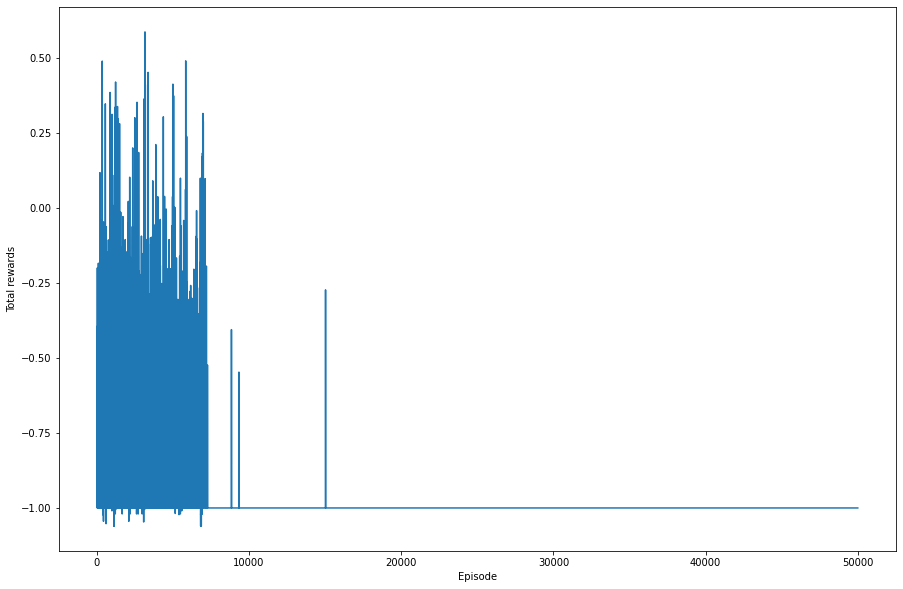

In [10]:
plt.figure(figsize=(15,10))
plt.xlabel("Episode")
plt.ylabel("Total rewards")
plt.plot(reward_list)

In [11]:
def moving_average(data,n):
    len_data=len(data)-n
    res_data=np.zeros(len_data)

    for i in range(len_data):
        res_data[i]=sum(data[i:i+n])/n
    return res_data

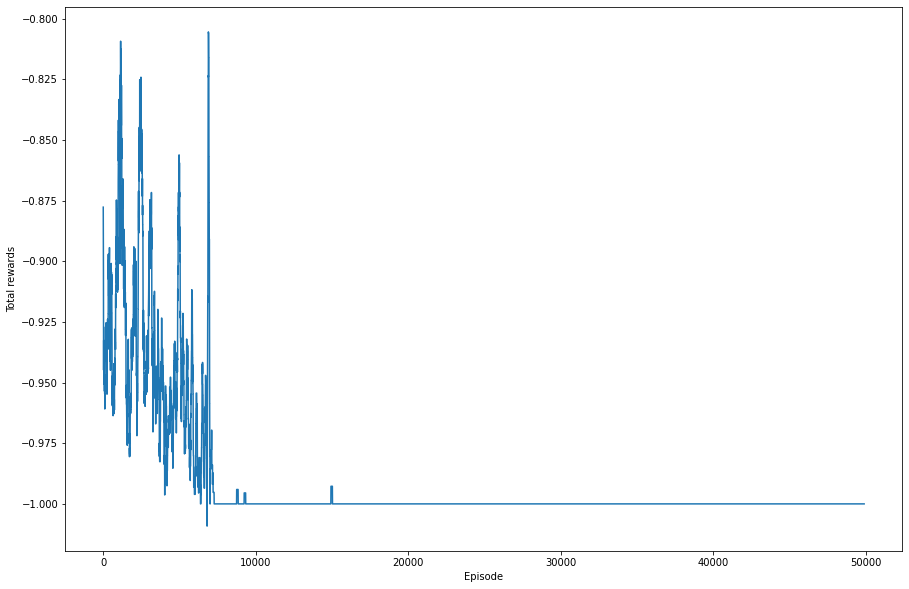

In [12]:
average_number=100
filtered_data=moving_average(reward_list,average_number)
plt.figure(figsize=(15,10))
plt.xlabel("Episode")
plt.ylabel("Total rewards")
plt.plot(filtered_data)

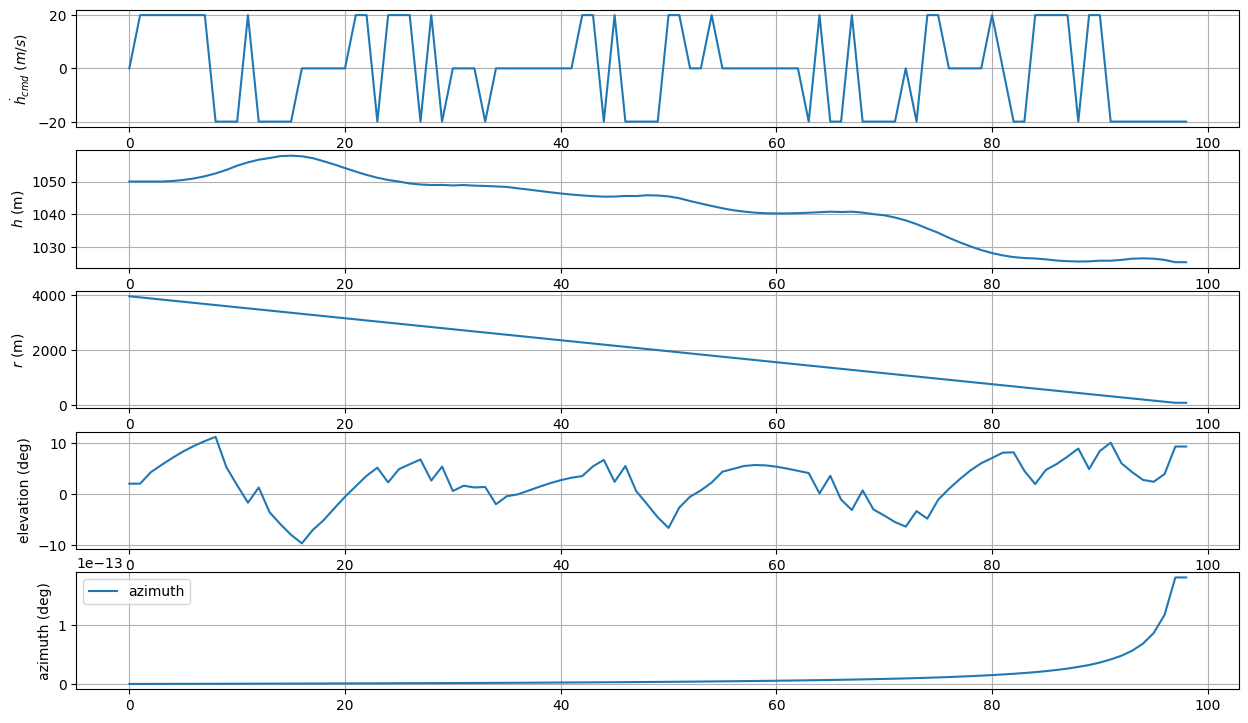

In [13]:
# plots
Deg2Rad = np.pi/180
Rad2Deg = 1/Deg2Rad

plt_res=total_res[-1]


plt.figure(figsize=(15,9), dpi=100)

plt.subplot(511)
plt.plot(plt_res[:,0], label=r'$\dot{h}_{cmd}$')
plt.ylabel(r'$\dot{h}_{cmd}$ ($m/s$)'), plt.grid()

plt.subplot(512)
plt.plot(plt_res[:,10],label=r'$\{h}$')
plt.ylabel(r'$h$ (m)'), plt.grid()

plt.subplot(513)
plt.plot(plt_res[:,1],label=r'$\{r}$')
plt.ylabel(r'$r$ (m)'), plt.grid()

plt.subplot(514)
plt.plot(plt_res[:,2]*Rad2Deg, label='elevation')
plt.ylabel('elevation (deg)'), plt.grid()

plt.subplot(515)
plt.plot(plt_res[:,3]*Rad2Deg, label='azimuth')
plt.ylabel('azimuth (deg)'), plt.grid()

plt.legend()
plt.show()

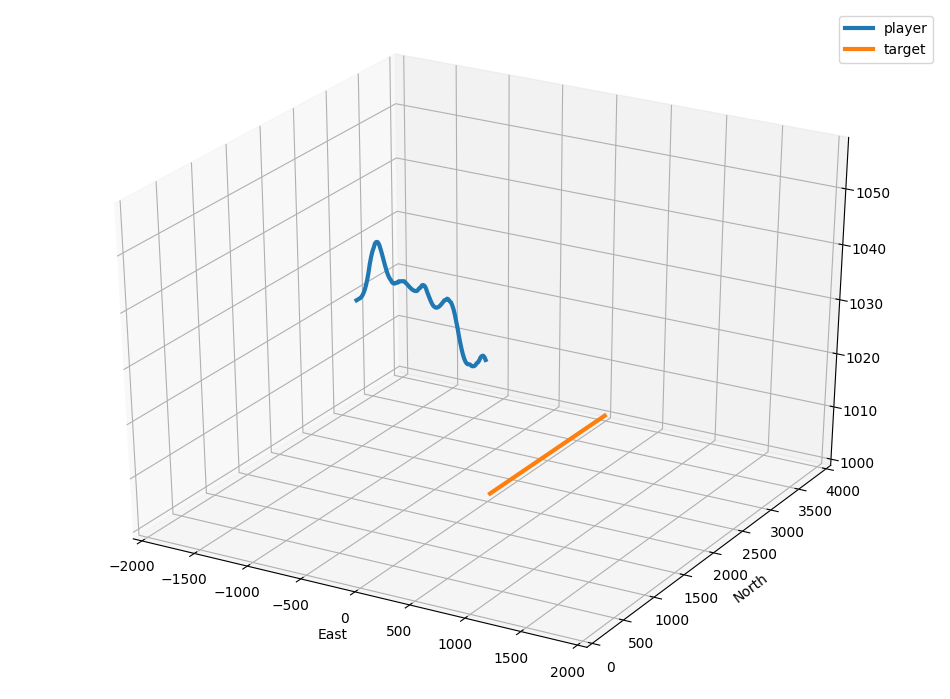

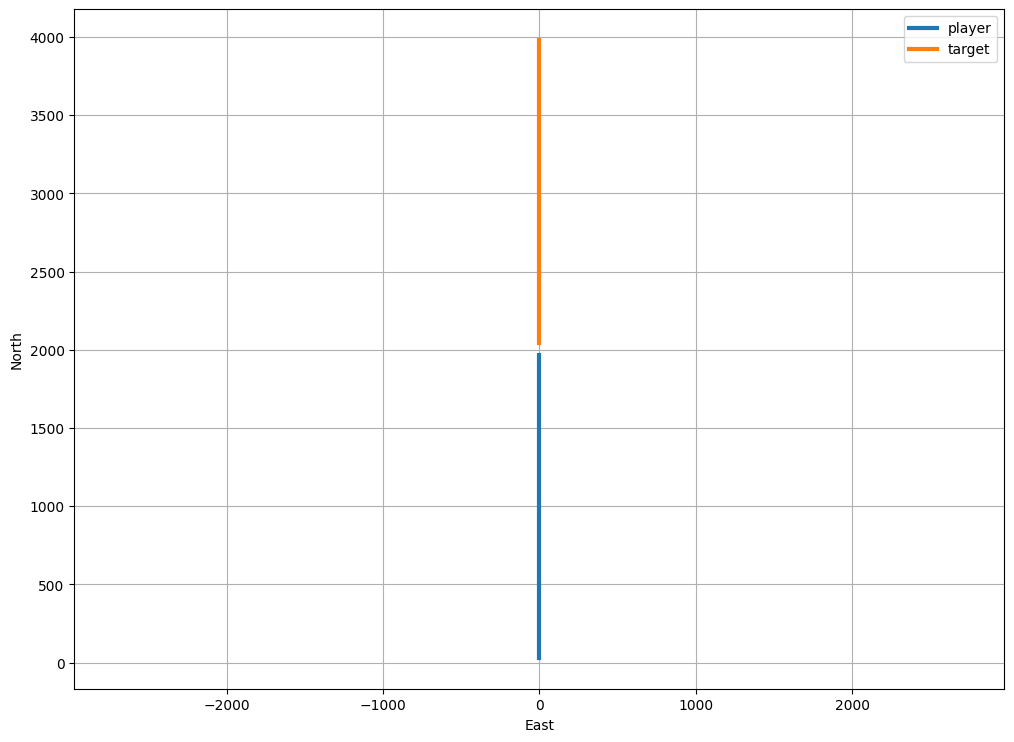

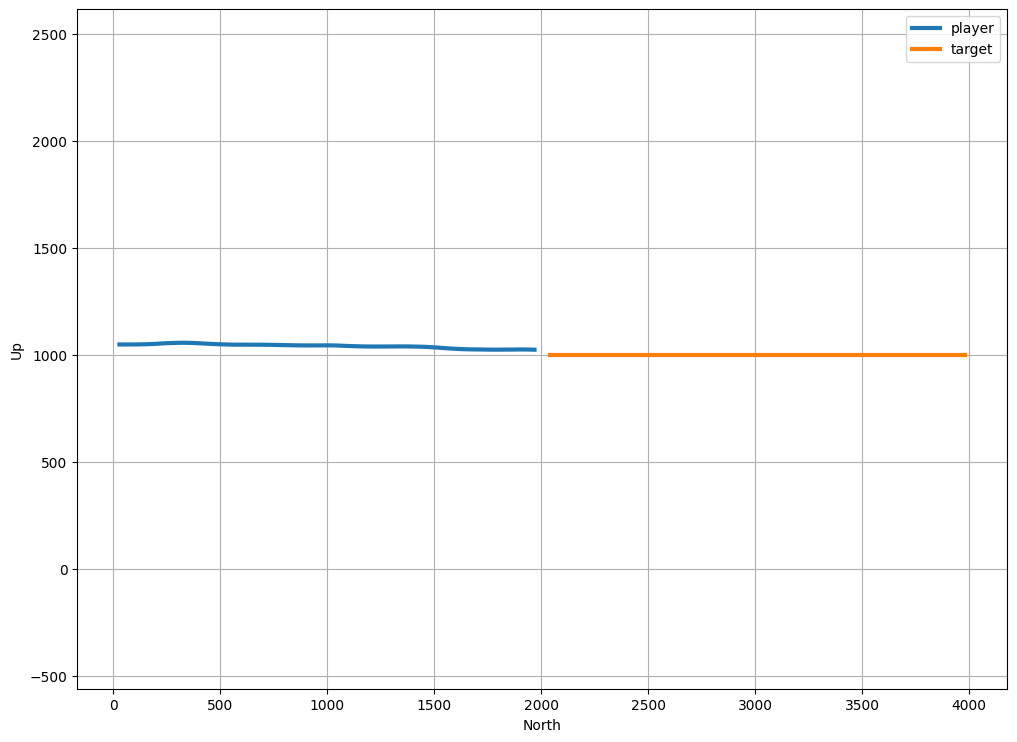

In [14]:
from mpl_toolkits.mplot3d import Axes3D

plt.figure(figsize=(12,9), dpi=100)
plt.gca(projection='3d')
plt.plot(plt_res[:,5], plt_res[:,4], -plt_res[:,6], label='player', linewidth=3)
plt.plot(plt_res[:,8], plt_res[:,7], -plt_res[:,9], label='target', linewidth=3)
plt.xlabel('East')
plt.ylabel('North')
plt.xlim(-2000,2000)
plt.ylim(0,4000)
plt.legend()
plt.show()

plt.figure(figsize=(12,9), dpi=100)
plt.plot(plt_res[:,5], plt_res[:,4], label='player', linewidth=3)
plt.plot(plt_res[:,8], plt_res[:,7], label='target', linewidth=3)
plt.xlabel('East')
plt.ylabel('North')
plt.grid(), plt.legend(), plt.axis('equal')
plt.show()

plt.figure(figsize=(12,9), dpi=100)
plt.plot(plt_res[:,4], -plt_res[:,6], label='player', linewidth=3)
plt.plot(plt_res[:,7], -plt_res[:,9], label='target', linewidth=3)
plt.xlabel('North')
plt.ylabel('Up')
plt.grid(), plt.legend(), plt.axis('equal')
plt.show()

In [15]:
min(plt_res[:,1])

75.28666376131805